C:\Users\sesa512654\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Converged after 123300 iterations.
Total cost: 94696104.0
Number of SOC violations: 21
SOC at the end of the period: 0.44
Optimized Pg: [4867.886  3312.9414 3340.7212 4098.026  4403.919  4469.623  4446.764
 4104.7    4116.0806 3691.897  4196.9473 4995.8784 5000.     4999.9
 3674.4004 3611.2952 3491.0476 2376.92   1850.1023 3076.3867 2090.188
 2606.8853 2579.6365 1276.3182 2293.3293 1956.9801 1867.1837 1381.9922
 1901.0626 1576.6719 3261.2986 2361.2021 3936.6226 3151.0532 3782.8264
 4570.0015 3724.9077 4364.5186 5000.     5000.     4999.9    4999.9
 5000.     4867.9214 4872.702  4444.644  4899.9736 4248.6216]
Optimized Pb: [-543.92236   868.0946    763.2488    -68.96837  -461.9195   -543.7082
 -513.83057  -154.70381   -46.160442  454.0969    113.04432  -565.22894
 -463.09686  -503.51758   522.6354    233.75587    73.54851   804.2432
  804.6562   -691.75854    47.697384 -640.5884   -706.3618    464.33618
 -495.588    -123.23893   102.9056    773.2754    348.1817    893.85626
 -523.61487 

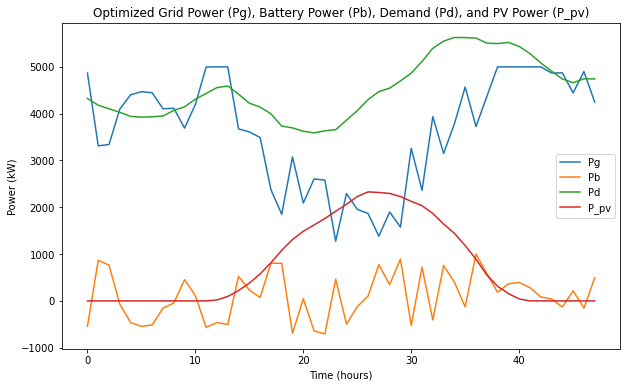

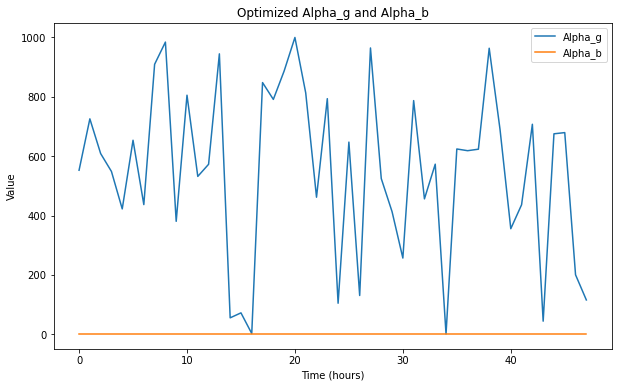

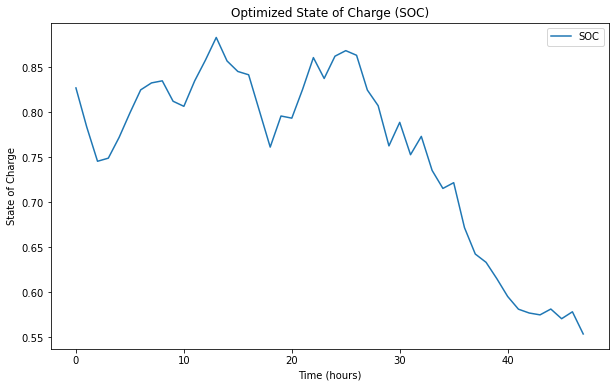

In [34]:
import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(lr=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 1000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -5000
Pg_max = np.ones(48) * 5000  # Example of maximum grid power
Pb_min = np.ones(48) * -1000  # Example of minimum battery power
Pb_max = np.ones(48) * 1000  # Example of maximum battery power
battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(lr=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


C:\Users\sesa512654\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Converged after 123300 iterations.
Total cost: 94696104.0
Number of SOC violations: 21
SOC at the end of the period: 0.44
Optimized Pg: [4867.886  3312.9414 3340.7212 4098.026  4403.919  4469.623  4446.764
 4104.7    4116.0806 3691.897  4196.9473 4995.8784 5000.     4999.9
 3674.4004 3611.2952 3491.0476 2376.92   1850.1023 3076.3867 2090.188
 2606.8853 2579.6365 1276.3182 2293.3293 1956.9801 1867.1837 1381.9922
 1901.0626 1576.6719 3261.2986 2361.2021 3936.6226 3151.0532 3782.8264
 4570.0015 3724.9077 4364.5186 5000.     5000.     4999.9    4999.9
 5000.     4867.9214 4872.702  4444.644  4899.9736 4248.6216]
Optimized Pb: [-543.92236   868.0946    763.2488    -68.96837  -461.9195   -543.7082
 -513.83057  -154.70381   -46.160442  454.0969    113.04432  -565.22894
 -463.09686  -503.51758   522.6354    233.75587    73.54851   804.2432
  804.6562   -691.75854    47.697384 -640.5884   -706.3618    464.33618
 -495.588    -123.23893   102.9056    773.2754    348.1817    893.85626
 -523.61487 

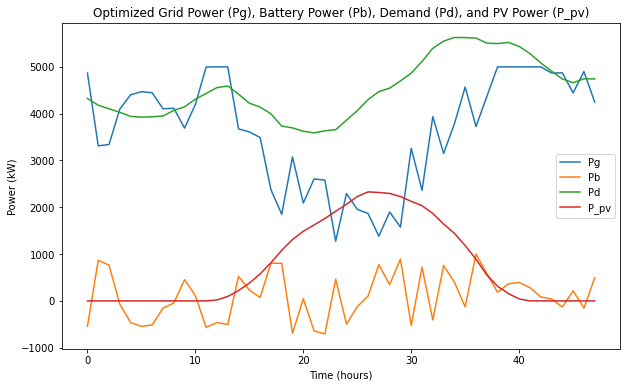

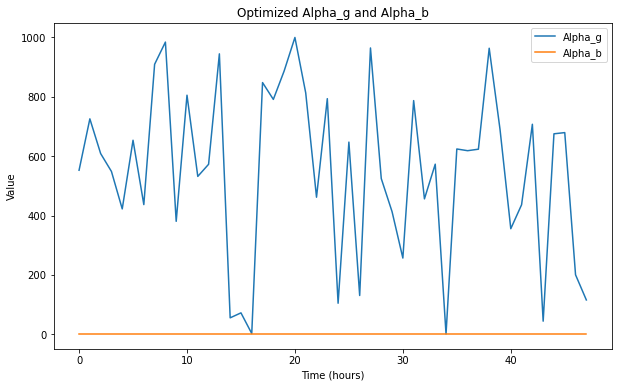

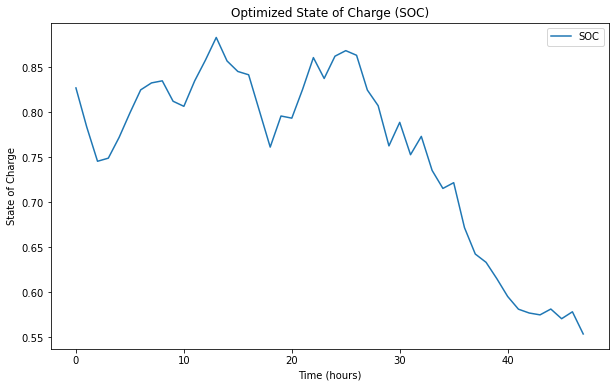

In [35]:
import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(lr=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 1500000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -5000
Pg_max = np.ones(48) * 5000  # Example of maximum grid power
Pb_min = np.ones(48) * -1000  # Example of minimum battery power
Pb_max = np.ones(48) * 1000  # Example of maximum battery power
battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(lr=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


Converged after 123300 iterations.
Total cost: 94696104.0
Number of SOC violations: 21
SOC at the end of the period: 0.44
Optimized Pg: [4867.886  3312.9414 3340.7212 4098.026  4403.919  4469.623  4446.764
 4104.7    4116.0806 3691.897  4196.9473 4995.8784 5000.     4999.9
 3674.4004 3611.2952 3491.0476 2376.92   1850.1023 3076.3867 2090.188
 2606.8853 2579.6365 1276.3182 2293.3293 1956.9801 1867.1837 1381.9922
 1901.0626 1576.6719 3261.2986 2361.2021 3936.6226 3151.0532 3782.8264
 4570.0015 3724.9077 4364.5186 5000.     5000.     4999.9    4999.9
 5000.     4867.9214 4872.702  4444.644  4899.9736 4248.6216]
Optimized Pb: [-543.92236   868.0946    763.2488    -68.96837  -461.9195   -543.7082
 -513.83057  -154.70381   -46.160442  454.0969    113.04393  -565.22894
 -463.09686  -503.51758   522.6354    233.75548    73.54851   804.2432
  804.6562   -691.75854    47.697384 -640.5884   -706.3618    464.33618
 -495.588    -123.23893   102.9056    773.2754    348.1817    893.85626
 -523.61487 

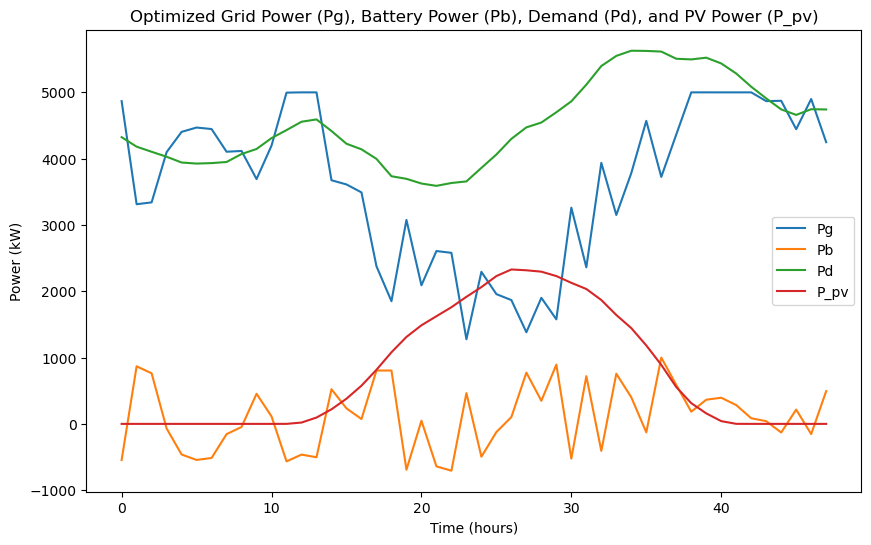

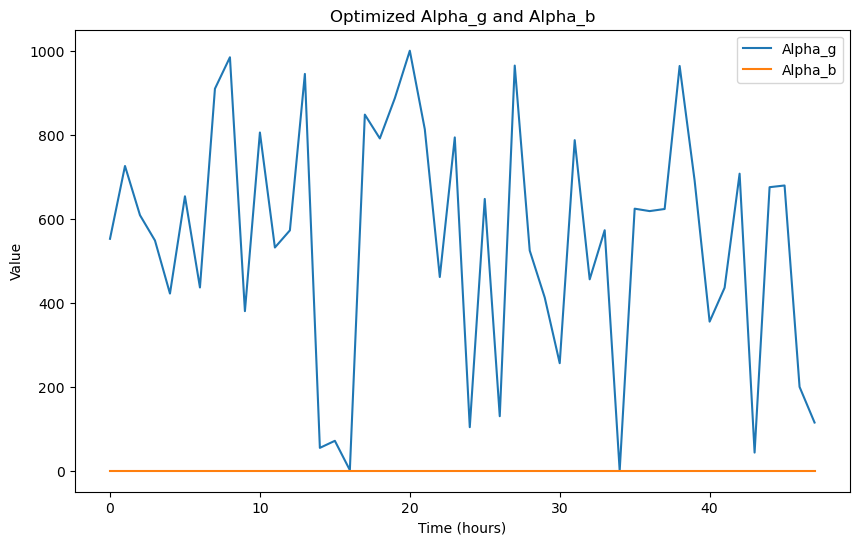

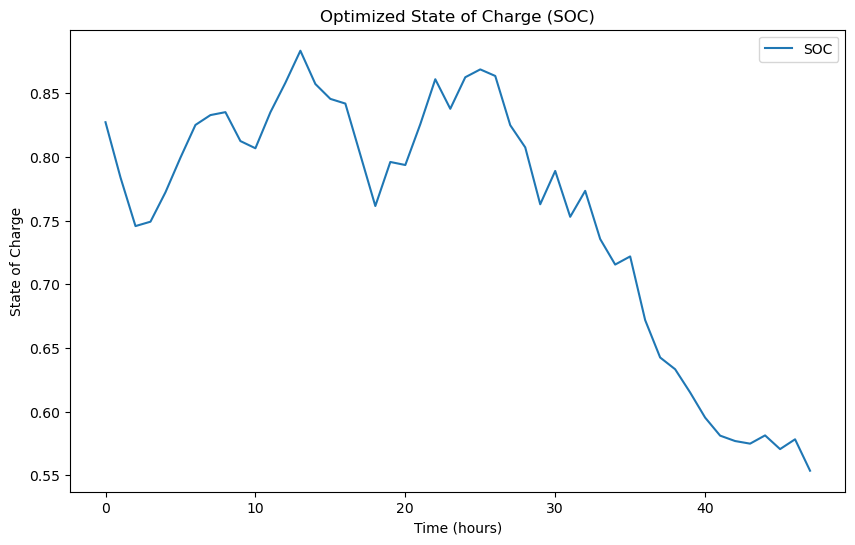

In [4]:
import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 2000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -5000
Pg_max = np.ones(48) * 5000  # Example of maximum grid power
Pb_min = np.ones(48) * -1000  # Example of minimum battery power
Pb_max = np.ones(48) * 1000  # Example of maximum battery power
battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


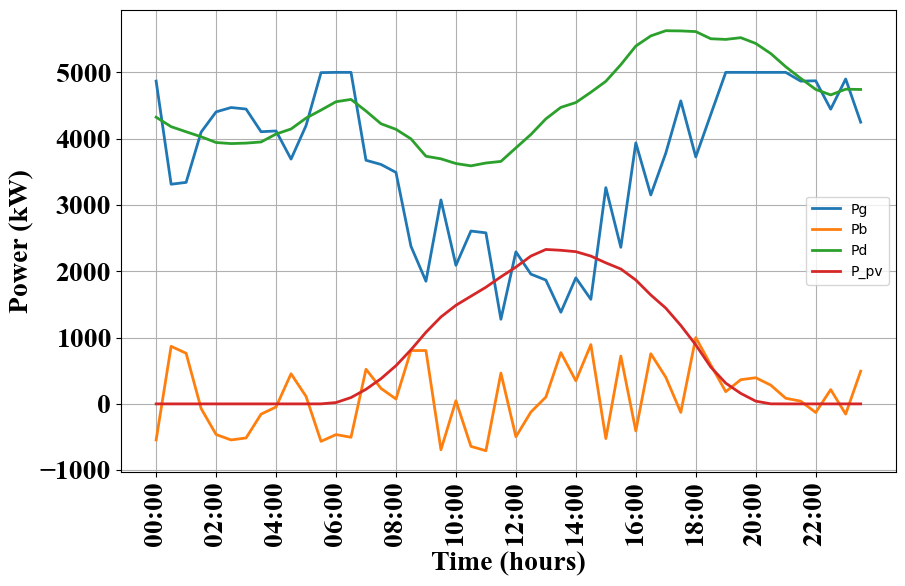

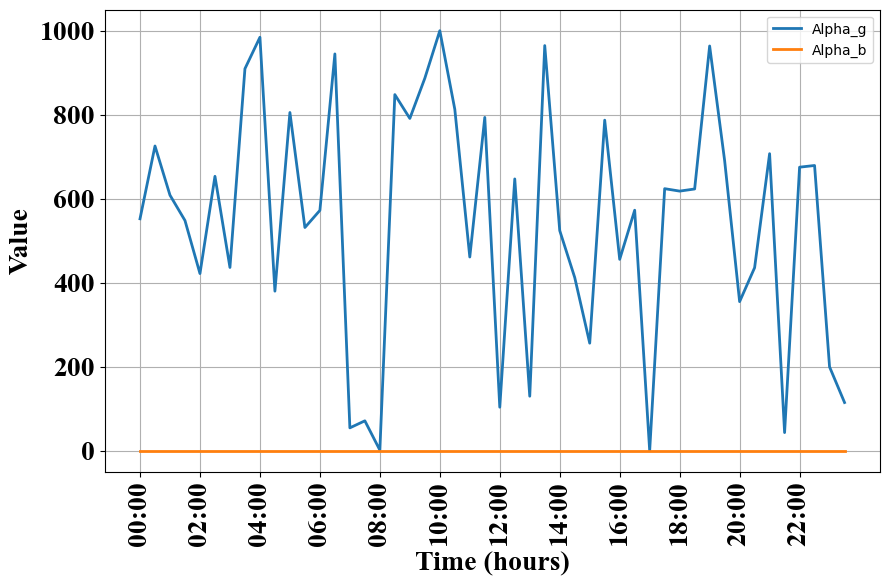

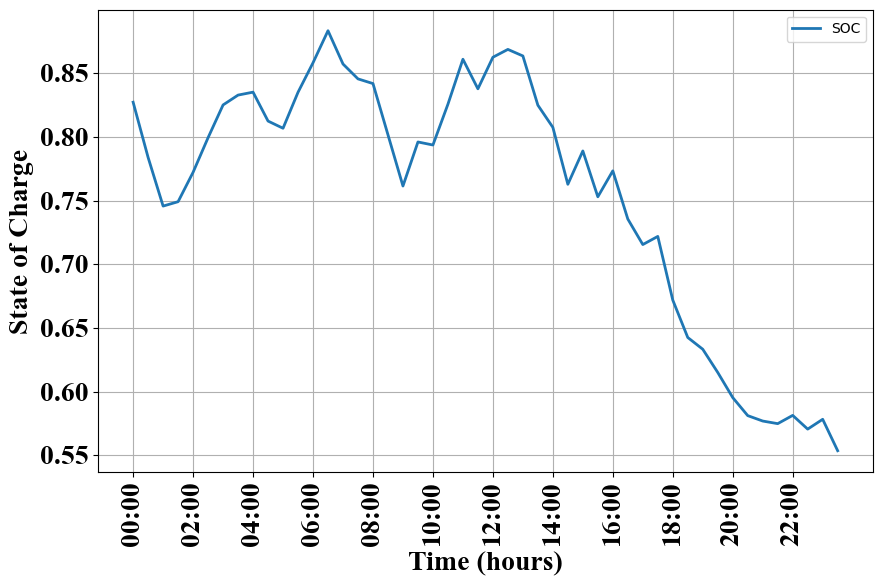

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

# Generate dummy time data
time_data = np.arange(0, 24, 0.5)  # Time data for 24 hours, every 30 minutes
# Assuming you have the following data: Pg_t, Pb_t, P_d, P_pv, alpha_g_t, alpha_b_t, SOC_t_normalized

# Convert time_data to datetime objects
time_ticks = [datetime.datetime(2023, 6, 21, int(h), int((h % 1) * 60)).strftime('%H:%M') for h in time_data]

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(time_data, Pg_t.numpy(), label="Pg", linewidth=2.0)
plt.plot(time_data, Pb_t.numpy(), label="Pb", linewidth=2.0)
plt.plot(time_data, P_d, label="Pd", linewidth=2.0)
plt.plot(time_data, P_pv, label="P_pv", linewidth=2.0)
plt.xlabel("Time (hours)", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.ylabel("Power (kW)", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.legend()
plt.grid(True)  # Add gridlines

# Set the x-axis ticks to show time only every 2 hours
plt.xticks(time_data[::4], time_ticks[::4], fontname="Times New Roman", fontsize=20, fontweight='bold', rotation ='vertical')

plt.yticks(fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.savefig('Pg_Pb_Pd_Ppv_plot_ACT.pdf')

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(time_data, alpha_g_t.numpy(), label="Alpha_g", linewidth=2.0)
plt.plot(time_data, alpha_b_t.numpy(), label="Alpha_b", linewidth=2.0)
plt.xlabel("Time (hours)", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.ylabel("Value", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.legend()
plt.grid(True)  # Add gridlines

# Set the x-axis ticks to show time only every 2 hours
plt.xticks(time_data[::4], time_ticks[::4], fontname="Times New Roman", fontsize=20, fontweight='bold', rotation ='vertical')

plt.yticks(fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.savefig('alpha_g_alpha_b_plot_ACT.pdf')

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(time_data, SOC_t_normalized.numpy(), label="SOC", linewidth=2.0)
plt.xlabel("Time (hours)", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.ylabel("State of Charge", fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.legend()
plt.grid(True)  # Add gridlines

# Set the x-axis ticks to show time only every 2 hours
plt.xticks(time_data[::4], time_ticks[::4], fontname="Times New Roman", fontsize=20, fontweight='bold', rotation ='vertical')

plt.yticks(fontname="Times New Roman", fontsize=20, fontweight='bold')
plt.savefig('SOC_plot_ACT.pdf')

C:\Users\sesa512654\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Converged after 123300 iterations.
Total cost: 94696104.0
Number of SOC violations: 21
SOC at the end of the period: 0.44
Optimized Pg: [4867.886  3312.9414 3340.7212 4098.026  4403.919  4469.623  4446.764
 4104.7    4116.0806 3691.897  4196.9473 4995.8784 5000.     4999.9
 3674.4004 3611.2952 3491.0476 2376.92   1850.1023 3076.3867 2090.188
 2606.8853 2579.6365 1276.3182 2293.3293 1956.9801 1867.1837 1381.9922
 1901.0626 1576.6719 3261.2986 2361.2021 3936.6226 3151.0532 3782.8264
 4570.0015 3724.9077 4364.5186 5000.     5000.     4999.9    4999.9
 5000.     4867.9214 4872.702  4444.644  4899.9736 4248.6216]
Optimized Pb: [-543.92236   868.0946    763.2488    -68.96837  -461.9195   -543.7082
 -513.83057  -154.70381   -46.160442  454.0969    113.04432  -565.22894
 -463.09686  -503.51758   522.6354    233.75587    73.54851   804.2432
  804.6562   -691.75854    47.697384 -640.5884   -706.3618    464.33618
 -495.588    -123.23893   102.9056    773.2754    348.1817    893.85626
 -523.61487 

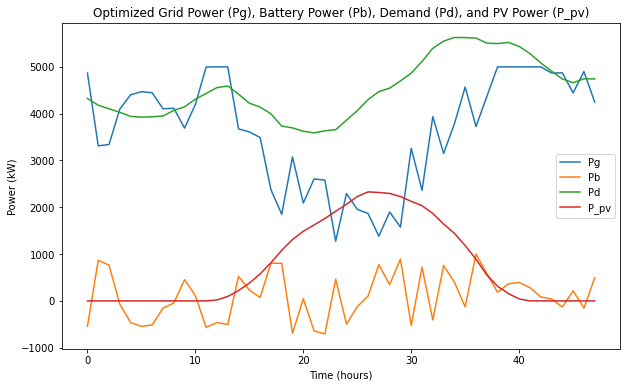

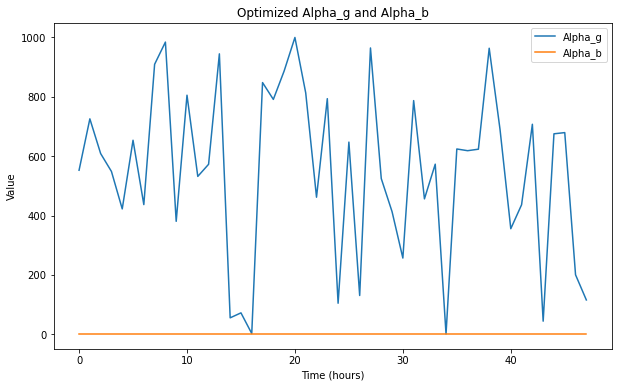

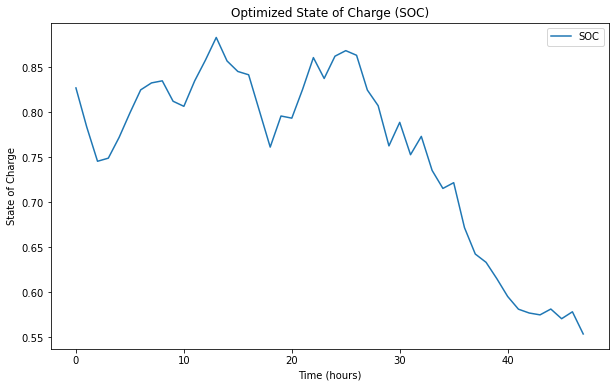

In [37]:
import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(lr=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -5000
Pg_max = np.ones(48) * 5000  # Example of maximum grid power
Pb_min = np.ones(48) * -1000  # Example of minimum battery power
Pb_max = np.ones(48) * 1000  # Example of maximum battery power
battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(lr=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


In [38]:
import numpy as np
import tensorflow as tf
import time

# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(lr=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 10000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -5000
Pg_max = np.ones(48) * 5000  # Example of maximum grid power
Pb_min = np.ones(48) * -1000  # Example of minimum battery power
Pb_max = np.ones(48) * 1000  # Example of maximum battery power
battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(lr=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


C:\Users\sesa512654\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


KeyboardInterrupt: 

In [7]:
import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 500000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.full((48,), -5000)
Pg_max = np.full((48,), 5000)  # Example of maximum grid power
Pb_min = np.full((48,), -1000)  # Example of minimum battery power
Pb_max = np.full((48,), 1000)  # Example of maximum battery power

battery_capacity = 20000  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 

# Hyperparameters to tune
initial_lr_values = [0.1, 0.01, 0.001]
decay_rate_values = [0.9, 0.95, 0.99]

# Dictionary to store SOC for each run
soc_dict = {}

# Iterate over different combinations of hyperparameters
for initial_lr in initial_lr_values:
    for decay_rate in decay_rate_values:
        # Reinitialize variables for each run
        Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
        Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
        alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
        alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)

        start_time = time.time()
        for epoch in range(num_epochs):
            Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=initial_lr, decay_steps=100, decay_rate=decay_rate, num_epochs=1)
            Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=initial_lr, decay_steps=100, decay_rate=decay_rate, num_epochs=1)
    
            Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

            with tf.GradientTape() as tape:
                loss = Pg_Pb_loss(Pg_t, Pb_t)
            grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

            # Update alpha_g_t and alpha_b_t using the Adam optimizer
            alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

            # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
            project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
            project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

            # Check for convergence
            if epoch % 100 == 0:
                if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
                    print(f"Converged after {epoch} iterations.")
                    break
                loss_prev = loss.numpy()

        end_time = time.time()
        

        SOC_t_normalized = enforce_battery_constraints(Pb_t)
        soc_dict[(initial_lr, decay_rate)] = SOC_t_normalized.numpy()

# Plotting
fig, axs = plt.subplots(len(initial_lr_values), len(decay_rate_values), figsize=(15, 15))

for i, initial_lr in enumerate(initial_lr_values):
    for j, decay_rate in enumerate(decay_rate_values):
        axs[i, j].plot(soc_dict[(initial_lr, decay_rate)])
        axs[i, j].set_title(f"initial_lr={initial_lr}, decay_rate={decay_rate}")
        axs[i, j].set_xlabel("Time (hours)")
        axs[i, j].set_ylabel("SOC")

plt.tight_layout()
plt.show()
plt.savefig("plotsofruns.pdf")



KeyError: 'The optimizer cannot recognize variable Variable:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'

In [ ]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)


# Dummy parameters (You will have to replace these with your actual parameters)
battery_capacity = 10.0
initial_SOC = 0.5
alpha_g_min = 0.1
alpha_g_max = 0.9
Pg_min = 0.0
Pg_max = 1.0
Pb_min = 0.0
Pb_max = 1.0

# Placeholder functions (You will have to replace these with your actual functions)
def enforce_battery_constraints(Pb, battery_capacity, initial_SOC):
    # Placeholder code (replace with your actual logic)
    return np.clip(Pb, 0, 1)

def update_alpha_g(Cg_t, alpha_g_min, alpha_g_max):
    # Placeholder code (replace with your actual logic)
    return np.clip(Cg_t, alpha_g_min, alpha_g_max)

def project_constraints(var, lower_bounds, upper_bounds):
    # Placeholder code (replace with your actual logic)
    var.assign(tf.clip_by_value(var, lower_bounds, upper_bounds))

# Loss function
def Pg_Pb_loss(Pg, Pb, alpha_g_t, alpha_b_t, Cg_t, alpha_g_min, alpha_g_max, battery_capacity, initial_SOC):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)

    SOC_t_normalized = enforce_battery_constraints(Pb, battery_capacity, initial_SOC)
    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Penalty terms
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg + Pb) - P_pv)) * 10000
    alpha_g_penalty_weight = 100
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
    end_soc_penalty_weight = 10000
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty

# Optimization function
def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var[0], var[1])
        gradients = tape.gradient(loss, var)
        optimizer.apply_gradients(zip(gradients, var))
        project_constraints(var[0], bounds[0][0], bounds[0][1])
        project_constraints(var[1], bounds[1][0], bounds[1][1])
    
    return var

# Hyperparameters for experiments
hyperparams = [
    {"initial_lr": 0.1, "decay_steps": 100, "decay_rate": 0.96, "num_epochs": 100},
    {"initial_lr": 0.05, "decay_steps": 100, "decay_rate": 0.90, "num_epochs": 100},
]

# Experiment
for i, params in enumerate(hyperparams):
    initial_lr = params["initial_lr"]
    decay_steps = params["decay_steps"]
    decay_rate = params["decay_rate"]
    num_epochs = params["num_epochs"]

    # Reinitialize the variables
    Pg_t = tf.Variable(np.random.rand(48), dtype=tf.float32)
    Pb_t = tf.Variable(np.random.rand(48), dtype=tf.float32)
    alpha_g_t = tf.Variable(np.random.rand(48), dtype=tf.float32)
    alpha_b_t = tf.Variable(np.random.rand(48), dtype=tf.float32)

    # Optimize the variables
    optimal_vars = optimize_with_schedule(
        lambda Pg, Pb: Pg_Pb_loss(Pg, Pb, alpha_g_t, alpha_b_t, Cg_t, alpha_g_min, alpha_g_max, battery_capacity, initial_SOC),
        [Pg_t, Pb_t],
        [(Pg_min, Pg_max), (Pb_min, Pb_max)],
        initial_lr,
        decay_steps,
        decay_rate,
        num_epochs)

    # Plot the results
    plt.figure()
    plt.subplot(2, 2, i + 1)
    plt.plot(range(48), np.squeeze(optimal_vars[0].numpy()), label="Pg")
    plt.plot(range(48), np.squeeze(optimal_vars[1].numpy()), label="Pb")
    plt.plot(range(48), np.squeeze(P_d), label="Pd")
    plt.legend()
    plt.title(f"LR: {initial_lr}, DR: {decay_rate}")
    plt.xlabel("Time")
    plt.ylabel("Power")

# Save the figure and show it
plt.savefig("plotsofruns.pdf")
plt.show()


In [3]:
plt.tight_layout()
plt.show()
plt.savefig("plotsofruns.pdf")


NameError: name 'plt' is not defined

In [2]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 422.5/422.5 kB 27.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.12.0 which is incompatible.
tensorflow-gpu 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.2 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.12.3 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.12.0 which is incompatible.


In [3]:
pip install --upgrade protobuf

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


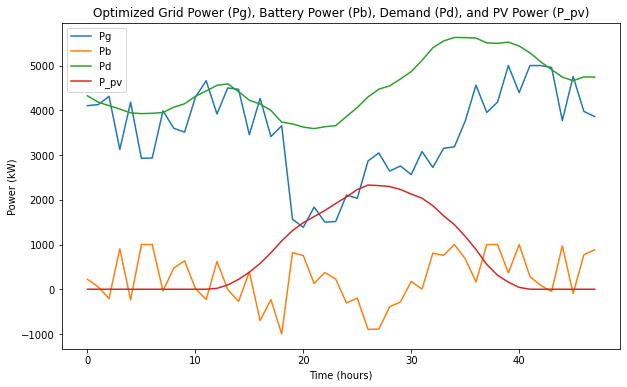

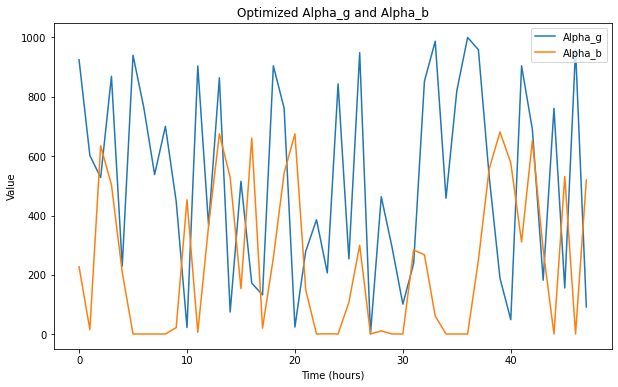

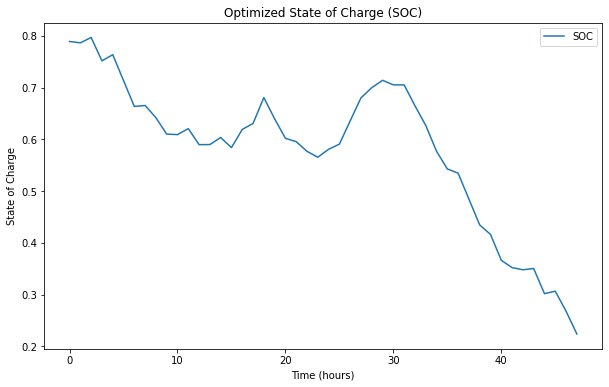

In [10]:
import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()

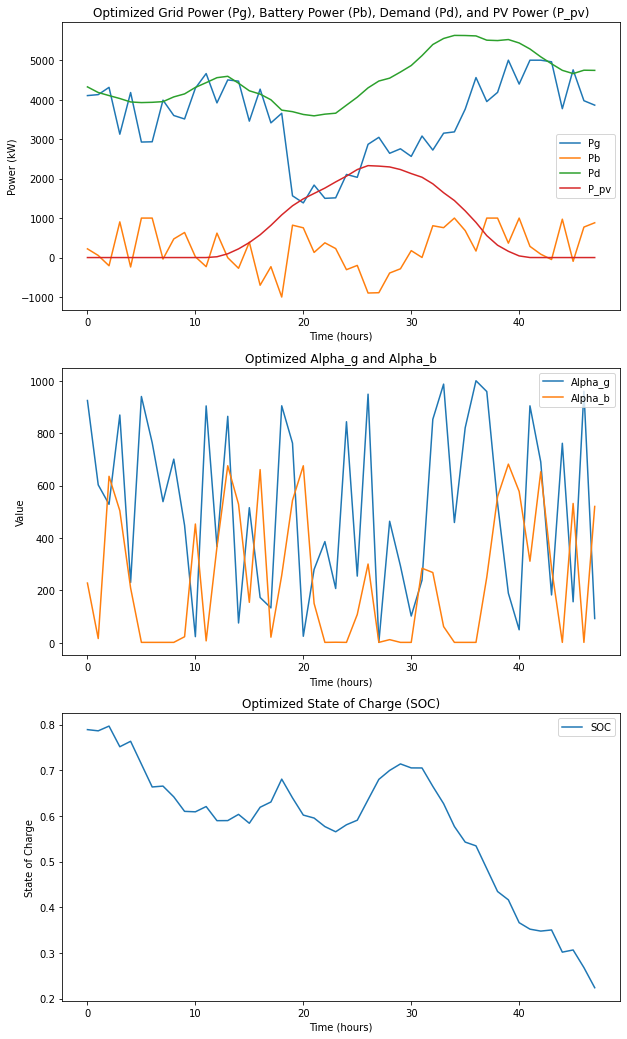

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot Pg, Pb, Pd, and Ppv
axs[0].plot(Pg_t.numpy(), label="Pg")
axs[0].plot(Pb_t.numpy(), label="Pb")
axs[0].plot(P_d, label="Pd")
axs[0].plot(P_pv, label="P_pv")
axs[0].set_xlabel("Time (hours)")
axs[0].set_ylabel("Power (kW)")
axs[0].legend()
axs[0].set_title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")

# Plot alphas
axs[1].plot(alpha_g_t.numpy(), label="Alpha_g")
axs[1].plot(alpha_b_t.numpy(), label="Alpha_b")
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Value")
axs[1].legend()
axs[1].set_title("Optimized Alpha_g and Alpha_b")

# Plot SOC
axs[2].plot(SOC_t_normalized.numpy(), label="SOC")
axs[2].set_xlabel("Time (hours)")
axs[2].set_ylabel("State of Charge")
axs[2].legend()
axs[2].set_title("Optimized State of Charge (SOC)")

# Export as Pdf
plt.savefig("plots.pdf")



AttributeError: 'ResourceVariable' object has no attribute 'ndim'

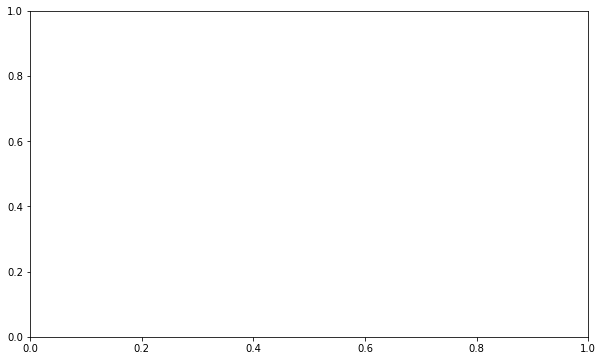

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Pg, Pb, Pd, and Ppv
ax.plot(Pg_t, label="Pg")
ax.plot(Pb_t, label="Pb")
ax.plot(P_d, label="Pd")
ax.plot(P_pv, label="P_pv")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power (kW)")
ax.legend()
ax.set_title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")

# Plot alphas
ax.plot(alpha_g_t, label="Alpha_g")
ax.plot(alpha_b_t, label="Alpha_b")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Value")
ax.legend()
ax.set_title("Optimized Alpha_g and Alpha_b")

# Plot SOC
ax.plot(SOC_t_normalized, label="SOC")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("State of Charge")
ax.legend()
ax.set_title("Optimized State of Charge (SOC)")

# Customize the appearance of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

# Export as Pdf
plt.savefig("plots.pdf")


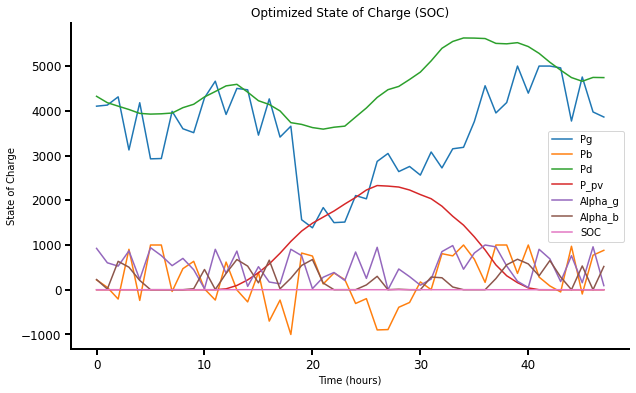

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Pg, Pb, Pd, and Ppv
ax.plot(Pg_t.numpy(), label="Pg")
ax.plot(Pb_t.numpy(), label="Pb")
ax.plot(P_d, label="Pd")  # <-- remove .numpy() method from this line
ax.plot(P_pv, label="P_pv")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power (kW)")
ax.legend()
ax.set_title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")

# Plot alphas
ax.plot(alpha_g_t.numpy(), label="Alpha_g")
ax.plot(alpha_b_t.numpy(), label="Alpha_b")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Value")
ax.legend()
ax.set_title("Optimized Alpha_g and Alpha_b")

# Plot SOC
ax.plot(SOC_t_normalized.numpy(), label="SOC")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("State of Charge")
ax.legend()
ax.set_title("Optimized State of Charge (SOC)")

# Customize the appearance of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

# Export as Pdf
plt.savefig("plots.pdf")



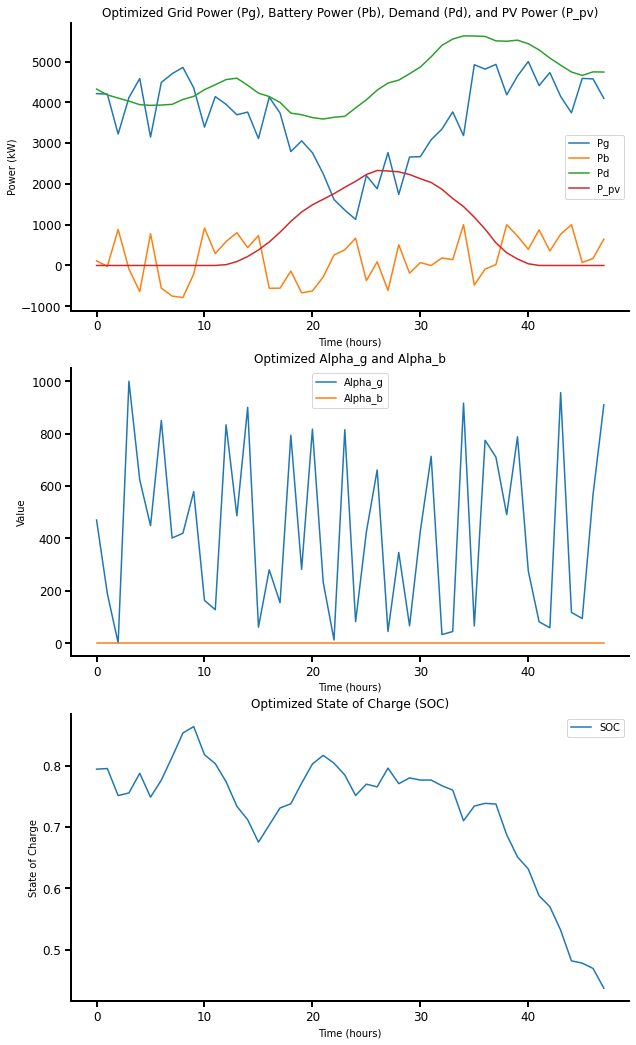

In [22]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Plot Pg, Pb, Pd, and Ppv
axs[0].plot(Pg_t.numpy(), label="Pg")
axs[0].plot(Pb_t.numpy(), label="Pb")
axs[0].plot(P_d, label="Pd")
axs[0].plot(P_pv, label="P_pv")
axs[0].set_xlabel("Time (hours)")
axs[0].set_ylabel("Power (kW)")
axs[0].legend()
axs[0].set_title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")

# Plot alphas
axs[1].plot(alpha_g_t.numpy(), label="Alpha_g")
axs[1].plot(alpha_b_t.numpy(), label="Alpha_b")
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Value")
axs[1].legend()
axs[1].set_title("Optimized Alpha_g and Alpha_b")

# Plot SOC
axs[2].plot(SOC_t_normalized.numpy(), label="SOC")
axs[2].set_xlabel("Time (hours)")
axs[2].set_ylabel("State of Charge")
axs[2].legend()
axs[2].set_title("Optimized State of Charge (SOC)")

# Customize the appearance of the plots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

# Export as Pdf
plt.savefig("plots2.pdf")


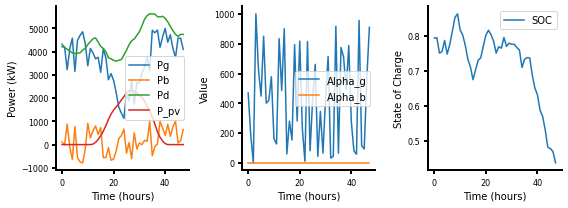

In [21]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

# Plot Pg, Pb, Pd, and Ppv
axs[0].plot(Pg_t.numpy(), label="Pg")
axs[0].plot(Pb_t.numpy(), label="Pb")
axs[0].plot(P_d, label="Pd")
axs[0].plot(P_pv, label="P_pv")
axs[0].set_xlabel("Time (hours)")
axs[0].set_ylabel("Power (kW)")
axs[0].legend()

# Plot alphas
axs[1].plot(alpha_g_t.numpy(), label="Alpha_g")
axs[1].plot(alpha_b_t.numpy(), label="Alpha_b")
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Value")
axs[1].legend()

# Plot SOC
axs[2].plot(SOC_t_normalized.numpy(), label="SOC")
axs[2].set_xlabel("Time (hours)")
axs[2].set_ylabel("State of Charge")
axs[2].legend()

# Customize the appearance of the plots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=8, width=2, length=4)

# Adjust layout and save
fig.tight_layout()
plt.savefig("plots1.pdf")


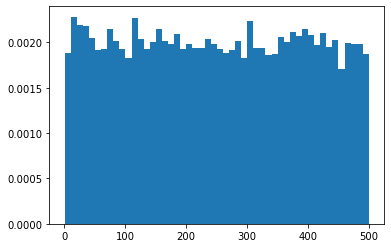

Entropy: 5.641388844047401


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Generate random uniform values
values = np.random.uniform(0, 500, 10000)


# Plot histogram of the values
plt.hist(values, bins=50, density=True)
plt.show()

# Compute and print entropy
# First, we create a histogram (i.e., count occurrences of each value) 
counts, _ = np.histogram(values, bins=50)
# Then we calculate the entropy
print("Entropy:", entropy(counts, base=2))


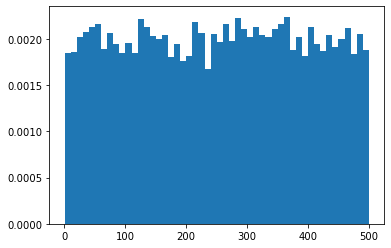

Entropy: 5.64072991046853


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Generate random uniform values
values = np.random.uniform(0, 500, 10000)

# Plot histogram of the values
plt.hist(values, bins=50, density=True)
plt.show()

# Compute and print entropy
# First, we create a histogram (i.e., count occurrences of each value) 
counts, _ = np.histogram(values, bins=50)
# Then we calculate the entropy
print("Entropy:", entropy(counts, base=2))


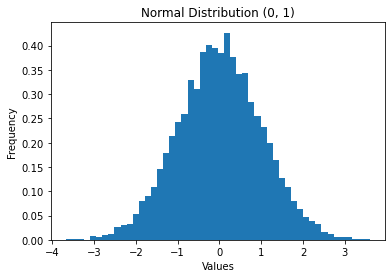

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random normal values
mu = 0     # mean
sigma = 1  # standard deviation
values = np.random.normal(mu, sigma, 10000)

# Plot histogram of the values
plt.hist(values, bins=50, density=True)
plt.title('Normal Distribution (0, 1)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


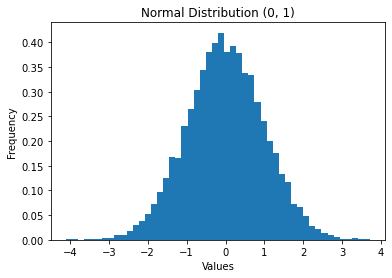

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random normal values
mu = 0     # mean
sigma = 1  # standard deviation
values = np.random.normal(mu, sigma, 10000)

# Plot histogram of the values
plt.hist(values, bins=50, density=True)
plt.title('Normal Distribution (0, 1)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.5    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 112      |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 240      |
|    critic_loss     | 2.96e+03 |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0464  |
|    learning_rate   | 1e-05    |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 72       |
|    time_elapsed    | 5        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 259      |
|    critic_loss     | 1.1e+03 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.8    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 41       |
|    time_elapsed    | 73       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 688      |
|    critic_loss     | 985      |
|    ent_coef        | 1.03     |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 1e-05    |
|    n_updates       | 2971     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.2    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 41       |
|    time_elapsed    | 78       |
|    total_timesteps | 3264     |
| train/             |          |
|    actor_loss      | 707      |
|    critic_loss     | 8.21e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -24.5    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 42       |
|    time_elapsed    | 141      |
|    total_timesteps | 5952     |
| train/             |          |
|    actor_loss      | 1.06e+03 |
|    critic_loss     | 1.47e+04 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -2.27    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5851     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 42       |
|    time_elapsed    | 146      |
|    total_timesteps | 6144     |
| train/             |          |
|    actor_loss      | 1.04e+03 |
|    critic_loss     | 1.33e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.3    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 42       |
|    time_elapsed    | 206      |
|    total_timesteps | 8832     |
| train/             |          |
|    actor_loss      | 1.32e+03 |
|    critic_loss     | 2.25e+04 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -3.5     |
|    learning_rate   | 1e-05    |
|    n_updates       | 8731     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 42       |
|    time_elapsed    | 211      |
|    total_timesteps | 9024     |
| train/             |          |
|    actor_loss      | 1.31e+03 |
|    critic_loss     | 2.29e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.6    |
| time/              |          |
|    episodes        | 244      |
|    fps             | 43       |
|    time_elapsed    | 268      |
|    total_timesteps | 11712    |
| train/             |          |
|    actor_loss      | 1.52e+03 |
|    critic_loss     | 2.57e+04 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -4.58    |
|    learning_rate   | 1e-05    |
|    n_updates       | 11611    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.9    |
| time/              |          |
|    episodes        | 248      |
|    fps             | 43       |
|    time_elapsed    | 273      |
|    total_timesteps | 11904    |
| train/             |          |
|    actor_loss      | 1.59e+03 |
|    critic_loss     | 3.21e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.2    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 43       |
|    time_elapsed    | 338      |
|    total_timesteps | 14592    |
| train/             |          |
|    actor_loss      | 1.72e+03 |
|    critic_loss     | 3.83e+04 |
|    ent_coef        | 1.15     |
|    ent_coef_loss   | -5.77    |
|    learning_rate   | 1e-05    |
|    n_updates       | 14491    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.6    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 43       |
|    time_elapsed    | 343      |
|    total_timesteps | 14784    |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 2.58e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.4    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 42       |
|    time_elapsed    | 408      |
|    total_timesteps | 17472    |
| train/             |          |
|    actor_loss      | 1.85e+03 |
|    critic_loss     | 5.49e+04 |
|    ent_coef        | 1.19     |
|    ent_coef_loss   | -7       |
|    learning_rate   | 1e-05    |
|    n_updates       | 17371    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.8    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 42       |
|    time_elapsed    | 413      |
|    total_timesteps | 17664    |
| train/             |          |
|    actor_loss      | 1.93e+03 |
|    critic_loss     | 2.12e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.3    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 42       |
|    time_elapsed    | 482      |
|    total_timesteps | 20352    |
| train/             |          |
|    actor_loss      | 1.96e+03 |
|    critic_loss     | 2.73e+04 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -8.09    |
|    learning_rate   | 1e-05    |
|    n_updates       | 20251    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.7    |
| time/              |          |
|    episodes        | 428      |
|    fps             | 42       |
|    time_elapsed    | 486      |
|    total_timesteps | 20544    |
| train/             |          |
|    actor_loss      | 1.99e+03 |
|    critic_loss     | 2.91e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.6    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 42       |
|    time_elapsed    | 551      |
|    total_timesteps | 23232    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 5.11e+04 |
|    ent_coef        | 1.26     |
|    ent_coef_loss   | -9.37    |
|    learning_rate   | 1e-05    |
|    n_updates       | 23131    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.8    |
| time/              |          |
|    episodes        | 488      |
|    fps             | 42       |
|    time_elapsed    | 556      |
|    total_timesteps | 23424    |
| train/             |          |
|    actor_loss      | 2e+03    |
|    critic_loss     | 5.54e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 544      |
|    fps             | 42       |
|    time_elapsed    | 621      |
|    total_timesteps | 26112    |
| train/             |          |
|    actor_loss      | 2.04e+03 |
|    critic_loss     | 3.95e+04 |
|    ent_coef        | 1.29     |
|    ent_coef_loss   | -10.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 26011    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.4    |
| time/              |          |
|    episodes        | 548      |
|    fps             | 42       |
|    time_elapsed    | 625      |
|    total_timesteps | 26304    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 4.69e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 604      |
|    fps             | 42       |
|    time_elapsed    | 687      |
|    total_timesteps | 28992    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 4.39e+04 |
|    ent_coef        | 1.33     |
|    ent_coef_loss   | -11.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 28891    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.5    |
| time/              |          |
|    episodes        | 608      |
|    fps             | 42       |
|    time_elapsed    | 691      |
|    total_timesteps | 29184    |
| train/             |          |
|    actor_loss      | 2.01e+03 |
|    critic_loss     | 2.57e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.7    |
| time/              |          |
|    episodes        | 664      |
|    fps             | 42       |
|    time_elapsed    | 755      |
|    total_timesteps | 31872    |
| train/             |          |
|    actor_loss      | 1.96e+03 |
|    critic_loss     | 2.78e+04 |
|    ent_coef        | 1.37     |
|    ent_coef_loss   | -12.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 31771    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.1    |
| time/              |          |
|    episodes        | 668      |
|    fps             | 42       |
|    time_elapsed    | 759      |
|    total_timesteps | 32064    |
| train/             |          |
|    actor_loss      | 1.97e+03 |
|    critic_loss     | 4.18e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68      |
| time/              |          |
|    episodes        | 724      |
|    fps             | 42       |
|    time_elapsed    | 820      |
|    total_timesteps | 34752    |
| train/             |          |
|    actor_loss      | 1.99e+03 |
|    critic_loss     | 3.65e+04 |
|    ent_coef        | 1.41     |
|    ent_coef_loss   | -14      |
|    learning_rate   | 1e-05    |
|    n_updates       | 34651    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.2    |
| time/              |          |
|    episodes        | 728      |
|    fps             | 42       |
|    time_elapsed    | 824      |
|    total_timesteps | 34944    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 2.91e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -71      |
| time/              |          |
|    episodes        | 784      |
|    fps             | 42       |
|    time_elapsed    | 883      |
|    total_timesteps | 37632    |
| train/             |          |
|    actor_loss      | 2.04e+03 |
|    critic_loss     | 1.48e+04 |
|    ent_coef        | 1.45     |
|    ent_coef_loss   | -15.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 37531    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -71.2    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 42       |
|    time_elapsed    | 887      |
|    total_timesteps | 37824    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 3.32e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.1    |
| time/              |          |
|    episodes        | 844      |
|    fps             | 42       |
|    time_elapsed    | 952      |
|    total_timesteps | 40512    |
| train/             |          |
|    actor_loss      | 2.06e+03 |
|    critic_loss     | 1.54e+04 |
|    ent_coef        | 1.49     |
|    ent_coef_loss   | -16.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 40411    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.2    |
| time/              |          |
|    episodes        | 848      |
|    fps             | 42       |
|    time_elapsed    | 957      |
|    total_timesteps | 40704    |
| train/             |          |
|    actor_loss      | 1.97e+03 |
|    critic_loss     | 1.91e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.7    |
| time/              |          |
|    episodes        | 904      |
|    fps             | 42       |
|    time_elapsed    | 1020     |
|    total_timesteps | 43392    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 1.78e+04 |
|    ent_coef        | 1.54     |
|    ent_coef_loss   | -17.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 43291    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.6    |
| time/              |          |
|    episodes        | 908      |
|    fps             | 42       |
|    time_elapsed    | 1025     |
|    total_timesteps | 43584    |
| train/             |          |
|    actor_loss      | 1.96e+03 |
|    critic_loss     | 2.14e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.2    |
| time/              |          |
|    episodes        | 964      |
|    fps             | 42       |
|    time_elapsed    | 1084     |
|    total_timesteps | 46272    |
| train/             |          |
|    actor_loss      | 1.96e+03 |
|    critic_loss     | 1.26e+04 |
|    ent_coef        | 1.58     |
|    ent_coef_loss   | -19      |
|    learning_rate   | 1e-05    |
|    n_updates       | 46171    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.3    |
| time/              |          |
|    episodes        | 968      |
|    fps             | 42       |
|    time_elapsed    | 1088     |
|    total_timesteps | 46464    |
| train/             |          |
|    actor_loss      | 1.98e+03 |
|    critic_loss     | 1.36e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -72.8    |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 42       |
|    time_elapsed    | 1148     |
|    total_timesteps | 49152    |
| train/             |          |
|    actor_loss      | 2.04e+03 |
|    critic_loss     | 1.22e+04 |
|    ent_coef        | 1.63     |
|    ent_coef_loss   | -20.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 49051    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -72.8    |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 42       |
|    time_elapsed    | 1153     |
|    total_timesteps | 49344    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 9.41e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -72.4    |
| time/              |          |
|    episodes        | 1084     |
|    fps             | 42       |
|    time_elapsed    | 1211     |
|    total_timesteps | 52032    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 8.02e+03 |
|    ent_coef        | 1.68     |
|    ent_coef_loss   | -21.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 51931    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -72.4    |
| time/              |          |
|    episodes        | 1088     |
|    fps             | 42       |
|    time_elapsed    | 1216     |
|    total_timesteps | 52224    |
| train/             |          |
|    actor_loss      | 2e+03    |
|    critic_loss     | 9.74e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -71.5    |
| time/              |          |
|    episodes        | 1144     |
|    fps             | 43       |
|    time_elapsed    | 1276     |
|    total_timesteps | 54912    |
| train/             |          |
|    actor_loss      | 1.93e+03 |
|    critic_loss     | 7.46e+03 |
|    ent_coef        | 1.73     |
|    ent_coef_loss   | -22.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 54811    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -71.5    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 43       |
|    time_elapsed    | 1280     |
|    total_timesteps | 55104    |
| train/             |          |
|    actor_loss      | 2.04e+03 |
|    critic_loss     | 6.06e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.7    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 43       |
|    time_elapsed    | 1338     |
|    total_timesteps | 57792    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 5.72e+03 |
|    ent_coef        | 1.78     |
|    ent_coef_loss   | -23.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 57691    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.7    |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 43       |
|    time_elapsed    | 1342     |
|    total_timesteps | 57984    |
| train/             |          |
|    actor_loss      | 2.09e+03 |
|    critic_loss     | 5.95e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.1    |
| time/              |          |
|    episodes        | 1264     |
|    fps             | 43       |
|    time_elapsed    | 1402     |
|    total_timesteps | 60672    |
| train/             |          |
|    actor_loss      | 2.08e+03 |
|    critic_loss     | 3.72e+03 |
|    ent_coef        | 1.83     |
|    ent_coef_loss   | -25.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 60571    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.1    |
| time/              |          |
|    episodes        | 1268     |
|    fps             | 43       |
|    time_elapsed    | 1406     |
|    total_timesteps | 60864    |
| train/             |          |
|    actor_loss      | 2.01e+03 |
|    critic_loss     | 4.04e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -69.7    |
| time/              |          |
|    episodes        | 1324     |
|    fps             | 43       |
|    time_elapsed    | 1464     |
|    total_timesteps | 63552    |
| train/             |          |
|    actor_loss      | 2.08e+03 |
|    critic_loss     | 3.72e+03 |
|    ent_coef        | 1.88     |
|    ent_coef_loss   | -26.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 63451    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -69.7    |
| time/              |          |
|    episodes        | 1328     |
|    fps             | 43       |
|    time_elapsed    | 1467     |
|    total_timesteps | 63744    |
| train/             |          |
|    actor_loss      | 2.05e+03 |
|    critic_loss     | 2.38e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -69.5    |
| time/              |          |
|    episodes        | 1384     |
|    fps             | 43       |
|    time_elapsed    | 1525     |
|    total_timesteps | 66432    |
| train/             |          |
|    actor_loss      | 2.01e+03 |
|    critic_loss     | 3.35e+03 |
|    ent_coef        | 1.94     |
|    ent_coef_loss   | -27.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 66331    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -69.5    |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 43       |
|    time_elapsed    | 1529     |
|    total_timesteps | 66624    |
| train/             |          |
|    actor_loss      | 2.03e+03 |
|    critic_loss     | 3.86e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -69      |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 43       |
|    time_elapsed    | 1583     |
|    total_timesteps | 69312    |
| train/             |          |
|    actor_loss      | 2.13e+03 |
|    critic_loss     | 3.95e+03 |
|    ent_coef        | 1.99     |
|    ent_coef_loss   | -28.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 69211    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.9    |
| time/              |          |
|    episodes        | 1448     |
|    fps             | 43       |
|    time_elapsed    | 1587     |
|    total_timesteps | 69504    |
| train/             |          |
|    actor_loss      | 2.09e+03 |
|    critic_loss     | 2.79e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.8    |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 43       |
|    time_elapsed    | 1645     |
|    total_timesteps | 72192    |
| train/             |          |
|    actor_loss      | 2.24e+03 |
|    critic_loss     | 2.68e+03 |
|    ent_coef        | 2.05     |
|    ent_coef_loss   | -30.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 72091    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.8    |
| time/              |          |
|    episodes        | 1508     |
|    fps             | 43       |
|    time_elapsed    | 1649     |
|    total_timesteps | 72384    |
| train/             |          |
|    actor_loss      | 2.18e+03 |
|    critic_loss     | 3.25e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.8    |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 43       |
|    time_elapsed    | 1708     |
|    total_timesteps | 75072    |
| train/             |          |
|    actor_loss      | 2.32e+03 |
|    critic_loss     | 3.29e+03 |
|    ent_coef        | 2.11     |
|    ent_coef_loss   | -31.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 74971    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.6    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 43       |
|    time_elapsed    | 1712     |
|    total_timesteps | 75264    |
| train/             |          |
|    actor_loss      | 2.22e+03 |
|    critic_loss     | 2.88e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.6    |
| time/              |          |
|    episodes        | 1624     |
|    fps             | 43       |
|    time_elapsed    | 1777     |
|    total_timesteps | 77952    |
| train/             |          |
|    actor_loss      | 2.23e+03 |
|    critic_loss     | 2.32e+03 |
|    ent_coef        | 2.17     |
|    ent_coef_loss   | -32.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 77851    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.6    |
| time/              |          |
|    episodes        | 1628     |
|    fps             | 43       |
|    time_elapsed    | 1781     |
|    total_timesteps | 78144    |
| train/             |          |
|    actor_loss      | 2.25e+03 |
|    critic_loss     | 4.55e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.5    |
| time/              |          |
|    episodes        | 1684     |
|    fps             | 43       |
|    time_elapsed    | 1846     |
|    total_timesteps | 80832    |
| train/             |          |
|    actor_loss      | 2.27e+03 |
|    critic_loss     | 3.08e+03 |
|    ent_coef        | 2.24     |
|    ent_coef_loss   | -33.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 80731    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.4    |
| time/              |          |
|    episodes        | 1688     |
|    fps             | 43       |
|    time_elapsed    | 1851     |
|    total_timesteps | 81024    |
| train/             |          |
|    actor_loss      | 2.23e+03 |
|    critic_loss     | 2.59e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.1    |
| time/              |          |
|    episodes        | 1744     |
|    fps             | 43       |
|    time_elapsed    | 1910     |
|    total_timesteps | 83712    |
| train/             |          |
|    actor_loss      | 2.44e+03 |
|    critic_loss     | 2.82e+03 |
|    ent_coef        | 2.3      |
|    ent_coef_loss   | -35.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 83611    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -68.2    |
| time/              |          |
|    episodes        | 1748     |
|    fps             | 43       |
|    time_elapsed    | 1915     |
|    total_timesteps | 83904    |
| train/             |          |
|    actor_loss      | 2.3e+03  |
|    critic_loss     | 2.44e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -67.6    |
| time/              |          |
|    episodes        | 1804     |
|    fps             | 43       |
|    time_elapsed    | 1972     |
|    total_timesteps | 86592    |
| train/             |          |
|    actor_loss      | 2.46e+03 |
|    critic_loss     | 1.67e+03 |
|    ent_coef        | 2.37     |
|    ent_coef_loss   | -35.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 86491    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -67.6    |
| time/              |          |
|    episodes        | 1808     |
|    fps             | 43       |
|    time_elapsed    | 1976     |
|    total_timesteps | 86784    |
| train/             |          |
|    actor_loss      | 2.4e+03  |
|    critic_loss     | 2.67e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -67.1    |
| time/              |          |
|    episodes        | 1864     |
|    fps             | 43       |
|    time_elapsed    | 2034     |
|    total_timesteps | 89472    |
| train/             |          |
|    actor_loss      | 2.51e+03 |
|    critic_loss     | 2.5e+03  |
|    ent_coef        | 2.44     |
|    ent_coef_loss   | -37.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 89371    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -67.1    |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 43       |
|    time_elapsed    | 2038     |
|    total_timesteps | 89664    |
| train/             |          |
|    actor_loss      | 2.58e+03 |
|    critic_loss     | 2.18e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -66.7    |
| time/              |          |
|    episodes        | 1924     |
|    fps             | 44       |
|    time_elapsed    | 2097     |
|    total_timesteps | 92352    |
| train/             |          |
|    actor_loss      | 2.65e+03 |
|    critic_loss     | 1.44e+03 |
|    ent_coef        | 2.51     |
|    ent_coef_loss   | -38.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 92251    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -66.7    |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 44       |
|    time_elapsed    | 2101     |
|    total_timesteps | 92544    |
| train/             |          |
|    actor_loss      | 2.46e+03 |
|    critic_loss     | 1.69e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -66.2    |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 44       |
|    time_elapsed    | 2160     |
|    total_timesteps | 95232    |
| train/             |          |
|    actor_loss      | 2.67e+03 |
|    critic_loss     | 1.65e+03 |
|    ent_coef        | 2.58     |
|    ent_coef_loss   | -38.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 95131    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -66.1    |
| time/              |          |
|    episodes        | 1988     |
|    fps             | 44       |
|    time_elapsed    | 2164     |
|    total_timesteps | 95424    |
| train/             |          |
|    actor_loss      | 2.67e+03 |
|    critic_loss     | 1.63e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.7    |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 44       |
|    time_elapsed    | 2222     |
|    total_timesteps | 98112    |
| train/             |          |
|    actor_loss      | 2.65e+03 |
|    critic_loss     | 1.57e+03 |
|    ent_coef        | 2.66     |
|    ent_coef_loss   | -40.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 98011    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.7    |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 44       |
|    time_elapsed    | 2226     |
|    total_timesteps | 98304    |
| train/             |          |
|    actor_loss      | 2.51e+03 |
|    critic_loss     | 1.57e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.5    |
| time/              |          |
|    episodes        | 2104     |
|    fps             | 44       |
|    time_elapsed    | 2286     |
|    total_timesteps | 100992   |
| train/             |          |
|    actor_loss      | 2.68e+03 |
|    critic_loss     | 2.86e+03 |
|    ent_coef        | 2.74     |
|    ent_coef_loss   | -41.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 100891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.5    |
| time/              |          |
|    episodes        | 2108     |
|    fps             | 44       |
|    time_elapsed    | 2290     |
|    total_timesteps | 101184   |
| train/             |          |
|    actor_loss      | 2.69e+03 |
|    critic_loss     | 1.66e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.4    |
| time/              |          |
|    episodes        | 2164     |
|    fps             | 44       |
|    time_elapsed    | 2346     |
|    total_timesteps | 103872   |
| train/             |          |
|    actor_loss      | 2.91e+03 |
|    critic_loss     | 861      |
|    ent_coef        | 2.82     |
|    ent_coef_loss   | -43.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 103771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.3    |
| time/              |          |
|    episodes        | 2168     |
|    fps             | 44       |
|    time_elapsed    | 2350     |
|    total_timesteps | 104064   |
| train/             |          |
|    actor_loss      | 2.83e+03 |
|    critic_loss     | 966      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.1    |
| time/              |          |
|    episodes        | 2224     |
|    fps             | 44       |
|    time_elapsed    | 2406     |
|    total_timesteps | 106752   |
| train/             |          |
|    actor_loss      | 2.72e+03 |
|    critic_loss     | 884      |
|    ent_coef        | 2.9      |
|    ent_coef_loss   | -44.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 106651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -65.1    |
| time/              |          |
|    episodes        | 2228     |
|    fps             | 44       |
|    time_elapsed    | 2410     |
|    total_timesteps | 106944   |
| train/             |          |
|    actor_loss      | 2.84e+03 |
|    critic_loss     | 1.01e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.8    |
| time/              |          |
|    episodes        | 2284     |
|    fps             | 44       |
|    time_elapsed    | 2467     |
|    total_timesteps | 109632   |
| train/             |          |
|    actor_loss      | 2.93e+03 |
|    critic_loss     | 1.21e+03 |
|    ent_coef        | 2.98     |
|    ent_coef_loss   | -44.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 109531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.8    |
| time/              |          |
|    episodes        | 2288     |
|    fps             | 44       |
|    time_elapsed    | 2471     |
|    total_timesteps | 109824   |
| train/             |          |
|    actor_loss      | 2.97e+03 |
|    critic_loss     | 1.05e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.4    |
| time/              |          |
|    episodes        | 2344     |
|    fps             | 44       |
|    time_elapsed    | 2527     |
|    total_timesteps | 112512   |
| train/             |          |
|    actor_loss      | 2.92e+03 |
|    critic_loss     | 897      |
|    ent_coef        | 3.07     |
|    ent_coef_loss   | -46.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 112411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.4    |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 44       |
|    time_elapsed    | 2531     |
|    total_timesteps | 112704   |
| train/             |          |
|    actor_loss      | 2.99e+03 |
|    critic_loss     | 915      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.2    |
| time/              |          |
|    episodes        | 2404     |
|    fps             | 44       |
|    time_elapsed    | 2588     |
|    total_timesteps | 115392   |
| train/             |          |
|    actor_loss      | 2.97e+03 |
|    critic_loss     | 770      |
|    ent_coef        | 3.16     |
|    ent_coef_loss   | -47.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 115291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.2    |
| time/              |          |
|    episodes        | 2408     |
|    fps             | 44       |
|    time_elapsed    | 2591     |
|    total_timesteps | 115584   |
| train/             |          |
|    actor_loss      | 3.06e+03 |
|    critic_loss     | 668      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.9    |
| time/              |          |
|    episodes        | 2464     |
|    fps             | 44       |
|    time_elapsed    | 2647     |
|    total_timesteps | 118272   |
| train/             |          |
|    actor_loss      | 3.13e+03 |
|    critic_loss     | 784      |
|    ent_coef        | 3.25     |
|    ent_coef_loss   | -48.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 118171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.9    |
| time/              |          |
|    episodes        | 2468     |
|    fps             | 44       |
|    time_elapsed    | 2651     |
|    total_timesteps | 118464   |
| train/             |          |
|    actor_loss      | 3.18e+03 |
|    critic_loss     | 858      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.7    |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 44       |
|    time_elapsed    | 2707     |
|    total_timesteps | 121152   |
| train/             |          |
|    actor_loss      | 3.17e+03 |
|    critic_loss     | 828      |
|    ent_coef        | 3.35     |
|    ent_coef_loss   | -50.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 121051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.7    |
| time/              |          |
|    episodes        | 2528     |
|    fps             | 44       |
|    time_elapsed    | 2711     |
|    total_timesteps | 121344   |
| train/             |          |
|    actor_loss      | 3.21e+03 |
|    critic_loss     | 965      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.4    |
| time/              |          |
|    episodes        | 2584     |
|    fps             | 44       |
|    time_elapsed    | 2768     |
|    total_timesteps | 124032   |
| train/             |          |
|    actor_loss      | 3.56e+03 |
|    critic_loss     | 834      |
|    ent_coef        | 3.45     |
|    ent_coef_loss   | -51.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 123931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.4    |
| time/              |          |
|    episodes        | 2588     |
|    fps             | 44       |
|    time_elapsed    | 2772     |
|    total_timesteps | 124224   |
| train/             |          |
|    actor_loss      | 3.27e+03 |
|    critic_loss     | 877      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.1    |
| time/              |          |
|    episodes        | 2644     |
|    fps             | 44       |
|    time_elapsed    | 2846     |
|    total_timesteps | 126912   |
| train/             |          |
|    actor_loss      | 3.47e+03 |
|    critic_loss     | 932      |
|    ent_coef        | 3.55     |
|    ent_coef_loss   | -52.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 126811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.1    |
| time/              |          |
|    episodes        | 2648     |
|    fps             | 44       |
|    time_elapsed    | 2852     |
|    total_timesteps | 127104   |
| train/             |          |
|    actor_loss      | 3.48e+03 |
|    critic_loss     | 1.05e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.8    |
| time/              |          |
|    episodes        | 2704     |
|    fps             | 44       |
|    time_elapsed    | 2934     |
|    total_timesteps | 129792   |
| train/             |          |
|    actor_loss      | 3.64e+03 |
|    critic_loss     | 785      |
|    ent_coef        | 3.65     |
|    ent_coef_loss   | -53.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 129691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.8    |
| time/              |          |
|    episodes        | 2708     |
|    fps             | 44       |
|    time_elapsed    | 2940     |
|    total_timesteps | 129984   |
| train/             |          |
|    actor_loss      | 3.46e+03 |
|    critic_loss     | 896      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2764     |
|    fps             | 43       |
|    time_elapsed    | 3022     |
|    total_timesteps | 132672   |
| train/             |          |
|    actor_loss      | 3.67e+03 |
|    critic_loss     | 1.13e+03 |
|    ent_coef        | 3.76     |
|    ent_coef_loss   | -54.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 132571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2768     |
|    fps             | 43       |
|    time_elapsed    | 3027     |
|    total_timesteps | 132864   |
| train/             |          |
|    actor_loss      | 3.68e+03 |
|    critic_loss     | 649      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 2824     |
|    fps             | 43       |
|    time_elapsed    | 3103     |
|    total_timesteps | 135552   |
| train/             |          |
|    actor_loss      | 3.67e+03 |
|    critic_loss     | 2.09e+03 |
|    ent_coef        | 3.87     |
|    ent_coef_loss   | -56      |
|    learning_rate   | 1e-05    |
|    n_updates       | 135451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 2828     |
|    fps             | 43       |
|    time_elapsed    | 3108     |
|    total_timesteps | 135744   |
| train/             |          |
|    actor_loss      | 3.63e+03 |
|    critic_loss     | 2.76e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 2884     |
|    fps             | 43       |
|    time_elapsed    | 3178     |
|    total_timesteps | 138432   |
| train/             |          |
|    actor_loss      | 3.85e+03 |
|    critic_loss     | 1.12e+03 |
|    ent_coef        | 3.98     |
|    ent_coef_loss   | -58.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 138331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 2888     |
|    fps             | 43       |
|    time_elapsed    | 3183     |
|    total_timesteps | 138624   |
| train/             |          |
|    actor_loss      | 3.94e+03 |
|    critic_loss     | 831      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 2944     |
|    fps             | 43       |
|    time_elapsed    | 3251     |
|    total_timesteps | 141312   |
| train/             |          |
|    actor_loss      | 3.83e+03 |
|    critic_loss     | 1.14e+03 |
|    ent_coef        | 4.1      |
|    ent_coef_loss   | -58.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 141211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 2948     |
|    fps             | 43       |
|    time_elapsed    | 3256     |
|    total_timesteps | 141504   |
| train/             |          |
|    actor_loss      | 3.94e+03 |
|    critic_loss     | 1.07e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3004     |
|    fps             | 43       |
|    time_elapsed    | 3324     |
|    total_timesteps | 144192   |
| train/             |          |
|    actor_loss      | 4.02e+03 |
|    critic_loss     | 1.34e+03 |
|    ent_coef        | 4.22     |
|    ent_coef_loss   | -59.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 144091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3008     |
|    fps             | 43       |
|    time_elapsed    | 3331     |
|    total_timesteps | 144384   |
| train/             |          |
|    actor_loss      | 4.07e+03 |
|    critic_loss     | 1.33e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3064     |
|    fps             | 43       |
|    time_elapsed    | 3397     |
|    total_timesteps | 147072   |
| train/             |          |
|    actor_loss      | 4.2e+03  |
|    critic_loss     | 4.66e+03 |
|    ent_coef        | 4.34     |
|    ent_coef_loss   | -61.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 146971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3068     |
|    fps             | 43       |
|    time_elapsed    | 3402     |
|    total_timesteps | 147264   |
| train/             |          |
|    actor_loss      | 3.96e+03 |
|    critic_loss     | 1.44e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 3124     |
|    fps             | 43       |
|    time_elapsed    | 3464     |
|    total_timesteps | 149952   |
| train/             |          |
|    actor_loss      | 3.97e+03 |
|    critic_loss     | 1.17e+03 |
|    ent_coef        | 4.47     |
|    ent_coef_loss   | -62.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 149851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 3128     |
|    fps             | 43       |
|    time_elapsed    | 3469     |
|    total_timesteps | 150144   |
| train/             |          |
|    actor_loss      | 4.26e+03 |
|    critic_loss     | 1.33e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3184     |
|    fps             | 43       |
|    time_elapsed    | 3531     |
|    total_timesteps | 152832   |
| train/             |          |
|    actor_loss      | 4.28e+03 |
|    critic_loss     | 1.63e+03 |
|    ent_coef        | 4.6      |
|    ent_coef_loss   | -63.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 152731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 3188     |
|    fps             | 43       |
|    time_elapsed    | 3535     |
|    total_timesteps | 153024   |
| train/             |          |
|    actor_loss      | 4.36e+03 |
|    critic_loss     | 1.63e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 3244     |
|    fps             | 43       |
|    time_elapsed    | 3595     |
|    total_timesteps | 155712   |
| train/             |          |
|    actor_loss      | 4.65e+03 |
|    critic_loss     | 1.55e+03 |
|    ent_coef        | 4.73     |
|    ent_coef_loss   | -64.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 155611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 3248     |
|    fps             | 43       |
|    time_elapsed    | 3599     |
|    total_timesteps | 155904   |
| train/             |          |
|    actor_loss      | 4.76e+03 |
|    critic_loss     | 1.27e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 3304     |
|    fps             | 43       |
|    time_elapsed    | 3662     |
|    total_timesteps | 158592   |
| train/             |          |
|    actor_loss      | 4.71e+03 |
|    critic_loss     | 1.64e+03 |
|    ent_coef        | 4.87     |
|    ent_coef_loss   | -65.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 158491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 3308     |
|    fps             | 43       |
|    time_elapsed    | 3667     |
|    total_timesteps | 158784   |
| train/             |          |
|    actor_loss      | 4.71e+03 |
|    critic_loss     | 1.25e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 3364     |
|    fps             | 43       |
|    time_elapsed    | 3726     |
|    total_timesteps | 161472   |
| train/             |          |
|    actor_loss      | 4.83e+03 |
|    critic_loss     | 1.83e+03 |
|    ent_coef        | 5.02     |
|    ent_coef_loss   | -66.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 161371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 3368     |
|    fps             | 43       |
|    time_elapsed    | 3730     |
|    total_timesteps | 161664   |
| train/             |          |
|    actor_loss      | 4.93e+03 |
|    critic_loss     | 1.82e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 3424     |
|    fps             | 43       |
|    time_elapsed    | 3790     |
|    total_timesteps | 164352   |
| train/             |          |
|    actor_loss      | 4.91e+03 |
|    critic_loss     | 2.23e+03 |
|    ent_coef        | 5.16     |
|    ent_coef_loss   | -68.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 164251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 3428     |
|    fps             | 43       |
|    time_elapsed    | 3794     |
|    total_timesteps | 164544   |
| train/             |          |
|    actor_loss      | 4.99e+03 |
|    critic_loss     | 1.63e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 3484     |
|    fps             | 43       |
|    time_elapsed    | 3853     |
|    total_timesteps | 167232   |
| train/             |          |
|    actor_loss      | 5.07e+03 |
|    critic_loss     | 1.89e+03 |
|    ent_coef        | 5.31     |
|    ent_coef_loss   | -69.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 167131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 3488     |
|    fps             | 43       |
|    time_elapsed    | 3857     |
|    total_timesteps | 167424   |
| train/             |          |
|    actor_loss      | 5.14e+03 |
|    critic_loss     | 7.99e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 3544     |
|    fps             | 43       |
|    time_elapsed    | 3915     |
|    total_timesteps | 170112   |
| train/             |          |
|    actor_loss      | 5.31e+03 |
|    critic_loss     | 1.79e+03 |
|    ent_coef        | 5.47     |
|    ent_coef_loss   | -70.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 170011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 3548     |
|    fps             | 43       |
|    time_elapsed    | 3919     |
|    total_timesteps | 170304   |
| train/             |          |
|    actor_loss      | 5.42e+03 |
|    critic_loss     | 1.96e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 3604     |
|    fps             | 43       |
|    time_elapsed    | 3978     |
|    total_timesteps | 172992   |
| train/             |          |
|    actor_loss      | 5.44e+03 |
|    critic_loss     | 1.71e+03 |
|    ent_coef        | 5.63     |
|    ent_coef_loss   | -72.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 172891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 3608     |
|    fps             | 43       |
|    time_elapsed    | 3982     |
|    total_timesteps | 173184   |
| train/             |          |
|    actor_loss      | 5.56e+03 |
|    critic_loss     | 1.55e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 3664     |
|    fps             | 43       |
|    time_elapsed    | 4042     |
|    total_timesteps | 175872   |
| train/             |          |
|    actor_loss      | 5.56e+03 |
|    critic_loss     | 1.73e+03 |
|    ent_coef        | 5.79     |
|    ent_coef_loss   | -72.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 175771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 3668     |
|    fps             | 43       |
|    time_elapsed    | 4046     |
|    total_timesteps | 176064   |
| train/             |          |
|    actor_loss      | 5.69e+03 |
|    critic_loss     | 2.14e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 3724     |
|    fps             | 43       |
|    time_elapsed    | 4105     |
|    total_timesteps | 178752   |
| train/             |          |
|    actor_loss      | 5.78e+03 |
|    critic_loss     | 1.96e+03 |
|    ent_coef        | 5.96     |
|    ent_coef_loss   | -73.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 178651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 3728     |
|    fps             | 43       |
|    time_elapsed    | 4109     |
|    total_timesteps | 178944   |
| train/             |          |
|    actor_loss      | 5.83e+03 |
|    critic_loss     | 2.65e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 3784     |
|    fps             | 43       |
|    time_elapsed    | 4168     |
|    total_timesteps | 181632   |
| train/             |          |
|    actor_loss      | 5.85e+03 |
|    critic_loss     | 2.52e+03 |
|    ent_coef        | 6.14     |
|    ent_coef_loss   | -74.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 181531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 3788     |
|    fps             | 43       |
|    time_elapsed    | 4172     |
|    total_timesteps | 181824   |
| train/             |          |
|    actor_loss      | 5.85e+03 |
|    critic_loss     | 1.47e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62      |
| time/              |          |
|    episodes        | 3844     |
|    fps             | 43       |
|    time_elapsed    | 4231     |
|    total_timesteps | 184512   |
| train/             |          |
|    actor_loss      | 6.1e+03  |
|    critic_loss     | 2.34e+03 |
|    ent_coef        | 6.32     |
|    ent_coef_loss   | -77.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 184411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62      |
| time/              |          |
|    episodes        | 3848     |
|    fps             | 43       |
|    time_elapsed    | 4235     |
|    total_timesteps | 184704   |
| train/             |          |
|    actor_loss      | 5.88e+03 |
|    critic_loss     | 3.73e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 3904     |
|    fps             | 43       |
|    time_elapsed    | 4295     |
|    total_timesteps | 187392   |
| train/             |          |
|    actor_loss      | 6.44e+03 |
|    critic_loss     | 2.96e+03 |
|    ent_coef        | 6.5      |
|    ent_coef_loss   | -76.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 187291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 3908     |
|    fps             | 43       |
|    time_elapsed    | 4299     |
|    total_timesteps | 187584   |
| train/             |          |
|    actor_loss      | 6.21e+03 |
|    critic_loss     | 2.59e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.8    |
| time/              |          |
|    episodes        | 3964     |
|    fps             | 43       |
|    time_elapsed    | 4361     |
|    total_timesteps | 190272   |
| train/             |          |
|    actor_loss      | 6.35e+03 |
|    critic_loss     | 2.04e+03 |
|    ent_coef        | 6.69     |
|    ent_coef_loss   | -78.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 190171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.8    |
| time/              |          |
|    episodes        | 3968     |
|    fps             | 43       |
|    time_elapsed    | 4365     |
|    total_timesteps | 190464   |
| train/             |          |
|    actor_loss      | 6.39e+03 |
|    critic_loss     | 2.55e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4024     |
|    fps             | 43       |
|    time_elapsed    | 4425     |
|    total_timesteps | 193152   |
| train/             |          |
|    actor_loss      | 6.36e+03 |
|    critic_loss     | 2.77e+03 |
|    ent_coef        | 6.89     |
|    ent_coef_loss   | -79.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 193051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4028     |
|    fps             | 43       |
|    time_elapsed    | 4430     |
|    total_timesteps | 193344   |
| train/             |          |
|    actor_loss      | 6.26e+03 |
|    critic_loss     | 2.96e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4084     |
|    fps             | 43       |
|    time_elapsed    | 4489     |
|    total_timesteps | 196032   |
| train/             |          |
|    actor_loss      | 6.52e+03 |
|    critic_loss     | 3.13e+03 |
|    ent_coef        | 7.09     |
|    ent_coef_loss   | -82.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 195931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4088     |
|    fps             | 43       |
|    time_elapsed    | 4494     |
|    total_timesteps | 196224   |
| train/             |          |
|    actor_loss      | 6.75e+03 |
|    critic_loss     | 2.98e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4144     |
|    fps             | 43       |
|    time_elapsed    | 4554     |
|    total_timesteps | 198912   |
| train/             |          |
|    actor_loss      | 6.81e+03 |
|    critic_loss     | 3.52e+03 |
|    ent_coef        | 7.3      |
|    ent_coef_loss   | -81.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 198811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4148     |
|    fps             | 43       |
|    time_elapsed    | 4558     |
|    total_timesteps | 199104   |
| train/             |          |
|    actor_loss      | 7.08e+03 |
|    critic_loss     | 3.03e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 4204     |
|    fps             | 43       |
|    time_elapsed    | 4619     |
|    total_timesteps | 201792   |
| train/             |          |
|    actor_loss      | 7.22e+03 |
|    critic_loss     | 2.73e+03 |
|    ent_coef        | 7.51     |
|    ent_coef_loss   | -83.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 201691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 4208     |
|    fps             | 43       |
|    time_elapsed    | 4624     |
|    total_timesteps | 201984   |
| train/             |          |
|    actor_loss      | 6.86e+03 |
|    critic_loss     | 3.65e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 4264     |
|    fps             | 43       |
|    time_elapsed    | 4683     |
|    total_timesteps | 204672   |
| train/             |          |
|    actor_loss      | 7.23e+03 |
|    critic_loss     | 4.07e+03 |
|    ent_coef        | 7.73     |
|    ent_coef_loss   | -84.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 204571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 4268     |
|    fps             | 43       |
|    time_elapsed    | 4687     |
|    total_timesteps | 204864   |
| train/             |          |
|    actor_loss      | 7.33e+03 |
|    critic_loss     | 4.97e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4324     |
|    fps             | 43       |
|    time_elapsed    | 4753     |
|    total_timesteps | 207552   |
| train/             |          |
|    actor_loss      | 7.58e+03 |
|    critic_loss     | 3.43e+03 |
|    ent_coef        | 7.96     |
|    ent_coef_loss   | -86.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 207451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4328     |
|    fps             | 43       |
|    time_elapsed    | 4758     |
|    total_timesteps | 207744   |
| train/             |          |
|    actor_loss      | 7.76e+03 |
|    critic_loss     | 3.97e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 4384     |
|    fps             | 43       |
|    time_elapsed    | 4828     |
|    total_timesteps | 210432   |
| train/             |          |
|    actor_loss      | 8.28e+03 |
|    critic_loss     | 4.55e+03 |
|    ent_coef        | 8.19     |
|    ent_coef_loss   | -88.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 210331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 4388     |
|    fps             | 43       |
|    time_elapsed    | 4833     |
|    total_timesteps | 210624   |
| train/             |          |
|    actor_loss      | 7.5e+03  |
|    critic_loss     | 3.37e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4444     |
|    fps             | 43       |
|    time_elapsed    | 4907     |
|    total_timesteps | 213312   |
| train/             |          |
|    actor_loss      | 7.75e+03 |
|    critic_loss     | 5.23e+03 |
|    ent_coef        | 8.43     |
|    ent_coef_loss   | -87.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 213211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4448     |
|    fps             | 43       |
|    time_elapsed    | 4912     |
|    total_timesteps | 213504   |
| train/             |          |
|    actor_loss      | 7.46e+03 |
|    critic_loss     | 5.67e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4504     |
|    fps             | 43       |
|    time_elapsed    | 4975     |
|    total_timesteps | 216192   |
| train/             |          |
|    actor_loss      | 8.27e+03 |
|    critic_loss     | 3.27e+03 |
|    ent_coef        | 8.67     |
|    ent_coef_loss   | -89.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 216091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4508     |
|    fps             | 43       |
|    time_elapsed    | 4979     |
|    total_timesteps | 216384   |
| train/             |          |
|    actor_loss      | 7.95e+03 |
|    critic_loss     | 4.28e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 4564     |
|    fps             | 43       |
|    time_elapsed    | 5038     |
|    total_timesteps | 219072   |
| train/             |          |
|    actor_loss      | 8.3e+03  |
|    critic_loss     | 5.26e+03 |
|    ent_coef        | 8.93     |
|    ent_coef_loss   | -90.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 218971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 4568     |
|    fps             | 43       |
|    time_elapsed    | 5042     |
|    total_timesteps | 219264   |
| train/             |          |
|    actor_loss      | 8.48e+03 |
|    critic_loss     | 5.84e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 4624     |
|    fps             | 43       |
|    time_elapsed    | 5102     |
|    total_timesteps | 221952   |
| train/             |          |
|    actor_loss      | 8.8e+03  |
|    critic_loss     | 3.95e+03 |
|    ent_coef        | 9.19     |
|    ent_coef_loss   | -92.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 221851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 4628     |
|    fps             | 43       |
|    time_elapsed    | 5106     |
|    total_timesteps | 222144   |
| train/             |          |
|    actor_loss      | 8.86e+03 |
|    critic_loss     | 4.57e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 4684     |
|    fps             | 43       |
|    time_elapsed    | 5165     |
|    total_timesteps | 224832   |
| train/             |          |
|    actor_loss      | 8.65e+03 |
|    critic_loss     | 6.24e+03 |
|    ent_coef        | 9.46     |
|    ent_coef_loss   | -93.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 224731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 4688     |
|    fps             | 43       |
|    time_elapsed    | 5169     |
|    total_timesteps | 225024   |
| train/             |          |
|    actor_loss      | 8.53e+03 |
|    critic_loss     | 6e+03    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4744     |
|    fps             | 43       |
|    time_elapsed    | 5230     |
|    total_timesteps | 227712   |
| train/             |          |
|    actor_loss      | 9.32e+03 |
|    critic_loss     | 5.43e+03 |
|    ent_coef        | 9.74     |
|    ent_coef_loss   | -94.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 227611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 4748     |
|    fps             | 43       |
|    time_elapsed    | 5234     |
|    total_timesteps | 227904   |
| train/             |          |
|    actor_loss      | 9.31e+03 |
|    critic_loss     | 5.35e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4804     |
|    fps             | 43       |
|    time_elapsed    | 5295     |
|    total_timesteps | 230592   |
| train/             |          |
|    actor_loss      | 9.43e+03 |
|    critic_loss     | 5.37e+03 |
|    ent_coef        | 10       |
|    ent_coef_loss   | -96.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 230491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4808     |
|    fps             | 43       |
|    time_elapsed    | 5299     |
|    total_timesteps | 230784   |
| train/             |          |
|    actor_loss      | 9.56e+03 |
|    critic_loss     | 6.78e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 4864     |
|    fps             | 43       |
|    time_elapsed    | 5364     |
|    total_timesteps | 233472   |
| train/             |          |
|    actor_loss      | 1.05e+04 |
|    critic_loss     | 6.48e+03 |
|    ent_coef        | 10.3     |
|    ent_coef_loss   | -95.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 233371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 4868     |
|    fps             | 43       |
|    time_elapsed    | 5368     |
|    total_timesteps | 233664   |
| train/             |          |
|    actor_loss      | 9.84e+03 |
|    critic_loss     | 5.43e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61      |
| time/              |          |
|    episodes        | 4924     |
|    fps             | 43       |
|    time_elapsed    | 5428     |
|    total_timesteps | 236352   |
| train/             |          |
|    actor_loss      | 1.02e+04 |
|    critic_loss     | 7.15e+03 |
|    ent_coef        | 10.6     |
|    ent_coef_loss   | -98.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 236251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61      |
| time/              |          |
|    episodes        | 4928     |
|    fps             | 43       |
|    time_elapsed    | 5433     |
|    total_timesteps | 236544   |
| train/             |          |
|    actor_loss      | 1.01e+04 |
|    critic_loss     | 5.73e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4984     |
|    fps             | 43       |
|    time_elapsed    | 5492     |
|    total_timesteps | 239232   |
| train/             |          |
|    actor_loss      | 1.02e+04 |
|    critic_loss     | 7.61e+03 |
|    ent_coef        | 10.9     |
|    ent_coef_loss   | -99.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 239131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 4988     |
|    fps             | 43       |
|    time_elapsed    | 5496     |
|    total_timesteps | 239424   |
| train/             |          |
|    actor_loss      | 9.68e+03 |
|    critic_loss     | 9.71e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 5044     |
|    fps             | 43       |
|    time_elapsed    | 5563     |
|    total_timesteps | 242112   |
| train/             |          |
|    actor_loss      | 1.05e+04 |
|    critic_loss     | 5.66e+03 |
|    ent_coef        | 11.2     |
|    ent_coef_loss   | -100     |
|    learning_rate   | 1e-05    |
|    n_updates       | 242011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 5048     |
|    fps             | 43       |
|    time_elapsed    | 5567     |
|    total_timesteps | 242304   |
| train/             |          |
|    actor_loss      | 1.08e+04 |
|    critic_loss     | 6.69e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.8    |
| time/              |          |
|    episodes        | 5104     |
|    fps             | 43       |
|    time_elapsed    | 5627     |
|    total_timesteps | 244992   |
| train/             |          |
|    actor_loss      | 1.08e+04 |
|    critic_loss     | 9.27e+03 |
|    ent_coef        | 11.6     |
|    ent_coef_loss   | -102     |
|    learning_rate   | 1e-05    |
|    n_updates       | 244891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.8    |
| time/              |          |
|    episodes        | 5108     |
|    fps             | 43       |
|    time_elapsed    | 5632     |
|    total_timesteps | 245184   |
| train/             |          |
|    actor_loss      | 1.07e+04 |
|    critic_loss     | 8.06e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 5164     |
|    fps             | 43       |
|    time_elapsed    | 5694     |
|    total_timesteps | 247872   |
| train/             |          |
|    actor_loss      | 1.14e+04 |
|    critic_loss     | 7.63e+03 |
|    ent_coef        | 11.9     |
|    ent_coef_loss   | -104     |
|    learning_rate   | 1e-05    |
|    n_updates       | 247771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 5168     |
|    fps             | 43       |
|    time_elapsed    | 5698     |
|    total_timesteps | 248064   |
| train/             |          |
|    actor_loss      | 1.05e+04 |
|    critic_loss     | 9.7e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 5224     |
|    fps             | 43       |
|    time_elapsed    | 5758     |
|    total_timesteps | 250752   |
| train/             |          |
|    actor_loss      | 1.19e+04 |
|    critic_loss     | 7.77e+03 |
|    ent_coef        | 12.3     |
|    ent_coef_loss   | -103     |
|    learning_rate   | 1e-05    |
|    n_updates       | 250651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.4    |
| time/              |          |
|    episodes        | 5228     |
|    fps             | 43       |
|    time_elapsed    | 5762     |
|    total_timesteps | 250944   |
| train/             |          |
|    actor_loss      | 1.14e+04 |
|    critic_loss     | 8.1e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 5284     |
|    fps             | 43       |
|    time_elapsed    | 5822     |
|    total_timesteps | 253632   |
| train/             |          |
|    actor_loss      | 1.19e+04 |
|    critic_loss     | 8.2e+03  |
|    ent_coef        | 12.6     |
|    ent_coef_loss   | -105     |
|    learning_rate   | 1e-05    |
|    n_updates       | 253531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 5288     |
|    fps             | 43       |
|    time_elapsed    | 5827     |
|    total_timesteps | 253824   |
| train/             |          |
|    actor_loss      | 1.19e+04 |
|    critic_loss     | 7.04e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.6    |
| time/              |          |
|    episodes        | 5344     |
|    fps             | 43       |
|    time_elapsed    | 5888     |
|    total_timesteps | 256512   |
| train/             |          |
|    actor_loss      | 1.21e+04 |
|    critic_loss     | 9.51e+03 |
|    ent_coef        | 13       |
|    ent_coef_loss   | -107     |
|    learning_rate   | 1e-05    |
|    n_updates       | 256411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 5348     |
|    fps             | 43       |
|    time_elapsed    | 5892     |
|    total_timesteps | 256704   |
| train/             |          |
|    actor_loss      | 1.27e+04 |
|    critic_loss     | 9.52e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 5404     |
|    fps             | 43       |
|    time_elapsed    | 5952     |
|    total_timesteps | 259392   |
| train/             |          |
|    actor_loss      | 1.12e+04 |
|    critic_loss     | 1.36e+04 |
|    ent_coef        | 13.4     |
|    ent_coef_loss   | -106     |
|    learning_rate   | 1e-05    |
|    n_updates       | 259291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 5408     |
|    fps             | 43       |
|    time_elapsed    | 5956     |
|    total_timesteps | 259584   |
| train/             |          |
|    actor_loss      | 1.34e+04 |
|    critic_loss     | 6.55e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 5464     |
|    fps             | 43       |
|    time_elapsed    | 6017     |
|    total_timesteps | 262272   |
| train/             |          |
|    actor_loss      | 1.3e+04  |
|    critic_loss     | 1.09e+04 |
|    ent_coef        | 13.8     |
|    ent_coef_loss   | -110     |
|    learning_rate   | 1e-05    |
|    n_updates       | 262171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 5468     |
|    fps             | 43       |
|    time_elapsed    | 6021     |
|    total_timesteps | 262464   |
| train/             |          |
|    actor_loss      | 1.29e+04 |
|    critic_loss     | 1.14e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 5524     |
|    fps             | 43       |
|    time_elapsed    | 6081     |
|    total_timesteps | 265152   |
| train/             |          |
|    actor_loss      | 1.31e+04 |
|    critic_loss     | 1.26e+04 |
|    ent_coef        | 14.2     |
|    ent_coef_loss   | -109     |
|    learning_rate   | 1e-05    |
|    n_updates       | 265051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.3    |
| time/              |          |
|    episodes        | 5528     |
|    fps             | 43       |
|    time_elapsed    | 6086     |
|    total_timesteps | 265344   |
| train/             |          |
|    actor_loss      | 1.31e+04 |
|    critic_loss     | 1.29e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 5584     |
|    fps             | 43       |
|    time_elapsed    | 6146     |
|    total_timesteps | 268032   |
| train/             |          |
|    actor_loss      | 1.36e+04 |
|    critic_loss     | 1.45e+04 |
|    ent_coef        | 14.6     |
|    ent_coef_loss   | -113     |
|    learning_rate   | 1e-05    |
|    n_updates       | 267931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 5588     |
|    fps             | 43       |
|    time_elapsed    | 6150     |
|    total_timesteps | 268224   |
| train/             |          |
|    actor_loss      | 1.43e+04 |
|    critic_loss     | 2.11e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 5644     |
|    fps             | 43       |
|    time_elapsed    | 6213     |
|    total_timesteps | 270912   |
| train/             |          |
|    actor_loss      | 1.37e+04 |
|    critic_loss     | 1.7e+04  |
|    ent_coef        | 15       |
|    ent_coef_loss   | -111     |
|    learning_rate   | 1e-05    |
|    n_updates       | 270811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 5648     |
|    fps             | 43       |
|    time_elapsed    | 6217     |
|    total_timesteps | 271104   |
| train/             |          |
|    actor_loss      | 1.45e+04 |
|    critic_loss     | 1.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 5704     |
|    fps             | 43       |
|    time_elapsed    | 6278     |
|    total_timesteps | 273792   |
| train/             |          |
|    actor_loss      | 1.51e+04 |
|    critic_loss     | 1.12e+04 |
|    ent_coef        | 15.4     |
|    ent_coef_loss   | -115     |
|    learning_rate   | 1e-05    |
|    n_updates       | 273691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.1    |
| time/              |          |
|    episodes        | 5708     |
|    fps             | 43       |
|    time_elapsed    | 6282     |
|    total_timesteps | 273984   |
| train/             |          |
|    actor_loss      | 1.44e+04 |
|    critic_loss     | 1.57e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 5764     |
|    fps             | 43       |
|    time_elapsed    | 6344     |
|    total_timesteps | 276672   |
| train/             |          |
|    actor_loss      | 1.44e+04 |
|    critic_loss     | 1.63e+04 |
|    ent_coef        | 15.9     |
|    ent_coef_loss   | -116     |
|    learning_rate   | 1e-05    |
|    n_updates       | 276571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 5768     |
|    fps             | 43       |
|    time_elapsed    | 6348     |
|    total_timesteps | 276864   |
| train/             |          |
|    actor_loss      | 1.52e+04 |
|    critic_loss     | 1.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 5824     |
|    fps             | 43       |
|    time_elapsed    | 6410     |
|    total_timesteps | 279552   |
| train/             |          |
|    actor_loss      | 1.52e+04 |
|    critic_loss     | 1.55e+04 |
|    ent_coef        | 16.4     |
|    ent_coef_loss   | -115     |
|    learning_rate   | 1e-05    |
|    n_updates       | 279451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 5828     |
|    fps             | 43       |
|    time_elapsed    | 6415     |
|    total_timesteps | 279744   |
| train/             |          |
|    actor_loss      | 1.46e+04 |
|    critic_loss     | 1.35e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 5884     |
|    fps             | 43       |
|    time_elapsed    | 6476     |
|    total_timesteps | 282432   |
| train/             |          |
|    actor_loss      | 1.65e+04 |
|    critic_loss     | 1.28e+04 |
|    ent_coef        | 16.8     |
|    ent_coef_loss   | -117     |
|    learning_rate   | 1e-05    |
|    n_updates       | 282331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 5888     |
|    fps             | 43       |
|    time_elapsed    | 6481     |
|    total_timesteps | 282624   |
| train/             |          |
|    actor_loss      | 1.64e+04 |
|    critic_loss     | 1.3e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 5944     |
|    fps             | 43       |
|    time_elapsed    | 6544     |
|    total_timesteps | 285312   |
| train/             |          |
|    actor_loss      | 1.72e+04 |
|    critic_loss     | 1.76e+04 |
|    ent_coef        | 17.3     |
|    ent_coef_loss   | -119     |
|    learning_rate   | 1e-05    |
|    n_updates       | 285211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 5948     |
|    fps             | 43       |
|    time_elapsed    | 6548     |
|    total_timesteps | 285504   |
| train/             |          |
|    actor_loss      | 1.56e+04 |
|    critic_loss     | 1.81e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 6004     |
|    fps             | 43       |
|    time_elapsed    | 6620     |
|    total_timesteps | 288192   |
| train/             |          |
|    actor_loss      | 1.71e+04 |
|    critic_loss     | 1.84e+04 |
|    ent_coef        | 17.8     |
|    ent_coef_loss   | -118     |
|    learning_rate   | 1e-05    |
|    n_updates       | 288091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 6008     |
|    fps             | 43       |
|    time_elapsed    | 6625     |
|    total_timesteps | 288384   |
| train/             |          |
|    actor_loss      | 1.7e+04  |
|    critic_loss     | 1.43e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 6064     |
|    fps             | 43       |
|    time_elapsed    | 6686     |
|    total_timesteps | 291072   |
| train/             |          |
|    actor_loss      | 1.76e+04 |
|    critic_loss     | 2.04e+04 |
|    ent_coef        | 18.4     |
|    ent_coef_loss   | -121     |
|    learning_rate   | 1e-05    |
|    n_updates       | 290971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 6068     |
|    fps             | 43       |
|    time_elapsed    | 6690     |
|    total_timesteps | 291264   |
| train/             |          |
|    actor_loss      | 1.83e+04 |
|    critic_loss     | 1.61e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 6124     |
|    fps             | 43       |
|    time_elapsed    | 6749     |
|    total_timesteps | 293952   |
| train/             |          |
|    actor_loss      | 1.73e+04 |
|    critic_loss     | 2.54e+04 |
|    ent_coef        | 18.9     |
|    ent_coef_loss   | -123     |
|    learning_rate   | 1e-05    |
|    n_updates       | 293851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6128     |
|    fps             | 43       |
|    time_elapsed    | 6754     |
|    total_timesteps | 294144   |
| train/             |          |
|    actor_loss      | 1.79e+04 |
|    critic_loss     | 2.06e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6184     |
|    fps             | 43       |
|    time_elapsed    | 6814     |
|    total_timesteps | 296832   |
| train/             |          |
|    actor_loss      | 1.8e+04  |
|    critic_loss     | 2.26e+04 |
|    ent_coef        | 19.5     |
|    ent_coef_loss   | -122     |
|    learning_rate   | 1e-05    |
|    n_updates       | 296731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6188     |
|    fps             | 43       |
|    time_elapsed    | 6819     |
|    total_timesteps | 297024   |
| train/             |          |
|    actor_loss      | 1.9e+04  |
|    critic_loss     | 1.98e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6244     |
|    fps             | 43       |
|    time_elapsed    | 6878     |
|    total_timesteps | 299712   |
| train/             |          |
|    actor_loss      | 1.91e+04 |
|    critic_loss     | 2.22e+04 |
|    ent_coef        | 20       |
|    ent_coef_loss   | -124     |
|    learning_rate   | 1e-05    |
|    n_updates       | 299611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6248     |
|    fps             | 43       |
|    time_elapsed    | 6882     |
|    total_timesteps | 299904   |
| train/             |          |
|    actor_loss      | 2.03e+04 |
|    critic_loss     | 2.89e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6304     |
|    fps             | 43       |
|    time_elapsed    | 6942     |
|    total_timesteps | 302592   |
| train/             |          |
|    actor_loss      | 1.9e+04  |
|    critic_loss     | 3.38e+04 |
|    ent_coef        | 20.6     |
|    ent_coef_loss   | -126     |
|    learning_rate   | 1e-05    |
|    n_updates       | 302491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6308     |
|    fps             | 43       |
|    time_elapsed    | 6946     |
|    total_timesteps | 302784   |
| train/             |          |
|    actor_loss      | 2.08e+04 |
|    critic_loss     | 2.13e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6364     |
|    fps             | 43       |
|    time_elapsed    | 7009     |
|    total_timesteps | 305472   |
| train/             |          |
|    actor_loss      | 1.96e+04 |
|    critic_loss     | 1.78e+04 |
|    ent_coef        | 21.2     |
|    ent_coef_loss   | -126     |
|    learning_rate   | 1e-05    |
|    n_updates       | 305371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6368     |
|    fps             | 43       |
|    time_elapsed    | 7013     |
|    total_timesteps | 305664   |
| train/             |          |
|    actor_loss      | 2.01e+04 |
|    critic_loss     | 2.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6424     |
|    fps             | 43       |
|    time_elapsed    | 7071     |
|    total_timesteps | 308352   |
| train/             |          |
|    actor_loss      | 2.13e+04 |
|    critic_loss     | 1.86e+04 |
|    ent_coef        | 21.8     |
|    ent_coef_loss   | -126     |
|    learning_rate   | 1e-05    |
|    n_updates       | 308251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6428     |
|    fps             | 43       |
|    time_elapsed    | 7075     |
|    total_timesteps | 308544   |
| train/             |          |
|    actor_loss      | 2.15e+04 |
|    critic_loss     | 2.46e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6484     |
|    fps             | 43       |
|    time_elapsed    | 7138     |
|    total_timesteps | 311232   |
| train/             |          |
|    actor_loss      | 2.06e+04 |
|    critic_loss     | 2.74e+04 |
|    ent_coef        | 22.5     |
|    ent_coef_loss   | -132     |
|    learning_rate   | 1e-05    |
|    n_updates       | 311131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6488     |
|    fps             | 43       |
|    time_elapsed    | 7142     |
|    total_timesteps | 311424   |
| train/             |          |
|    actor_loss      | 2.2e+04  |
|    critic_loss     | 2.42e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6544     |
|    fps             | 43       |
|    time_elapsed    | 7200     |
|    total_timesteps | 314112   |
| train/             |          |
|    actor_loss      | 2.2e+04  |
|    critic_loss     | 4.97e+04 |
|    ent_coef        | 23.1     |
|    ent_coef_loss   | -131     |
|    learning_rate   | 1e-05    |
|    n_updates       | 314011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.2    |
| time/              |          |
|    episodes        | 6548     |
|    fps             | 43       |
|    time_elapsed    | 7204     |
|    total_timesteps | 314304   |
| train/             |          |
|    actor_loss      | 2.26e+04 |
|    critic_loss     | 3.82e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 6604     |
|    fps             | 43       |
|    time_elapsed    | 7267     |
|    total_timesteps | 316992   |
| train/             |          |
|    actor_loss      | 2.24e+04 |
|    critic_loss     | 2.82e+04 |
|    ent_coef        | 23.8     |
|    ent_coef_loss   | -131     |
|    learning_rate   | 1e-05    |
|    n_updates       | 316891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 6608     |
|    fps             | 43       |
|    time_elapsed    | 7272     |
|    total_timesteps | 317184   |
| train/             |          |
|    actor_loss      | 2.29e+04 |
|    critic_loss     | 3.38e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 6664     |
|    fps             | 43       |
|    time_elapsed    | 7332     |
|    total_timesteps | 319872   |
| train/             |          |
|    actor_loss      | 2.49e+04 |
|    critic_loss     | 5.12e+04 |
|    ent_coef        | 24.5     |
|    ent_coef_loss   | -132     |
|    learning_rate   | 1e-05    |
|    n_updates       | 319771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 6668     |
|    fps             | 43       |
|    time_elapsed    | 7336     |
|    total_timesteps | 320064   |
| train/             |          |
|    actor_loss      | 2.21e+04 |
|    critic_loss     | 3.03e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 6724     |
|    fps             | 43       |
|    time_elapsed    | 7405     |
|    total_timesteps | 322752   |
| train/             |          |
|    actor_loss      | 2.4e+04  |
|    critic_loss     | 3.04e+04 |
|    ent_coef        | 25.2     |
|    ent_coef_loss   | -133     |
|    learning_rate   | 1e-05    |
|    n_updates       | 322651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 6728     |
|    fps             | 43       |
|    time_elapsed    | 7410     |
|    total_timesteps | 322944   |
| train/             |          |
|    actor_loss      | 2.37e+04 |
|    critic_loss     | 3.65e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 6784     |
|    fps             | 43       |
|    time_elapsed    | 7478     |
|    total_timesteps | 325632   |
| train/             |          |
|    actor_loss      | 2.39e+04 |
|    critic_loss     | 3.73e+04 |
|    ent_coef        | 26       |
|    ent_coef_loss   | -135     |
|    learning_rate   | 1e-05    |
|    n_updates       | 325531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 6788     |
|    fps             | 43       |
|    time_elapsed    | 7482     |
|    total_timesteps | 325824   |
| train/             |          |
|    actor_loss      | 2.48e+04 |
|    critic_loss     | 4.63e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6844     |
|    fps             | 43       |
|    time_elapsed    | 7545     |
|    total_timesteps | 328512   |
| train/             |          |
|    actor_loss      | 2.46e+04 |
|    critic_loss     | 4.8e+04  |
|    ent_coef        | 26.7     |
|    ent_coef_loss   | -136     |
|    learning_rate   | 1e-05    |
|    n_updates       | 328411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6848     |
|    fps             | 43       |
|    time_elapsed    | 7550     |
|    total_timesteps | 328704   |
| train/             |          |
|    actor_loss      | 2.46e+04 |
|    critic_loss     | 4.71e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6904     |
|    fps             | 43       |
|    time_elapsed    | 7614     |
|    total_timesteps | 331392   |
| train/             |          |
|    actor_loss      | 2.42e+04 |
|    critic_loss     | 4.83e+04 |
|    ent_coef        | 27.5     |
|    ent_coef_loss   | -137     |
|    learning_rate   | 1e-05    |
|    n_updates       | 331291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6908     |
|    fps             | 43       |
|    time_elapsed    | 7618     |
|    total_timesteps | 331584   |
| train/             |          |
|    actor_loss      | 2.53e+04 |
|    critic_loss     | 3.92e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6964     |
|    fps             | 43       |
|    time_elapsed    | 7684     |
|    total_timesteps | 334272   |
| train/             |          |
|    actor_loss      | 2.63e+04 |
|    critic_loss     | 5.43e+04 |
|    ent_coef        | 28.3     |
|    ent_coef_loss   | -139     |
|    learning_rate   | 1e-05    |
|    n_updates       | 334171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 6968     |
|    fps             | 43       |
|    time_elapsed    | 7690     |
|    total_timesteps | 334464   |
| train/             |          |
|    actor_loss      | 2.71e+04 |
|    critic_loss     | 4.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7024     |
|    fps             | 43       |
|    time_elapsed    | 7758     |
|    total_timesteps | 337152   |
| train/             |          |
|    actor_loss      | 2.91e+04 |
|    critic_loss     | 3.97e+04 |
|    ent_coef        | 29.1     |
|    ent_coef_loss   | -140     |
|    learning_rate   | 1e-05    |
|    n_updates       | 337051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7028     |
|    fps             | 43       |
|    time_elapsed    | 7763     |
|    total_timesteps | 337344   |
| train/             |          |
|    actor_loss      | 2.85e+04 |
|    critic_loss     | 5.96e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7084     |
|    fps             | 43       |
|    time_elapsed    | 7833     |
|    total_timesteps | 340032   |
| train/             |          |
|    actor_loss      | 2.76e+04 |
|    critic_loss     | 7.25e+04 |
|    ent_coef        | 30       |
|    ent_coef_loss   | -142     |
|    learning_rate   | 1e-05    |
|    n_updates       | 339931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7088     |
|    fps             | 43       |
|    time_elapsed    | 7837     |
|    total_timesteps | 340224   |
| train/             |          |
|    actor_loss      | 2.66e+04 |
|    critic_loss     | 5.59e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7144     |
|    fps             | 43       |
|    time_elapsed    | 7905     |
|    total_timesteps | 342912   |
| train/             |          |
|    actor_loss      | 3.09e+04 |
|    critic_loss     | 5.01e+04 |
|    ent_coef        | 30.9     |
|    ent_coef_loss   | -142     |
|    learning_rate   | 1e-05    |
|    n_updates       | 342811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7148     |
|    fps             | 43       |
|    time_elapsed    | 7910     |
|    total_timesteps | 343104   |
| train/             |          |
|    actor_loss      | 2.82e+04 |
|    critic_loss     | 6.46e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7204     |
|    fps             | 43       |
|    time_elapsed    | 7970     |
|    total_timesteps | 345792   |
| train/             |          |
|    actor_loss      | 3.02e+04 |
|    critic_loss     | 5.39e+04 |
|    ent_coef        | 31.8     |
|    ent_coef_loss   | -143     |
|    learning_rate   | 1e-05    |
|    n_updates       | 345691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7208     |
|    fps             | 43       |
|    time_elapsed    | 7974     |
|    total_timesteps | 345984   |
| train/             |          |
|    actor_loss      | 3.07e+04 |
|    critic_loss     | 4.45e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7264     |
|    fps             | 43       |
|    time_elapsed    | 8034     |
|    total_timesteps | 348672   |
| train/             |          |
|    actor_loss      | 3.07e+04 |
|    critic_loss     | 5.15e+04 |
|    ent_coef        | 32.7     |
|    ent_coef_loss   | -144     |
|    learning_rate   | 1e-05    |
|    n_updates       | 348571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7268     |
|    fps             | 43       |
|    time_elapsed    | 8039     |
|    total_timesteps | 348864   |
| train/             |          |
|    actor_loss      | 3.12e+04 |
|    critic_loss     | 6.46e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 7324     |
|    fps             | 43       |
|    time_elapsed    | 8102     |
|    total_timesteps | 351552   |
| train/             |          |
|    actor_loss      | 3.33e+04 |
|    critic_loss     | 5.31e+04 |
|    ent_coef        | 33.6     |
|    ent_coef_loss   | -146     |
|    learning_rate   | 1e-05    |
|    n_updates       | 351451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 7328     |
|    fps             | 43       |
|    time_elapsed    | 8107     |
|    total_timesteps | 351744   |
| train/             |          |
|    actor_loss      | 3.38e+04 |
|    critic_loss     | 5.99e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 7384     |
|    fps             | 43       |
|    time_elapsed    | 8170     |
|    total_timesteps | 354432   |
| train/             |          |
|    actor_loss      | 3.03e+04 |
|    critic_loss     | 7.82e+04 |
|    ent_coef        | 34.6     |
|    ent_coef_loss   | -148     |
|    learning_rate   | 1e-05    |
|    n_updates       | 354331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.9    |
| time/              |          |
|    episodes        | 7388     |
|    fps             | 43       |
|    time_elapsed    | 8174     |
|    total_timesteps | 354624   |
| train/             |          |
|    actor_loss      | 3.29e+04 |
|    critic_loss     | 7.1e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 7444     |
|    fps             | 43       |
|    time_elapsed    | 8240     |
|    total_timesteps | 357312   |
| train/             |          |
|    actor_loss      | 3.43e+04 |
|    critic_loss     | 6.46e+04 |
|    ent_coef        | 35.6     |
|    ent_coef_loss   | -151     |
|    learning_rate   | 1e-05    |
|    n_updates       | 357211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.8    |
| time/              |          |
|    episodes        | 7448     |
|    fps             | 43       |
|    time_elapsed    | 8245     |
|    total_timesteps | 357504   |
| train/             |          |
|    actor_loss      | 3.29e+04 |
|    critic_loss     | 9.6e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 7504     |
|    fps             | 43       |
|    time_elapsed    | 8309     |
|    total_timesteps | 360192   |
| train/             |          |
|    actor_loss      | 3.43e+04 |
|    critic_loss     | 8.42e+04 |
|    ent_coef        | 36.7     |
|    ent_coef_loss   | -150     |
|    learning_rate   | 1e-05    |
|    n_updates       | 360091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.7    |
| time/              |          |
|    episodes        | 7508     |
|    fps             | 43       |
|    time_elapsed    | 8314     |
|    total_timesteps | 360384   |
| train/             |          |
|    actor_loss      | 3.48e+04 |
|    critic_loss     | 7.35e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 7564     |
|    fps             | 43       |
|    time_elapsed    | 8385     |
|    total_timesteps | 363072   |
| train/             |          |
|    actor_loss      | 3.46e+04 |
|    critic_loss     | 9.2e+04  |
|    ent_coef        | 37.8     |
|    ent_coef_loss   | -151     |
|    learning_rate   | 1e-05    |
|    n_updates       | 362971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 7568     |
|    fps             | 43       |
|    time_elapsed    | 8391     |
|    total_timesteps | 363264   |
| train/             |          |
|    actor_loss      | 3.41e+04 |
|    critic_loss     | 7.9e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 7624     |
|    fps             | 43       |
|    time_elapsed    | 8466     |
|    total_timesteps | 365952   |
| train/             |          |
|    actor_loss      | 3.86e+04 |
|    critic_loss     | 7.58e+04 |
|    ent_coef        | 38.9     |
|    ent_coef_loss   | -151     |
|    learning_rate   | 1e-05    |
|    n_updates       | 365851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.6    |
| time/              |          |
|    episodes        | 7628     |
|    fps             | 43       |
|    time_elapsed    | 8472     |
|    total_timesteps | 366144   |
| train/             |          |
|    actor_loss      | 3.64e+04 |
|    critic_loss     | 7.01e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7684     |
|    fps             | 43       |
|    time_elapsed    | 8546     |
|    total_timesteps | 368832   |
| train/             |          |
|    actor_loss      | 3.78e+04 |
|    critic_loss     | 1.06e+05 |
|    ent_coef        | 40       |
|    ent_coef_loss   | -152     |
|    learning_rate   | 1e-05    |
|    n_updates       | 368731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.4    |
| time/              |          |
|    episodes        | 7688     |
|    fps             | 43       |
|    time_elapsed    | 8552     |
|    total_timesteps | 369024   |
| train/             |          |
|    actor_loss      | 3.7e+04  |
|    critic_loss     | 1.12e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7744     |
|    fps             | 43       |
|    time_elapsed    | 8626     |
|    total_timesteps | 371712   |
| train/             |          |
|    actor_loss      | 3.86e+04 |
|    critic_loss     | 1.21e+05 |
|    ent_coef        | 41.2     |
|    ent_coef_loss   | -153     |
|    learning_rate   | 1e-05    |
|    n_updates       | 371611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7748     |
|    fps             | 43       |
|    time_elapsed    | 8631     |
|    total_timesteps | 371904   |
| train/             |          |
|    actor_loss      | 3.96e+04 |
|    critic_loss     | 1.16e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7804     |
|    fps             | 43       |
|    time_elapsed    | 8708     |
|    total_timesteps | 374592   |
| train/             |          |
|    actor_loss      | 3.91e+04 |
|    critic_loss     | 1.1e+05  |
|    ent_coef        | 42.4     |
|    ent_coef_loss   | -157     |
|    learning_rate   | 1e-05    |
|    n_updates       | 374491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.5    |
| time/              |          |
|    episodes        | 7808     |
|    fps             | 43       |
|    time_elapsed    | 8713     |
|    total_timesteps | 374784   |
| train/             |          |
|    actor_loss      | 4.03e+04 |
|    critic_loss     | 9.87e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7864     |
|    fps             | 43       |
|    time_elapsed    | 8774     |
|    total_timesteps | 377472   |
| train/             |          |
|    actor_loss      | 4.15e+04 |
|    critic_loss     | 1.12e+05 |
|    ent_coef        | 43.6     |
|    ent_coef_loss   | -156     |
|    learning_rate   | 1e-05    |
|    n_updates       | 377371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 7868     |
|    fps             | 43       |
|    time_elapsed    | 8779     |
|    total_timesteps | 377664   |
| train/             |          |
|    actor_loss      | 4.18e+04 |
|    critic_loss     | 1.1e+05  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 7924     |
|    fps             | 43       |
|    time_elapsed    | 8841     |
|    total_timesteps | 380352   |
| train/             |          |
|    actor_loss      | 4.23e+04 |
|    critic_loss     | 8.92e+04 |
|    ent_coef        | 44.9     |
|    ent_coef_loss   | -160     |
|    learning_rate   | 1e-05    |
|    n_updates       | 380251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 7928     |
|    fps             | 43       |
|    time_elapsed    | 8846     |
|    total_timesteps | 380544   |
| train/             |          |
|    actor_loss      | 4.49e+04 |
|    critic_loss     | 1.07e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 7984     |
|    fps             | 43       |
|    time_elapsed    | 8903     |
|    total_timesteps | 383232   |
| train/             |          |
|    actor_loss      | 4.55e+04 |
|    critic_loss     | 1.12e+05 |
|    ent_coef        | 46.2     |
|    ent_coef_loss   | -159     |
|    learning_rate   | 1e-05    |
|    n_updates       | 383131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 7988     |
|    fps             | 43       |
|    time_elapsed    | 8908     |
|    total_timesteps | 383424   |
| train/             |          |
|    actor_loss      | 4.49e+04 |
|    critic_loss     | 7.96e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 8044     |
|    fps             | 43       |
|    time_elapsed    | 8964     |
|    total_timesteps | 386112   |
| train/             |          |
|    actor_loss      | 4.62e+04 |
|    critic_loss     | 1.29e+05 |
|    ent_coef        | 47.6     |
|    ent_coef_loss   | -160     |
|    learning_rate   | 1e-05    |
|    n_updates       | 386011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.1    |
| time/              |          |
|    episodes        | 8048     |
|    fps             | 43       |
|    time_elapsed    | 8968     |
|    total_timesteps | 386304   |
| train/             |          |
|    actor_loss      | 4.44e+04 |
|    critic_loss     | 1.24e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8104     |
|    fps             | 43       |
|    time_elapsed    | 9027     |
|    total_timesteps | 388992   |
| train/             |          |
|    actor_loss      | 4.81e+04 |
|    critic_loss     | 1.3e+05  |
|    ent_coef        | 48.9     |
|    ent_coef_loss   | -159     |
|    learning_rate   | 1e-05    |
|    n_updates       | 388891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8108     |
|    fps             | 43       |
|    time_elapsed    | 9032     |
|    total_timesteps | 389184   |
| train/             |          |
|    actor_loss      | 4.82e+04 |
|    critic_loss     | 1.44e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8164     |
|    fps             | 43       |
|    time_elapsed    | 9091     |
|    total_timesteps | 391872   |
| train/             |          |
|    actor_loss      | 4.8e+04  |
|    critic_loss     | 1.03e+05 |
|    ent_coef        | 50.4     |
|    ent_coef_loss   | -163     |
|    learning_rate   | 1e-05    |
|    n_updates       | 391771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8168     |
|    fps             | 43       |
|    time_elapsed    | 9095     |
|    total_timesteps | 392064   |
| train/             |          |
|    actor_loss      | 4.81e+04 |
|    critic_loss     | 1.67e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.9    |
| time/              |          |
|    episodes        | 8224     |
|    fps             | 43       |
|    time_elapsed    | 9154     |
|    total_timesteps | 394752   |
| train/             |          |
|    actor_loss      | 4.82e+04 |
|    critic_loss     | 1.89e+05 |
|    ent_coef        | 51.9     |
|    ent_coef_loss   | -163     |
|    learning_rate   | 1e-05    |
|    n_updates       | 394651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.9    |
| time/              |          |
|    episodes        | 8228     |
|    fps             | 43       |
|    time_elapsed    | 9159     |
|    total_timesteps | 394944   |
| train/             |          |
|    actor_loss      | 4.64e+04 |
|    critic_loss     | 1.45e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8284     |
|    fps             | 43       |
|    time_elapsed    | 9219     |
|    total_timesteps | 397632   |
| train/             |          |
|    actor_loss      | 4.97e+04 |
|    critic_loss     | 1.72e+05 |
|    ent_coef        | 53.4     |
|    ent_coef_loss   | -166     |
|    learning_rate   | 1e-05    |
|    n_updates       | 397531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8288     |
|    fps             | 43       |
|    time_elapsed    | 9223     |
|    total_timesteps | 397824   |
| train/             |          |
|    actor_loss      | 5.19e+04 |
|    critic_loss     | 1.9e+05  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 8344     |
|    fps             | 43       |
|    time_elapsed    | 9286     |
|    total_timesteps | 400512   |
| train/             |          |
|    actor_loss      | 4.8e+04  |
|    critic_loss     | 2.04e+05 |
|    ent_coef        | 54.9     |
|    ent_coef_loss   | -167     |
|    learning_rate   | 1e-05    |
|    n_updates       | 400411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60.3    |
| time/              |          |
|    episodes        | 8348     |
|    fps             | 43       |
|    time_elapsed    | 9291     |
|    total_timesteps | 400704   |
| train/             |          |
|    actor_loss      | 5.29e+04 |
|    critic_loss     | 1.87e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8404     |
|    fps             | 43       |
|    time_elapsed    | 9351     |
|    total_timesteps | 403392   |
| train/             |          |
|    actor_loss      | 5.58e+04 |
|    critic_loss     | 1.84e+05 |
|    ent_coef        | 56.5     |
|    ent_coef_loss   | -165     |
|    learning_rate   | 1e-05    |
|    n_updates       | 403291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8408     |
|    fps             | 43       |
|    time_elapsed    | 9356     |
|    total_timesteps | 403584   |
| train/             |          |
|    actor_loss      | 5.05e+04 |
|    critic_loss     | 2.32e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.9    |
| time/              |          |
|    episodes        | 8464     |
|    fps             | 43       |
|    time_elapsed    | 9416     |
|    total_timesteps | 406272   |
| train/             |          |
|    actor_loss      | 5.52e+04 |
|    critic_loss     | 2.29e+05 |
|    ent_coef        | 58.2     |
|    ent_coef_loss   | -167     |
|    learning_rate   | 1e-05    |
|    n_updates       | 406171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.9    |
| time/              |          |
|    episodes        | 8468     |
|    fps             | 43       |
|    time_elapsed    | 9421     |
|    total_timesteps | 406464   |
| train/             |          |
|    actor_loss      | 5.51e+04 |
|    critic_loss     | 1.71e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8524     |
|    fps             | 43       |
|    time_elapsed    | 9488     |
|    total_timesteps | 409152   |
| train/             |          |
|    actor_loss      | 5.72e+04 |
|    critic_loss     | 1.59e+05 |
|    ent_coef        | 59.9     |
|    ent_coef_loss   | -168     |
|    learning_rate   | 1e-05    |
|    n_updates       | 409051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8528     |
|    fps             | 43       |
|    time_elapsed    | 9493     |
|    total_timesteps | 409344   |
| train/             |          |
|    actor_loss      | 5.62e+04 |
|    critic_loss     | 1.5e+05  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8584     |
|    fps             | 43       |
|    time_elapsed    | 9561     |
|    total_timesteps | 412032   |
| train/             |          |
|    actor_loss      | 5.66e+04 |
|    critic_loss     | 1.98e+05 |
|    ent_coef        | 61.7     |
|    ent_coef_loss   | -171     |
|    learning_rate   | 1e-05    |
|    n_updates       | 411931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -60      |
| time/              |          |
|    episodes        | 8588     |
|    fps             | 43       |
|    time_elapsed    | 9566     |
|    total_timesteps | 412224   |
| train/             |          |
|    actor_loss      | 5.8e+04  |
|    critic_loss     | 1.88e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.8    |
| time/              |          |
|    episodes        | 8644     |
|    fps             | 43       |
|    time_elapsed    | 9636     |
|    total_timesteps | 414912   |
| train/             |          |
|    actor_loss      | 5.75e+04 |
|    critic_loss     | 2.28e+05 |
|    ent_coef        | 63.5     |
|    ent_coef_loss   | -171     |
|    learning_rate   | 1e-05    |
|    n_updates       | 414811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.8    |
| time/              |          |
|    episodes        | 8648     |
|    fps             | 43       |
|    time_elapsed    | 9641     |
|    total_timesteps | 415104   |
| train/             |          |
|    actor_loss      | 6.19e+04 |
|    critic_loss     | 1.84e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8704     |
|    fps             | 43       |
|    time_elapsed    | 9704     |
|    total_timesteps | 417792   |
| train/             |          |
|    actor_loss      | 6.37e+04 |
|    critic_loss     | 2e+05    |
|    ent_coef        | 65.3     |
|    ent_coef_loss   | -174     |
|    learning_rate   | 1e-05    |
|    n_updates       | 417691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8708     |
|    fps             | 43       |
|    time_elapsed    | 9708     |
|    total_timesteps | 417984   |
| train/             |          |
|    actor_loss      | 5.89e+04 |
|    critic_loss     | 1.84e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8764     |
|    fps             | 43       |
|    time_elapsed    | 9768     |
|    total_timesteps | 420672   |
| train/             |          |
|    actor_loss      | 6.13e+04 |
|    critic_loss     | 2.44e+05 |
|    ent_coef        | 67.2     |
|    ent_coef_loss   | -174     |
|    learning_rate   | 1e-05    |
|    n_updates       | 420571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8768     |
|    fps             | 43       |
|    time_elapsed    | 9772     |
|    total_timesteps | 420864   |
| train/             |          |
|    actor_loss      | 6.64e+04 |
|    critic_loss     | 3.14e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8824     |
|    fps             | 43       |
|    time_elapsed    | 9833     |
|    total_timesteps | 423552   |
| train/             |          |
|    actor_loss      | 6.54e+04 |
|    critic_loss     | 2.45e+05 |
|    ent_coef        | 69.2     |
|    ent_coef_loss   | -175     |
|    learning_rate   | 1e-05    |
|    n_updates       | 423451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 8828     |
|    fps             | 43       |
|    time_elapsed    | 9837     |
|    total_timesteps | 423744   |
| train/             |          |
|    actor_loss      | 6.56e+04 |
|    critic_loss     | 2.55e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.6    |
| time/              |          |
|    episodes        | 8884     |
|    fps             | 43       |
|    time_elapsed    | 9898     |
|    total_timesteps | 426432   |
| train/             |          |
|    actor_loss      | 6.92e+04 |
|    critic_loss     | 2.55e+05 |
|    ent_coef        | 71.2     |
|    ent_coef_loss   | -177     |
|    learning_rate   | 1e-05    |
|    n_updates       | 426331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.5    |
| time/              |          |
|    episodes        | 8888     |
|    fps             | 43       |
|    time_elapsed    | 9903     |
|    total_timesteps | 426624   |
| train/             |          |
|    actor_loss      | 6.84e+04 |
|    critic_loss     | 2.36e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.4    |
| time/              |          |
|    episodes        | 8944     |
|    fps             | 43       |
|    time_elapsed    | 9961     |
|    total_timesteps | 429312   |
| train/             |          |
|    actor_loss      | 6.55e+04 |
|    critic_loss     | 2.27e+05 |
|    ent_coef        | 73.3     |
|    ent_coef_loss   | -179     |
|    learning_rate   | 1e-05    |
|    n_updates       | 429211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.4    |
| time/              |          |
|    episodes        | 8948     |
|    fps             | 43       |
|    time_elapsed    | 9965     |
|    total_timesteps | 429504   |
| train/             |          |
|    actor_loss      | 6.89e+04 |
|    critic_loss     | 3.07e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.3    |
| time/              |          |
|    episodes        | 9004     |
|    fps             | 43       |
|    time_elapsed    | 10039    |
|    total_timesteps | 432192   |
| train/             |          |
|    actor_loss      | 7.32e+04 |
|    critic_loss     | 2.53e+05 |
|    ent_coef        | 75.4     |
|    ent_coef_loss   | -179     |
|    learning_rate   | 1e-05    |
|    n_updates       | 432091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.3    |
| time/              |          |
|    episodes        | 9008     |
|    fps             | 43       |
|    time_elapsed    | 10043    |
|    total_timesteps | 432384   |
| train/             |          |
|    actor_loss      | 7.01e+04 |
|    critic_loss     | 3.15e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.3    |
| time/              |          |
|    episodes        | 9064     |
|    fps             | 43       |
|    time_elapsed    | 10112    |
|    total_timesteps | 435072   |
| train/             |          |
|    actor_loss      | 7.19e+04 |
|    critic_loss     | 3.66e+05 |
|    ent_coef        | 77.6     |
|    ent_coef_loss   | -181     |
|    learning_rate   | 1e-05    |
|    n_updates       | 434971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 9068     |
|    fps             | 43       |
|    time_elapsed    | 10118    |
|    total_timesteps | 435264   |
| train/             |          |
|    actor_loss      | 7.4e+04  |
|    critic_loss     | 2.91e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 9124     |
|    fps             | 43       |
|    time_elapsed    | 10181    |
|    total_timesteps | 437952   |
| train/             |          |
|    actor_loss      | 7.31e+04 |
|    critic_loss     | 4.24e+05 |
|    ent_coef        | 79.9     |
|    ent_coef_loss   | -182     |
|    learning_rate   | 1e-05    |
|    n_updates       | 437851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 9128     |
|    fps             | 43       |
|    time_elapsed    | 10187    |
|    total_timesteps | 438144   |
| train/             |          |
|    actor_loss      | 7.56e+04 |
|    critic_loss     | 3.96e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 9184     |
|    fps             | 42       |
|    time_elapsed    | 10256    |
|    total_timesteps | 440832   |
| train/             |          |
|    actor_loss      | 7.53e+04 |
|    critic_loss     | 4.8e+05  |
|    ent_coef        | 82.3     |
|    ent_coef_loss   | -182     |
|    learning_rate   | 1e-05    |
|    n_updates       | 440731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.2    |
| time/              |          |
|    episodes        | 9188     |
|    fps             | 42       |
|    time_elapsed    | 10262    |
|    total_timesteps | 441024   |
| train/             |          |
|    actor_loss      | 7.87e+04 |
|    critic_loss     | 4.22e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.1    |
| time/              |          |
|    episodes        | 9244     |
|    fps             | 42       |
|    time_elapsed    | 10343    |
|    total_timesteps | 443712   |
| train/             |          |
|    actor_loss      | 7.71e+04 |
|    critic_loss     | 3.73e+05 |
|    ent_coef        | 84.7     |
|    ent_coef_loss   | -182     |
|    learning_rate   | 1e-05    |
|    n_updates       | 443611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.1    |
| time/              |          |
|    episodes        | 9248     |
|    fps             | 42       |
|    time_elapsed    | 10347    |
|    total_timesteps | 443904   |
| train/             |          |
|    actor_loss      | 7.74e+04 |
|    critic_loss     | 3.22e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.1    |
| time/              |          |
|    episodes        | 9304     |
|    fps             | 42       |
|    time_elapsed    | 10415    |
|    total_timesteps | 446592   |
| train/             |          |
|    actor_loss      | 7.98e+04 |
|    critic_loss     | 3.48e+05 |
|    ent_coef        | 87.1     |
|    ent_coef_loss   | -184     |
|    learning_rate   | 1e-05    |
|    n_updates       | 446491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59      |
| time/              |          |
|    episodes        | 9308     |
|    fps             | 42       |
|    time_elapsed    | 10420    |
|    total_timesteps | 446784   |
| train/             |          |
|    actor_loss      | 8.36e+04 |
|    critic_loss     | 3.66e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59      |
| time/              |          |
|    episodes        | 9364     |
|    fps             | 42       |
|    time_elapsed    | 10482    |
|    total_timesteps | 449472   |
| train/             |          |
|    actor_loss      | 8.24e+04 |
|    critic_loss     | 4.72e+05 |
|    ent_coef        | 89.7     |
|    ent_coef_loss   | -189     |
|    learning_rate   | 1e-05    |
|    n_updates       | 449371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59      |
| time/              |          |
|    episodes        | 9368     |
|    fps             | 42       |
|    time_elapsed    | 10486    |
|    total_timesteps | 449664   |
| train/             |          |
|    actor_loss      | 8.11e+04 |
|    critic_loss     | 4.91e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.9    |
| time/              |          |
|    episodes        | 9424     |
|    fps             | 42       |
|    time_elapsed    | 10550    |
|    total_timesteps | 452352   |
| train/             |          |
|    actor_loss      | 9.54e+04 |
|    critic_loss     | 4.35e+05 |
|    ent_coef        | 92.3     |
|    ent_coef_loss   | -186     |
|    learning_rate   | 1e-05    |
|    n_updates       | 452251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.9    |
| time/              |          |
|    episodes        | 9428     |
|    fps             | 42       |
|    time_elapsed    | 10554    |
|    total_timesteps | 452544   |
| train/             |          |
|    actor_loss      | 9.01e+04 |
|    critic_loss     | 4.53e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.8    |
| time/              |          |
|    episodes        | 9484     |
|    fps             | 42       |
|    time_elapsed    | 10615    |
|    total_timesteps | 455232   |
| train/             |          |
|    actor_loss      | 9.01e+04 |
|    critic_loss     | 5.65e+05 |
|    ent_coef        | 95       |
|    ent_coef_loss   | -190     |
|    learning_rate   | 1e-05    |
|    n_updates       | 455131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.8    |
| time/              |          |
|    episodes        | 9488     |
|    fps             | 42       |
|    time_elapsed    | 10620    |
|    total_timesteps | 455424   |
| train/             |          |
|    actor_loss      | 8.79e+04 |
|    critic_loss     | 5.02e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.8    |
| time/              |          |
|    episodes        | 9544     |
|    fps             | 42       |
|    time_elapsed    | 10681    |
|    total_timesteps | 458112   |
| train/             |          |
|    actor_loss      | 9.4e+04  |
|    critic_loss     | 5.56e+05 |
|    ent_coef        | 97.8     |
|    ent_coef_loss   | -189     |
|    learning_rate   | 1e-05    |
|    n_updates       | 458011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.8    |
| time/              |          |
|    episodes        | 9548     |
|    fps             | 42       |
|    time_elapsed    | 10685    |
|    total_timesteps | 458304   |
| train/             |          |
|    actor_loss      | 9e+04    |
|    critic_loss     | 4.89e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.6    |
| time/              |          |
|    episodes        | 9604     |
|    fps             | 42       |
|    time_elapsed    | 10750    |
|    total_timesteps | 460992   |
| train/             |          |
|    actor_loss      | 9.58e+04 |
|    critic_loss     | 6.75e+05 |
|    ent_coef        | 101      |
|    ent_coef_loss   | -190     |
|    learning_rate   | 1e-05    |
|    n_updates       | 460891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.6    |
| time/              |          |
|    episodes        | 9608     |
|    fps             | 42       |
|    time_elapsed    | 10754    |
|    total_timesteps | 461184   |
| train/             |          |
|    actor_loss      | 9.53e+04 |
|    critic_loss     | 8.12e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.5    |
| time/              |          |
|    episodes        | 9664     |
|    fps             | 42       |
|    time_elapsed    | 10823    |
|    total_timesteps | 463872   |
| train/             |          |
|    actor_loss      | 9.84e+04 |
|    critic_loss     | 6.96e+05 |
|    ent_coef        | 104      |
|    ent_coef_loss   | -190     |
|    learning_rate   | 1e-05    |
|    n_updates       | 463771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.5    |
| time/              |          |
|    episodes        | 9668     |
|    fps             | 42       |
|    time_elapsed    | 10829    |
|    total_timesteps | 464064   |
| train/             |          |
|    actor_loss      | 9.55e+04 |
|    critic_loss     | 7.77e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.4    |
| time/              |          |
|    episodes        | 9724     |
|    fps             | 42       |
|    time_elapsed    | 10894    |
|    total_timesteps | 466752   |
| train/             |          |
|    actor_loss      | 9.76e+04 |
|    critic_loss     | 7.17e+05 |
|    ent_coef        | 107      |
|    ent_coef_loss   | -189     |
|    learning_rate   | 1e-05    |
|    n_updates       | 466651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.4    |
| time/              |          |
|    episodes        | 9728     |
|    fps             | 42       |
|    time_elapsed    | 10899    |
|    total_timesteps | 466944   |
| train/             |          |
|    actor_loss      | 9.69e+04 |
|    critic_loss     | 7.79e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.3    |
| time/              |          |
|    episodes        | 9784     |
|    fps             | 42       |
|    time_elapsed    | 10968    |
|    total_timesteps | 469632   |
| train/             |          |
|    actor_loss      | 9.76e+04 |
|    critic_loss     | 8.34e+05 |
|    ent_coef        | 110      |
|    ent_coef_loss   | -194     |
|    learning_rate   | 1e-05    |
|    n_updates       | 469531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.3    |
| time/              |          |
|    episodes        | 9788     |
|    fps             | 42       |
|    time_elapsed    | 10972    |
|    total_timesteps | 469824   |
| train/             |          |
|    actor_loss      | 1.05e+05 |
|    critic_loss     | 7.46e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.2    |
| time/              |          |
|    episodes        | 9844     |
|    fps             | 42       |
|    time_elapsed    | 11037    |
|    total_timesteps | 472512   |
| train/             |          |
|    actor_loss      | 1.05e+05 |
|    critic_loss     | 9.67e+05 |
|    ent_coef        | 113      |
|    ent_coef_loss   | -196     |
|    learning_rate   | 1e-05    |
|    n_updates       | 472411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.2    |
| time/              |          |
|    episodes        | 9848     |
|    fps             | 42       |
|    time_elapsed    | 11041    |
|    total_timesteps | 472704   |
| train/             |          |
|    actor_loss      | 1.05e+05 |
|    critic_loss     | 7.88e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.2    |
| time/              |          |
|    episodes        | 9904     |
|    fps             | 42       |
|    time_elapsed    | 11103    |
|    total_timesteps | 475392   |
| train/             |          |
|    actor_loss      | 1.12e+05 |
|    critic_loss     | 8.65e+05 |
|    ent_coef        | 116      |
|    ent_coef_loss   | -196     |
|    learning_rate   | 1e-05    |
|    n_updates       | 475291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.2    |
| time/              |          |
|    episodes        | 9908     |
|    fps             | 42       |
|    time_elapsed    | 11107    |
|    total_timesteps | 475584   |
| train/             |          |
|    actor_loss      | 1.11e+05 |
|    critic_loss     | 8.64e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.1    |
| time/              |          |
|    episodes        | 9964     |
|    fps             | 42       |
|    time_elapsed    | 11174    |
|    total_timesteps | 478272   |
| train/             |          |
|    actor_loss      | 1.16e+05 |
|    critic_loss     | 7.22e+05 |
|    ent_coef        | 120      |
|    ent_coef_loss   | -200     |
|    learning_rate   | 1e-05    |
|    n_updates       | 478171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.1    |
| time/              |          |
|    episodes        | 9968     |
|    fps             | 42       |
|    time_elapsed    | 11179    |
|    total_timesteps | 478464   |
| train/             |          |
|    actor_loss      | 1.17e+05 |
|    critic_loss     | 7.91e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 10024    |
|    fps             | 42       |
|    time_elapsed    | 11247    |
|    total_timesteps | 481152   |
| train/             |          |
|    actor_loss      | 1.21e+05 |
|    critic_loss     | 1.14e+06 |
|    ent_coef        | 123      |
|    ent_coef_loss   | -198     |
|    learning_rate   | 1e-05    |
|    n_updates       | 481051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10028    |
|    fps             | 42       |
|    time_elapsed    | 11252    |
|    total_timesteps | 481344   |
| train/             |          |
|    actor_loss      | 1.15e+05 |
|    critic_loss     | 8.42e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 10084    |
|    fps             | 42       |
|    time_elapsed    | 11316    |
|    total_timesteps | 484032   |
| train/             |          |
|    actor_loss      | 1.22e+05 |
|    critic_loss     | 1.11e+06 |
|    ent_coef        | 127      |
|    ent_coef_loss   | -198     |
|    learning_rate   | 1e-05    |
|    n_updates       | 483931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 10088    |
|    fps             | 42       |
|    time_elapsed    | 11321    |
|    total_timesteps | 484224   |
| train/             |          |
|    actor_loss      | 1.23e+05 |
|    critic_loss     | 9.41e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10144    |
|    fps             | 42       |
|    time_elapsed    | 11387    |
|    total_timesteps | 486912   |
| train/             |          |
|    actor_loss      | 1.23e+05 |
|    critic_loss     | 9.39e+05 |
|    ent_coef        | 130      |
|    ent_coef_loss   | -202     |
|    learning_rate   | 1e-05    |
|    n_updates       | 486811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10148    |
|    fps             | 42       |
|    time_elapsed    | 11392    |
|    total_timesteps | 487104   |
| train/             |          |
|    actor_loss      | 1.25e+05 |
|    critic_loss     | 8.62e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10204    |
|    fps             | 42       |
|    time_elapsed    | 11458    |
|    total_timesteps | 489792   |
| train/             |          |
|    actor_loss      | 1.34e+05 |
|    critic_loss     | 7.5e+05  |
|    ent_coef        | 134      |
|    ent_coef_loss   | -202     |
|    learning_rate   | 1e-05    |
|    n_updates       | 489691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10208    |
|    fps             | 42       |
|    time_elapsed    | 11464    |
|    total_timesteps | 489984   |
| train/             |          |
|    actor_loss      | 1.3e+05  |
|    critic_loss     | 8.07e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10264    |
|    fps             | 42       |
|    time_elapsed    | 11532    |
|    total_timesteps | 492672   |
| train/             |          |
|    actor_loss      | 1.3e+05  |
|    critic_loss     | 9.7e+05  |
|    ent_coef        | 138      |
|    ent_coef_loss   | -206     |
|    learning_rate   | 1e-05    |
|    n_updates       | 492571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10268    |
|    fps             | 42       |
|    time_elapsed    | 11537    |
|    total_timesteps | 492864   |
| train/             |          |
|    actor_loss      | 1.36e+05 |
|    critic_loss     | 8.71e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10324    |
|    fps             | 42       |
|    time_elapsed    | 11602    |
|    total_timesteps | 495552   |
| train/             |          |
|    actor_loss      | 1.39e+05 |
|    critic_loss     | 1.14e+06 |
|    ent_coef        | 142      |
|    ent_coef_loss   | -205     |
|    learning_rate   | 1e-05    |
|    n_updates       | 495451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10328    |
|    fps             | 42       |
|    time_elapsed    | 11607    |
|    total_timesteps | 495744   |
| train/             |          |
|    actor_loss      | 1.36e+05 |
|    critic_loss     | 8.34e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10384    |
|    fps             | 42       |
|    time_elapsed    | 11669    |
|    total_timesteps | 498432   |
| train/             |          |
|    actor_loss      | 1.36e+05 |
|    critic_loss     | 1.18e+06 |
|    ent_coef        | 146      |
|    ent_coef_loss   | -206     |
|    learning_rate   | 1e-05    |
|    n_updates       | 498331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10388    |
|    fps             | 42       |
|    time_elapsed    | 11674    |
|    total_timesteps | 498624   |
| train/             |          |
|    actor_loss      | 1.44e+05 |
|    critic_loss     | 1.21e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10444    |
|    fps             | 42       |
|    time_elapsed    | 11739    |
|    total_timesteps | 501312   |
| train/             |          |
|    actor_loss      | 1.43e+05 |
|    critic_loss     | 1.15e+06 |
|    ent_coef        | 151      |
|    ent_coef_loss   | -209     |
|    learning_rate   | 1e-05    |
|    n_updates       | 501211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10448    |
|    fps             | 42       |
|    time_elapsed    | 11743    |
|    total_timesteps | 501504   |
| train/             |          |
|    actor_loss      | 1.46e+05 |
|    critic_loss     | 1.3e+06  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 10504    |
|    fps             | 42       |
|    time_elapsed    | 11806    |
|    total_timesteps | 504192   |
| train/             |          |
|    actor_loss      | 1.49e+05 |
|    critic_loss     | 1.55e+06 |
|    ent_coef        | 155      |
|    ent_coef_loss   | -211     |
|    learning_rate   | 1e-05    |
|    n_updates       | 504091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 10508    |
|    fps             | 42       |
|    time_elapsed    | 11811    |
|    total_timesteps | 504384   |
| train/             |          |
|    actor_loss      | 1.5e+05  |
|    critic_loss     | 1.26e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10564    |
|    fps             | 42       |
|    time_elapsed    | 11875    |
|    total_timesteps | 507072   |
| train/             |          |
|    actor_loss      | 1.51e+05 |
|    critic_loss     | 1.3e+06  |
|    ent_coef        | 160      |
|    ent_coef_loss   | -209     |
|    learning_rate   | 1e-05    |
|    n_updates       | 506971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10568    |
|    fps             | 42       |
|    time_elapsed    | 11880    |
|    total_timesteps | 507264   |
| train/             |          |
|    actor_loss      | 1.45e+05 |
|    critic_loss     | 1.55e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10624    |
|    fps             | 42       |
|    time_elapsed    | 11959    |
|    total_timesteps | 509952   |
| train/             |          |
|    actor_loss      | 1.56e+05 |
|    critic_loss     | 1.68e+06 |
|    ent_coef        | 164      |
|    ent_coef_loss   | -212     |
|    learning_rate   | 1e-05    |
|    n_updates       | 509851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 10628    |
|    fps             | 42       |
|    time_elapsed    | 11965    |
|    total_timesteps | 510144   |
| train/             |          |
|    actor_loss      | 1.57e+05 |
|    critic_loss     | 1.59e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10684    |
|    fps             | 42       |
|    time_elapsed    | 12045    |
|    total_timesteps | 512832   |
| train/             |          |
|    actor_loss      | 1.55e+05 |
|    critic_loss     | 2.24e+06 |
|    ent_coef        | 169      |
|    ent_coef_loss   | -211     |
|    learning_rate   | 1e-05    |
|    n_updates       | 512731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10688    |
|    fps             | 42       |
|    time_elapsed    | 12049    |
|    total_timesteps | 513024   |
| train/             |          |
|    actor_loss      | 1.66e+05 |
|    critic_loss     | 1.94e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10744    |
|    fps             | 42       |
|    time_elapsed    | 12115    |
|    total_timesteps | 515712   |
| train/             |          |
|    actor_loss      | 1.59e+05 |
|    critic_loss     | 2.29e+06 |
|    ent_coef        | 174      |
|    ent_coef_loss   | -211     |
|    learning_rate   | 1e-05    |
|    n_updates       | 515611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10748    |
|    fps             | 42       |
|    time_elapsed    | 12119    |
|    total_timesteps | 515904   |
| train/             |          |
|    actor_loss      | 1.58e+05 |
|    critic_loss     | 2.25e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10804    |
|    fps             | 42       |
|    time_elapsed    | 12184    |
|    total_timesteps | 518592   |
| train/             |          |
|    actor_loss      | 1.71e+05 |
|    critic_loss     | 1.91e+06 |
|    ent_coef        | 179      |
|    ent_coef_loss   | -213     |
|    learning_rate   | 1e-05    |
|    n_updates       | 518491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.8    |
| time/              |          |
|    episodes        | 10808    |
|    fps             | 42       |
|    time_elapsed    | 12189    |
|    total_timesteps | 518784   |
| train/             |          |
|    actor_loss      | 1.65e+05 |
|    critic_loss     | 1.49e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10864    |
|    fps             | 42       |
|    time_elapsed    | 12254    |
|    total_timesteps | 521472   |
| train/             |          |
|    actor_loss      | 1.8e+05  |
|    critic_loss     | 1.86e+06 |
|    ent_coef        | 184      |
|    ent_coef_loss   | -217     |
|    learning_rate   | 1e-05    |
|    n_updates       | 521371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.7    |
| time/              |          |
|    episodes        | 10868    |
|    fps             | 42       |
|    time_elapsed    | 12261    |
|    total_timesteps | 521664   |
| train/             |          |
|    actor_loss      | 1.79e+05 |
|    critic_loss     | 1.51e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.6    |
| time/              |          |
|    episodes        | 10924    |
|    fps             | 42       |
|    time_elapsed    | 12340    |
|    total_timesteps | 524352   |
| train/             |          |
|    actor_loss      | 1.89e+05 |
|    critic_loss     | 2.45e+06 |
|    ent_coef        | 190      |
|    ent_coef_loss   | -218     |
|    learning_rate   | 1e-05    |
|    n_updates       | 524251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 10928    |
|    fps             | 42       |
|    time_elapsed    | 12346    |
|    total_timesteps | 524544   |
| train/             |          |
|    actor_loss      | 1.76e+05 |
|    critic_loss     | 2.27e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.6    |
| time/              |          |
|    episodes        | 10984    |
|    fps             | 42       |
|    time_elapsed    | 12409    |
|    total_timesteps | 527232   |
| train/             |          |
|    actor_loss      | 1.85e+05 |
|    critic_loss     | 2.25e+06 |
|    ent_coef        | 195      |
|    ent_coef_loss   | -221     |
|    learning_rate   | 1e-05    |
|    n_updates       | 527131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 10988    |
|    fps             | 42       |
|    time_elapsed    | 12413    |
|    total_timesteps | 527424   |
| train/             |          |
|    actor_loss      | 1.78e+05 |
|    critic_loss     | 2.86e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.6    |
| time/              |          |
|    episodes        | 11044    |
|    fps             | 42       |
|    time_elapsed    | 12471    |
|    total_timesteps | 530112   |
| train/             |          |
|    actor_loss      | 2.06e+05 |
|    critic_loss     | 1.76e+06 |
|    ent_coef        | 201      |
|    ent_coef_loss   | -217     |
|    learning_rate   | 1e-05    |
|    n_updates       | 530011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.6    |
| time/              |          |
|    episodes        | 11048    |
|    fps             | 42       |
|    time_elapsed    | 12476    |
|    total_timesteps | 530304   |
| train/             |          |
|    actor_loss      | 1.86e+05 |
|    critic_loss     | 3.1e+06  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 11104    |
|    fps             | 42       |
|    time_elapsed    | 12534    |
|    total_timesteps | 532992   |
| train/             |          |
|    actor_loss      | 1.89e+05 |
|    critic_loss     | 3.14e+06 |
|    ent_coef        | 207      |
|    ent_coef_loss   | -219     |
|    learning_rate   | 1e-05    |
|    n_updates       | 532891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 11108    |
|    fps             | 42       |
|    time_elapsed    | 12538    |
|    total_timesteps | 533184   |
| train/             |          |
|    actor_loss      | 2.02e+05 |
|    critic_loss     | 2.55e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.4    |
| time/              |          |
|    episodes        | 11164    |
|    fps             | 42       |
|    time_elapsed    | 12596    |
|    total_timesteps | 535872   |
| train/             |          |
|    actor_loss      | 2.02e+05 |
|    critic_loss     | 3.2e+06  |
|    ent_coef        | 213      |
|    ent_coef_loss   | -222     |
|    learning_rate   | 1e-05    |
|    n_updates       | 535771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.4    |
| time/              |          |
|    episodes        | 11168    |
|    fps             | 42       |
|    time_elapsed    | 12600    |
|    total_timesteps | 536064   |
| train/             |          |
|    actor_loss      | 2.06e+05 |
|    critic_loss     | 2.67e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 11224    |
|    fps             | 42       |
|    time_elapsed    | 12659    |
|    total_timesteps | 538752   |
| train/             |          |
|    actor_loss      | 2.12e+05 |
|    critic_loss     | 2.52e+06 |
|    ent_coef        | 219      |
|    ent_coef_loss   | -226     |
|    learning_rate   | 1e-05    |
|    n_updates       | 538651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.5    |
| time/              |          |
|    episodes        | 11228    |
|    fps             | 42       |
|    time_elapsed    | 12664    |
|    total_timesteps | 538944   |
| train/             |          |
|    actor_loss      | 2.15e+05 |
|    critic_loss     | 2.61e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11284    |
|    fps             | 42       |
|    time_elapsed    | 12723    |
|    total_timesteps | 541632   |
| train/             |          |
|    actor_loss      | 2.06e+05 |
|    critic_loss     | 3.66e+06 |
|    ent_coef        | 226      |
|    ent_coef_loss   | -227     |
|    learning_rate   | 1e-05    |
|    n_updates       | 541531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11288    |
|    fps             | 42       |
|    time_elapsed    | 12727    |
|    total_timesteps | 541824   |
| train/             |          |
|    actor_loss      | 2.17e+05 |
|    critic_loss     | 3.43e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11344    |
|    fps             | 42       |
|    time_elapsed    | 12786    |
|    total_timesteps | 544512   |
| train/             |          |
|    actor_loss      | 2.17e+05 |
|    critic_loss     | 3.17e+06 |
|    ent_coef        | 232      |
|    ent_coef_loss   | -226     |
|    learning_rate   | 1e-05    |
|    n_updates       | 544411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11348    |
|    fps             | 42       |
|    time_elapsed    | 12790    |
|    total_timesteps | 544704   |
| train/             |          |
|    actor_loss      | 2.24e+05 |
|    critic_loss     | 3.2e+06  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11404    |
|    fps             | 42       |
|    time_elapsed    | 12849    |
|    total_timesteps | 547392   |
| train/             |          |
|    actor_loss      | 2.24e+05 |
|    critic_loss     | 6.8e+06  |
|    ent_coef        | 239      |
|    ent_coef_loss   | -231     |
|    learning_rate   | 1e-05    |
|    n_updates       | 547291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11408    |
|    fps             | 42       |
|    time_elapsed    | 12853    |
|    total_timesteps | 547584   |
| train/             |          |
|    actor_loss      | 2.34e+05 |
|    critic_loss     | 3.52e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11464    |
|    fps             | 42       |
|    time_elapsed    | 12915    |
|    total_timesteps | 550272   |
| train/             |          |
|    actor_loss      | 2.29e+05 |
|    critic_loss     | 2.85e+06 |
|    ent_coef        | 246      |
|    ent_coef_loss   | -228     |
|    learning_rate   | 1e-05    |
|    n_updates       | 550171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11468    |
|    fps             | 42       |
|    time_elapsed    | 12919    |
|    total_timesteps | 550464   |
| train/             |          |
|    actor_loss      | 2.47e+05 |
|    critic_loss     | 3.29e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11524    |
|    fps             | 42       |
|    time_elapsed    | 12978    |
|    total_timesteps | 553152   |
| train/             |          |
|    actor_loss      | 2.35e+05 |
|    critic_loss     | 5.22e+06 |
|    ent_coef        | 253      |
|    ent_coef_loss   | -227     |
|    learning_rate   | 1e-05    |
|    n_updates       | 553051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.3    |
| time/              |          |
|    episodes        | 11528    |
|    fps             | 42       |
|    time_elapsed    | 12982    |
|    total_timesteps | 553344   |
| train/             |          |
|    actor_loss      | 2.33e+05 |
|    critic_loss     | 4.93e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11584    |
|    fps             | 42       |
|    time_elapsed    | 13041    |
|    total_timesteps | 556032   |
| train/             |          |
|    actor_loss      | 2.33e+05 |
|    critic_loss     | 4.59e+06 |
|    ent_coef        | 261      |
|    ent_coef_loss   | -228     |
|    learning_rate   | 1e-05    |
|    n_updates       | 555931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11588    |
|    fps             | 42       |
|    time_elapsed    | 13045    |
|    total_timesteps | 556224   |
| train/             |          |
|    actor_loss      | 2.57e+05 |
|    critic_loss     | 3.96e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11644    |
|    fps             | 42       |
|    time_elapsed    | 13104    |
|    total_timesteps | 558912   |
| train/             |          |
|    actor_loss      | 2.6e+05  |
|    critic_loss     | 3.98e+06 |
|    ent_coef        | 268      |
|    ent_coef_loss   | -232     |
|    learning_rate   | 1e-05    |
|    n_updates       | 558811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11648    |
|    fps             | 42       |
|    time_elapsed    | 13108    |
|    total_timesteps | 559104   |
| train/             |          |
|    actor_loss      | 2.4e+05  |
|    critic_loss     | 5.58e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11704    |
|    fps             | 42       |
|    time_elapsed    | 13168    |
|    total_timesteps | 561792   |
| train/             |          |
|    actor_loss      | 2.64e+05 |
|    critic_loss     | 4.83e+06 |
|    ent_coef        | 276      |
|    ent_coef_loss   | -229     |
|    learning_rate   | 1e-05    |
|    n_updates       | 561691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11708    |
|    fps             | 42       |
|    time_elapsed    | 13172    |
|    total_timesteps | 561984   |
| train/             |          |
|    actor_loss      | 2.75e+05 |
|    critic_loss     | 4.71e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11764    |
|    fps             | 42       |
|    time_elapsed    | 13231    |
|    total_timesteps | 564672   |
| train/             |          |
|    actor_loss      | 2.67e+05 |
|    critic_loss     | 4.95e+06 |
|    ent_coef        | 284      |
|    ent_coef_loss   | -230     |
|    learning_rate   | 1e-05    |
|    n_updates       | 564571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.1    |
| time/              |          |
|    episodes        | 11768    |
|    fps             | 42       |
|    time_elapsed    | 13236    |
|    total_timesteps | 564864   |
| train/             |          |
|    actor_loss      | 2.7e+05  |
|    critic_loss     | 5.24e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11824    |
|    fps             | 42       |
|    time_elapsed    | 13295    |
|    total_timesteps | 567552   |
| train/             |          |
|    actor_loss      | 2.63e+05 |
|    critic_loss     | 6.7e+06  |
|    ent_coef        | 293      |
|    ent_coef_loss   | -237     |
|    learning_rate   | 1e-05    |
|    n_updates       | 567451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57.2    |
| time/              |          |
|    episodes        | 11828    |
|    fps             | 42       |
|    time_elapsed    | 13300    |
|    total_timesteps | 567744   |
| train/             |          |
|    actor_loss      | 2.8e+05  |
|    critic_loss     | 6.3e+06  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57      |
| time/              |          |
|    episodes        | 11884    |
|    fps             | 42       |
|    time_elapsed    | 13361    |
|    total_timesteps | 570432   |
| train/             |          |
|    actor_loss      | 2.81e+05 |
|    critic_loss     | 6.34e+06 |
|    ent_coef        | 301      |
|    ent_coef_loss   | -238     |
|    learning_rate   | 1e-05    |
|    n_updates       | 570331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -57      |
| time/              |          |
|    episodes        | 11888    |
|    fps             | 42       |
|    time_elapsed    | 13365    |
|    total_timesteps | 570624   |
| train/             |          |
|    actor_loss      | 2.87e+05 |
|    critic_loss     | 5.08e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 11944    |
|    fps             | 42       |
|    time_elapsed    | 13425    |
|    total_timesteps | 573312   |
| train/             |          |
|    actor_loss      | 2.87e+05 |
|    critic_loss     | 7.74e+06 |
|    ent_coef        | 310      |
|    ent_coef_loss   | -237     |
|    learning_rate   | 1e-05    |
|    n_updates       | 573211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.8    |
| time/              |          |
|    episodes        | 11948    |
|    fps             | 42       |
|    time_elapsed    | 13429    |
|    total_timesteps | 573504   |
| train/             |          |
|    actor_loss      | 2.94e+05 |
|    critic_loss     | 6.69e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 12004    |
|    fps             | 42       |
|    time_elapsed    | 13488    |
|    total_timesteps | 576192   |
| train/             |          |
|    actor_loss      | 2.93e+05 |
|    critic_loss     | 8.01e+06 |
|    ent_coef        | 319      |
|    ent_coef_loss   | -239     |
|    learning_rate   | 1e-05    |
|    n_updates       | 576091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 12008    |
|    fps             | 42       |
|    time_elapsed    | 13492    |
|    total_timesteps | 576384   |
| train/             |          |
|    actor_loss      | 2.84e+05 |
|    critic_loss     | 7.16e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 12064    |
|    fps             | 42       |
|    time_elapsed    | 13552    |
|    total_timesteps | 579072   |
| train/             |          |
|    actor_loss      | 3.18e+05 |
|    critic_loss     | 6.54e+06 |
|    ent_coef        | 328      |
|    ent_coef_loss   | -238     |
|    learning_rate   | 1e-05    |
|    n_updates       | 578971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 12068    |
|    fps             | 42       |
|    time_elapsed    | 13556    |
|    total_timesteps | 579264   |
| train/             |          |
|    actor_loss      | 3.06e+05 |
|    critic_loss     | 5.98e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.7    |
| time/              |          |
|    episodes        | 12124    |
|    fps             | 42       |
|    time_elapsed    | 13617    |
|    total_timesteps | 581952   |
| train/             |          |
|    actor_loss      | 3.09e+05 |
|    critic_loss     | 7.22e+06 |
|    ent_coef        | 338      |
|    ent_coef_loss   | -240     |
|    learning_rate   | 1e-05    |
|    n_updates       | 581851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.7    |
| time/              |          |
|    episodes        | 12128    |
|    fps             | 42       |
|    time_elapsed    | 13621    |
|    total_timesteps | 582144   |
| train/             |          |
|    actor_loss      | 3.18e+05 |
|    critic_loss     | 7e+06    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12184    |
|    fps             | 42       |
|    time_elapsed    | 13685    |
|    total_timesteps | 584832   |
| train/             |          |
|    actor_loss      | 3.15e+05 |
|    critic_loss     | 1.03e+07 |
|    ent_coef        | 348      |
|    ent_coef_loss   | -236     |
|    learning_rate   | 1e-05    |
|    n_updates       | 584731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12188    |
|    fps             | 42       |
|    time_elapsed    | 13690    |
|    total_timesteps | 585024   |
| train/             |          |
|    actor_loss      | 3.18e+05 |
|    critic_loss     | 9.32e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12244    |
|    fps             | 42       |
|    time_elapsed    | 13753    |
|    total_timesteps | 587712   |
| train/             |          |
|    actor_loss      | 3.48e+05 |
|    critic_loss     | 8.13e+06 |
|    ent_coef        | 358      |
|    ent_coef_loss   | -241     |
|    learning_rate   | 1e-05    |
|    n_updates       | 587611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12248    |
|    fps             | 42       |
|    time_elapsed    | 13758    |
|    total_timesteps | 587904   |
| train/             |          |
|    actor_loss      | 3.44e+05 |
|    critic_loss     | 7.69e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12304    |
|    fps             | 42       |
|    time_elapsed    | 13818    |
|    total_timesteps | 590592   |
| train/             |          |
|    actor_loss      | 3.56e+05 |
|    critic_loss     | 1.1e+07  |
|    ent_coef        | 369      |
|    ent_coef_loss   | -242     |
|    learning_rate   | 1e-05    |
|    n_updates       | 590491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 12308    |
|    fps             | 42       |
|    time_elapsed    | 13822    |
|    total_timesteps | 590784   |
| train/             |          |
|    actor_loss      | 3.56e+05 |
|    critic_loss     | 7.86e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.4    |
| time/              |          |
|    episodes        | 12364    |
|    fps             | 42       |
|    time_elapsed    | 13889    |
|    total_timesteps | 593472   |
| train/             |          |
|    actor_loss      | 3.63e+05 |
|    critic_loss     | 8.55e+06 |
|    ent_coef        | 379      |
|    ent_coef_loss   | -245     |
|    learning_rate   | 1e-05    |
|    n_updates       | 593371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.4    |
| time/              |          |
|    episodes        | 12368    |
|    fps             | 42       |
|    time_elapsed    | 13895    |
|    total_timesteps | 593664   |
| train/             |          |
|    actor_loss      | 3.66e+05 |
|    critic_loss     | 8.5e+06  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.3    |
| time/              |          |
|    episodes        | 12424    |
|    fps             | 42       |
|    time_elapsed    | 13957    |
|    total_timesteps | 596352   |
| train/             |          |
|    actor_loss      | 3.8e+05  |
|    critic_loss     | 1.06e+07 |
|    ent_coef        | 390      |
|    ent_coef_loss   | -243     |
|    learning_rate   | 1e-05    |
|    n_updates       | 596251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.3    |
| time/              |          |
|    episodes        | 12428    |
|    fps             | 42       |
|    time_elapsed    | 13961    |
|    total_timesteps | 596544   |
| train/             |          |
|    actor_loss      | 3.79e+05 |
|    critic_loss     | 9.75e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.3    |
| time/              |          |
|    episodes        | 12484    |
|    fps             | 42       |
|    time_elapsed    | 14024    |
|    total_timesteps | 599232   |
| train/             |          |
|    actor_loss      | 3.57e+05 |
|    critic_loss     | 1.03e+07 |
|    ent_coef        | 402      |
|    ent_coef_loss   | -248     |
|    learning_rate   | 1e-05    |
|    n_updates       | 599131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.3    |
| time/              |          |
|    episodes        | 12488    |
|    fps             | 42       |
|    time_elapsed    | 14029    |
|    total_timesteps | 599424   |
| train/             |          |
|    actor_loss      | 3.81e+05 |
|    critic_loss     | 1.13e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12544    |
|    fps             | 42       |
|    time_elapsed    | 14088    |
|    total_timesteps | 602112   |
| train/             |          |
|    actor_loss      | 3.94e+05 |
|    critic_loss     | 1.29e+07 |
|    ent_coef        | 414      |
|    ent_coef_loss   | -246     |
|    learning_rate   | 1e-05    |
|    n_updates       | 602011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12548    |
|    fps             | 42       |
|    time_elapsed    | 14093    |
|    total_timesteps | 602304   |
| train/             |          |
|    actor_loss      | 3.86e+05 |
|    critic_loss     | 9.74e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12604    |
|    fps             | 42       |
|    time_elapsed    | 14155    |
|    total_timesteps | 604992   |
| train/             |          |
|    actor_loss      | 4.06e+05 |
|    critic_loss     | 1.06e+07 |
|    ent_coef        | 426      |
|    ent_coef_loss   | -251     |
|    learning_rate   | 1e-05    |
|    n_updates       | 604891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12608    |
|    fps             | 42       |
|    time_elapsed    | 14159    |
|    total_timesteps | 605184   |
| train/             |          |
|    actor_loss      | 4.08e+05 |
|    critic_loss     | 1.49e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12664    |
|    fps             | 42       |
|    time_elapsed    | 14223    |
|    total_timesteps | 607872   |
| train/             |          |
|    actor_loss      | 4.1e+05  |
|    critic_loss     | 1.68e+07 |
|    ent_coef        | 438      |
|    ent_coef_loss   | -252     |
|    learning_rate   | 1e-05    |
|    n_updates       | 607771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12668    |
|    fps             | 42       |
|    time_elapsed    | 14227    |
|    total_timesteps | 608064   |
| train/             |          |
|    actor_loss      | 4.21e+05 |
|    critic_loss     | 1.51e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12724    |
|    fps             | 42       |
|    time_elapsed    | 14287    |
|    total_timesteps | 610752   |
| train/             |          |
|    actor_loss      | 4.34e+05 |
|    critic_loss     | 1.69e+07 |
|    ent_coef        | 451      |
|    ent_coef_loss   | -250     |
|    learning_rate   | 1e-05    |
|    n_updates       | 610651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.2    |
| time/              |          |
|    episodes        | 12728    |
|    fps             | 42       |
|    time_elapsed    | 14292    |
|    total_timesteps | 610944   |
| train/             |          |
|    actor_loss      | 4.37e+05 |
|    critic_loss     | 1.42e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.1    |
| time/              |          |
|    episodes        | 12784    |
|    fps             | 42       |
|    time_elapsed    | 14355    |
|    total_timesteps | 613632   |
| train/             |          |
|    actor_loss      | 4.63e+05 |
|    critic_loss     | 1.54e+07 |
|    ent_coef        | 464      |
|    ent_coef_loss   | -257     |
|    learning_rate   | 1e-05    |
|    n_updates       | 613531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.1    |
| time/              |          |
|    episodes        | 12788    |
|    fps             | 42       |
|    time_elapsed    | 14359    |
|    total_timesteps | 613824   |
| train/             |          |
|    actor_loss      | 4.33e+05 |
|    critic_loss     | 2e+07    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.9    |
| time/              |          |
|    episodes        | 12844    |
|    fps             | 42       |
|    time_elapsed    | 14420    |
|    total_timesteps | 616512   |
| train/             |          |
|    actor_loss      | 4.42e+05 |
|    critic_loss     | 1.67e+07 |
|    ent_coef        | 478      |
|    ent_coef_loss   | -253     |
|    learning_rate   | 1e-05    |
|    n_updates       | 616411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.9    |
| time/              |          |
|    episodes        | 12848    |
|    fps             | 42       |
|    time_elapsed    | 14424    |
|    total_timesteps | 616704   |
| train/             |          |
|    actor_loss      | 4.41e+05 |
|    critic_loss     | 1.47e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.8    |
| time/              |          |
|    episodes        | 12904    |
|    fps             | 42       |
|    time_elapsed    | 14484    |
|    total_timesteps | 619392   |
| train/             |          |
|    actor_loss      | 4.58e+05 |
|    critic_loss     | 2.33e+07 |
|    ent_coef        | 492      |
|    ent_coef_loss   | -254     |
|    learning_rate   | 1e-05    |
|    n_updates       | 619291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.8    |
| time/              |          |
|    episodes        | 12908    |
|    fps             | 42       |
|    time_elapsed    | 14489    |
|    total_timesteps | 619584   |
| train/             |          |
|    actor_loss      | 4.92e+05 |
|    critic_loss     | 5.51e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.9    |
| time/              |          |
|    episodes        | 12964    |
|    fps             | 42       |
|    time_elapsed    | 14550    |
|    total_timesteps | 622272   |
| train/             |          |
|    actor_loss      | 4.72e+05 |
|    critic_loss     | 1.8e+07  |
|    ent_coef        | 506      |
|    ent_coef_loss   | -259     |
|    learning_rate   | 1e-05    |
|    n_updates       | 622171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.9    |
| time/              |          |
|    episodes        | 12968    |
|    fps             | 42       |
|    time_elapsed    | 14555    |
|    total_timesteps | 622464   |
| train/             |          |
|    actor_loss      | 4.58e+05 |
|    critic_loss     | 2.67e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.6    |
| time/              |          |
|    episodes        | 13024    |
|    fps             | 42       |
|    time_elapsed    | 14616    |
|    total_timesteps | 625152   |
| train/             |          |
|    actor_loss      | 4.98e+05 |
|    critic_loss     | 2.33e+07 |
|    ent_coef        | 521      |
|    ent_coef_loss   | -257     |
|    learning_rate   | 1e-05    |
|    n_updates       | 625051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.6    |
| time/              |          |
|    episodes        | 13028    |
|    fps             | 42       |
|    time_elapsed    | 14621    |
|    total_timesteps | 625344   |
| train/             |          |
|    actor_loss      | 5.06e+05 |
|    critic_loss     | 1.94e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13084    |
|    fps             | 42       |
|    time_elapsed    | 14683    |
|    total_timesteps | 628032   |
| train/             |          |
|    actor_loss      | 4.73e+05 |
|    critic_loss     | 2.62e+07 |
|    ent_coef        | 536      |
|    ent_coef_loss   | -261     |
|    learning_rate   | 1e-05    |
|    n_updates       | 627931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13088    |
|    fps             | 42       |
|    time_elapsed    | 14687    |
|    total_timesteps | 628224   |
| train/             |          |
|    actor_loss      | 5.33e+05 |
|    critic_loss     | 2.16e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13144    |
|    fps             | 42       |
|    time_elapsed    | 14751    |
|    total_timesteps | 630912   |
| train/             |          |
|    actor_loss      | 5.21e+05 |
|    critic_loss     | 1.74e+07 |
|    ent_coef        | 552      |
|    ent_coef_loss   | -259     |
|    learning_rate   | 1e-05    |
|    n_updates       | 630811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13148    |
|    fps             | 42       |
|    time_elapsed    | 14755    |
|    total_timesteps | 631104   |
| train/             |          |
|    actor_loss      | 5.53e+05 |
|    critic_loss     | 2.42e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13204    |
|    fps             | 42       |
|    time_elapsed    | 14817    |
|    total_timesteps | 633792   |
| train/             |          |
|    actor_loss      | 5.33e+05 |
|    critic_loss     | 2.36e+07 |
|    ent_coef        | 568      |
|    ent_coef_loss   | -259     |
|    learning_rate   | 1e-05    |
|    n_updates       | 633691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.4    |
| time/              |          |
|    episodes        | 13208    |
|    fps             | 42       |
|    time_elapsed    | 14822    |
|    total_timesteps | 633984   |
| train/             |          |
|    actor_loss      | 5.61e+05 |
|    critic_loss     | 2.82e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13264    |
|    fps             | 42       |
|    time_elapsed    | 14882    |
|    total_timesteps | 636672   |
| train/             |          |
|    actor_loss      | 5.51e+05 |
|    critic_loss     | 3.71e+07 |
|    ent_coef        | 585      |
|    ent_coef_loss   | -261     |
|    learning_rate   | 1e-05    |
|    n_updates       | 636571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13268    |
|    fps             | 42       |
|    time_elapsed    | 14886    |
|    total_timesteps | 636864   |
| train/             |          |
|    actor_loss      | 5.37e+05 |
|    critic_loss     | 3.32e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    episodes        | 13324    |
|    fps             | 42       |
|    time_elapsed    | 14944    |
|    total_timesteps | 639552   |
| train/             |          |
|    actor_loss      | 5.36e+05 |
|    critic_loss     | 2.52e+07 |
|    ent_coef        | 602      |
|    ent_coef_loss   | -265     |
|    learning_rate   | 1e-05    |
|    n_updates       | 639451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.4    |
| time/              |          |
|    episodes        | 13328    |
|    fps             | 42       |
|    time_elapsed    | 14948    |
|    total_timesteps | 639744   |
| train/             |          |
|    actor_loss      | 5.77e+05 |
|    critic_loss     | 2.32e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.3    |
| time/              |          |
|    episodes        | 13384    |
|    fps             | 42       |
|    time_elapsed    | 15006    |
|    total_timesteps | 642432   |
| train/             |          |
|    actor_loss      | 5.61e+05 |
|    critic_loss     | 2.14e+07 |
|    ent_coef        | 619      |
|    ent_coef_loss   | -264     |
|    learning_rate   | 1e-05    |
|    n_updates       | 642331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.3    |
| time/              |          |
|    episodes        | 13388    |
|    fps             | 42       |
|    time_elapsed    | 15011    |
|    total_timesteps | 642624   |
| train/             |          |
|    actor_loss      | 5.97e+05 |
|    critic_loss     | 2.74e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.2    |
| time/              |          |
|    episodes        | 13444    |
|    fps             | 42       |
|    time_elapsed    | 15069    |
|    total_timesteps | 645312   |
| train/             |          |
|    actor_loss      | 5.78e+05 |
|    critic_loss     | 3.77e+07 |
|    ent_coef        | 637      |
|    ent_coef_loss   | -267     |
|    learning_rate   | 1e-05    |
|    n_updates       | 645211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.2    |
| time/              |          |
|    episodes        | 13448    |
|    fps             | 42       |
|    time_elapsed    | 15074    |
|    total_timesteps | 645504   |
| train/             |          |
|    actor_loss      | 5.88e+05 |
|    critic_loss     | 2.6e+07  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 13504    |
|    fps             | 42       |
|    time_elapsed    | 15133    |
|    total_timesteps | 648192   |
| train/             |          |
|    actor_loss      | 6.08e+05 |
|    critic_loss     | 3e+07    |
|    ent_coef        | 656      |
|    ent_coef_loss   | -270     |
|    learning_rate   | 1e-05    |
|    n_updates       | 648091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 13508    |
|    fps             | 42       |
|    time_elapsed    | 15137    |
|    total_timesteps | 648384   |
| train/             |          |
|    actor_loss      | 6.3e+05  |
|    critic_loss     | 2.47e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 13564    |
|    fps             | 42       |
|    time_elapsed    | 15200    |
|    total_timesteps | 651072   |
| train/             |          |
|    actor_loss      | 6.54e+05 |
|    critic_loss     | 3.67e+07 |
|    ent_coef        | 675      |
|    ent_coef_loss   | -269     |
|    learning_rate   | 1e-05    |
|    n_updates       | 650971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 13568    |
|    fps             | 42       |
|    time_elapsed    | 15204    |
|    total_timesteps | 651264   |
| train/             |          |
|    actor_loss      | 6.38e+05 |
|    critic_loss     | 3.87e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55      |
| time/              |          |
|    episodes        | 13624    |
|    fps             | 42       |
|    time_elapsed    | 15267    |
|    total_timesteps | 653952   |
| train/             |          |
|    actor_loss      | 6.53e+05 |
|    critic_loss     | 3.83e+07 |
|    ent_coef        | 695      |
|    ent_coef_loss   | -269     |
|    learning_rate   | 1e-05    |
|    n_updates       | 653851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55      |
| time/              |          |
|    episodes        | 13628    |
|    fps             | 42       |
|    time_elapsed    | 15272    |
|    total_timesteps | 654144   |
| train/             |          |
|    actor_loss      | 6.62e+05 |
|    critic_loss     | 3.61e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.9    |
| time/              |          |
|    episodes        | 13684    |
|    fps             | 42       |
|    time_elapsed    | 15333    |
|    total_timesteps | 656832   |
| train/             |          |
|    actor_loss      | 6.97e+05 |
|    critic_loss     | 3.45e+07 |
|    ent_coef        | 715      |
|    ent_coef_loss   | -267     |
|    learning_rate   | 1e-05    |
|    n_updates       | 656731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.9    |
| time/              |          |
|    episodes        | 13688    |
|    fps             | 42       |
|    time_elapsed    | 15338    |
|    total_timesteps | 657024   |
| train/             |          |
|    actor_loss      | 6.97e+05 |
|    critic_loss     | 4.38e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13744    |
|    fps             | 42       |
|    time_elapsed    | 15399    |
|    total_timesteps | 659712   |
| train/             |          |
|    actor_loss      | 6.61e+05 |
|    critic_loss     | 5.06e+07 |
|    ent_coef        | 736      |
|    ent_coef_loss   | -272     |
|    learning_rate   | 1e-05    |
|    n_updates       | 659611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13748    |
|    fps             | 42       |
|    time_elapsed    | 15404    |
|    total_timesteps | 659904   |
| train/             |          |
|    actor_loss      | 7.06e+05 |
|    critic_loss     | 4.62e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13804    |
|    fps             | 42       |
|    time_elapsed    | 15466    |
|    total_timesteps | 662592   |
| train/             |          |
|    actor_loss      | 7.09e+05 |
|    critic_loss     | 6.11e+07 |
|    ent_coef        | 758      |
|    ent_coef_loss   | -272     |
|    learning_rate   | 1e-05    |
|    n_updates       | 662491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13808    |
|    fps             | 42       |
|    time_elapsed    | 15471    |
|    total_timesteps | 662784   |
| train/             |          |
|    actor_loss      | 6.98e+05 |
|    critic_loss     | 5.44e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.5    |
| time/              |          |
|    episodes        | 13864    |
|    fps             | 42       |
|    time_elapsed    | 15534    |
|    total_timesteps | 665472   |
| train/             |          |
|    actor_loss      | 7.32e+05 |
|    critic_loss     | 5.47e+07 |
|    ent_coef        | 780      |
|    ent_coef_loss   | -277     |
|    learning_rate   | 1e-05    |
|    n_updates       | 665371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.5    |
| time/              |          |
|    episodes        | 13868    |
|    fps             | 42       |
|    time_elapsed    | 15538    |
|    total_timesteps | 665664   |
| train/             |          |
|    actor_loss      | 7.36e+05 |
|    critic_loss     | 6.97e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.4    |
| time/              |          |
|    episodes        | 13924    |
|    fps             | 42       |
|    time_elapsed    | 15601    |
|    total_timesteps | 668352   |
| train/             |          |
|    actor_loss      | 7.89e+05 |
|    critic_loss     | 5.59e+07 |
|    ent_coef        | 803      |
|    ent_coef_loss   | -275     |
|    learning_rate   | 1e-05    |
|    n_updates       | 668251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.4    |
| time/              |          |
|    episodes        | 13928    |
|    fps             | 42       |
|    time_elapsed    | 15605    |
|    total_timesteps | 668544   |
| train/             |          |
|    actor_loss      | 7.74e+05 |
|    critic_loss     | 4.42e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13984    |
|    fps             | 42       |
|    time_elapsed    | 15667    |
|    total_timesteps | 671232   |
| train/             |          |
|    actor_loss      | 7.92e+05 |
|    critic_loss     | 8.81e+07 |
|    ent_coef        | 826      |
|    ent_coef_loss   | -278     |
|    learning_rate   | 1e-05    |
|    n_updates       | 671131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.7    |
| time/              |          |
|    episodes        | 13988    |
|    fps             | 42       |
|    time_elapsed    | 15672    |
|    total_timesteps | 671424   |
| train/             |          |
|    actor_loss      | 7.95e+05 |
|    critic_loss     | 8.41e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.8    |
| time/              |          |
|    episodes        | 14044    |
|    fps             | 42       |
|    time_elapsed    | 15733    |
|    total_timesteps | 674112   |
| train/             |          |
|    actor_loss      | 8.17e+05 |
|    critic_loss     | 6.09e+07 |
|    ent_coef        | 851      |
|    ent_coef_loss   | -279     |
|    learning_rate   | 1e-05    |
|    n_updates       | 674011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.8    |
| time/              |          |
|    episodes        | 14048    |
|    fps             | 42       |
|    time_elapsed    | 15737    |
|    total_timesteps | 674304   |
| train/             |          |
|    actor_loss      | 8.04e+05 |
|    critic_loss     | 5.5e+07  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.4    |
| time/              |          |
|    episodes        | 14104    |
|    fps             | 42       |
|    time_elapsed    | 15801    |
|    total_timesteps | 676992   |
| train/             |          |
|    actor_loss      | 8e+05    |
|    critic_loss     | 5.59e+07 |
|    ent_coef        | 875      |
|    ent_coef_loss   | -277     |
|    learning_rate   | 1e-05    |
|    n_updates       | 676891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.4    |
| time/              |          |
|    episodes        | 14108    |
|    fps             | 42       |
|    time_elapsed    | 15805    |
|    total_timesteps | 677184   |
| train/             |          |
|    actor_loss      | 8.05e+05 |
|    critic_loss     | 6.3e+07  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.3    |
| time/              |          |
|    episodes        | 14164    |
|    fps             | 42       |
|    time_elapsed    | 15868    |
|    total_timesteps | 679872   |
| train/             |          |
|    actor_loss      | 8.77e+05 |
|    critic_loss     | 7.55e+07 |
|    ent_coef        | 901      |
|    ent_coef_loss   | -279     |
|    learning_rate   | 1e-05    |
|    n_updates       | 679771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.3    |
| time/              |          |
|    episodes        | 14168    |
|    fps             | 42       |
|    time_elapsed    | 15872    |
|    total_timesteps | 680064   |
| train/             |          |
|    actor_loss      | 8.37e+05 |
|    critic_loss     | 7.64e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 14224    |
|    fps             | 42       |
|    time_elapsed    | 15935    |
|    total_timesteps | 682752   |
| train/             |          |
|    actor_loss      | 8.64e+05 |
|    critic_loss     | 8.86e+07 |
|    ent_coef        | 927      |
|    ent_coef_loss   | -283     |
|    learning_rate   | 1e-05    |
|    n_updates       | 682651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 14228    |
|    fps             | 42       |
|    time_elapsed    | 15939    |
|    total_timesteps | 682944   |
| train/             |          |
|    actor_loss      | 8.75e+05 |
|    critic_loss     | 7.7e+07  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54      |
| time/              |          |
|    episodes        | 14284    |
|    fps             | 42       |
|    time_elapsed    | 16002    |
|    total_timesteps | 685632   |
| train/             |          |
|    actor_loss      | 9.76e+05 |
|    critic_loss     | 6.36e+07 |
|    ent_coef        | 955      |
|    ent_coef_loss   | -279     |
|    learning_rate   | 1e-05    |
|    n_updates       | 685531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 14288    |
|    fps             | 42       |
|    time_elapsed    | 16006    |
|    total_timesteps | 685824   |
| train/             |          |
|    actor_loss      | 8.89e+05 |
|    critic_loss     | 9.68e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 14344    |
|    fps             | 42       |
|    time_elapsed    | 16068    |
|    total_timesteps | 688512   |
| train/             |          |
|    actor_loss      | 9.65e+05 |
|    critic_loss     | 6.9e+07  |
|    ent_coef        | 982      |
|    ent_coef_loss   | -284     |
|    learning_rate   | 1e-05    |
|    n_updates       | 688411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.1    |
| time/              |          |
|    episodes        | 14348    |
|    fps             | 42       |
|    time_elapsed    | 16073    |
|    total_timesteps | 688704   |
| train/             |          |
|    actor_loss      | 9.5e+05  |
|    critic_loss     | 7.62e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    episodes        | 14404    |
|    fps             | 42       |
|    time_elapsed    | 16136    |
|    total_timesteps | 691392   |
| train/             |          |
|    actor_loss      | 9.4e+05  |
|    critic_loss     | 2.04e+08 |
|    ent_coef        | 1.01e+03 |
|    ent_coef_loss   | -286     |
|    learning_rate   | 1e-05    |
|    n_updates       | 691291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    episodes        | 14408    |
|    fps             | 42       |
|    time_elapsed    | 16141    |
|    total_timesteps | 691584   |
| train/             |          |
|    actor_loss      | 9.79e+05 |
|    critic_loss     | 1.59e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    episodes        | 14464    |
|    fps             | 42       |
|    time_elapsed    | 16203    |
|    total_timesteps | 694272   |
| train/             |          |
|    actor_loss      | 9.5e+05  |
|    critic_loss     | 1.49e+08 |
|    ent_coef        | 1.04e+03 |
|    ent_coef_loss   | -287     |
|    learning_rate   | 1e-05    |
|    n_updates       | 694171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    episodes        | 14468    |
|    fps             | 42       |
|    time_elapsed    | 16208    |
|    total_timesteps | 694464   |
| train/             |          |
|    actor_loss      | 9.81e+05 |
|    critic_loss     | 1.15e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    episodes        | 14524    |
|    fps             | 42       |
|    time_elapsed    | 16271    |
|    total_timesteps | 697152   |
| train/             |          |
|    actor_loss      | 1.02e+06 |
|    critic_loss     | 9.45e+07 |
|    ent_coef        | 1.07e+03 |
|    ent_coef_loss   | -288     |
|    learning_rate   | 1e-05    |
|    n_updates       | 697051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    episodes        | 14528    |
|    fps             | 42       |
|    time_elapsed    | 16275    |
|    total_timesteps | 697344   |
| train/             |          |
|    actor_loss      | 1.06e+06 |
|    critic_loss     | 1.34e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.7    |
| time/              |          |
|    episodes        | 14584    |
|    fps             | 42       |
|    time_elapsed    | 16345    |
|    total_timesteps | 700032   |
| train/             |          |
|    actor_loss      | 1.01e+06 |
|    critic_loss     | 1.28e+08 |
|    ent_coef        | 1.1e+03  |
|    ent_coef_loss   | -287     |
|    learning_rate   | 1e-05    |
|    n_updates       | 699931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.6    |
| time/              |          |
|    episodes        | 14588    |
|    fps             | 42       |
|    time_elapsed    | 16351    |
|    total_timesteps | 700224   |
| train/             |          |
|    actor_loss      | 1e+06    |
|    critic_loss     | 1.37e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14644    |
|    fps             | 42       |
|    time_elapsed    | 16415    |
|    total_timesteps | 702912   |
| train/             |          |
|    actor_loss      | 1.1e+06  |
|    critic_loss     | 9.95e+07 |
|    ent_coef        | 1.13e+03 |
|    ent_coef_loss   | -288     |
|    learning_rate   | 1e-05    |
|    n_updates       | 702811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14648    |
|    fps             | 42       |
|    time_elapsed    | 16419    |
|    total_timesteps | 703104   |
| train/             |          |
|    actor_loss      | 1.08e+06 |
|    critic_loss     | 1.3e+08  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14704    |
|    fps             | 42       |
|    time_elapsed    | 16482    |
|    total_timesteps | 705792   |
| train/             |          |
|    actor_loss      | 1.08e+06 |
|    critic_loss     | 1.67e+08 |
|    ent_coef        | 1.17e+03 |
|    ent_coef_loss   | -295     |
|    learning_rate   | 1e-05    |
|    n_updates       | 705691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14708    |
|    fps             | 42       |
|    time_elapsed    | 16487    |
|    total_timesteps | 705984   |
| train/             |          |
|    actor_loss      | 1.08e+06 |
|    critic_loss     | 1.48e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14764    |
|    fps             | 42       |
|    time_elapsed    | 16552    |
|    total_timesteps | 708672   |
| train/             |          |
|    actor_loss      | 1.16e+06 |
|    critic_loss     | 1.47e+08 |
|    ent_coef        | 1.2e+03  |
|    ent_coef_loss   | -295     |
|    learning_rate   | 1e-05    |
|    n_updates       | 708571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 14768    |
|    fps             | 42       |
|    time_elapsed    | 16556    |
|    total_timesteps | 708864   |
| train/             |          |
|    actor_loss      | 1.18e+06 |
|    critic_loss     | 1.27e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.2    |
| time/              |          |
|    episodes        | 14824    |
|    fps             | 42       |
|    time_elapsed    | 16619    |
|    total_timesteps | 711552   |
| train/             |          |
|    actor_loss      | 1.19e+06 |
|    critic_loss     | 1.76e+08 |
|    ent_coef        | 1.24e+03 |
|    ent_coef_loss   | -296     |
|    learning_rate   | 1e-05    |
|    n_updates       | 711451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.2    |
| time/              |          |
|    episodes        | 14828    |
|    fps             | 42       |
|    time_elapsed    | 16623    |
|    total_timesteps | 711744   |
| train/             |          |
|    actor_loss      | 1.2e+06  |
|    critic_loss     | 1.61e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.1    |
| time/              |          |
|    episodes        | 14884    |
|    fps             | 42       |
|    time_elapsed    | 16687    |
|    total_timesteps | 714432   |
| train/             |          |
|    actor_loss      | 1.26e+06 |
|    critic_loss     | 2.52e+08 |
|    ent_coef        | 1.27e+03 |
|    ent_coef_loss   | -293     |
|    learning_rate   | 1e-05    |
|    n_updates       | 714331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53      |
| time/              |          |
|    episodes        | 14888    |
|    fps             | 42       |
|    time_elapsed    | 16691    |
|    total_timesteps | 714624   |
| train/             |          |
|    actor_loss      | 1.2e+06  |
|    critic_loss     | 1.78e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53      |
| time/              |          |
|    episodes        | 14944    |
|    fps             | 42       |
|    time_elapsed    | 16756    |
|    total_timesteps | 717312   |
| train/             |          |
|    actor_loss      | 1.31e+06 |
|    critic_loss     | 1.92e+08 |
|    ent_coef        | 1.31e+03 |
|    ent_coef_loss   | -294     |
|    learning_rate   | 1e-05    |
|    n_updates       | 717211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53      |
| time/              |          |
|    episodes        | 14948    |
|    fps             | 42       |
|    time_elapsed    | 16760    |
|    total_timesteps | 717504   |
| train/             |          |
|    actor_loss      | 1.24e+06 |
|    critic_loss     | 2.03e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.6    |
| time/              |          |
|    episodes        | 15004    |
|    fps             | 42       |
|    time_elapsed    | 16823    |
|    total_timesteps | 720192   |
| train/             |          |
|    actor_loss      | 1.28e+06 |
|    critic_loss     | 1.6e+08  |
|    ent_coef        | 1.35e+03 |
|    ent_coef_loss   | -257     |
|    learning_rate   | 1e-05    |
|    n_updates       | 720091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.6    |
| time/              |          |
|    episodes        | 15008    |
|    fps             | 42       |
|    time_elapsed    | 16827    |
|    total_timesteps | 720384   |
| train/             |          |
|    actor_loss      | 1.27e+06 |
|    critic_loss     | 1.6e+08  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    episodes        | 15064    |
|    fps             | 42       |
|    time_elapsed    | 16891    |
|    total_timesteps | 723072   |
| train/             |          |
|    actor_loss      | 1.17e+06 |
|    critic_loss     | 1.7e+08  |
|    ent_coef        | 1.39e+03 |
|    ent_coef_loss   | -261     |
|    learning_rate   | 1e-05    |
|    n_updates       | 722971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.7    |
| time/              |          |
|    episodes        | 15068    |
|    fps             | 42       |
|    time_elapsed    | 16896    |
|    total_timesteps | 723264   |
| train/             |          |
|    actor_loss      | 1.18e+06 |
|    critic_loss     | 1.39e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.7    |
| time/              |          |
|    episodes        | 15124    |
|    fps             | 42       |
|    time_elapsed    | 16959    |
|    total_timesteps | 725952   |
| train/             |          |
|    actor_loss      | 1.19e+06 |
|    critic_loss     | 1.26e+08 |
|    ent_coef        | 1.43e+03 |
|    ent_coef_loss   | -259     |
|    learning_rate   | 1e-05    |
|    n_updates       | 725851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.7    |
| time/              |          |
|    episodes        | 15128    |
|    fps             | 42       |
|    time_elapsed    | 16963    |
|    total_timesteps | 726144   |
| train/             |          |
|    actor_loss      | 1.2e+06  |
|    critic_loss     | 1.66e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 15184    |
|    fps             | 42       |
|    time_elapsed    | 17027    |
|    total_timesteps | 728832   |
| train/             |          |
|    actor_loss      | 1.2e+06  |
|    critic_loss     | 1.36e+08 |
|    ent_coef        | 1.47e+03 |
|    ent_coef_loss   | -256     |
|    learning_rate   | 1e-05    |
|    n_updates       | 728731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 15188    |
|    fps             | 42       |
|    time_elapsed    | 17032    |
|    total_timesteps | 729024   |
| train/             |          |
|    actor_loss      | 1.25e+06 |
|    critic_loss     | 1.33e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.6    |
| time/              |          |
|    episodes        | 15244    |
|    fps             | 42       |
|    time_elapsed    | 17095    |
|    total_timesteps | 731712   |
| train/             |          |
|    actor_loss      | 1.22e+06 |
|    critic_loss     | 1.66e+08 |
|    ent_coef        | 1.51e+03 |
|    ent_coef_loss   | -267     |
|    learning_rate   | 1e-05    |
|    n_updates       | 731611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.6    |
| time/              |          |
|    episodes        | 15248    |
|    fps             | 42       |
|    time_elapsed    | 17099    |
|    total_timesteps | 731904   |
| train/             |          |
|    actor_loss      | 1.2e+06  |
|    critic_loss     | 1.53e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 15304    |
|    fps             | 42       |
|    time_elapsed    | 17162    |
|    total_timesteps | 734592   |
| train/             |          |
|    actor_loss      | 1.26e+06 |
|    critic_loss     | 1.83e+08 |
|    ent_coef        | 1.56e+03 |
|    ent_coef_loss   | -262     |
|    learning_rate   | 1e-05    |
|    n_updates       | 734491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 15308    |
|    fps             | 42       |
|    time_elapsed    | 17166    |
|    total_timesteps | 734784   |
| train/             |          |
|    actor_loss      | 1.16e+06 |
|    critic_loss     | 1.89e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -51.6    |
| time/              |          |
|    episodes        | 15364    |
|    fps             | 42       |
|    time_elapsed    | 17231    |
|    total_timesteps | 737472   |
| train/             |          |
|    actor_loss      | 1.35e+06 |
|    critic_loss     | 1.97e+08 |
|    ent_coef        | 1.6e+03  |
|    ent_coef_loss   | -264     |
|    learning_rate   | 1e-05    |
|    n_updates       | 737371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -51.6    |
| time/              |          |
|    episodes        | 15368    |
|    fps             | 42       |
|    time_elapsed    | 17236    |
|    total_timesteps | 737664   |
| train/             |          |
|    actor_loss      | 1.26e+06 |
|    critic_loss     | 1.97e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -51.2    |
| time/              |          |
|    episodes        | 15424    |
|    fps             | 42       |
|    time_elapsed    | 17300    |
|    total_timesteps | 740352   |
| train/             |          |
|    actor_loss      | 1.35e+06 |
|    critic_loss     | 2.95e+08 |
|    ent_coef        | 1.65e+03 |
|    ent_coef_loss   | -263     |
|    learning_rate   | 1e-05    |
|    n_updates       | 740251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -51.2    |
| time/              |          |
|    episodes        | 15428    |
|    fps             | 42       |
|    time_elapsed    | 17305    |
|    total_timesteps | 740544   |
| train/             |          |
|    actor_loss      | 1.37e+06 |
|    critic_loss     | 3.11e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.8    |
| time/              |          |
|    episodes        | 15484    |
|    fps             | 42       |
|    time_elapsed    | 17371    |
|    total_timesteps | 743232   |
| train/             |          |
|    actor_loss      | 1.48e+06 |
|    critic_loss     | 3.02e+08 |
|    ent_coef        | 1.7e+03  |
|    ent_coef_loss   | -262     |
|    learning_rate   | 1e-05    |
|    n_updates       | 743131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.8    |
| time/              |          |
|    episodes        | 15488    |
|    fps             | 42       |
|    time_elapsed    | 17375    |
|    total_timesteps | 743424   |
| train/             |          |
|    actor_loss      | 1.38e+06 |
|    critic_loss     | 2.77e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.6    |
| time/              |          |
|    episodes        | 15544    |
|    fps             | 42       |
|    time_elapsed    | 17439    |
|    total_timesteps | 746112   |
| train/             |          |
|    actor_loss      | 1.44e+06 |
|    critic_loss     | 3.73e+08 |
|    ent_coef        | 1.75e+03 |
|    ent_coef_loss   | -262     |
|    learning_rate   | 1e-05    |
|    n_updates       | 746011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.6    |
| time/              |          |
|    episodes        | 15548    |
|    fps             | 42       |
|    time_elapsed    | 17444    |
|    total_timesteps | 746304   |
| train/             |          |
|    actor_loss      | 1.37e+06 |
|    critic_loss     | 3.77e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.6    |
| time/              |          |
|    episodes        | 15604    |
|    fps             | 42       |
|    time_elapsed    | 17509    |
|    total_timesteps | 748992   |
| train/             |          |
|    actor_loss      | 1.51e+06 |
|    critic_loss     | 4.55e+08 |
|    ent_coef        | 1.8e+03  |
|    ent_coef_loss   | -259     |
|    learning_rate   | 1e-05    |
|    n_updates       | 748891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.6    |
| time/              |          |
|    episodes        | 15608    |
|    fps             | 42       |
|    time_elapsed    | 17514    |
|    total_timesteps | 749184   |
| train/             |          |
|    actor_loss      | 1.53e+06 |
|    critic_loss     | 4.12e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.5    |
| time/              |          |
|    episodes        | 15664    |
|    fps             | 42       |
|    time_elapsed    | 17578    |
|    total_timesteps | 751872   |
| train/             |          |
|    actor_loss      | 1.57e+06 |
|    critic_loss     | 3.47e+08 |
|    ent_coef        | 1.85e+03 |
|    ent_coef_loss   | -270     |
|    learning_rate   | 1e-05    |
|    n_updates       | 751771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.5    |
| time/              |          |
|    episodes        | 15668    |
|    fps             | 42       |
|    time_elapsed    | 17582    |
|    total_timesteps | 752064   |
| train/             |          |
|    actor_loss      | 1.47e+06 |
|    critic_loss     | 4.76e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.5    |
| time/              |          |
|    episodes        | 15724    |
|    fps             | 42       |
|    time_elapsed    | 17647    |
|    total_timesteps | 754752   |
| train/             |          |
|    actor_loss      | 1.66e+06 |
|    critic_loss     | 3.07e+08 |
|    ent_coef        | 1.9e+03  |
|    ent_coef_loss   | -268     |
|    learning_rate   | 1e-05    |
|    n_updates       | 754651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.4    |
| time/              |          |
|    episodes        | 15728    |
|    fps             | 42       |
|    time_elapsed    | 17651    |
|    total_timesteps | 754944   |
| train/             |          |
|    actor_loss      | 1.58e+06 |
|    critic_loss     | 4.47e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    episodes        | 15784    |
|    fps             | 42       |
|    time_elapsed    | 17716    |
|    total_timesteps | 757632   |
| train/             |          |
|    actor_loss      | 1.66e+06 |
|    critic_loss     | 6.37e+08 |
|    ent_coef        | 1.96e+03 |
|    ent_coef_loss   | -271     |
|    learning_rate   | 1e-05    |
|    n_updates       | 757531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    episodes        | 15788    |
|    fps             | 42       |
|    time_elapsed    | 17720    |
|    total_timesteps | 757824   |
| train/             |          |
|    actor_loss      | 1.76e+06 |
|    critic_loss     | 5.15e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.5    |
| time/              |          |
|    episodes        | 15844    |
|    fps             | 42       |
|    time_elapsed    | 17783    |
|    total_timesteps | 760512   |
| train/             |          |
|    actor_loss      | 1.75e+06 |
|    critic_loss     | 4.78e+08 |
|    ent_coef        | 2.02e+03 |
|    ent_coef_loss   | -274     |
|    learning_rate   | 1e-05    |
|    n_updates       | 760411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.5    |
| time/              |          |
|    episodes        | 15848    |
|    fps             | 42       |
|    time_elapsed    | 17788    |
|    total_timesteps | 760704   |
| train/             |          |
|    actor_loss      | 1.73e+06 |
|    critic_loss     | 4.07e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    episodes        | 15904    |
|    fps             | 42       |
|    time_elapsed    | 17852    |
|    total_timesteps | 763392   |
| train/             |          |
|    actor_loss      | 1.75e+06 |
|    critic_loss     | 6.33e+08 |
|    ent_coef        | 2.08e+03 |
|    ent_coef_loss   | -275     |
|    learning_rate   | 1e-05    |
|    n_updates       | 763291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    episodes        | 15908    |
|    fps             | 42       |
|    time_elapsed    | 17856    |
|    total_timesteps | 763584   |
| train/             |          |
|    actor_loss      | 1.72e+06 |
|    critic_loss     | 6.7e+08  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.9    |
| time/              |          |
|    episodes        | 15964    |
|    fps             | 42       |
|    time_elapsed    | 17920    |
|    total_timesteps | 766272   |
| train/             |          |
|    actor_loss      | 1.82e+06 |
|    critic_loss     | 4.69e+08 |
|    ent_coef        | 2.14e+03 |
|    ent_coef_loss   | -268     |
|    learning_rate   | 1e-05    |
|    n_updates       | 766171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.9    |
| time/              |          |
|    episodes        | 15968    |
|    fps             | 42       |
|    time_elapsed    | 17925    |
|    total_timesteps | 766464   |
| train/             |          |
|    actor_loss      | 1.76e+06 |
|    critic_loss     | 5.6e+08  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.9    |
| time/              |          |
|    episodes        | 16024    |
|    fps             | 42       |
|    time_elapsed    | 17990    |
|    total_timesteps | 769152   |
| train/             |          |
|    actor_loss      | 1.84e+06 |
|    critic_loss     | 6.15e+08 |
|    ent_coef        | 2.2e+03  |
|    ent_coef_loss   | -277     |
|    learning_rate   | 1e-05    |
|    n_updates       | 769051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.9    |
| time/              |          |
|    episodes        | 16028    |
|    fps             | 42       |
|    time_elapsed    | 17995    |
|    total_timesteps | 769344   |
| train/             |          |
|    actor_loss      | 1.83e+06 |
|    critic_loss     | 4.8e+08  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.8    |
| time/              |          |
|    episodes        | 16084    |
|    fps             | 42       |
|    time_elapsed    | 18059    |
|    total_timesteps | 772032   |
| train/             |          |
|    actor_loss      | 1.88e+06 |
|    critic_loss     | 6.67e+08 |
|    ent_coef        | 2.26e+03 |
|    ent_coef_loss   | -279     |
|    learning_rate   | 1e-05    |
|    n_updates       | 771931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.8    |
| time/              |          |
|    episodes        | 16088    |
|    fps             | 42       |
|    time_elapsed    | 18063    |
|    total_timesteps | 772224   |
| train/             |          |
|    actor_loss      | 1.98e+06 |
|    critic_loss     | 8.56e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.7    |
| time/              |          |
|    episodes        | 16144    |
|    fps             | 42       |
|    time_elapsed    | 18128    |
|    total_timesteps | 774912   |
| train/             |          |
|    actor_loss      | 1.91e+06 |
|    critic_loss     | 6.27e+08 |
|    ent_coef        | 2.33e+03 |
|    ent_coef_loss   | -269     |
|    learning_rate   | 1e-05    |
|    n_updates       | 774811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.7    |
| time/              |          |
|    episodes        | 16148    |
|    fps             | 42       |
|    time_elapsed    | 18132    |
|    total_timesteps | 775104   |
| train/             |          |
|    actor_loss      | 2.1e+06  |
|    critic_loss     | 7.65e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.8    |
| time/              |          |
|    episodes        | 16204    |
|    fps             | 42       |
|    time_elapsed    | 18196    |
|    total_timesteps | 777792   |
| train/             |          |
|    actor_loss      | 1.98e+06 |
|    critic_loss     | 8.1e+08  |
|    ent_coef        | 2.4e+03  |
|    ent_coef_loss   | -276     |
|    learning_rate   | 1e-05    |
|    n_updates       | 777691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.7    |
| time/              |          |
|    episodes        | 16208    |
|    fps             | 42       |
|    time_elapsed    | 18200    |
|    total_timesteps | 777984   |
| train/             |          |
|    actor_loss      | 1.99e+06 |
|    critic_loss     | 9.21e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.5    |
| time/              |          |
|    episodes        | 16264    |
|    fps             | 42       |
|    time_elapsed    | 18265    |
|    total_timesteps | 780672   |
| train/             |          |
|    actor_loss      | 2.08e+06 |
|    critic_loss     | 7.21e+08 |
|    ent_coef        | 2.47e+03 |
|    ent_coef_loss   | -272     |
|    learning_rate   | 1e-05    |
|    n_updates       | 780571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.5    |
| time/              |          |
|    episodes        | 16268    |
|    fps             | 42       |
|    time_elapsed    | 18269    |
|    total_timesteps | 780864   |
| train/             |          |
|    actor_loss      | 2.09e+06 |
|    critic_loss     | 7.07e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.4    |
| time/              |          |
|    episodes        | 16324    |
|    fps             | 42       |
|    time_elapsed    | 18333    |
|    total_timesteps | 783552   |
| train/             |          |
|    actor_loss      | 2.01e+06 |
|    critic_loss     | 1.51e+09 |
|    ent_coef        | 2.54e+03 |
|    ent_coef_loss   | -273     |
|    learning_rate   | 1e-05    |
|    n_updates       | 783451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.4    |
| time/              |          |
|    episodes        | 16328    |
|    fps             | 42       |
|    time_elapsed    | 18338    |
|    total_timesteps | 783744   |
| train/             |          |
|    actor_loss      | 2.15e+06 |
|    critic_loss     | 8.14e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.2    |
| time/              |          |
|    episodes        | 16384    |
|    fps             | 42       |
|    time_elapsed    | 18402    |
|    total_timesteps | 786432   |
| train/             |          |
|    actor_loss      | 2.16e+06 |
|    critic_loss     | 1.39e+09 |
|    ent_coef        | 2.62e+03 |
|    ent_coef_loss   | -274     |
|    learning_rate   | 1e-05    |
|    n_updates       | 786331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.2    |
| time/              |          |
|    episodes        | 16388    |
|    fps             | 42       |
|    time_elapsed    | 18407    |
|    total_timesteps | 786624   |
| train/             |          |
|    actor_loss      | 2.25e+06 |
|    critic_loss     | 9.68e+08 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.1    |
| time/              |          |
|    episodes        | 16444    |
|    fps             | 42       |
|    time_elapsed    | 18471    |
|    total_timesteps | 789312   |
| train/             |          |
|    actor_loss      | 2.45e+06 |
|    critic_loss     | 1.12e+09 |
|    ent_coef        | 2.69e+03 |
|    ent_coef_loss   | -278     |
|    learning_rate   | 1e-05    |
|    n_updates       | 789211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49.1    |
| time/              |          |
|    episodes        | 16448    |
|    fps             | 42       |
|    time_elapsed    | 18475    |
|    total_timesteps | 789504   |
| train/             |          |
|    actor_loss      | 2.33e+06 |
|    critic_loss     | 1.18e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.9    |
| time/              |          |
|    episodes        | 16504    |
|    fps             | 42       |
|    time_elapsed    | 18540    |
|    total_timesteps | 792192   |
| train/             |          |
|    actor_loss      | 2.34e+06 |
|    critic_loss     | 9.92e+08 |
|    ent_coef        | 2.77e+03 |
|    ent_coef_loss   | -286     |
|    learning_rate   | 1e-05    |
|    n_updates       | 792091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.9    |
| time/              |          |
|    episodes        | 16508    |
|    fps             | 42       |
|    time_elapsed    | 18545    |
|    total_timesteps | 792384   |
| train/             |          |
|    actor_loss      | 2.33e+06 |
|    critic_loss     | 1.62e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.8    |
| time/              |          |
|    episodes        | 16564    |
|    fps             | 42       |
|    time_elapsed    | 18610    |
|    total_timesteps | 795072   |
| train/             |          |
|    actor_loss      | 2.35e+06 |
|    critic_loss     | 1.55e+09 |
|    ent_coef        | 2.85e+03 |
|    ent_coef_loss   | -279     |
|    learning_rate   | 1e-05    |
|    n_updates       | 794971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.8    |
| time/              |          |
|    episodes        | 16568    |
|    fps             | 42       |
|    time_elapsed    | 18614    |
|    total_timesteps | 795264   |
| train/             |          |
|    actor_loss      | 2.52e+06 |
|    critic_loss     | 1.07e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.7    |
| time/              |          |
|    episodes        | 16624    |
|    fps             | 42       |
|    time_elapsed    | 18678    |
|    total_timesteps | 797952   |
| train/             |          |
|    actor_loss      | 2.42e+06 |
|    critic_loss     | 1.32e+09 |
|    ent_coef        | 2.94e+03 |
|    ent_coef_loss   | -275     |
|    learning_rate   | 1e-05    |
|    n_updates       | 797851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.7    |
| time/              |          |
|    episodes        | 16628    |
|    fps             | 42       |
|    time_elapsed    | 18683    |
|    total_timesteps | 798144   |
| train/             |          |
|    actor_loss      | 2.54e+06 |
|    critic_loss     | 1.27e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.5    |
| time/              |          |
|    episodes        | 16684    |
|    fps             | 42       |
|    time_elapsed    | 18746    |
|    total_timesteps | 800832   |
| train/             |          |
|    actor_loss      | 2.63e+06 |
|    critic_loss     | 1.83e+09 |
|    ent_coef        | 3.02e+03 |
|    ent_coef_loss   | -277     |
|    learning_rate   | 1e-05    |
|    n_updates       | 800731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.5    |
| time/              |          |
|    episodes        | 16688    |
|    fps             | 42       |
|    time_elapsed    | 18751    |
|    total_timesteps | 801024   |
| train/             |          |
|    actor_loss      | 2.61e+06 |
|    critic_loss     | 1.9e+09  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.3    |
| time/              |          |
|    episodes        | 16744    |
|    fps             | 42       |
|    time_elapsed    | 18817    |
|    total_timesteps | 803712   |
| train/             |          |
|    actor_loss      | 2.76e+06 |
|    critic_loss     | 1.71e+09 |
|    ent_coef        | 3.11e+03 |
|    ent_coef_loss   | -289     |
|    learning_rate   | 1e-05    |
|    n_updates       | 803611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.3    |
| time/              |          |
|    episodes        | 16748    |
|    fps             | 42       |
|    time_elapsed    | 18822    |
|    total_timesteps | 803904   |
| train/             |          |
|    actor_loss      | 2.58e+06 |
|    critic_loss     | 1.92e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.1    |
| time/              |          |
|    episodes        | 16804    |
|    fps             | 42       |
|    time_elapsed    | 18891    |
|    total_timesteps | 806592   |
| train/             |          |
|    actor_loss      | 2.64e+06 |
|    critic_loss     | 1.68e+09 |
|    ent_coef        | 3.2e+03  |
|    ent_coef_loss   | -286     |
|    learning_rate   | 1e-05    |
|    n_updates       | 806491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.2    |
| time/              |          |
|    episodes        | 16808    |
|    fps             | 42       |
|    time_elapsed    | 18895    |
|    total_timesteps | 806784   |
| train/             |          |
|    actor_loss      | 2.73e+06 |
|    critic_loss     | 1.31e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.5    |
| time/              |          |
|    episodes        | 16864    |
|    fps             | 42       |
|    time_elapsed    | 18960    |
|    total_timesteps | 809472   |
| train/             |          |
|    actor_loss      | 2.82e+06 |
|    critic_loss     | 3.09e+09 |
|    ent_coef        | 3.29e+03 |
|    ent_coef_loss   | -283     |
|    learning_rate   | 1e-05    |
|    n_updates       | 809371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.4    |
| time/              |          |
|    episodes        | 16868    |
|    fps             | 42       |
|    time_elapsed    | 18965    |
|    total_timesteps | 809664   |
| train/             |          |
|    actor_loss      | 2.79e+06 |
|    critic_loss     | 1.88e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.7    |
| time/              |          |
|    episodes        | 16924    |
|    fps             | 42       |
|    time_elapsed    | 19030    |
|    total_timesteps | 812352   |
| train/             |          |
|    actor_loss      | 2.86e+06 |
|    critic_loss     | 1.82e+09 |
|    ent_coef        | 3.38e+03 |
|    ent_coef_loss   | -286     |
|    learning_rate   | 1e-05    |
|    n_updates       | 812251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.6    |
| time/              |          |
|    episodes        | 16928    |
|    fps             | 42       |
|    time_elapsed    | 19036    |
|    total_timesteps | 812544   |
| train/             |          |
|    actor_loss      | 2.95e+06 |
|    critic_loss     | 2.08e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.3    |
| time/              |          |
|    episodes        | 16984    |
|    fps             | 42       |
|    time_elapsed    | 19103    |
|    total_timesteps | 815232   |
| train/             |          |
|    actor_loss      | 2.89e+06 |
|    critic_loss     | 2.82e+09 |
|    ent_coef        | 3.48e+03 |
|    ent_coef_loss   | -288     |
|    learning_rate   | 1e-05    |
|    n_updates       | 815131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.3    |
| time/              |          |
|    episodes        | 16988    |
|    fps             | 42       |
|    time_elapsed    | 19107    |
|    total_timesteps | 815424   |
| train/             |          |
|    actor_loss      | 3.13e+06 |
|    critic_loss     | 2.97e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47.1    |
| time/              |          |
|    episodes        | 17044    |
|    fps             | 42       |
|    time_elapsed    | 19172    |
|    total_timesteps | 818112   |
| train/             |          |
|    actor_loss      | 3.09e+06 |
|    critic_loss     | 2.92e+09 |
|    ent_coef        | 3.58e+03 |
|    ent_coef_loss   | -288     |
|    learning_rate   | 1e-05    |
|    n_updates       | 818011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -47      |
| time/              |          |
|    episodes        | 17048    |
|    fps             | 42       |
|    time_elapsed    | 19177    |
|    total_timesteps | 818304   |
| train/             |          |
|    actor_loss      | 3.14e+06 |
|    critic_loss     | 1.8e+09  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.8    |
| time/              |          |
|    episodes        | 17104    |
|    fps             | 42       |
|    time_elapsed    | 19241    |
|    total_timesteps | 820992   |
| train/             |          |
|    actor_loss      | 3.31e+06 |
|    critic_loss     | 2.06e+09 |
|    ent_coef        | 3.68e+03 |
|    ent_coef_loss   | -291     |
|    learning_rate   | 1e-05    |
|    n_updates       | 820891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.8    |
| time/              |          |
|    episodes        | 17108    |
|    fps             | 42       |
|    time_elapsed    | 19246    |
|    total_timesteps | 821184   |
| train/             |          |
|    actor_loss      | 3.28e+06 |
|    critic_loss     | 1.91e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.5    |
| time/              |          |
|    episodes        | 17164    |
|    fps             | 42       |
|    time_elapsed    | 19320    |
|    total_timesteps | 823872   |
| train/             |          |
|    actor_loss      | 3.25e+06 |
|    critic_loss     | 1.43e+09 |
|    ent_coef        | 3.79e+03 |
|    ent_coef_loss   | -287     |
|    learning_rate   | 1e-05    |
|    n_updates       | 823771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.4    |
| time/              |          |
|    episodes        | 17168    |
|    fps             | 42       |
|    time_elapsed    | 19325    |
|    total_timesteps | 824064   |
| train/             |          |
|    actor_loss      | 3.16e+06 |
|    critic_loss     | 2.81e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.2    |
| time/              |          |
|    episodes        | 17224    |
|    fps             | 42       |
|    time_elapsed    | 19400    |
|    total_timesteps | 826752   |
| train/             |          |
|    actor_loss      | 3.43e+06 |
|    critic_loss     | 3.02e+09 |
|    ent_coef        | 3.9e+03  |
|    ent_coef_loss   | -294     |
|    learning_rate   | 1e-05    |
|    n_updates       | 826651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.2    |
| time/              |          |
|    episodes        | 17228    |
|    fps             | 42       |
|    time_elapsed    | 19406    |
|    total_timesteps | 826944   |
| train/             |          |
|    actor_loss      | 3.28e+06 |
|    critic_loss     | 4.53e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.8    |
| time/              |          |
|    episodes        | 17284    |
|    fps             | 42       |
|    time_elapsed    | 19490    |
|    total_timesteps | 829632   |
| train/             |          |
|    actor_loss      | 3.4e+06  |
|    critic_loss     | 3.08e+09 |
|    ent_coef        | 4.01e+03 |
|    ent_coef_loss   | -295     |
|    learning_rate   | 1e-05    |
|    n_updates       | 829531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.9    |
| time/              |          |
|    episodes        | 17288    |
|    fps             | 42       |
|    time_elapsed    | 19496    |
|    total_timesteps | 829824   |
| train/             |          |
|    actor_loss      | 3.3e+06  |
|    critic_loss     | 3.28e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.6    |
| time/              |          |
|    episodes        | 17344    |
|    fps             | 42       |
|    time_elapsed    | 19566    |
|    total_timesteps | 832512   |
| train/             |          |
|    actor_loss      | 3.48e+06 |
|    critic_loss     | 5.27e+09 |
|    ent_coef        | 4.12e+03 |
|    ent_coef_loss   | -294     |
|    learning_rate   | 1e-05    |
|    n_updates       | 832411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.6    |
| time/              |          |
|    episodes        | 17348    |
|    fps             | 42       |
|    time_elapsed    | 19570    |
|    total_timesteps | 832704   |
| train/             |          |
|    actor_loss      | 3.56e+06 |
|    critic_loss     | 4.35e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.4    |
| time/              |          |
|    episodes        | 17404    |
|    fps             | 42       |
|    time_elapsed    | 19634    |
|    total_timesteps | 835392   |
| train/             |          |
|    actor_loss      | 3.62e+06 |
|    critic_loss     | 3.31e+09 |
|    ent_coef        | 4.24e+03 |
|    ent_coef_loss   | -299     |
|    learning_rate   | 1e-05    |
|    n_updates       | 835291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.4    |
| time/              |          |
|    episodes        | 17408    |
|    fps             | 42       |
|    time_elapsed    | 19639    |
|    total_timesteps | 835584   |
| train/             |          |
|    actor_loss      | 3.7e+06  |
|    critic_loss     | 4.55e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.2    |
| time/              |          |
|    episodes        | 17464    |
|    fps             | 42       |
|    time_elapsed    | 19703    |
|    total_timesteps | 838272   |
| train/             |          |
|    actor_loss      | 3.65e+06 |
|    critic_loss     | 3.75e+09 |
|    ent_coef        | 4.36e+03 |
|    ent_coef_loss   | -292     |
|    learning_rate   | 1e-05    |
|    n_updates       | 838171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.1    |
| time/              |          |
|    episodes        | 17468    |
|    fps             | 42       |
|    time_elapsed    | 19707    |
|    total_timesteps | 838464   |
| train/             |          |
|    actor_loss      | 3.79e+06 |
|    critic_loss     | 5.07e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.6    |
| time/              |          |
|    episodes        | 17524    |
|    fps             | 42       |
|    time_elapsed    | 19772    |
|    total_timesteps | 841152   |
| train/             |          |
|    actor_loss      | 3.84e+06 |
|    critic_loss     | 5.95e+09 |
|    ent_coef        | 4.49e+03 |
|    ent_coef_loss   | -299     |
|    learning_rate   | 1e-05    |
|    n_updates       | 841051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.6    |
| time/              |          |
|    episodes        | 17528    |
|    fps             | 42       |
|    time_elapsed    | 19777    |
|    total_timesteps | 841344   |
| train/             |          |
|    actor_loss      | 3.79e+06 |
|    critic_loss     | 5.53e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.2    |
| time/              |          |
|    episodes        | 17584    |
|    fps             | 42       |
|    time_elapsed    | 19845    |
|    total_timesteps | 844032   |
| train/             |          |
|    actor_loss      | 4.03e+06 |
|    critic_loss     | 5.88e+09 |
|    ent_coef        | 4.61e+03 |
|    ent_coef_loss   | -297     |
|    learning_rate   | 1e-05    |
|    n_updates       | 843931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.2    |
| time/              |          |
|    episodes        | 17588    |
|    fps             | 42       |
|    time_elapsed    | 19850    |
|    total_timesteps | 844224   |
| train/             |          |
|    actor_loss      | 3.96e+06 |
|    critic_loss     | 5.1e+09  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -43.7    |
| time/              |          |
|    episodes        | 17644    |
|    fps             | 42       |
|    time_elapsed    | 19914    |
|    total_timesteps | 846912   |
| train/             |          |
|    actor_loss      | 4.15e+06 |
|    critic_loss     | 4.14e+09 |
|    ent_coef        | 4.75e+03 |
|    ent_coef_loss   | -300     |
|    learning_rate   | 1e-05    |
|    n_updates       | 846811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -43.7    |
| time/              |          |
|    episodes        | 17648    |
|    fps             | 42       |
|    time_elapsed    | 19919    |
|    total_timesteps | 847104   |
| train/             |          |
|    actor_loss      | 4.27e+06 |
|    critic_loss     | 7.31e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -43.2    |
| time/              |          |
|    episodes        | 17704    |
|    fps             | 42       |
|    time_elapsed    | 19985    |
|    total_timesteps | 849792   |
| train/             |          |
|    actor_loss      | 4.37e+06 |
|    critic_loss     | 7.03e+09 |
|    ent_coef        | 4.88e+03 |
|    ent_coef_loss   | -308     |
|    learning_rate   | 1e-05    |
|    n_updates       | 849691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -43.1    |
| time/              |          |
|    episodes        | 17708    |
|    fps             | 42       |
|    time_elapsed    | 19990    |
|    total_timesteps | 849984   |
| train/             |          |
|    actor_loss      | 4.37e+06 |
|    critic_loss     | 6.08e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -42.6    |
| time/              |          |
|    episodes        | 17764    |
|    fps             | 42       |
|    time_elapsed    | 20054    |
|    total_timesteps | 852672   |
| train/             |          |
|    actor_loss      | 4.25e+06 |
|    critic_loss     | 7.44e+09 |
|    ent_coef        | 5.02e+03 |
|    ent_coef_loss   | -308     |
|    learning_rate   | 1e-05    |
|    n_updates       | 852571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -42.6    |
| time/              |          |
|    episodes        | 17768    |
|    fps             | 42       |
|    time_elapsed    | 20058    |
|    total_timesteps | 852864   |
| train/             |          |
|    actor_loss      | 4.48e+06 |
|    critic_loss     | 7.28e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -42.1    |
| time/              |          |
|    episodes        | 17824    |
|    fps             | 42       |
|    time_elapsed    | 20125    |
|    total_timesteps | 855552   |
| train/             |          |
|    actor_loss      | 4.37e+06 |
|    critic_loss     | 8.16e+09 |
|    ent_coef        | 5.17e+03 |
|    ent_coef_loss   | -299     |
|    learning_rate   | 1e-05    |
|    n_updates       | 855451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -42      |
| time/              |          |
|    episodes        | 17828    |
|    fps             | 42       |
|    time_elapsed    | 20130    |
|    total_timesteps | 855744   |
| train/             |          |
|    actor_loss      | 4.37e+06 |
|    critic_loss     | 1.08e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -41.4    |
| time/              |          |
|    episodes        | 17884    |
|    fps             | 42       |
|    time_elapsed    | 20197    |
|    total_timesteps | 858432   |
| train/             |          |
|    actor_loss      | 4.87e+06 |
|    critic_loss     | 6.14e+09 |
|    ent_coef        | 5.31e+03 |
|    ent_coef_loss   | -304     |
|    learning_rate   | 1e-05    |
|    n_updates       | 858331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -41.3    |
| time/              |          |
|    episodes        | 17888    |
|    fps             | 42       |
|    time_elapsed    | 20202    |
|    total_timesteps | 858624   |
| train/             |          |
|    actor_loss      | 4.63e+06 |
|    critic_loss     | 7.52e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.9    |
| time/              |          |
|    episodes        | 17944    |
|    fps             | 42       |
|    time_elapsed    | 20266    |
|    total_timesteps | 861312   |
| train/             |          |
|    actor_loss      | 4.71e+06 |
|    critic_loss     | 1.09e+10 |
|    ent_coef        | 5.47e+03 |
|    ent_coef_loss   | -300     |
|    learning_rate   | 1e-05    |
|    n_updates       | 861211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.9    |
| time/              |          |
|    episodes        | 17948    |
|    fps             | 42       |
|    time_elapsed    | 20271    |
|    total_timesteps | 861504   |
| train/             |          |
|    actor_loss      | 4.93e+06 |
|    critic_loss     | 1.19e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.7    |
| time/              |          |
|    episodes        | 18004    |
|    fps             | 42       |
|    time_elapsed    | 20335    |
|    total_timesteps | 864192   |
| train/             |          |
|    actor_loss      | 5.07e+06 |
|    critic_loss     | 7.83e+09 |
|    ent_coef        | 5.62e+03 |
|    ent_coef_loss   | -304     |
|    learning_rate   | 1e-05    |
|    n_updates       | 864091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.6    |
| time/              |          |
|    episodes        | 18008    |
|    fps             | 42       |
|    time_elapsed    | 20340    |
|    total_timesteps | 864384   |
| train/             |          |
|    actor_loss      | 4.91e+06 |
|    critic_loss     | 9.73e+09 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40      |
| time/              |          |
|    episodes        | 18064    |
|    fps             | 42       |
|    time_elapsed    | 20407    |
|    total_timesteps | 867072   |
| train/             |          |
|    actor_loss      | 4.86e+06 |
|    critic_loss     | 1.04e+10 |
|    ent_coef        | 5.79e+03 |
|    ent_coef_loss   | -302     |
|    learning_rate   | 1e-05    |
|    n_updates       | 866971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40      |
| time/              |          |
|    episodes        | 18068    |
|    fps             | 42       |
|    time_elapsed    | 20413    |
|    total_timesteps | 867264   |
| train/             |          |
|    actor_loss      | 4.9e+06  |
|    critic_loss     | 2.18e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.9    |
| time/              |          |
|    episodes        | 18124    |
|    fps             | 42       |
|    time_elapsed    | 20494    |
|    total_timesteps | 869952   |
| train/             |          |
|    actor_loss      | 5.21e+06 |
|    critic_loss     | 2.16e+10 |
|    ent_coef        | 5.95e+03 |
|    ent_coef_loss   | -302     |
|    learning_rate   | 1e-05    |
|    n_updates       | 869851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.8    |
| time/              |          |
|    episodes        | 18128    |
|    fps             | 42       |
|    time_elapsed    | 20498    |
|    total_timesteps | 870144   |
| train/             |          |
|    actor_loss      | 5.07e+06 |
|    critic_loss     | 1.99e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.6    |
| time/              |          |
|    episodes        | 18184    |
|    fps             | 42       |
|    time_elapsed    | 20574    |
|    total_timesteps | 872832   |
| train/             |          |
|    actor_loss      | 5.18e+06 |
|    critic_loss     | 1.2e+10  |
|    ent_coef        | 6.12e+03 |
|    ent_coef_loss   | -310     |
|    learning_rate   | 1e-05    |
|    n_updates       | 872731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.5    |
| time/              |          |
|    episodes        | 18188    |
|    fps             | 42       |
|    time_elapsed    | 20578    |
|    total_timesteps | 873024   |
| train/             |          |
|    actor_loss      | 5.31e+06 |
|    critic_loss     | 1.53e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.4    |
| time/              |          |
|    episodes        | 18244    |
|    fps             | 42       |
|    time_elapsed    | 20649    |
|    total_timesteps | 875712   |
| train/             |          |
|    actor_loss      | 5.8e+06  |
|    critic_loss     | 1.62e+10 |
|    ent_coef        | 6.3e+03  |
|    ent_coef_loss   | -305     |
|    learning_rate   | 1e-05    |
|    n_updates       | 875611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.3    |
| time/              |          |
|    episodes        | 18248    |
|    fps             | 42       |
|    time_elapsed    | 20653    |
|    total_timesteps | 875904   |
| train/             |          |
|    actor_loss      | 5.67e+06 |
|    critic_loss     | 1.12e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.3    |
| time/              |          |
|    episodes        | 18304    |
|    fps             | 42       |
|    time_elapsed    | 20714    |
|    total_timesteps | 878592   |
| train/             |          |
|    actor_loss      | 5.64e+06 |
|    critic_loss     | 1.59e+10 |
|    ent_coef        | 6.48e+03 |
|    ent_coef_loss   | -310     |
|    learning_rate   | 1e-05    |
|    n_updates       | 878491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.2    |
| time/              |          |
|    episodes        | 18308    |
|    fps             | 42       |
|    time_elapsed    | 20719    |
|    total_timesteps | 878784   |
| train/             |          |
|    actor_loss      | 5.63e+06 |
|    critic_loss     | 1.73e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.5    |
| time/              |          |
|    episodes        | 18364    |
|    fps             | 42       |
|    time_elapsed    | 20776    |
|    total_timesteps | 881472   |
| train/             |          |
|    actor_loss      | 5.69e+06 |
|    critic_loss     | 2.57e+10 |
|    ent_coef        | 6.66e+03 |
|    ent_coef_loss   | -306     |
|    learning_rate   | 1e-05    |
|    n_updates       | 881371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.4    |
| time/              |          |
|    episodes        | 18368    |
|    fps             | 42       |
|    time_elapsed    | 20780    |
|    total_timesteps | 881664   |
| train/             |          |
|    actor_loss      | 6.03e+06 |
|    critic_loss     | 1.59e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.2    |
| time/              |          |
|    episodes        | 18424    |
|    fps             | 42       |
|    time_elapsed    | 20840    |
|    total_timesteps | 884352   |
| train/             |          |
|    actor_loss      | 6.32e+06 |
|    critic_loss     | 1.75e+10 |
|    ent_coef        | 6.85e+03 |
|    ent_coef_loss   | -311     |
|    learning_rate   | 1e-05    |
|    n_updates       | 884251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.2    |
| time/              |          |
|    episodes        | 18428    |
|    fps             | 42       |
|    time_elapsed    | 20845    |
|    total_timesteps | 884544   |
| train/             |          |
|    actor_loss      | 5.95e+06 |
|    critic_loss     | 2.74e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.3    |
| time/              |          |
|    episodes        | 18484    |
|    fps             | 42       |
|    time_elapsed    | 20910    |
|    total_timesteps | 887232   |
| train/             |          |
|    actor_loss      | 6.59e+06 |
|    critic_loss     | 2.06e+10 |
|    ent_coef        | 7.05e+03 |
|    ent_coef_loss   | -312     |
|    learning_rate   | 1e-05    |
|    n_updates       | 887131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.2    |
| time/              |          |
|    episodes        | 18488    |
|    fps             | 42       |
|    time_elapsed    | 20915    |
|    total_timesteps | 887424   |
| train/             |          |
|    actor_loss      | 6.48e+06 |
|    critic_loss     | 2.93e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -31.3    |
| time/              |          |
|    episodes        | 18544    |
|    fps             | 42       |
|    time_elapsed    | 20979    |
|    total_timesteps | 890112   |
| train/             |          |
|    actor_loss      | 6.7e+06  |
|    critic_loss     | 2.6e+10  |
|    ent_coef        | 7.25e+03 |
|    ent_coef_loss   | -313     |
|    learning_rate   | 1e-05    |
|    n_updates       | 890011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 18548    |
|    fps             | 42       |
|    time_elapsed    | 20983    |
|    total_timesteps | 890304   |
| train/             |          |
|    actor_loss      | 6.43e+06 |
|    critic_loss     | 3.06e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.3    |
| time/              |          |
|    episodes        | 18604    |
|    fps             | 42       |
|    time_elapsed    | 21046    |
|    total_timesteps | 892992   |
| train/             |          |
|    actor_loss      | 6.81e+06 |
|    critic_loss     | 4.61e+10 |
|    ent_coef        | 7.46e+03 |
|    ent_coef_loss   | -317     |
|    learning_rate   | 1e-05    |
|    n_updates       | 892891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.1    |
| time/              |          |
|    episodes        | 18608    |
|    fps             | 42       |
|    time_elapsed    | 21050    |
|    total_timesteps | 893184   |
| train/             |          |
|    actor_loss      | 6.78e+06 |
|    critic_loss     | 4.08e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.8    |
| time/              |          |
|    episodes        | 18664    |
|    fps             | 42       |
|    time_elapsed    | 21116    |
|    total_timesteps | 895872   |
| train/             |          |
|    actor_loss      | 7.11e+06 |
|    critic_loss     | 3.25e+10 |
|    ent_coef        | 7.67e+03 |
|    ent_coef_loss   | -317     |
|    learning_rate   | 1e-05    |
|    n_updates       | 895771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.7    |
| time/              |          |
|    episodes        | 18668    |
|    fps             | 42       |
|    time_elapsed    | 21120    |
|    total_timesteps | 896064   |
| train/             |          |
|    actor_loss      | 6.72e+06 |
|    critic_loss     | 3.74e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 18724    |
|    fps             | 42       |
|    time_elapsed    | 21181    |
|    total_timesteps | 898752   |
| train/             |          |
|    actor_loss      | 7.22e+06 |
|    critic_loss     | 3.5e+10  |
|    ent_coef        | 7.89e+03 |
|    ent_coef_loss   | -307     |
|    learning_rate   | 1e-05    |
|    n_updates       | 898651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 18728    |
|    fps             | 42       |
|    time_elapsed    | 21186    |
|    total_timesteps | 898944   |
| train/             |          |
|    actor_loss      | 7.42e+06 |
|    critic_loss     | 2.61e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.8    |
| time/              |          |
|    episodes        | 18784    |
|    fps             | 42       |
|    time_elapsed    | 21247    |
|    total_timesteps | 901632   |
| train/             |          |
|    actor_loss      | 7.34e+06 |
|    critic_loss     | 4.49e+10 |
|    ent_coef        | 8.12e+03 |
|    ent_coef_loss   | -315     |
|    learning_rate   | 1e-05    |
|    n_updates       | 901531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.5    |
| time/              |          |
|    episodes        | 18788    |
|    fps             | 42       |
|    time_elapsed    | 21251    |
|    total_timesteps | 901824   |
| train/             |          |
|    actor_loss      | 7.42e+06 |
|    critic_loss     | 7.12e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -21.1    |
| time/              |          |
|    episodes        | 18844    |
|    fps             | 42       |
|    time_elapsed    | 21314    |
|    total_timesteps | 904512   |
| train/             |          |
|    actor_loss      | 7.46e+06 |
|    critic_loss     | 4.22e+10 |
|    ent_coef        | 8.35e+03 |
|    ent_coef_loss   | -317     |
|    learning_rate   | 1e-05    |
|    n_updates       | 904411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -20.8    |
| time/              |          |
|    episodes        | 18848    |
|    fps             | 42       |
|    time_elapsed    | 21319    |
|    total_timesteps | 904704   |
| train/             |          |
|    actor_loss      | 7.98e+06 |
|    critic_loss     | 5.49e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -18.7    |
| time/              |          |
|    episodes        | 18904    |
|    fps             | 42       |
|    time_elapsed    | 21379    |
|    total_timesteps | 907392   |
| train/             |          |
|    actor_loss      | 7.54e+06 |
|    critic_loss     | 5e+10    |
|    ent_coef        | 8.59e+03 |
|    ent_coef_loss   | -313     |
|    learning_rate   | 1e-05    |
|    n_updates       | 907291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 18908    |
|    fps             | 42       |
|    time_elapsed    | 21384    |
|    total_timesteps | 907584   |
| train/             |          |
|    actor_loss      | 7.52e+06 |
|    critic_loss     | 6.22e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -17.1    |
| time/              |          |
|    episodes        | 18964    |
|    fps             | 42       |
|    time_elapsed    | 21444    |
|    total_timesteps | 910272   |
| train/             |          |
|    actor_loss      | 7.96e+06 |
|    critic_loss     | 4.6e+10  |
|    ent_coef        | 8.83e+03 |
|    ent_coef_loss   | -318     |
|    learning_rate   | 1e-05    |
|    n_updates       | 910171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -17      |
| time/              |          |
|    episodes        | 18968    |
|    fps             | 42       |
|    time_elapsed    | 21448    |
|    total_timesteps | 910464   |
| train/             |          |
|    actor_loss      | 8.02e+06 |
|    critic_loss     | 5.69e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    episodes        | 19024    |
|    fps             | 42       |
|    time_elapsed    | 21512    |
|    total_timesteps | 913152   |
| train/             |          |
|    actor_loss      | 8.12e+06 |
|    critic_loss     | 1.34e+11 |
|    ent_coef        | 9.09e+03 |
|    ent_coef_loss   | -323     |
|    learning_rate   | 1e-05    |
|    n_updates       | 913051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.9    |
| time/              |          |
|    episodes        | 19028    |
|    fps             | 42       |
|    time_elapsed    | 21516    |
|    total_timesteps | 913344   |
| train/             |          |
|    actor_loss      | 7.73e+06 |
|    critic_loss     | 4.54e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.2    |
| time/              |          |
|    episodes        | 19084    |
|    fps             | 42       |
|    time_elapsed    | 21577    |
|    total_timesteps | 916032   |
| train/             |          |
|    actor_loss      | 8.41e+06 |
|    critic_loss     | 6.03e+10 |
|    ent_coef        | 9.35e+03 |
|    ent_coef_loss   | -324     |
|    learning_rate   | 1e-05    |
|    n_updates       | 915931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 19088    |
|    fps             | 42       |
|    time_elapsed    | 21581    |
|    total_timesteps | 916224   |
| train/             |          |
|    actor_loss      | 8.58e+06 |
|    critic_loss     | 6.8e+10  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 19144    |
|    fps             | 42       |
|    time_elapsed    | 21641    |
|    total_timesteps | 918912   |
| train/             |          |
|    actor_loss      | 8.76e+06 |
|    critic_loss     | 5.49e+10 |
|    ent_coef        | 9.62e+03 |
|    ent_coef_loss   | -319     |
|    learning_rate   | 1e-05    |
|    n_updates       | 918811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 19148    |
|    fps             | 42       |
|    time_elapsed    | 21646    |
|    total_timesteps | 919104   |
| train/             |          |
|    actor_loss      | 9.21e+06 |
|    critic_loss     | 5.27e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 19204    |
|    fps             | 42       |
|    time_elapsed    | 21704    |
|    total_timesteps | 921792   |
| train/             |          |
|    actor_loss      | 9.2e+06  |
|    critic_loss     | 3.83e+10 |
|    ent_coef        | 9.89e+03 |
|    ent_coef_loss   | -323     |
|    learning_rate   | 1e-05    |
|    n_updates       | 921691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 19208    |
|    fps             | 42       |
|    time_elapsed    | 21709    |
|    total_timesteps | 921984   |
| train/             |          |
|    actor_loss      | 8.69e+06 |
|    critic_loss     | 5.3e+10  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.2    |
| time/              |          |
|    episodes        | 19264    |
|    fps             | 42       |
|    time_elapsed    | 21773    |
|    total_timesteps | 924672   |
| train/             |          |
|    actor_loss      | 9.25e+06 |
|    critic_loss     | 7.16e+10 |
|    ent_coef        | 1.02e+04 |
|    ent_coef_loss   | -324     |
|    learning_rate   | 1e-05    |
|    n_updates       | 924571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 19268    |
|    fps             | 42       |
|    time_elapsed    | 21777    |
|    total_timesteps | 924864   |
| train/             |          |
|    actor_loss      | 9.37e+06 |
|    critic_loss     | 7.38e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.4    |
| time/              |          |
|    episodes        | 19324    |
|    fps             | 42       |
|    time_elapsed    | 21835    |
|    total_timesteps | 927552   |
| train/             |          |
|    actor_loss      | 9.33e+06 |
|    critic_loss     | 5.51e+10 |
|    ent_coef        | 1.05e+04 |
|    ent_coef_loss   | -322     |
|    learning_rate   | 1e-05    |
|    n_updates       | 927451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -15.4    |
| time/              |          |
|    episodes        | 19328    |
|    fps             | 42       |
|    time_elapsed    | 21838    |
|    total_timesteps | 927744   |
| train/             |          |
|    actor_loss      | 9.17e+06 |
|    critic_loss     | 8.17e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    episodes        | 19384    |
|    fps             | 42       |
|    time_elapsed    | 21895    |
|    total_timesteps | 930432   |
| train/             |          |
|    actor_loss      | 9.94e+06 |
|    critic_loss     | 7.34e+10 |
|    ent_coef        | 1.08e+04 |
|    ent_coef_loss   | -318     |
|    learning_rate   | 1e-05    |
|    n_updates       | 930331   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -16.3    |
| time/              |          |
|    episodes        | 19388    |
|    fps             | 42       |
|    time_elapsed    | 21899    |
|    total_timesteps | 930624   |
| train/             |          |
|    actor_loss      | 9.68e+06 |
|    critic_loss     | 7.86e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -16.9    |
| time/              |          |
|    episodes        | 19444    |
|    fps             | 42       |
|    time_elapsed    | 21956    |
|    total_timesteps | 933312   |
| train/             |          |
|    actor_loss      | 9.76e+06 |
|    critic_loss     | 8.32e+10 |
|    ent_coef        | 1.11e+04 |
|    ent_coef_loss   | -322     |
|    learning_rate   | 1e-05    |
|    n_updates       | 933211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -16.9    |
| time/              |          |
|    episodes        | 19448    |
|    fps             | 42       |
|    time_elapsed    | 21960    |
|    total_timesteps | 933504   |
| train/             |          |
|    actor_loss      | 1.04e+07 |
|    critic_loss     | 9.02e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -17.7    |
| time/              |          |
|    episodes        | 19504    |
|    fps             | 42       |
|    time_elapsed    | 22016    |
|    total_timesteps | 936192   |
| train/             |          |
|    actor_loss      | 1.08e+07 |
|    critic_loss     | 9.66e+10 |
|    ent_coef        | 1.14e+04 |
|    ent_coef_loss   | -332     |
|    learning_rate   | 1e-05    |
|    n_updates       | 936091   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -17.9    |
| time/              |          |
|    episodes        | 19508    |
|    fps             | 42       |
|    time_elapsed    | 22020    |
|    total_timesteps | 936384   |
| train/             |          |
|    actor_loss      | 1.1e+07  |
|    critic_loss     | 1.08e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 19564    |
|    fps             | 42       |
|    time_elapsed    | 22075    |
|    total_timesteps | 939072   |
| train/             |          |
|    actor_loss      | 1.09e+07 |
|    critic_loss     | 1e+11    |
|    ent_coef        | 1.17e+04 |
|    ent_coef_loss   | -329     |
|    learning_rate   | 1e-05    |
|    n_updates       | 938971   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -18.6    |
| time/              |          |
|    episodes        | 19568    |
|    fps             | 42       |
|    time_elapsed    | 22079    |
|    total_timesteps | 939264   |
| train/             |          |
|    actor_loss      | 1.11e+07 |
|    critic_loss     | 1.17e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -19.1    |
| time/              |          |
|    episodes        | 19624    |
|    fps             | 42       |
|    time_elapsed    | 22134    |
|    total_timesteps | 941952   |
| train/             |          |
|    actor_loss      | 1.15e+07 |
|    critic_loss     | 1.26e+11 |
|    ent_coef        | 1.21e+04 |
|    ent_coef_loss   | -336     |
|    learning_rate   | 1e-05    |
|    n_updates       | 941851   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -19.1    |
| time/              |          |
|    episodes        | 19628    |
|    fps             | 42       |
|    time_elapsed    | 22138    |
|    total_timesteps | 942144   |
| train/             |          |
|    actor_loss      | 1.12e+07 |
|    critic_loss     | 1.16e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 19684    |
|    fps             | 42       |
|    time_elapsed    | 22197    |
|    total_timesteps | 944832   |
| train/             |          |
|    actor_loss      | 1.16e+07 |
|    critic_loss     | 1.34e+11 |
|    ent_coef        | 1.24e+04 |
|    ent_coef_loss   | -330     |
|    learning_rate   | 1e-05    |
|    n_updates       | 944731   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -20.1    |
| time/              |          |
|    episodes        | 19688    |
|    fps             | 42       |
|    time_elapsed    | 22201    |
|    total_timesteps | 945024   |
| train/             |          |
|    actor_loss      | 1.16e+07 |
|    critic_loss     | 9.68e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -20.8    |
| time/              |          |
|    episodes        | 19744    |
|    fps             | 42       |
|    time_elapsed    | 22260    |
|    total_timesteps | 947712   |
| train/             |          |
|    actor_loss      | 1.19e+07 |
|    critic_loss     | 1.91e+11 |
|    ent_coef        | 1.28e+04 |
|    ent_coef_loss   | -334     |
|    learning_rate   | 1e-05    |
|    n_updates       | 947611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -20.9    |
| time/              |          |
|    episodes        | 19748    |
|    fps             | 42       |
|    time_elapsed    | 22264    |
|    total_timesteps | 947904   |
| train/             |          |
|    actor_loss      | 1.21e+07 |
|    critic_loss     | 9.85e+10 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -21.5    |
| time/              |          |
|    episodes        | 19804    |
|    fps             | 42       |
|    time_elapsed    | 22323    |
|    total_timesteps | 950592   |
| train/             |          |
|    actor_loss      | 1.25e+07 |
|    critic_loss     | 1.56e+11 |
|    ent_coef        | 1.31e+04 |
|    ent_coef_loss   | -329     |
|    learning_rate   | 1e-05    |
|    n_updates       | 950491   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -21.6    |
| time/              |          |
|    episodes        | 19808    |
|    fps             | 42       |
|    time_elapsed    | 22327    |
|    total_timesteps | 950784   |
| train/             |          |
|    actor_loss      | 1.23e+07 |
|    critic_loss     | 2.29e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -22.1    |
| time/              |          |
|    episodes        | 19864    |
|    fps             | 42       |
|    time_elapsed    | 22387    |
|    total_timesteps | 953472   |
| train/             |          |
|    actor_loss      | 1.29e+07 |
|    critic_loss     | 2.83e+11 |
|    ent_coef        | 1.35e+04 |
|    ent_coef_loss   | -342     |
|    learning_rate   | 1e-05    |
|    n_updates       | 953371   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -22.1    |
| time/              |          |
|    episodes        | 19868    |
|    fps             | 42       |
|    time_elapsed    | 22392    |
|    total_timesteps | 953664   |
| train/             |          |
|    actor_loss      | 1.24e+07 |
|    critic_loss     | 2.06e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -22.6    |
| time/              |          |
|    episodes        | 19924    |
|    fps             | 42       |
|    time_elapsed    | 22453    |
|    total_timesteps | 956352   |
| train/             |          |
|    actor_loss      | 1.33e+07 |
|    critic_loss     | 2.09e+11 |
|    ent_coef        | 1.39e+04 |
|    ent_coef_loss   | -331     |
|    learning_rate   | 1e-05    |
|    n_updates       | 956251   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -22.6    |
| time/              |          |
|    episodes        | 19928    |
|    fps             | 42       |
|    time_elapsed    | 22457    |
|    total_timesteps | 956544   |
| train/             |          |
|    actor_loss      | 1.32e+07 |
|    critic_loss     | 1.51e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.2    |
| time/              |          |
|    episodes        | 19984    |
|    fps             | 42       |
|    time_elapsed    | 22520    |
|    total_timesteps | 959232   |
| train/             |          |
|    actor_loss      | 1.34e+07 |
|    critic_loss     | 2.12e+11 |
|    ent_coef        | 1.43e+04 |
|    ent_coef_loss   | -335     |
|    learning_rate   | 1e-05    |
|    n_updates       | 959131   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.2    |
| time/              |          |
|    episodes        | 19988    |
|    fps             | 42       |
|    time_elapsed    | 22525    |
|    total_timesteps | 959424   |
| train/             |          |
|    actor_loss      | 1.38e+07 |
|    critic_loss     | 2.63e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.3    |
| time/              |          |
|    episodes        | 20044    |
|    fps             | 42       |
|    time_elapsed    | 22585    |
|    total_timesteps | 962112   |
| train/             |          |
|    actor_loss      | 1.38e+07 |
|    critic_loss     | 2.24e+11 |
|    ent_coef        | 1.47e+04 |
|    ent_coef_loss   | -336     |
|    learning_rate   | 1e-05    |
|    n_updates       | 962011   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 20048    |
|    fps             | 42       |
|    time_elapsed    | 22590    |
|    total_timesteps | 962304   |
| train/             |          |
|    actor_loss      | 1.43e+07 |
|    critic_loss     | 2.07e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 20104    |
|    fps             | 42       |
|    time_elapsed    | 22645    |
|    total_timesteps | 964992   |
| train/             |          |
|    actor_loss      | 1.49e+07 |
|    critic_loss     | 3.1e+11  |
|    ent_coef        | 1.51e+04 |
|    ent_coef_loss   | -343     |
|    learning_rate   | 1e-05    |
|    n_updates       | 964891   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 20108    |
|    fps             | 42       |
|    time_elapsed    | 22649    |
|    total_timesteps | 965184   |
| train/             |          |
|    actor_loss      | 1.5e+07  |
|    critic_loss     | 3.5e+11  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.5    |
| time/              |          |
|    episodes        | 20164    |
|    fps             | 42       |
|    time_elapsed    | 22709    |
|    total_timesteps | 967872   |
| train/             |          |
|    actor_loss      | 1.49e+07 |
|    critic_loss     | 2.59e+11 |
|    ent_coef        | 1.56e+04 |
|    ent_coef_loss   | -341     |
|    learning_rate   | 1e-05    |
|    n_updates       | 967771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -23.5    |
| time/              |          |
|    episodes        | 20168    |
|    fps             | 42       |
|    time_elapsed    | 22714    |
|    total_timesteps | 968064   |
| train/             |          |
|    actor_loss      | 1.39e+07 |
|    critic_loss     | 3.76e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 20224    |
|    fps             | 42       |
|    time_elapsed    | 22777    |
|    total_timesteps | 970752   |
| train/             |          |
|    actor_loss      | 1.52e+07 |
|    critic_loss     | 2.71e+11 |
|    ent_coef        | 1.6e+04  |
|    ent_coef_loss   | -340     |
|    learning_rate   | 1e-05    |
|    n_updates       | 970651   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 20228    |
|    fps             | 42       |
|    time_elapsed    | 22781    |
|    total_timesteps | 970944   |
| train/             |          |
|    actor_loss      | 1.56e+07 |
|    critic_loss     | 3.46e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -24.9    |
| time/              |          |
|    episodes        | 20284    |
|    fps             | 42       |
|    time_elapsed    | 22843    |
|    total_timesteps | 973632   |
| train/             |          |
|    actor_loss      | 1.55e+07 |
|    critic_loss     | 3.27e+11 |
|    ent_coef        | 1.65e+04 |
|    ent_coef_loss   | -346     |
|    learning_rate   | 1e-05    |
|    n_updates       | 973531   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25      |
| time/              |          |
|    episodes        | 20288    |
|    fps             | 42       |
|    time_elapsed    | 22848    |
|    total_timesteps | 973824   |
| train/             |          |
|    actor_loss      | 1.58e+07 |
|    critic_loss     | 3.59e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 20344    |
|    fps             | 42       |
|    time_elapsed    | 22917    |
|    total_timesteps | 976512   |
| train/             |          |
|    actor_loss      | 1.63e+07 |
|    critic_loss     | 4.34e+11 |
|    ent_coef        | 1.7e+04  |
|    ent_coef_loss   | -343     |
|    learning_rate   | 1e-05    |
|    n_updates       | 976411   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 20348    |
|    fps             | 42       |
|    time_elapsed    | 22921    |
|    total_timesteps | 976704   |
| train/             |          |
|    actor_loss      | 1.58e+07 |
|    critic_loss     | 5.16e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 20404    |
|    fps             | 42       |
|    time_elapsed    | 22983    |
|    total_timesteps | 979392   |
| train/             |          |
|    actor_loss      | 1.67e+07 |
|    critic_loss     | 3.35e+11 |
|    ent_coef        | 1.74e+04 |
|    ent_coef_loss   | -334     |
|    learning_rate   | 1e-05    |
|    n_updates       | 979291   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.3    |
| time/              |          |
|    episodes        | 20408    |
|    fps             | 42       |
|    time_elapsed    | 22987    |
|    total_timesteps | 979584   |
| train/             |          |
|    actor_loss      | 1.7e+07  |
|    critic_loss     | 3.69e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 20464    |
|    fps             | 42       |
|    time_elapsed    | 23052    |
|    total_timesteps | 982272   |
| train/             |          |
|    actor_loss      | 1.7e+07  |
|    critic_loss     | 4.83e+11 |
|    ent_coef        | 1.79e+04 |
|    ent_coef_loss   | -348     |
|    learning_rate   | 1e-05    |
|    n_updates       | 982171   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 20468    |
|    fps             | 42       |
|    time_elapsed    | 23056    |
|    total_timesteps | 982464   |
| train/             |          |
|    actor_loss      | 1.68e+07 |
|    critic_loss     | 6.06e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.6    |
| time/              |          |
|    episodes        | 20524    |
|    fps             | 42       |
|    time_elapsed    | 23118    |
|    total_timesteps | 985152   |
| train/             |          |
|    actor_loss      | 1.75e+07 |
|    critic_loss     | 4.45e+11 |
|    ent_coef        | 1.85e+04 |
|    ent_coef_loss   | -346     |
|    learning_rate   | 1e-05    |
|    n_updates       | 985051   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -25.6    |
| time/              |          |
|    episodes        | 20528    |
|    fps             | 42       |
|    time_elapsed    | 23122    |
|    total_timesteps | 985344   |
| train/             |          |
|    actor_loss      | 1.78e+07 |
|    critic_loss     | 4.51e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 20584    |
|    fps             | 42       |
|    time_elapsed    | 23184    |
|    total_timesteps | 988032   |
| train/             |          |
|    actor_loss      | 1.82e+07 |
|    critic_loss     | 4.72e+11 |
|    ent_coef        | 1.9e+04  |
|    ent_coef_loss   | -349     |
|    learning_rate   | 1e-05    |
|    n_updates       | 987931   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 20588    |
|    fps             | 42       |
|    time_elapsed    | 23188    |
|    total_timesteps | 988224   |
| train/             |          |
|    actor_loss      | 1.84e+07 |
|    critic_loss     | 4.82e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 20644    |
|    fps             | 42       |
|    time_elapsed    | 23251    |
|    total_timesteps | 990912   |
| train/             |          |
|    actor_loss      | 1.87e+07 |
|    critic_loss     | 8.27e+11 |
|    ent_coef        | 1.95e+04 |
|    ent_coef_loss   | -345     |
|    learning_rate   | 1e-05    |
|    n_updates       | 990811   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 20648    |
|    fps             | 42       |
|    time_elapsed    | 23255    |
|    total_timesteps | 991104   |
| train/             |          |
|    actor_loss      | 1.93e+07 |
|    critic_loss     | 4.16e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 20704    |
|    fps             | 42       |
|    time_elapsed    | 23316    |
|    total_timesteps | 993792   |
| train/             |          |
|    actor_loss      | 1.94e+07 |
|    critic_loss     | 8.65e+11 |
|    ent_coef        | 2.01e+04 |
|    ent_coef_loss   | -348     |
|    learning_rate   | 1e-05    |
|    n_updates       | 993691   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 20708    |
|    fps             | 42       |
|    time_elapsed    | 23321    |
|    total_timesteps | 993984   |
| train/             |          |
|    actor_loss      | 1.92e+07 |
|    critic_loss     | 4.71e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.9    |
| time/              |          |
|    episodes        | 20764    |
|    fps             | 42       |
|    time_elapsed    | 23383    |
|    total_timesteps | 996672   |
| train/             |          |
|    actor_loss      | 2.02e+07 |
|    critic_loss     | 5.56e+11 |
|    ent_coef        | 2.07e+04 |
|    ent_coef_loss   | -354     |
|    learning_rate   | 1e-05    |
|    n_updates       | 996571   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.8    |
| time/              |          |
|    episodes        | 20768    |
|    fps             | 42       |
|    time_elapsed    | 23387    |
|    total_timesteps | 996864   |
| train/             |          |
|    actor_loss      | 2.04e+07 |
|    critic_loss     | 8.37e+11 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.8    |
| time/              |          |
|    episodes        | 20824    |
|    fps             | 42       |
|    time_elapsed    | 23454    |
|    total_timesteps | 999552   |
| train/             |          |
|    actor_loss      | 2.09e+07 |
|    critic_loss     | 1.02e+12 |
|    ent_coef        | 2.13e+04 |
|    ent_coef_loss   | -355     |
|    learning_rate   | 1e-05    |
|    n_updates       | 999451   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.8    |
| time/              |          |
|    episodes        | 20828    |
|    fps             | 42       |
|    time_elapsed    | 23458    |
|    total_timesteps | 999744   |
| train/             |          |
|    actor_loss      | 2.19e+07 |
|    critic_loss     | 6.59e+11 |
|    ent_coef 

Action: [[4029.4263  1000.       328.87204  152.78528]]
Action: [[4117.2407 1000.      223.526   211.3584]]
Action: [[3972.5972  1000.       189.22653  308.55643]]
Action: [[4078.7908  1000.       328.95117   89.95804]]
Action: [[3572.0037  1000.       241.74872  167.2878 ]]
Action: [[3444.01    1000.       150.13344  302.00665]]
Action: [[4063.1401  1000.       168.73866  220.14731]]
Action: [[4013.7803  1000.       195.913    488.76007]]
Action: [[4374.1465  1000.       184.42702  309.11993]]
Action: [[4470.453   1000.       315.4402   423.76547]]
Action: [[3960.5505  1000.       268.73523  680.67645]]
Action: [[3778.8184   1000.        126.642075  389.5539  ]]
Action: [[4271.664  1000.      162.1555  321.8063]]
Action: [[4004.847   1000.       254.94278  477.98636]]
Action: [[3961.693   1000.       376.27124  548.069  ]]
Action: [[4275.7373  1000.       366.8121   328.11563]]
Action: [[4467.8687  1000.       327.5414   398.14508]]
Action: [[4386.308   1000.       355.24088  401.9318

Action: [[3778.8184   1000.        126.642075  389.5539  ]]
Action: [[4271.664  1000.      162.1555  321.8063]]
Action: [[4004.847   1000.       254.94278  477.98636]]
Action: [[3961.693   1000.       376.27124  548.069  ]]
Action: [[4275.7373  1000.       366.8121   328.11563]]
Action: [[4467.8687  1000.       327.5414   398.14508]]
Action: [[4386.308   1000.       355.24088  401.9318 ]]
Action: [[2429.446   1000.       190.81029  334.38742]]
Action: [[3499.823    1000.         16.274334  299.1453  ]]
Action: [[3332.5088 1000.      328.3031  577.4359]]
Action: [[4117.9834  1000.       251.9862   326.42078]]
Action: [[4233.4233  1000.       343.0382   494.72266]]
Action: [[4258.295   1000.       299.12842  349.18945]]
Action: [[3903.2466  1000.       210.44478  405.5923 ]]
Action: [[3801.7244  1000.       328.04407  520.4069 ]]
Action: [[3591.2659  1000.       321.49078  630.8929 ]]
Action: [[4321.122   1000.       328.63464  483.28082]]
Action: [[4297.0566  1000.       414.28873  475.

IndexError: index 1 is out of bounds for axis 1 with size 1

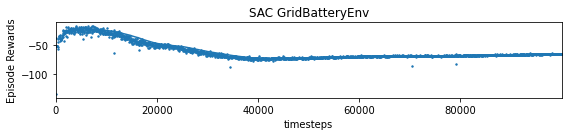

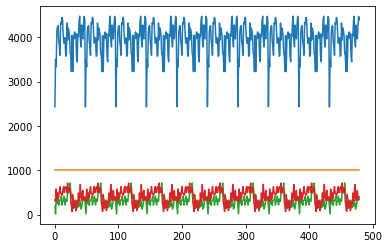

In [16]:
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 200  # Define your alpha_g
alpha_b = 200  # Define your alpha_b
alpha_T = 1000


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T

        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 0, 0]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)

    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty 
    
    
        power_balance_penalty = np.square(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 10000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*10000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*10000
    
        end_soc_penalty_weight = 10000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

# Instantiate the agent
model = SAC("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, verbose=1)

# Train the agent
model.learn(total_timesteps=1000000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
plt.savefig('learning_curve1.pdf')

# Plotting decision variables and SOC
n_eval_episodes = 10
obs = env.reset()
decision_variables = []
SOCs = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



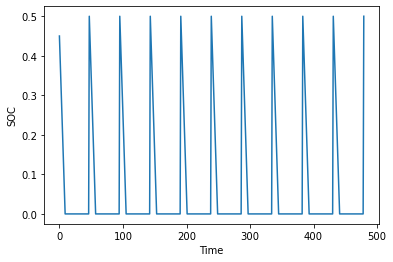

In [17]:
plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')


C:\Users\sesa512654\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -100     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 97       |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 55.6     |
|    critic_loss     | 1.62e+03 |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0283  |
|    learning_rate   | 1e-05    |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -93.1    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 60       |
|    time_elapsed    | 6        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 85.6     |
|    critic_loss     | 267     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.4    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 42       |
|    time_elapsed    | 71       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 444      |
|    critic_loss     | 809      |
|    ent_coef        | 1.03     |
|    ent_coef_loss   | -0.797   |
|    learning_rate   | 1e-05    |
|    n_updates       | 2971     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -64.2    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 42       |
|    time_elapsed    | 76       |
|    total_timesteps | 3264     |
| train/             |          |
|    actor_loss      | 481      |
|    critic_loss     | 1.38e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.3    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 43       |
|    time_elapsed    | 136      |
|    total_timesteps | 5952     |
| train/             |          |
|    actor_loss      | 731      |
|    critic_loss     | 7.59e+03 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -1.59    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5851     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.4    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 43       |
|    time_elapsed    | 141      |
|    total_timesteps | 6144     |
| train/             |          |
|    actor_loss      | 748      |
|    critic_loss     | 1.01e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58.6    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 43       |
|    time_elapsed    | 201      |
|    total_timesteps | 8832     |
| train/             |          |
|    actor_loss      | 978      |
|    critic_loss     | 1.68e+04 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -2.3     |
|    learning_rate   | 1e-05    |
|    n_updates       | 8731     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -58      |
| time/              |          |
|    episodes        | 188      |
|    fps             | 43       |
|    time_elapsed    | 205      |
|    total_timesteps | 9024     |
| train/             |          |
|    actor_loss      | 1.01e+03 |
|    critic_loss     | 1.27e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -49      |
| time/              |          |
|    episodes        | 244      |
|    fps             | 42       |
|    time_elapsed    | 277      |
|    total_timesteps | 11712    |
| train/             |          |
|    actor_loss      | 1.14e+03 |
|    critic_loss     | 1.44e+04 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -3.02    |
|    learning_rate   | 1e-05    |
|    n_updates       | 11611    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.4    |
| time/              |          |
|    episodes        | 248      |
|    fps             | 41       |
|    time_elapsed    | 284      |
|    total_timesteps | 11904    |
| train/             |          |
|    actor_loss      | 1.16e+03 |
|    critic_loss     | 9.15e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.3    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 42       |
|    time_elapsed    | 345      |
|    total_timesteps | 14592    |
| train/             |          |
|    actor_loss      | 1.28e+03 |
|    critic_loss     | 1.01e+04 |
|    ent_coef        | 1.15     |
|    ent_coef_loss   | -3.72    |
|    learning_rate   | 1e-05    |
|    n_updates       | 14491    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.5    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 42       |
|    time_elapsed    | 349      |
|    total_timesteps | 14784    |
| train/             |          |
|    actor_loss      | 1.25e+03 |
|    critic_loss     | 2.18e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.7    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 42       |
|    time_elapsed    | 408      |
|    total_timesteps | 17472    |
| train/             |          |
|    actor_loss      | 1.32e+03 |
|    critic_loss     | 1.74e+04 |
|    ent_coef        | 1.19     |
|    ent_coef_loss   | -4.52    |
|    learning_rate   | 1e-05    |
|    n_updates       | 17371    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.1    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 42       |
|    time_elapsed    | 412      |
|    total_timesteps | 17664    |
| train/             |          |
|    actor_loss      | 1.34e+03 |
|    critic_loss     | 3.52e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -43.8    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 43       |
|    time_elapsed    | 472      |
|    total_timesteps | 20352    |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 4.23e+04 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -5.34    |
|    learning_rate   | 1e-05    |
|    n_updates       | 20251    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.2    |
| time/              |          |
|    episodes        | 428      |
|    fps             | 43       |
|    time_elapsed    | 476      |
|    total_timesteps | 20544    |
| train/             |          |
|    actor_loss      | 1.39e+03 |
|    critic_loss     | 2.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.9    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 43       |
|    time_elapsed    | 534      |
|    total_timesteps | 23232    |
| train/             |          |
|    actor_loss      | 1.41e+03 |
|    critic_loss     | 3.11e+04 |
|    ent_coef        | 1.26     |
|    ent_coef_loss   | -6.16    |
|    learning_rate   | 1e-05    |
|    n_updates       | 23131    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.1    |
| time/              |          |
|    episodes        | 488      |
|    fps             | 43       |
|    time_elapsed    | 538      |
|    total_timesteps | 23424    |
| train/             |          |
|    actor_loss      | 1.47e+03 |
|    critic_loss     | 1.85e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.9    |
| time/              |          |
|    episodes        | 544      |
|    fps             | 43       |
|    time_elapsed    | 598      |
|    total_timesteps | 26112    |
| train/             |          |
|    actor_loss      | 1.41e+03 |
|    critic_loss     | 1.39e+04 |
|    ent_coef        | 1.29     |
|    ent_coef_loss   | -6.9     |
|    learning_rate   | 1e-05    |
|    n_updates       | 26011    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46      |
| time/              |          |
|    episodes        | 548      |
|    fps             | 43       |
|    time_elapsed    | 602      |
|    total_timesteps | 26304    |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 1.83e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.7    |
| time/              |          |
|    episodes        | 604      |
|    fps             | 43       |
|    time_elapsed    | 661      |
|    total_timesteps | 28992    |
| train/             |          |
|    actor_loss      | 1.43e+03 |
|    critic_loss     | 1.43e+04 |
|    ent_coef        | 1.33     |
|    ent_coef_loss   | -7.47    |
|    learning_rate   | 1e-05    |
|    n_updates       | 28891    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.6    |
| time/              |          |
|    episodes        | 608      |
|    fps             | 43       |
|    time_elapsed    | 665      |
|    total_timesteps | 29184    |
| train/             |          |
|    actor_loss      | 1.43e+03 |
|    critic_loss     | 1.71e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.9    |
| time/              |          |
|    episodes        | 664      |
|    fps             | 43       |
|    time_elapsed    | 724      |
|    total_timesteps | 31872    |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 1.05e+04 |
|    ent_coef        | 1.37     |
|    ent_coef_loss   | -8.25    |
|    learning_rate   | 1e-05    |
|    n_updates       | 31771    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.9    |
| time/              |          |
|    episodes        | 668      |
|    fps             | 43       |
|    time_elapsed    | 728      |
|    total_timesteps | 32064    |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 1.62e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.2    |
| time/              |          |
|    episodes        | 724      |
|    fps             | 44       |
|    time_elapsed    | 787      |
|    total_timesteps | 34752    |
| train/             |          |
|    actor_loss      | 1.39e+03 |
|    critic_loss     | 1.12e+04 |
|    ent_coef        | 1.41     |
|    ent_coef_loss   | -8.96    |
|    learning_rate   | 1e-05    |
|    n_updates       | 34651    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.3    |
| time/              |          |
|    episodes        | 728      |
|    fps             | 44       |
|    time_elapsed    | 791      |
|    total_timesteps | 34944    |
| train/             |          |
|    actor_loss      | 1.42e+03 |
|    critic_loss     | 1.09e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.8    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 44       |
|    time_elapsed    | 849      |
|    total_timesteps | 37632    |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 1.04e+04 |
|    ent_coef        | 1.45     |
|    ent_coef_loss   | -9.57    |
|    learning_rate   | 1e-05    |
|    n_updates       | 37531    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.6    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 44       |
|    time_elapsed    | 854      |
|    total_timesteps | 37824    |
| train/             |          |
|    actor_loss      | 1.42e+03 |
|    critic_loss     | 5.65e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.2    |
| time/              |          |
|    episodes        | 844      |
|    fps             | 44       |
|    time_elapsed    | 913      |
|    total_timesteps | 40512    |
| train/             |          |
|    actor_loss      | 1.39e+03 |
|    critic_loss     | 5.19e+03 |
|    ent_coef        | 1.49     |
|    ent_coef_loss   | -10.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 40411    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -45.4    |
| time/              |          |
|    episodes        | 848      |
|    fps             | 44       |
|    time_elapsed    | 917      |
|    total_timesteps | 40704    |
| train/             |          |
|    actor_loss      | 1.34e+03 |
|    critic_loss     | 7.34e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.3    |
| time/              |          |
|    episodes        | 904      |
|    fps             | 44       |
|    time_elapsed    | 976      |
|    total_timesteps | 43392    |
| train/             |          |
|    actor_loss      | 1.38e+03 |
|    critic_loss     | 5.29e+03 |
|    ent_coef        | 1.54     |
|    ent_coef_loss   | -11.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 43291    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -46.2    |
| time/              |          |
|    episodes        | 908      |
|    fps             | 44       |
|    time_elapsed    | 980      |
|    total_timesteps | 43584    |
| train/             |          |
|    actor_loss      | 1.39e+03 |
|    critic_loss     | 5.33e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.5    |
| time/              |          |
|    episodes        | 964      |
|    fps             | 44       |
|    time_elapsed    | 1040     |
|    total_timesteps | 46272    |
| train/             |          |
|    actor_loss      | 1.36e+03 |
|    critic_loss     | 3.42e+03 |
|    ent_coef        | 1.58     |
|    ent_coef_loss   | -12.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 46171    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -44.2    |
| time/              |          |
|    episodes        | 968      |
|    fps             | 44       |
|    time_elapsed    | 1044     |
|    total_timesteps | 46464    |
| train/             |          |
|    actor_loss      | 1.35e+03 |
|    critic_loss     | 3.25e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -41.4    |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 44       |
|    time_elapsed    | 1103     |
|    total_timesteps | 49152    |
| train/             |          |
|    actor_loss      | 1.24e+03 |
|    critic_loss     | 2.03e+03 |
|    ent_coef        | 1.63     |
|    ent_coef_loss   | -13.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 49051    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -41.2    |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 44       |
|    time_elapsed    | 1107     |
|    total_timesteps | 49344    |
| train/             |          |
|    actor_loss      | 1.26e+03 |
|    critic_loss     | 1.79e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.4    |
| time/              |          |
|    episodes        | 1084     |
|    fps             | 44       |
|    time_elapsed    | 1166     |
|    total_timesteps | 52032    |
| train/             |          |
|    actor_loss      | 1.31e+03 |
|    critic_loss     | 1.93e+03 |
|    ent_coef        | 1.68     |
|    ent_coef_loss   | -13.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 51931    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.4    |
| time/              |          |
|    episodes        | 1088     |
|    fps             | 44       |
|    time_elapsed    | 1170     |
|    total_timesteps | 52224    |
| train/             |          |
|    actor_loss      | 1.26e+03 |
|    critic_loss     | 1.9e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.6    |
| time/              |          |
|    episodes        | 1144     |
|    fps             | 44       |
|    time_elapsed    | 1230     |
|    total_timesteps | 54912    |
| train/             |          |
|    actor_loss      | 1.23e+03 |
|    critic_loss     | 1.96e+03 |
|    ent_coef        | 1.73     |
|    ent_coef_loss   | -14.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 54811    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.5    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 44       |
|    time_elapsed    | 1234     |
|    total_timesteps | 55104    |
| train/             |          |
|    actor_loss      | 1.34e+03 |
|    critic_loss     | 1.95e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.9    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 44       |
|    time_elapsed    | 1292     |
|    total_timesteps | 57792    |
| train/             |          |
|    actor_loss      | 1.37e+03 |
|    critic_loss     | 2.78e+03 |
|    ent_coef        | 1.78     |
|    ent_coef_loss   | -15.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 57691    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.9    |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 44       |
|    time_elapsed    | 1296     |
|    total_timesteps | 57984    |
| train/             |          |
|    actor_loss      | 1.34e+03 |
|    critic_loss     | 2.49e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.3    |
| time/              |          |
|    episodes        | 1264     |
|    fps             | 44       |
|    time_elapsed    | 1355     |
|    total_timesteps | 60672    |
| train/             |          |
|    actor_loss      | 1.29e+03 |
|    critic_loss     | 1.88e+03 |
|    ent_coef        | 1.83     |
|    ent_coef_loss   | -16.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 60571    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.4    |
| time/              |          |
|    episodes        | 1268     |
|    fps             | 44       |
|    time_elapsed    | 1359     |
|    total_timesteps | 60864    |
| train/             |          |
|    actor_loss      | 1.31e+03 |
|    critic_loss     | 2.24e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.6    |
| time/              |          |
|    episodes        | 1324     |
|    fps             | 44       |
|    time_elapsed    | 1418     |
|    total_timesteps | 63552    |
| train/             |          |
|    actor_loss      | 1.38e+03 |
|    critic_loss     | 1.85e+03 |
|    ent_coef        | 1.88     |
|    ent_coef_loss   | -16.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 63451    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.5    |
| time/              |          |
|    episodes        | 1328     |
|    fps             | 44       |
|    time_elapsed    | 1422     |
|    total_timesteps | 63744    |
| train/             |          |
|    actor_loss      | 1.37e+03 |
|    critic_loss     | 2.43e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.1    |
| time/              |          |
|    episodes        | 1384     |
|    fps             | 44       |
|    time_elapsed    | 1480     |
|    total_timesteps | 66432    |
| train/             |          |
|    actor_loss      | 1.37e+03 |
|    critic_loss     | 1.61e+03 |
|    ent_coef        | 1.94     |
|    ent_coef_loss   | -17.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 66331    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33.3    |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 44       |
|    time_elapsed    | 1485     |
|    total_timesteps | 66624    |
| train/             |          |
|    actor_loss      | 1.48e+03 |
|    critic_loss     | 2.2e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 44       |
|    time_elapsed    | 1544     |
|    total_timesteps | 69312    |
| train/             |          |
|    actor_loss      | 1.46e+03 |
|    critic_loss     | 1.9e+03  |
|    ent_coef        | 1.99     |
|    ent_coef_loss   | -17.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 69211    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.1    |
| time/              |          |
|    episodes        | 1448     |
|    fps             | 44       |
|    time_elapsed    | 1548     |
|    total_timesteps | 69504    |
| train/             |          |
|    actor_loss      | 1.45e+03 |
|    critic_loss     | 2.08e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.8    |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 44       |
|    time_elapsed    | 1607     |
|    total_timesteps | 72192    |
| train/             |          |
|    actor_loss      | 1.41e+03 |
|    critic_loss     | 1.87e+03 |
|    ent_coef        | 2.05     |
|    ent_coef_loss   | -19.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 72091    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37      |
| time/              |          |
|    episodes        | 1508     |
|    fps             | 44       |
|    time_elapsed    | 1611     |
|    total_timesteps | 72384    |
| train/             |          |
|    actor_loss      | 1.48e+03 |
|    critic_loss     | 2.03e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.5    |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 44       |
|    time_elapsed    | 1669     |
|    total_timesteps | 75072    |
| train/             |          |
|    actor_loss      | 1.47e+03 |
|    critic_loss     | 1.57e+03 |
|    ent_coef        | 2.11     |
|    ent_coef_loss   | -19.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 74971    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.4    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 44       |
|    time_elapsed    | 1673     |
|    total_timesteps | 75264    |
| train/             |          |
|    actor_loss      | 1.51e+03 |
|    critic_loss     | 1.56e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38      |
| time/              |          |
|    episodes        | 1624     |
|    fps             | 44       |
|    time_elapsed    | 1732     |
|    total_timesteps | 77952    |
| train/             |          |
|    actor_loss      | 1.56e+03 |
|    critic_loss     | 1.19e+03 |
|    ent_coef        | 2.17     |
|    ent_coef_loss   | -20.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 77851    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38      |
| time/              |          |
|    episodes        | 1628     |
|    fps             | 44       |
|    time_elapsed    | 1736     |
|    total_timesteps | 78144    |
| train/             |          |
|    actor_loss      | 1.49e+03 |
|    critic_loss     | 1.09e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.5    |
| time/              |          |
|    episodes        | 1684     |
|    fps             | 45       |
|    time_elapsed    | 1795     |
|    total_timesteps | 80832    |
| train/             |          |
|    actor_loss      | 1.58e+03 |
|    critic_loss     | 2.13e+03 |
|    ent_coef        | 2.24     |
|    ent_coef_loss   | -20.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 80731    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.9    |
| time/              |          |
|    episodes        | 1688     |
|    fps             | 45       |
|    time_elapsed    | 1799     |
|    total_timesteps | 81024    |
| train/             |          |
|    actor_loss      | 1.5e+03  |
|    critic_loss     | 1.53e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.8    |
| time/              |          |
|    episodes        | 1744     |
|    fps             | 45       |
|    time_elapsed    | 1859     |
|    total_timesteps | 83712    |
| train/             |          |
|    actor_loss      | 1.53e+03 |
|    critic_loss     | 1.36e+03 |
|    ent_coef        | 2.3      |
|    ent_coef_loss   | -22.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 83611    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.5    |
| time/              |          |
|    episodes        | 1748     |
|    fps             | 45       |
|    time_elapsed    | 1863     |
|    total_timesteps | 83904    |
| train/             |          |
|    actor_loss      | 1.56e+03 |
|    critic_loss     | 1.25e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.1    |
| time/              |          |
|    episodes        | 1804     |
|    fps             | 44       |
|    time_elapsed    | 1925     |
|    total_timesteps | 86592    |
| train/             |          |
|    actor_loss      | 1.58e+03 |
|    critic_loss     | 1.05e+03 |
|    ent_coef        | 2.37     |
|    ent_coef_loss   | -23.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 86491    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.1    |
| time/              |          |
|    episodes        | 1808     |
|    fps             | 44       |
|    time_elapsed    | 1929     |
|    total_timesteps | 86784    |
| train/             |          |
|    actor_loss      | 1.64e+03 |
|    critic_loss     | 1.34e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.4    |
| time/              |          |
|    episodes        | 1864     |
|    fps             | 44       |
|    time_elapsed    | 1990     |
|    total_timesteps | 89472    |
| train/             |          |
|    actor_loss      | 1.61e+03 |
|    critic_loss     | 1.74e+03 |
|    ent_coef        | 2.44     |
|    ent_coef_loss   | -23.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 89371    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.3    |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 44       |
|    time_elapsed    | 1994     |
|    total_timesteps | 89664    |
| train/             |          |
|    actor_loss      | 1.74e+03 |
|    critic_loss     | 1.93e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.8    |
| time/              |          |
|    episodes        | 1924     |
|    fps             | 44       |
|    time_elapsed    | 2053     |
|    total_timesteps | 92352    |
| train/             |          |
|    actor_loss      | 1.63e+03 |
|    critic_loss     | 1.55e+03 |
|    ent_coef        | 2.51     |
|    ent_coef_loss   | -23.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 92251    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.8    |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 44       |
|    time_elapsed    | 2057     |
|    total_timesteps | 92544    |
| train/             |          |
|    actor_loss      | 1.72e+03 |
|    critic_loss     | 1.25e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.9    |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 44       |
|    time_elapsed    | 2116     |
|    total_timesteps | 95232    |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 1.27e+03 |
|    ent_coef        | 2.58     |
|    ent_coef_loss   | -25.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 95131    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.8    |
| time/              |          |
|    episodes        | 1988     |
|    fps             | 44       |
|    time_elapsed    | 2121     |
|    total_timesteps | 95424    |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 1.65e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.5    |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 44       |
|    time_elapsed    | 2181     |
|    total_timesteps | 98112    |
| train/             |          |
|    actor_loss      | 1.76e+03 |
|    critic_loss     | 1.53e+03 |
|    ent_coef        | 2.66     |
|    ent_coef_loss   | -25.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 98011    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.4    |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 44       |
|    time_elapsed    | 2185     |
|    total_timesteps | 98304    |
| train/             |          |
|    actor_loss      | 1.88e+03 |
|    critic_loss     | 1.15e+03 |
|    ent_coef 

Action: [[ 4984.0737 -1000.       868.1754  1000.    ]]
Action: [[ 4588.5825  -1000.        817.64886  1000.     ]]
Action: [[ 4936.821 -1000.      854.832  1000.   ]]
Action: [[ 4997.762   -1000.        886.44684  1000.     ]]
Action: [[ 4997.709  -1000.       905.5512  1000.    ]]
Action: [[ 4995.997   -1000.        909.46844  1000.     ]]
Action: [[ 4995.3896 -1000.       876.9759  1000.    ]]
Action: [[ 4995.0664 -1000.       873.8288  1000.    ]]
Action: [[ 4996.137  -1000.       844.9679  1000.    ]]
Action: [[ 4997.7974 -1000.       786.59    1000.    ]]
Action: [[ 4998.722  -1000.       807.4255  1000.    ]]
Action: [[ 4998.3613  -1000.        912.77954  1000.     ]]
Action: [[ 4998.199  -1000.       886.1254  1000.    ]]
Action: [[ 4998.179  -1000.       856.6423  1000.    ]]
Action: [[ 4995.8716  -1000.        911.91565  1000.     ]]
Action: [[ 4995.937   -1000.        808.22626  1000.     ]]
Action: [[ 4988.231   -1000.        822.24084  1000.     ]]
Action: [[ 4966.946   -1

Action: [[ 4954.6997  -1000.        826.77563  1000.     ]]
Action: [[ 4945.568 -1000.      936.802  1000.   ]]
Action: [[ 4969.1426  -1000.        844.74585  1000.     ]]
Action: [[ 4960.3696  -1000.        896.03436  1000.     ]]
Action: [[ 4973.6147 -1000.       868.9575  1000.    ]]
Action: [[ 4994.329   -1000.        851.27057  1000.     ]]
Action: [[ 4984.0737 -1000.       868.1754  1000.    ]]
Action: [[ 4588.5825  -1000.        817.64886  1000.     ]]
Action: [[ 4936.821 -1000.      854.832  1000.   ]]
Action: [[ 4997.762   -1000.        886.44684  1000.     ]]
Action: [[ 4997.709  -1000.       905.5512  1000.    ]]
Action: [[ 4995.997   -1000.        909.46844  1000.     ]]
Action: [[ 4995.3896 -1000.       876.9759  1000.    ]]
Action: [[ 4995.0664 -1000.       873.8288  1000.    ]]
Action: [[ 4996.137  -1000.       844.9679  1000.    ]]
Action: [[ 4997.7974 -1000.       786.59    1000.    ]]
Action: [[ 4998.722  -1000.       807.4255  1000.    ]]
Action: [[ 4998.3613  -1000.

IndexError: index 1 is out of bounds for axis 1 with size 1

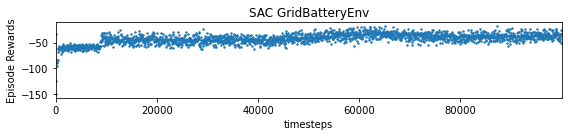

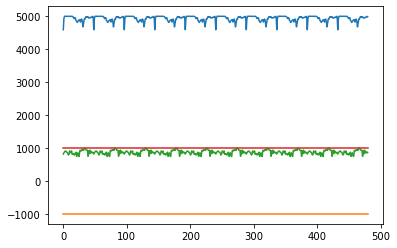

In [18]:
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 200  # Define your alpha_g
alpha_b = 200  # Define your alpha_b
alpha_T = 1000


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T

        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 0, 0]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)

    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty 
    
    
        power_balance_penalty = np.square(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 10000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*10000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*10000
    
        end_soc_penalty_weight = 10000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

# Instantiate the agent
model = SAC("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
plt.savefig('learning_curve2.pdf')

# Plotting decision variables and SOC
n_eval_episodes = 10
obs = env.reset()
decision_variables = []
SOCs = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs2)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



In [63]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 200  # Define your alpha_g
alpha_b = 200  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 50000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 1000000
    
    
        power_balance_penalty = np.square(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 1000000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*1000000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*1000000
    
        end_soc_penalty_weight = 1000000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.5, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

# Instantiate the agent
model = SAC("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, verbose=1,seed=seed_value)

# Train the agent
model.learn(total_timesteps=10000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
plt.savefig('learning_curve2.pdf')

# Plotting decision variables and SOC
n_eval_episodes = 5
obs = env.reset()
decision_variables = []
SOCs = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



C:\Users\sesa512654\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -79      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 103      |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 795      |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0254  |
|    learning_rate   | 1e-05    |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.8    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 67       |
|    time_elapsed    | 5        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 35.8     |
|    critic_loss     | 268     

KeyboardInterrupt: 

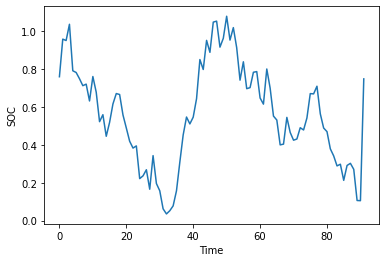

In [166]:
plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | 96.6     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2        |
|    time_elapsed    | 132      |
|    total_timesteps | 386      |
| train/             |          |
|    actor_loss      | 23.6     |
|    critic_loss     | 282      |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.062   |
|    learning_rate   | 1e-05    |
|    n_updates       | 285      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | 117      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 199      |
|    total_timesteps | 772      |
| train/             |          |
|    actor_loss      | 64.1     |
|    critic_loss     | 125     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 152      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 5        |
|    time_elapsed    | 1123     |
|    total_timesteps | 6026     |
| train/             |          |
|    actor_loss      | 547      |
|    critic_loss     | 2.23e+03 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5925     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94       |
|    ep_rew_mean     | 153      |
| time/              |          |
|    episodes        | 68       |
|    fps             | 5        |
|    time_elapsed    | 1187     |
|    total_timesteps | 6389     |
| train/             |          |
|    actor_loss      | 567      |
|    critic_loss     | 2.99e+03 |
|    ent_coef 

C:\Users\sesa512654\Anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=96.59 +/- 44.43
Episode length: 94.40 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 94.4     |
|    mean_reward     | 96.6     |
| time/              |          |
|    total_timesteps | 500      |
| train/             |          |
|    actor_loss      | 831      |
|    critic_loss     | 5.83e+03 |
|    ent_coef        | 1.1      |
|    ent_coef_loss   | -1.99    |
|    learning_rate   | 1e-05    |
|    n_updates       | 10299    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.1     |
|    ep_rew_mean     | 135      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 6        |
|    time_elapsed    | 112      |
|    total_timesteps | 705      |
| train/             |          |
|    actor_loss      | 835      |
|    critic_loss     | 5.34e+03 |
|    ent

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.1     |
|    ep_rew_mean     | 155      |
| time/              |          |
|    episodes        | 40       |
|    fps             | 5        |
|    time_elapsed    | 679      |
|    total_timesteps | 3723     |
| train/             |          |
|    actor_loss      | 1.01e+03 |
|    critic_loss     | 8.68e+03 |
|    ent_coef        | 1.14     |
|    ent_coef_loss   | -2.66    |
|    learning_rate   | 1e-05    |
|    n_updates       | 13522    |
---------------------------------
Eval num_timesteps=4000, episode_reward=54.02 +/- 7.23
Episode length: 93.40 +/- 8.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 93.4     |
|    mean_reward     | 54       |
| time/              |          |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.02e+03 |
|    critic_loss     | 8.91e+03 |
|    ent_coef        | 1.14   

Eval num_timesteps=7000, episode_reward=51.37 +/- 5.28
Episode length: 90.40 +/- 3.98
---------------------------------
| eval/              |          |
|    mean_ep_length  | 90.4     |
|    mean_reward     | 51.4     |
| time/              |          |
|    total_timesteps | 7000     |
| train/             |          |
|    actor_loss      | 1.16e+03 |
|    critic_loss     | 1.23e+04 |
|    ent_coef        | 1.18     |
|    ent_coef_loss   | -3.37    |
|    learning_rate   | 1e-05    |
|    n_updates       | 16799    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 158      |
| time/              |          |
|    episodes        | 76       |
|    fps             | 5        |
|    time_elapsed    | 1331     |
|    total_timesteps | 7156     |
| train/             |          |
|    actor_loss      | 1.16e+03 |
|    critic_loss     | 1.36e+04 |
|    ent_coef        | 1.18   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.8     |
|    ep_rew_mean     | 158      |
| time/              |          |
|    episodes        | 108      |
|    fps             | 5        |
|    time_elapsed    | 1893     |
|    total_timesteps | 10088    |
| train/             |          |
|    actor_loss      | 1.3e+03  |
|    critic_loss     | 1.4e+04  |
|    ent_coef        | 1.21     |
|    ent_coef_loss   | -4.01    |
|    learning_rate   | 1e-05    |
|    n_updates       | 19887    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94       |
|    ep_rew_mean     | 158      |
| time/              |          |
|    episodes        | 112      |
|    fps             | 5        |
|    time_elapsed    | 1964     |
|    total_timesteps | 10465    |
| train/             |          |
|    actor_loss      | 1.32e+03 |
|    critic_loss     | 1.29e+04 |
|    ent_coef 

Eval num_timesteps=13500, episode_reward=108.02 +/- 14.31
Episode length: 102.00 +/- 13.90
---------------------------------
| eval/              |          |
|    mean_ep_length  | 102      |
|    mean_reward     | 108      |
| time/              |          |
|    total_timesteps | 13500    |
| train/             |          |
|    actor_loss      | 1.43e+03 |
|    critic_loss     | 2.07e+04 |
|    ent_coef        | 1.26     |
|    ent_coef_loss   | -4.77    |
|    learning_rate   | 1e-05    |
|    n_updates       | 23299    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 157      |
| time/              |          |
|    episodes        | 144      |
|    fps             | 5        |
|    time_elapsed    | 2550     |
|    total_timesteps | 13549    |
| train/             |          |
|    actor_loss      | 1.44e+03 |
|    critic_loss     | 1.78e+04 |
|  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 155      |
| time/              |          |
|    episodes        | 176      |
|    fps             | 5        |
|    time_elapsed    | 3134     |
|    total_timesteps | 16605    |
| train/             |          |
|    actor_loss      | 1.52e+03 |
|    critic_loss     | 2.06e+04 |
|    ent_coef        | 1.3      |
|    ent_coef_loss   | -5.43    |
|    learning_rate   | 1e-05    |
|    n_updates       | 26404    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 154      |
| time/              |          |
|    episodes        | 180      |
|    fps             | 5        |
|    time_elapsed    | 3206     |
|    total_timesteps | 16984    |
| train/             |          |
|    actor_loss      | 1.54e+03 |
|    critic_loss     | 2.13e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94       |
|    ep_rew_mean     | 151      |
| time/              |          |
|    episodes        | 212      |
|    fps             | 5        |
|    time_elapsed    | 3760     |
|    total_timesteps | 19870    |
| train/             |          |
|    actor_loss      | 1.62e+03 |
|    critic_loss     | 2.41e+04 |
|    ent_coef        | 1.34     |
|    ent_coef_loss   | -6.24    |
|    learning_rate   | 1e-05    |
|    n_updates       | 29669    |
---------------------------------
Eval num_timesteps=20000, episode_reward=156.99 +/- 31.53
Episode length: 97.00 +/- 17.29
---------------------------------
| eval/              |          |
|    mean_ep_length  | 97       |
|    mean_reward     | 157      |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | 1.61e+03 |
|    critic_loss     | 2.43e+04 |
|    ent_coef        | 1.3

Eval num_timesteps=23000, episode_reward=114.79 +/- 13.50
Episode length: 96.60 +/- 6.71
---------------------------------
| eval/              |          |
|    mean_ep_length  | 96.6     |
|    mean_reward     | 115      |
| time/              |          |
|    total_timesteps | 23000    |
| train/             |          |
|    actor_loss      | 1.69e+03 |
|    critic_loss     | 2.25e+04 |
|    ent_coef        | 1.38     |
|    ent_coef_loss   | -6.83    |
|    learning_rate   | 1e-05    |
|    n_updates       | 32799    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.7     |
|    ep_rew_mean     | 148      |
| time/              |          |
|    episodes        | 248      |
|    fps             | 5        |
|    time_elapsed    | 4417     |
|    total_timesteps | 23293    |
| train/             |          |
|    actor_loss      | 1.69e+03 |
|    critic_loss     | 2.41e+04 |
|    ent_coef        | 1.39

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.5     |
|    ep_rew_mean     | 144      |
| time/              |          |
|    episodes        | 280      |
|    fps             | 5        |
|    time_elapsed    | 4999     |
|    total_timesteps | 26333    |
| train/             |          |
|    actor_loss      | 1.75e+03 |
|    critic_loss     | 2.73e+04 |
|    ent_coef        | 1.43     |
|    ent_coef_loss   | -7.54    |
|    learning_rate   | 1e-05    |
|    n_updates       | 36132    |
---------------------------------
Eval num_timesteps=26500, episode_reward=161.33 +/- 13.84
Episode length: 100.80 +/- 8.91
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 161      |
| time/              |          |
|    total_timesteps | 26500    |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 2.58e+04 |
|    ent_coef        | 1.4

Eval num_timesteps=29500, episode_reward=165.09 +/- 18.11
Episode length: 98.40 +/- 12.86
---------------------------------
| eval/              |          |
|    mean_ep_length  | 98.4     |
|    mean_reward     | 165      |
| time/              |          |
|    total_timesteps | 29500    |
| train/             |          |
|    actor_loss      | 1.82e+03 |
|    critic_loss     | 2.76e+04 |
|    ent_coef        | 1.47     |
|    ent_coef_loss   | -8.35    |
|    learning_rate   | 1e-05    |
|    n_updates       | 39299    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95       |
|    ep_rew_mean     | 146      |
| time/              |          |
|    episodes        | 316      |
|    fps             | 5        |
|    time_elapsed    | 5655     |
|    total_timesteps | 29751    |
| train/             |          |
|    actor_loss      | 1.83e+03 |
|    critic_loss     | 2.56e+04 |
|   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 146      |
| time/              |          |
|    episodes        | 348      |
|    fps             | 5        |
|    time_elapsed    | 6236     |
|    total_timesteps | 32776    |
| train/             |          |
|    actor_loss      | 1.89e+03 |
|    critic_loss     | 2.51e+04 |
|    ent_coef        | 1.52     |
|    ent_coef_loss   | -9.02    |
|    learning_rate   | 1e-05    |
|    n_updates       | 42575    |
---------------------------------
Eval num_timesteps=33000, episode_reward=148.66 +/- 6.66
Episode length: 90.40 +/- 3.61
---------------------------------
| eval/              |          |
|    mean_ep_length  | 90.4     |
|    mean_reward     | 149      |
| time/              |          |
|    total_timesteps | 33000    |
| train/             |          |
|    actor_loss      | 1.9e+03  |
|    critic_loss     | 2.56e+04 |
|    ent_coef        | 1.53 

Eval num_timesteps=36000, episode_reward=143.62 +/- 10.54
Episode length: 99.40 +/- 10.09
---------------------------------
| eval/              |          |
|    mean_ep_length  | 99.4     |
|    mean_reward     | 144      |
| time/              |          |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 2.6e+04  |
|    ent_coef        | 1.57     |
|    ent_coef_loss   | -9.59    |
|    learning_rate   | 1e-05    |
|    n_updates       | 45799    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.9     |
|    ep_rew_mean     | 149      |
| time/              |          |
|    episodes        | 384      |
|    fps             | 5        |
|    time_elapsed    | 6888     |
|    total_timesteps | 36173    |
| train/             |          |
|    actor_loss      | 1.95e+03 |
|    critic_loss     | 2.61e+04 |
|    ent_coef        | 1.5

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 151      |
| time/              |          |
|    episodes        | 416      |
|    fps             | 5        |
|    time_elapsed    | 7471     |
|    total_timesteps | 39215    |
| train/             |          |
|    actor_loss      | 2.02e+03 |
|    critic_loss     | 2.45e+04 |
|    ent_coef        | 1.63     |
|    ent_coef_loss   | -10.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 49014    |
---------------------------------
Eval num_timesteps=39500, episode_reward=108.16 +/- 20.38
Episode length: 89.60 +/- 14.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 89.6     |
|    mean_reward     | 108      |
| time/              |          |
|    total_timesteps | 39500    |
| train/             |          |
|    actor_loss      | 2.01e+03 |
|    critic_loss     | 2.33e+04 |
|    ent_coef        | 1.6

Eval num_timesteps=42500, episode_reward=100.66 +/- 10.95
Episode length: 94.00 +/- 8.88
---------------------------------
| eval/              |          |
|    mean_ep_length  | 94       |
|    mean_reward     | 101      |
| time/              |          |
|    total_timesteps | 42500    |
| train/             |          |
|    actor_loss      | 2.07e+03 |
|    critic_loss     | 2.67e+04 |
|    ent_coef        | 1.68     |
|    ent_coef_loss   | -10.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 52299    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95       |
|    ep_rew_mean     | 157      |
| time/              |          |
|    episodes        | 452      |
|    fps             | 5        |
|    time_elapsed    | 8145     |
|    total_timesteps | 42677    |
| train/             |          |
|    actor_loss      | 2.08e+03 |
|    critic_loss     | 2.47e+04 |
|    ent_coef        | 1.68

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | 164      |
| time/              |          |
|    episodes        | 484      |
|    fps             | 5        |
|    time_elapsed    | 8742     |
|    total_timesteps | 45776    |
| train/             |          |
|    actor_loss      | 2.13e+03 |
|    critic_loss     | 2.2e+04  |
|    ent_coef        | 1.74     |
|    ent_coef_loss   | -11.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 55575    |
---------------------------------
Eval num_timesteps=46000, episode_reward=153.65 +/- 20.70
Episode length: 94.40 +/- 8.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 94.4     |
|    mean_reward     | 154      |
| time/              |          |
|    total_timesteps | 46000    |
| train/             |          |
|    actor_loss      | 2.12e+03 |
|    critic_loss     | 2.28e+04 |
|    ent_coef        | 1.74

Eval num_timesteps=49000, episode_reward=159.85 +/- 5.58
Episode length: 90.80 +/- 1.60
---------------------------------
| eval/              |          |
|    mean_ep_length  | 90.8     |
|    mean_reward     | 160      |
| time/              |          |
|    total_timesteps | 49000    |
| train/             |          |
|    actor_loss      | 2.12e+03 |
|    critic_loss     | 2.18e+04 |
|    ent_coef        | 1.79     |
|    ent_coef_loss   | -12.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 58799    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.3     |
|    ep_rew_mean     | 170      |
| time/              |          |
|    episodes        | 520      |
|    fps             | 5        |
|    time_elapsed    | 9405     |
|    total_timesteps | 49219    |
| train/             |          |
|    actor_loss      | 2.12e+03 |
|    critic_loss     | 2.39e+04 |
|    ent_coef        | 1.8  

IndexError: index 1 is out of bounds for axis 1 with size 1

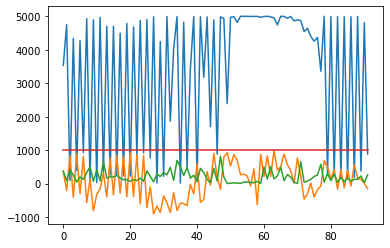

In [165]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=15, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=500, high=1500, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    


    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action
        
            # Add Gaussian noise to the action
        noise = np.random.normal(loc=0, scale=0.1, size=4)  # Adjust scale for different noise levels
        Pg += noise[0]
        Pb += noise[1]
        alpha_g_action += noise[2]
        alpha_b_action += noise[3]

        # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)
        
        
        alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
        
        alpha_g_penalty = alpha_g_penalty_weight * alpha_g_action * self.Cg_t[t]
    
    
    # Add a penalty term to enforce SOC at the end of the period to be above 0.8

        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]
                # Heavily penalize overcharging
        

       # soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
       # alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 10

        power_balance_penalty = self.P_d[t] - ((Pg + Pb) - self.P_pv[t])
      
        
        
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))

        # Advanced reward shaping
        delta_Pg = Pg - self.Pg_max / 2
        delta_Pb = Pb - self.Pb_max / 2
        delta_alpha_g = alpha_g_action - self.alpha_g / 2
        delta_alpha_b = alpha_b_action - self.alpha_b / 2
        shaping_reward = - 0.01 * (delta_Pg**2 + delta_Pb**2 + delta_alpha_g**2 + delta_alpha_b**2)

        end_soc_penalty_weight = 10 # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        # Add weights to each term of the reward function
        power_balance_weight = 10 # adjust these weights as needed
        alpha_g_penalty_weight = 10
        alpha_b_penalty_weight = 10

        reward = -(power_balance_weight * power_balance_penalty + 
                    alpha_g_penalty_weight * alpha_g_penalty +
                    alpha_b_penalty_weight * alpha_b_penalty +
                   # alpha_b_penalty_soc +
                    end_soc_penalty +
                    shaping_reward)  # Add shaping_reward to the total reward
        
        if SOC_new > 0.8:
            reward -= 10
            
        if SOC_new < 1.0:
            reward -= 10

        # Heavily penalize undercharging
        if SOC_new < 0.2:
            reward -= 10
            
        if power_balance_penalty > 0:
            reward -= 10
            
        if power_balance_penalty < 0:
            reward -= 10
            
            
  
        if reward < 0:
             reward -= 10

            
            
            

        # Add an exploration bonus
        exploration_bonus = np.random.normal(0, 0.1)  # adjust the scale of the bonus as needed
        reward += exploration_bonus

        # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
           # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t+1] if t < 47 else 0, self.P_pv[t+1] if t < 47 else 0, self.Cg_t[t+1] if t < 47 else 0, self.Cb_t[t+1] if t < 47 else 0])
         # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise
        done = t >= 47

        return self.state, reward, done, {}



    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        
        
        # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise

        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)



# Create an evaluation environment
eval_env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Create the callback
eval_callback = EvalCallback(eval_env, best_model_save_path='./models/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)



from stable_baselines3.common.utils import get_linear_fn

#initial_lr = 0.0003
#final_lr = 0.00003
#lr_schedule = get_linear_fn(initial_lr, final_lr, 1000000)

#model = SAC("MlpPolicy", env, learning_rate=lr_schedule, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1, seed=seed_value)




#model = SAC("MlpPolicy", env, learning_rate=0.000001, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1,seed=seed_value)
    
from stable_baselines3.common.callbacks import BaseCallback

class LearningRateScheduler(BaseCallback):
    def __init__(self, initial_lr, total_timesteps, lr_schedule, verbose=0):
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_lr = initial_lr
        self.total_timesteps = total_timesteps
        self.lr_schedule = lr_schedule

    def _on_step(self):
        fraction_done = self.num_timesteps / self.total_timesteps
        new_lr = self.initial_lr * self.lr_schedule(fraction_done)
        self.model.learning_rate = new_lr
        return True

# You can define your scheduler function, for example, a linear decreasing schedule
def linear_schedule(fraction_done):
    return 1 - fraction_done

initial_learning_rate = 0.00001
total_timesteps = 10000
lr_scheduler = LearningRateScheduler(initial_learning_rate, total_timesteps, linear_schedule)

model = SAC("MlpPolicy", env, 
            learning_rate=initial_learning_rate,
            buffer_size=1000000,  
            batch_size=4096,
            gamma=0.99, 
            tau=0.005, 
            ent_coef='auto',  
            target_update_interval=1, 
            gradient_steps=1, 
            target_entropy='auto', 
            use_sde=False, 
            sde_sample_freq=-1, 
            verbose=1,
            seed=seed_value)

model.learn(total_timesteps=total_timesteps, callback=lr_scheduler)


    
    
    
    
from stable_baselines3 import A2C

#model = A2C("MlpPolicy", env, learning_rate=0.0001, buffer_size=1024, batch_size=512, 
           # gamma=0.99, use_sde=False, verbose=1, seed=seed_value)
            

model.learn(total_timesteps=50000, callback=eval_callback)

# Train the agent
#model.learn(total_timesteps=9500)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
#results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
#plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



C:\Users\sesa512654\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -254     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 6        |
|    time_elapsed    | 55       |
|    total_timesteps | 386      |
| train/             |          |
|    actor_loss      | 30.7     |
|    critic_loss     | 271      |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0619  |
|    learning_rate   | 1e-05    |
|    n_updates       | 285      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -226     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 5        |
|    time_elapsed    | 135      |
|    total_timesteps | 772      |
| train/             |          |
|    actor_loss      | 77.8     |
|    critic_loss     | 133     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | -114     |
| time/              |          |
|    episodes        | 64       |
|    fps             | 5        |
|    time_elapsed    | 1193     |
|    total_timesteps | 6026     |
| train/             |          |
|    actor_loss      | 617      |
|    critic_loss     | 2.88e+03 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5925     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94       |
|    ep_rew_mean     | -112     |
| time/              |          |
|    episodes        | 68       |
|    fps             | 5        |
|    time_elapsed    | 1271     |
|    total_timesteps | 6389     |
| train/             |          |
|    actor_loss      | 640      |
|    critic_loss     | 3.87e+03 |
|    ent_coef 

C:\Users\sesa512654\Anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=-97.79 +/- 43.08
Episode length: 94.40 +/- 5.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 94.4     |
|    mean_reward     | -97.8    |
| time/              |          |
|    total_timesteps | 500      |
| train/             |          |
|    actor_loss      | 928      |
|    critic_loss     | 7.36e+03 |
|    ent_coef        | 1.1      |
|    ent_coef_loss   | -1.99    |
|    learning_rate   | 1e-05    |
|    n_updates       | 10299    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.1     |
|    ep_rew_mean     | -82.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 4        |
|    time_elapsed    | 174      |
|    total_timesteps | 705      |
| train/             |          |
|    actor_loss      | 930      |
|    critic_loss     | 6.61e+03 |
|    en

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.1     |
|    ep_rew_mean     | -88.3    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 3        |
|    time_elapsed    | 1048     |
|    total_timesteps | 3723     |
| train/             |          |
|    actor_loss      | 1.12e+03 |
|    critic_loss     | 1.04e+04 |
|    ent_coef        | 1.14     |
|    ent_coef_loss   | -2.67    |
|    learning_rate   | 1e-05    |
|    n_updates       | 13522    |
---------------------------------
Eval num_timesteps=4000, episode_reward=-129.35 +/- 7.58
Episode length: 93.40 +/- 8.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 93.4     |
|    mean_reward     | -129     |
| time/              |          |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 1.13e+03 |
|    critic_loss     | 1.09e+04 |
|    e

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91       |
|    ep_rew_mean     | -84.4    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4        |
|    time_elapsed    | 81       |
|    total_timesteps | 364      |
| train/             |          |
|    actor_loss      | 1.19e+03 |
|    critic_loss     | 1.22e+04 |
|    ent_coef        | 1.16     |
|    ent_coef_loss   | -3.01    |
|    learning_rate   | 1e-05    |
|    n_updates       | 15063    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.1     |
|    ep_rew_mean     | -87.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 193      |
|    total_timesteps | 745      |
| train/             |          |
|    actor_loss      | 1.22e+03 |
|    critic_loss     | 1.3e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | -85.5    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 3        |
|    time_elapsed    | 1881     |
|    total_timesteps | 6053     |
| train/             |          |
|    actor_loss      | 1.47e+03 |
|    critic_loss     | 2.19e+04 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -4.21    |
|    learning_rate   | 1e-05    |
|    n_updates       | 20752    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.2     |
|    ep_rew_mean     | -86.2    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 3        |
|    time_elapsed    | 2028     |
|    total_timesteps | 6475     |
| train/             |          |
|    actor_loss      | 1.5e+03  |
|    critic_loss     | 1.94e+04 |
|    ent_coef 

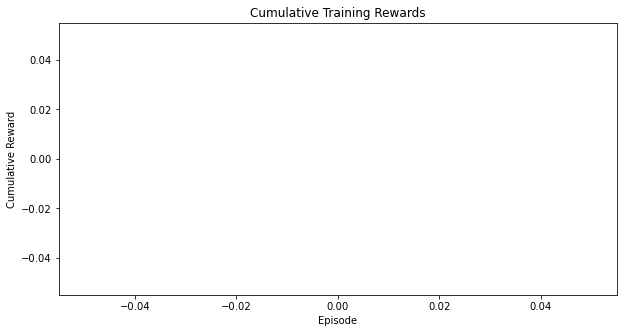

IndexError: index 1 is out of bounds for axis 1 with size 1

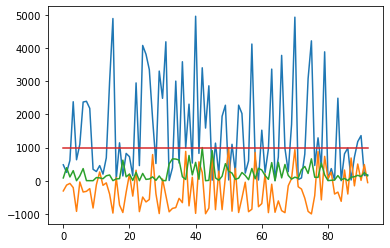

In [171]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=15, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=500, high=1500, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    


    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action
        
            # Add Gaussian noise to the action
        noise = np.random.normal(loc=0, scale=0.1, size=4)  # Adjust scale for different noise levels
        Pg += noise[0]
        Pb += noise[1]
        alpha_g_action += noise[2]
        alpha_b_action += noise[3]

        # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)
        
        
        alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
        
        alpha_g_penalty_1 = alpha_g_penalty_weight * alpha_g_action * self.Cg_t[t]
    
    
    # Add a penalty term to enforce SOC at the end of the period to be above 0.8

        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]
                # Heavily penalize overcharging
        

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 10

        power_balance_penalty = self.P_d[t] - (Pg + Pb + self.P_pv[t])
      
        
        
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))

        # Advanced reward shaping
        delta_Pg = Pg - self.Pg_max / 2
        delta_Pb = Pb - self.Pb_max / 2
        delta_alpha_g = alpha_g_action - self.alpha_g / 2
        delta_alpha_b = alpha_b_action - self.alpha_b / 2
        shaping_reward = - 0.01 * (delta_Pg**2 + delta_Pb**2 + delta_alpha_g**2 + delta_alpha_b**2)

        end_soc_penalty_weight = 10 # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        # Add weights to each term of the reward function
        power_balance_weight = 10 # adjust these weights as needed
        alpha_g_penalty_weight = 10
        alpha_b_penalty_weight = 10

        reward = -(power_balance_weight * power_balance_penalty + 
                    alpha_g_penalty_weight * alpha_g_penalty +
                    alpha_b_penalty_weight * alpha_b_penalty +
                    alpha_b_penalty_soc +
                    alpha_g_penalty_1 +
                    end_soc_penalty +
                    shaping_reward)  # Add shaping_reward to the total reward
        
        if SOC_new > 0.8:
            reward -= 10
            
        if SOC_new < 1.0:
            reward -= 10

        # Heavily penalize undercharging
        if SOC_new < 0.2:
            reward -= 10
            
        if power_balance_penalty > 0:
            reward -= 10
            
        if power_balance_penalty < 0:
            reward -= 10
            
             
        if power_balance_penalty == 0:
            reward += 100
            
  
        if reward < 0:
             reward -= 10

            
            
            

        # Add an exploration bonus
        exploration_bonus = np.random.normal(0, 0.1)  # adjust the scale of the bonus as needed
        reward += exploration_bonus

        # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
           # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t+1] if t < 47 else 0, self.P_pv[t+1] if t < 47 else 0, self.Cg_t[t+1] if t < 47 else 0, self.Cb_t[t+1] if t < 47 else 0])
         # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise
        done = t >= 47

        return self.state, reward, done, {}



    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        
        
        # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise

        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)



# Create an evaluation environment
eval_env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Create the callback
eval_callback = EvalCallback(eval_env, best_model_save_path='./models/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)



from stable_baselines3.common.utils import get_linear_fn

#initial_lr = 0.0003
#final_lr = 0.00003
#lr_schedule = get_linear_fn(initial_lr, final_lr, 1000000)

#model = SAC("MlpPolicy", env, learning_rate=lr_schedule, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1, seed=seed_value)




#model = SAC("MlpPolicy", env, learning_rate=0.000001, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1,seed=seed_value)
    
from stable_baselines3.common.callbacks import BaseCallback

class LearningRateScheduler(BaseCallback):
    def __init__(self, initial_lr, total_timesteps, lr_schedule, verbose=0):
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_lr = initial_lr
        self.total_timesteps = total_timesteps
        self.lr_schedule = lr_schedule

    def _on_step(self):
        fraction_done = self.num_timesteps / self.total_timesteps
        new_lr = self.initial_lr * self.lr_schedule(fraction_done)
        self.model.learning_rate = new_lr
        return True

# You can define your scheduler function, for example, a linear decreasing schedule
def linear_schedule(fraction_done):
    return 1 - fraction_done

initial_learning_rate = 0.00001
total_timesteps = 10000
lr_scheduler = LearningRateScheduler(initial_learning_rate, total_timesteps, linear_schedule)

model = SAC("MlpPolicy", env, 
            learning_rate=initial_learning_rate,
            buffer_size=1000000,  
            batch_size=4096,
            gamma=0.99, 
            tau=0.005, 
            ent_coef='auto',  
            target_update_interval=1, 
            gradient_steps=1, 
            target_entropy='auto', 
            use_sde=False, 
            sde_sample_freq=-1, 
            verbose=1,
            seed=seed_value)

model.learn(total_timesteps=total_timesteps, callback=lr_scheduler)


    
    
    
    
from stable_baselines3 import A2C

#model = A2C("MlpPolicy", env, learning_rate=0.0001, buffer_size=1024, batch_size=512, 
           # gamma=0.99, use_sde=False, verbose=1, seed=seed_value)
            

model.learn(total_timesteps=5000, callback=eval_callback)

# Train the agent
#model.learn(total_timesteps=9500)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
#results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
#plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class RewardLogger(BaseCallback):
    """
    A custom callback that derives from `BaseCallback`.

    This will record the cumulative reward for each training episode and save it into a list.
    """

    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.reward_log = []

    def _on_step(self) -> bool:
        """
        This method will be called by the model at each call to `model.step()`.
        """
        # We assume the environment uses the `Monitor` wrapper
        if self.locals.get("done"):
            latest_episode_reward = self.locals["episode"]["r"]
            self.reward_log.append(latest_episode_reward)

        # Continue training
        return True

# Create the callback
reward_logger = RewardLogger()

# Then you provide it to the learn function
model.learn(total_timesteps=total_timesteps, callback=[lr_scheduler, reward_logger])

# Now you can plot the cumulative rewards
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(reward_logger.reward_log))
plt.title("Cumulative Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()







plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



In [ ]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 1000
    
    
        power_balance_penalty = np.abs(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 1000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*1000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*1000
    
        end_soc_penalty_weight = 1000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

# Instantiate the agent
model = SAC("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, verbose=1,seed=seed_value)

# Train the agent
model.learn(total_timesteps=50000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



Using cpu device
Using cpu device
Using cpu device
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -109     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 61       |
|    time_elapsed    | 3        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 17.9     |
|    critic_loss     | 867      |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0256  |
|    learning_rate   | 1e-05    |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -93      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 41       |
|    time_elapsed    | 9        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.2    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 31       |
|    time_elapsed    | 97       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 339      |
|    critic_loss     | 2e+03    |
|    ent_coef        | 1.03     |
|    ent_coef_loss   | -0.557   |
|    learning_rate   | 1e-05    |
|    n_updates       | 2971     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.1    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 31       |
|    time_elapsed    | 103      |
|    total_timesteps | 3264     |
| train/             |          |
|    actor_loss      | 354      |
|    critic_loss     | 2.04e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74      |
| time/              |          |
|    episodes        | 124      |
|    fps             | 30       |
|    time_elapsed    | 194      |
|    total_timesteps | 5952     |
| train/             |          |
|    actor_loss      | 553      |
|    critic_loss     | 6.53e+03 |
|    ent_coef        | 1.05     |
|    ent_coef_loss   | -1.03    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5851     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74      |
| time/              |          |
|    episodes        | 128      |
|    fps             | 30       |
|    time_elapsed    | 200      |
|    total_timesteps | 6144     |
| train/             |          |
|    actor_loss      | 571      |
|    critic_loss     | 3.2e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.5    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 31       |
|    time_elapsed    | 284      |
|    total_timesteps | 8832     |
| train/             |          |
|    actor_loss      | 717      |
|    critic_loss     | 7.28e+03 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -1.71    |
|    learning_rate   | 1e-05    |
|    n_updates       | 8731     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.4    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 31       |
|    time_elapsed    | 290      |
|    total_timesteps | 9024     |
| train/             |          |
|    actor_loss      | 713      |
|    critic_loss     | 1.09e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -71.9    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 34       |
|    time_elapsed    | 49       |
|    total_timesteps | 1728     |
| train/             |          |
|    actor_loss      | 877      |
|    critic_loss     | 1.67e+04 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -2.3     |
|    learning_rate   | 1e-05    |
|    n_updates       | 11527    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -72.3    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 34       |
|    time_elapsed    | 55       |
|    total_timesteps | 1920     |
| train/             |          |
|    actor_loss      | 913      |
|    critic_loss     | 1.56e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.2    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 33       |
|    time_elapsed    | 136      |
|    total_timesteps | 4608     |
| train/             |          |
|    actor_loss      | 943      |
|    critic_loss     | 2.25e+04 |
|    ent_coef        | 1.15     |
|    ent_coef_loss   | -2.87    |
|    learning_rate   | 1e-05    |
|    n_updates       | 14407    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.3    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 33       |
|    time_elapsed    | 142      |
|    total_timesteps | 4800     |
| train/             |          |
|    actor_loss      | 1.01e+03 |
|    critic_loss     | 2.01e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74      |
| time/              |          |
|    episodes        | 156      |
|    fps             | 33       |
|    time_elapsed    | 223      |
|    total_timesteps | 7488     |
| train/             |          |
|    actor_loss      | 1.01e+03 |
|    critic_loss     | 2.61e+04 |
|    ent_coef        | 1.18     |
|    ent_coef_loss   | -3.49    |
|    learning_rate   | 1e-05    |
|    n_updates       | 17287    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74.5    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 33       |
|    time_elapsed    | 229      |
|    total_timesteps | 7680     |
| train/             |          |
|    actor_loss      | 1.04e+03 |
|    critic_loss     | 2.27e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -67      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 43       |
|    time_elapsed    | 8        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 1.12e+03 |
|    critic_loss     | 2.32e+04 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -3.88    |
|    learning_rate   | 1e-05    |
|    n_updates       | 20083    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.8    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 39       |
|    time_elapsed    | 14       |
|    total_timesteps | 576      |
| train/             |          |
|    actor_loss      | 1.11e+03 |
|    critic_loss     | 2.22e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.8    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 33       |
|    time_elapsed    | 96       |
|    total_timesteps | 3264     |
| train/             |          |
|    actor_loss      | 1.23e+03 |
|    critic_loss     | 2.32e+04 |
|    ent_coef        | 1.25     |
|    ent_coef_loss   | -4.74    |
|    learning_rate   | 1e-05    |
|    n_updates       | 22963    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.9    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 33       |
|    time_elapsed    | 102      |
|    total_timesteps | 3456     |
| train/             |          |
|    actor_loss      | 1.2e+03  |
|    critic_loss     | 2.78e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -75      |
| time/              |          |
|    episodes        | 128      |
|    fps             | 33       |
|    time_elapsed    | 183      |
|    total_timesteps | 6144     |
| train/             |          |
|    actor_loss      | 1.24e+03 |
|    critic_loss     | 2.36e+04 |
|    ent_coef        | 1.29     |
|    ent_coef_loss   | -5.05    |
|    learning_rate   | 1e-05    |
|    n_updates       | 25843    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74.8    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 33       |
|    time_elapsed    | 189      |
|    total_timesteps | 6336     |
| train/             |          |
|    actor_loss      | 1.26e+03 |
|    critic_loss     | 3.26e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -75.2    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 33       |
|    time_elapsed    | 272      |
|    total_timesteps | 9024     |
| train/             |          |
|    actor_loss      | 1.32e+03 |
|    critic_loss     | 3.42e+04 |
|    ent_coef        | 1.33     |
|    ent_coef_loss   | -6.18    |
|    learning_rate   | 1e-05    |
|    n_updates       | 28723    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -74.9    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 33       |
|    time_elapsed    | 278      |
|    total_timesteps | 9216     |
| train/             |          |
|    actor_loss      | 1.3e+03  |
|    critic_loss     | 4.74e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.1    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 32       |
|    time_elapsed    | 59       |
|    total_timesteps | 1920     |
| train/             |          |
|    actor_loss      | 1.4e+03  |
|    critic_loss     | 3.97e+04 |
|    ent_coef        | 1.36     |
|    ent_coef_loss   | -6.51    |
|    learning_rate   | 1e-05    |
|    n_updates       | 31519    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.5    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 32       |
|    time_elapsed    | 64       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 1.42e+03 |
|    critic_loss     | 3.93e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -75      |
| time/              |          |
|    episodes        | 100      |
|    fps             | 32       |
|    time_elapsed    | 146      |
|    total_timesteps | 4800     |
| train/             |          |
|    actor_loss      | 1.45e+03 |
|    critic_loss     | 2.27e+04 |
|    ent_coef        | 1.4      |
|    ent_coef_loss   | -7.18    |
|    learning_rate   | 1e-05    |
|    n_updates       | 34399    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -75.3    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 32       |
|    time_elapsed    | 152      |
|    total_timesteps | 4992     |
| train/             |          |
|    actor_loss      | 1.46e+03 |
|    critic_loss     | 3.95e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -76.7    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 32       |
|    time_elapsed    | 234      |
|    total_timesteps | 7680     |
| train/             |          |
|    actor_loss      | 1.48e+03 |
|    critic_loss     | 4.38e+04 |
|    ent_coef        | 1.44     |
|    ent_coef_loss   | -7.8     |
|    learning_rate   | 1e-05    |
|    n_updates       | 37279    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -76.9    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 32       |
|    time_elapsed    | 240      |
|    total_timesteps | 7872     |
| train/             |          |
|    actor_loss      | 1.45e+03 |
|    critic_loss     | 4.04e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -70.7    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 40       |
|    time_elapsed    | 14       |
|    total_timesteps | 576      |
| train/             |          |
|    actor_loss      | 1.53e+03 |
|    critic_loss     | 4.06e+04 |
|    ent_coef        | 1.49     |
|    ent_coef_loss   | -8.14    |
|    learning_rate   | 1e-05    |
|    n_updates       | 40075    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -73.4    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 37       |
|    time_elapsed    | 20       |
|    total_timesteps | 768      |
| train/             |          |
|    actor_loss      | 1.59e+03 |
|    critic_loss     | 3.81e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.9    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 33       |
|    time_elapsed    | 103      |
|    total_timesteps | 3456     |
| train/             |          |
|    actor_loss      | 1.54e+03 |
|    critic_loss     | 4.19e+04 |
|    ent_coef        | 1.53     |
|    ent_coef_loss   | -8.7     |
|    learning_rate   | 1e-05    |
|    n_updates       | 42955    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.9    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 33       |
|    time_elapsed    | 109      |
|    total_timesteps | 3648     |
| train/             |          |
|    actor_loss      | 1.57e+03 |
|    critic_loss     | 4.34e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -79      |
| time/              |          |
|    episodes        | 132      |
|    fps             | 33       |
|    time_elapsed    | 191      |
|    total_timesteps | 6336     |
| train/             |          |
|    actor_loss      | 1.64e+03 |
|    critic_loss     | 5.07e+04 |
|    ent_coef        | 1.57     |
|    ent_coef_loss   | -9.44    |
|    learning_rate   | 1e-05    |
|    n_updates       | 45835    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -79.1    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 33       |
|    time_elapsed    | 197      |
|    total_timesteps | 6528     |
| train/             |          |
|    actor_loss      | 1.62e+03 |
|    critic_loss     | 5.11e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -80.6    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 33       |
|    time_elapsed    | 278      |
|    total_timesteps | 9216     |
| train/             |          |
|    actor_loss      | 1.67e+03 |
|    critic_loss     | 5.33e+04 |
|    ent_coef        | 1.62     |
|    ent_coef_loss   | -10.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 48715    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -80.7    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 32       |
|    time_elapsed    | 285      |
|    total_timesteps | 9408     |
| train/             |          |
|    actor_loss      | 1.66e+03 |
|    critic_loss     | 4.64e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.1    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 31       |
|    time_elapsed    | 67       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 1.72e+03 |
|    critic_loss     | 5.2e+04  |
|    ent_coef        | 1.67     |
|    ent_coef_loss   | -10.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 51511    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.5    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 31       |
|    time_elapsed    | 73       |
|    total_timesteps | 2304     |
| train/             |          |
|    actor_loss      | 1.73e+03 |
|    critic_loss     | 5.58e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.1    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 30       |
|    time_elapsed    | 163      |
|    total_timesteps | 4992     |
| train/             |          |
|    actor_loss      | 1.75e+03 |
|    critic_loss     | 3.96e+04 |
|    ent_coef        | 1.71     |
|    ent_coef_loss   | -11.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 54391    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -80.9    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 30       |
|    time_elapsed    | 169      |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 1.7e+03  |
|    critic_loss     | 5.32e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.4    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 30       |
|    time_elapsed    | 262      |
|    total_timesteps | 7872     |
| train/             |          |
|    actor_loss      | 1.83e+03 |
|    critic_loss     | 2.48e+04 |
|    ent_coef        | 1.76     |
|    ent_coef_loss   | -11.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 57271    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.2    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 30       |
|    time_elapsed    | 268      |
|    total_timesteps | 8064     |
| train/             |          |
|    actor_loss      | 1.79e+03 |
|    critic_loss     | 3.38e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.2    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 35       |
|    time_elapsed    | 21       |
|    total_timesteps | 768      |
| train/             |          |
|    actor_loss      | 1.69e+03 |
|    critic_loss     | 5.1e+04  |
|    ent_coef        | 1.81     |
|    ent_coef_loss   | -12.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 60067    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -77.1    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 35       |
|    time_elapsed    | 27       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 1.76e+03 |
|    critic_loss     | 4.79e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.1    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 31       |
|    time_elapsed    | 115      |
|    total_timesteps | 3648     |
| train/             |          |
|    actor_loss      | 1.78e+03 |
|    critic_loss     | 4.55e+04 |
|    ent_coef        | 1.87     |
|    ent_coef_loss   | -13.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 62947    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.4    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 31       |
|    time_elapsed    | 121      |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 4.84e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83      |
| time/              |          |
|    episodes        | 136      |
|    fps             | 30       |
|    time_elapsed    | 215      |
|    total_timesteps | 6528     |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 6.4e+04  |
|    ent_coef        | 1.92     |
|    ent_coef_loss   | -14.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 65827    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.8    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 30       |
|    time_elapsed    | 221      |
|    total_timesteps | 6720     |
| train/             |          |
|    actor_loss      | 1.85e+03 |
|    critic_loss     | 4.68e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83      |
| time/              |          |
|    episodes        | 196      |
|    fps             | 30       |
|    time_elapsed    | 310      |
|    total_timesteps | 9408     |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 4.28e+04 |
|    ent_coef        | 1.98     |
|    ent_coef_loss   | -14.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 68707    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.2    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 30       |
|    time_elapsed    | 316      |
|    total_timesteps | 9600     |
| train/             |          |
|    actor_loss      | 1.7e+03  |
|    critic_loss     | 5.2e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.2    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 32       |
|    time_elapsed    | 71       |
|    total_timesteps | 2304     |
| train/             |          |
|    actor_loss      | 1.85e+03 |
|    critic_loss     | 4.41e+04 |
|    ent_coef        | 2.03     |
|    ent_coef_loss   | -15.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 71503    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -81.3    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 32       |
|    time_elapsed    | 77       |
|    total_timesteps | 2496     |
| train/             |          |
|    actor_loss      | 1.74e+03 |
|    critic_loss     | 3.89e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.6    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 31       |
|    time_elapsed    | 166      |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 4.84e+04 |
|    ent_coef        | 2.09     |
|    ent_coef_loss   | -15.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 74383    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.5    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 31       |
|    time_elapsed    | 172      |
|    total_timesteps | 5376     |
| train/             |          |
|    actor_loss      | 1.91e+03 |
|    critic_loss     | 5.14e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83      |
| time/              |          |
|    episodes        | 168      |
|    fps             | 30       |
|    time_elapsed    | 262      |
|    total_timesteps | 8064     |
| train/             |          |
|    actor_loss      | 1.88e+03 |
|    critic_loss     | 2.96e+04 |
|    ent_coef        | 2.15     |
|    ent_coef_loss   | -16.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 77263    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -82.8    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 30       |
|    time_elapsed    | 268      |
|    total_timesteps | 8256     |
| train/             |          |
|    actor_loss      | 1.82e+03 |
|    critic_loss     | 3.97e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -80.1    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 34       |
|    time_elapsed    | 28       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 1.79e+03 |
|    critic_loss     | 3.47e+04 |
|    ent_coef        | 2.22     |
|    ent_coef_loss   | -16.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 80059    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -80.5    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 32       |
|    time_elapsed    | 35       |
|    total_timesteps | 1152     |
| train/             |          |
|    actor_loss      | 1.84e+03 |
|    critic_loss     | 2.68e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.3    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 28       |
|    time_elapsed    | 135      |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | 1.82e+03 |
|    critic_loss     | 3.59e+04 |
|    ent_coef        | 2.28     |
|    ent_coef_loss   | -17      |
|    learning_rate   | 1e-05    |
|    n_updates       | 82939    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.4    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 28       |
|    time_elapsed    | 142      |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 1.92e+03 |
|    critic_loss     | 4.31e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.5    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 29       |
|    time_elapsed    | 229      |
|    total_timesteps | 6720     |
| train/             |          |
|    actor_loss      | 1.74e+03 |
|    critic_loss     | 3.44e+04 |
|    ent_coef        | 2.35     |
|    ent_coef_loss   | -18      |
|    learning_rate   | 1e-05    |
|    n_updates       | 85819    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.5    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 29       |
|    time_elapsed    | 236      |
|    total_timesteps | 6912     |
| train/             |          |
|    actor_loss      | 1.78e+03 |
|    critic_loss     | 3.59e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.6    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 29       |
|    time_elapsed    | 331      |
|    total_timesteps | 9600     |
| train/             |          |
|    actor_loss      | 1.89e+03 |
|    critic_loss     | 1.97e+04 |
|    ent_coef        | 2.42     |
|    ent_coef_loss   | -18.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 88699    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.8    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 28       |
|    time_elapsed    | 338      |
|    total_timesteps | 9792     |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 2.5e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.3    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 30       |
|    time_elapsed    | 82       |
|    total_timesteps | 2496     |
| train/             |          |
|    actor_loss      | 1.85e+03 |
|    critic_loss     | 3.1e+04  |
|    ent_coef        | 2.48     |
|    ent_coef_loss   | -19.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 91495    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.3    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 30       |
|    time_elapsed    | 88       |
|    total_timesteps | 2688     |
| train/             |          |
|    actor_loss      | 1.89e+03 |
|    critic_loss     | 3.59e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.9    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 29       |
|    time_elapsed    | 179      |
|    total_timesteps | 5376     |
| train/             |          |
|    actor_loss      | 1.79e+03 |
|    critic_loss     | 2.85e+04 |
|    ent_coef        | 2.56     |
|    ent_coef_loss   | -20.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 94375    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.9    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 29       |
|    time_elapsed    | 186      |
|    total_timesteps | 5568     |
| train/             |          |
|    actor_loss      | 1.81e+03 |
|    critic_loss     | 3.63e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.7    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 28       |
|    time_elapsed    | 285      |
|    total_timesteps | 8256     |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 3.39e+04 |
|    ent_coef        | 2.63     |
|    ent_coef_loss   | -20.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 97255    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -83.5    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 28       |
|    time_elapsed    | 292      |
|    total_timesteps | 8448     |
| train/             |          |
|    actor_loss      | 1.87e+03 |
|    critic_loss     | 3.53e+04 |
|    ent_coef 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -107         |
| time/                   |              |
|    fps                  | 355          |
|    iterations           | 5            |
|    time_elapsed         | 28           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0006623075 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -0.00849     |
|    learning_rate        | 1e-05        |
|    loss                 | 281          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00108     |
|    std                  | 1            |
|    value_loss           | 658          |
------------------------------------------
---------------------------------
| rollout/          

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | -110          |
| time/                   |               |
|    fps                  | 424           |
|    iterations           | 5             |
|    time_elapsed         | 24            |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 0.00048948603 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | -0.0107       |
|    learning_rate        | 1e-05         |
|    loss                 | 264           |
|    n_updates            | 140           |
|    policy_gradient_loss | -0.000735     |
|    std                  | 1             |
|    value_loss           | 608           |
-------------------------------------------
--------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | -113          |
| time/                   |               |
|    fps                  | 354           |
|    iterations           | 5             |
|    time_elapsed         | 28            |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 0.00038112138 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | -0.00241      |
|    learning_rate        | 1e-05         |
|    loss                 | 301           |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.00048      |
|    std                  | 1             |
|    value_loss           | 601           |
-------------------------------------------
--------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -116         |
| time/                   |              |
|    fps                  | 440          |
|    iterations           | 5            |
|    time_elapsed         | 23           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0003110338 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -0.000524    |
|    learning_rate        | 1e-05        |
|    loss                 | 303          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.0004      |
|    std                  | 1            |
|    value_loss           | 600          |
------------------------------------------
---------------------------------
| rollout/          

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -118         |
| time/                   |              |
|    fps                  | 426          |
|    iterations           | 5            |
|    time_elapsed         | 24           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0012658599 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -0.000131    |
|    learning_rate        | 1e-05        |
|    loss                 | 272          |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00175     |
|    std                  | 1            |
|    value_loss           | 599          |
------------------------------------------
---------------------------------
| rollout/          

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -42.4    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 104      |
|    time_elapsed    | 20       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | -82.2    |
|    critic_loss     | 602      |
|    learning_rate   | 1e-05    |
|    n_updates       | 1000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -41.3    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 111      |
|    time_elapsed    | 20       |
|    total_timesteps | 2304     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.4    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29      |
| time/              |          |
|    episodes        | 132      |
|    fps             | 61       |
|    time_elapsed    | 102      |
|    total_timesteps | 6336     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29      |
| time/              |          |
|    episodes        | 136      |
|    fps             | 63       |
|    time_elapsed    | 103      |
|    total_timesteps | 6528     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29      |
| time/              |          |
|    episodes        | 140      |
|    fps             | 65       |
|    time_elapsed    | 103      |
|    total_timesteps | 6720     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1657     |
|    time_elapsed    | 0        |
|    total_timesteps | 768      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -55.6    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1763     |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1464     |
|    time_elapsed    | 0        |
|    total_timesteps | 1152     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -31.7    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 59       |
|    time_elapsed    | 87       |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | -8.97    |
|    critic_loss     | 25.3     |
|    learning_rate   | 1e-05    |
|    n_updates       | 13000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -30.5    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 61       |
|    time_elapsed    | 88       |
|    total_timesteps | 5376     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.5    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.9    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 55       |
|    time_elapsed    | 169      |
|    total_timesteps | 9408     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.9    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 56       |
|    time_elapsed    | 169      |
|    total_timesteps | 9600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.9    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 57       |
|    time_elapsed    | 169      |
|    total_timesteps | 9792     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 66       |
|    time_elapsed    | 60       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 15.5     |
|    learning_rate   | 1e-05    |
|    n_updates       | 21000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.4    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 69       |
|    time_elapsed    | 60       |
|    total_timesteps | 4224     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.1    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.4    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 58       |
|    time_elapsed    | 142      |
|    total_timesteps | 8256     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.4    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 59       |
|    time_elapsed    | 142      |
|    total_timesteps | 8448     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.4    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 60       |
|    time_elapsed    | 142      |
|    total_timesteps | 8640     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -36.5    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 116      |
|    time_elapsed    | 24       |
|    total_timesteps | 2880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.9    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 71       |
|    time_elapsed    | 43       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 19.1     |
|    critic_loss     | 14.4     |
|    learning_rate   | 1e-05    |
|    n_updates       | 29000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.4    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27      |
| time/              |          |
|    episodes        | 152      |
|    fps             | 57       |
|    time_elapsed    | 127      |
|    total_timesteps | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27      |
| time/              |          |
|    episodes        | 156      |
|    fps             | 58       |
|    time_elapsed    | 128      |
|    total_timesteps | 7488     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27      |
| time/              |          |
|    episodes        | 160      |
|    fps             | 59       |
|    time_elapsed    | 128      |
|    total_timesteps | 7680     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.4    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 737      |
|    time_elapsed    | 2        |
|    total_timesteps | 1920     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.2    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 78       |
|    time_elapsed    | 27       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 21.5     |
|    critic_loss     | 14.7     |
|    learning_rate   | 1e-05    |
|    n_updates       | 37000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.1    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.7    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 50       |
|    time_elapsed    | 125      |
|    total_timesteps | 6336     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.7    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 51       |
|    time_elapsed    | 125      |
|    total_timesteps | 6528     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.7    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 53       |
|    time_elapsed    | 126      |
|    total_timesteps | 6720     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.6    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1878     |
|    time_elapsed    | 0        |
|    total_timesteps | 768      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.8    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1853     |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.8    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1593     |
|    time_elapsed    | 0        |
|    total_timesteps | 1152     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -30.2    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 68       |
|    time_elapsed    | 76       |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 21       |
|    critic_loss     | 10.7     |
|    learning_rate   | 1e-05    |
|    n_updates       | 49000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29      |
| time/              |          |
|    episodes        | 112      |
|    fps             | 70       |
|    time_elapsed    | 76       |
|    total_timesteps | 5376     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.8    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 62       |
|    time_elapsed    | 151      |
|    total_timesteps | 9408     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 63       |
|    time_elapsed    | 151      |
|    total_timesteps | 9600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 64       |
|    time_elapsed    | 152      |
|    total_timesteps | 9792     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -33      |
| time/              |          |
|    episodes        | 84       |
|    fps             | 72       |
|    time_elapsed    | 55       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 19.6     |
|    critic_loss     | 9.66     |
|    learning_rate   | 1e-05    |
|    n_updates       | 57000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.7    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 75       |
|    time_elapsed    | 55       |
|    total_timesteps | 4224     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.4    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 63       |
|    time_elapsed    | 130      |
|    total_timesteps | 8256     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 64       |
|    time_elapsed    | 130      |
|    total_timesteps | 8448     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 65       |
|    time_elapsed    | 130      |
|    total_timesteps | 8640     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.5    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 140      |
|    time_elapsed    | 20       |
|    total_timesteps | 2880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.9    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 81       |
|    time_elapsed    | 37       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 8.62     |
|    learning_rate   | 1e-05    |
|    n_updates       | 65000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.4    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 64       |
|    time_elapsed    | 113      |
|    total_timesteps | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 66       |
|    time_elapsed    | 113      |
|    total_timesteps | 7488     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 67       |
|    time_elapsed    | 113      |
|    total_timesteps | 7680     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.5    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1122     |
|    time_elapsed    | 1        |
|    total_timesteps | 1920     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.3    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 99       |
|    time_elapsed    | 21       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 7.23     |
|    learning_rate   | 1e-05    |
|    n_updates       | 73000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.3    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 83       |
|    time_elapsed    | 75       |
|    total_timesteps | 6336     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 85       |
|    time_elapsed    | 76       |
|    total_timesteps | 6528     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 88       |
|    time_elapsed    | 76       |
|    total_timesteps | 6720     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.3    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 2854     |
|    time_elapsed    | 0        |
|    total_timesteps | 768      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 3009     |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.3    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 2764     |
|    time_elapsed    | 0        |
|    total_timesteps | 1152     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.2    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 98       |
|    time_elapsed    | 52       |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 5.44     |
|    learning_rate   | 1e-05    |
|    n_updates       | 85000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -28.1    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 101      |
|    time_elapsed    | 52       |
|    total_timesteps | 5376     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.2    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 196      |
|    fps             | 90       |
|    time_elapsed    | 104      |
|    total_timesteps | 9408     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 200      |
|    fps             | 91       |
|    time_elapsed    | 104      |
|    total_timesteps | 9600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 204      |
|    fps             | 93       |
|    time_elapsed    | 104      |
|    total_timesteps | 9792     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.5    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 104      |
|    time_elapsed    | 38       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | -49.1    |
|    critic_loss     | 29.3     |
|    learning_rate   | 1e-05    |
|    n_updates       | 3000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.2    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 109      |
|    time_elapsed    | 38       |
|    total_timesteps | 4224     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -31.9    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 172      |
|    fps             | 92       |
|    time_elapsed    | 89       |
|    total_timesteps | 8256     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 176      |
|    fps             | 94       |
|    time_elapsed    | 89       |
|    total_timesteps | 8448     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 180      |
|    fps             | 96       |
|    time_elapsed    | 89       |
|    total_timesteps | 8640     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.6    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 209      |
|    time_elapsed    | 13       |
|    total_timesteps | 2880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 119      |
|    time_elapsed    | 25       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 2.79     |
|    critic_loss     | 5.13     |
|    learning_rate   | 1e-05    |
|    n_updates       | 11000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.5    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 152      |
|    fps             | 95       |
|    time_elapsed    | 76       |
|    total_timesteps | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 156      |
|    fps             | 97       |
|    time_elapsed    | 76       |
|    total_timesteps | 7488     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26      |
| time/              |          |
|    episodes        | 160      |
|    fps             | 100      |
|    time_elapsed    | 76       |
|    total_timesteps | 7680     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.8    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1891     |
|    time_elapsed    | 1        |
|    total_timesteps | 1920     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.6    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 161      |
|    time_elapsed    | 13       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 5.3      |
|    learning_rate   | 1e-05    |
|    n_updates       | 19000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -37.5    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 99       |
|    time_elapsed    | 63       |
|    total_timesteps | 6336     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 102      |
|    time_elapsed    | 63       |
|    total_timesteps | 6528     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 105      |
|    time_elapsed    | 63       |
|    total_timesteps | 6720     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -51.9    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 2676     |
|    time_elapsed    | 0        |
|    total_timesteps | 768      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -52.2    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 2817     |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -48.4    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 2531     |
|    time_elapsed    | 0        |
|    total_timesteps | 1152     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.5    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 101      |
|    time_elapsed    | 51       |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.3      |
|    learning_rate   | 1e-05    |
|    n_updates       | 31000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -28.6    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 104      |
|    time_elapsed    | 51       |
|    total_timesteps | 5376     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.3    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 91       |
|    time_elapsed    | 102      |
|    total_timesteps | 9408     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 93       |
|    time_elapsed    | 103      |
|    total_timesteps | 9600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 94       |
|    time_elapsed    | 103      |
|    total_timesteps | 9792     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.6    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 104      |
|    time_elapsed    | 38       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.42     |
|    learning_rate   | 1e-05    |
|    n_updates       | 39000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.3    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 109      |
|    time_elapsed    | 38       |
|    total_timesteps | 4224     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32      |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 91       |
|    time_elapsed    | 90       |
|    total_timesteps | 8256     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 93       |
|    time_elapsed    | 90       |
|    total_timesteps | 8448     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 95       |
|    time_elapsed    | 90       |
|    total_timesteps | 8640     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.3    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 207      |
|    time_elapsed    | 13       |
|    total_timesteps | 2880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.8    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 117      |
|    time_elapsed    | 26       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 1.79     |
|    learning_rate   | 1e-05    |
|    n_updates       | 47000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.3    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 92       |
|    time_elapsed    | 78       |
|    total_timesteps | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 95       |
|    time_elapsed    | 78       |
|    total_timesteps | 7488     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 97       |
|    time_elapsed    | 78       |
|    total_timesteps | 7680     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -40.6    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1327     |
|    time_elapsed    | 1        |
|    total_timesteps | 1920     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -39.3    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 134      |
|    time_elapsed    | 15       |
|    total_timesteps | 2112     |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 1.59     |
|    learning_rate   | 1e-05    |
|    n_updates       | 55000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -38.2    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 77       |
|    time_elapsed    | 81       |
|    total_timesteps | 6336     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 79       |
|    time_elapsed    | 81       |
|    total_timesteps | 6528     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 81       |
|    time_elapsed    | 81       |
|    total_timesteps | 6720     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -54.5    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1806     |
|    time_elapsed    | 0        |
|    total_timesteps | 768      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1874     |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -50.2    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1599     |
|    time_elapsed    | 0        |
|    total_timesteps | 1152     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -29.8    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 67       |
|    time_elapsed    | 77       |
|    total_timesteps | 5184     |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 1.29     |
|    learning_rate   | 1e-05    |
|    n_updates       | 67000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -28.6    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 69       |
|    time_elapsed    | 77       |
|    total_timesteps | 5376     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -27.5    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 61       |
|    time_elapsed    | 153      |
|    total_timesteps | 9408     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 62       |
|    time_elapsed    | 153      |
|    total_timesteps | 9600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 63       |
|    time_elapsed    | 153      |
|    total_timesteps | 9792     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.7    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 77       |
|    time_elapsed    | 51       |
|    total_timesteps | 4032     |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 1.03     |
|    learning_rate   | 1e-05    |
|    n_updates       | 75000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.4    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 81       |
|    time_elapsed    | 51       |
|    total_timesteps | 4224     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -32.2    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 72       |
|    time_elapsed    | 113      |
|    total_timesteps | 8256     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 74       |
|    time_elapsed    | 113      |
|    total_timesteps | 8448     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 75       |
|    time_elapsed    | 114      |
|    total_timesteps | 8640     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.7    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 201      |
|    time_elapsed    | 14       |
|    total_timesteps | 2880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -35.1    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 114      |
|    time_elapsed    | 26       |
|    total_timesteps | 3072     |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 0.978    |
|    learning_rate   | 1e-05    |
|    n_updates       | 83000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -34.6    |
| time/       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 87       |
|    time_elapsed    | 83       |
|    total_timesteps | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 89       |
|    time_elapsed    | 83       |
|    total_timesteps | 7488     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 91       |
|    time_elapsed    | 83       |
|    total_timesteps | 7680     |
--------------

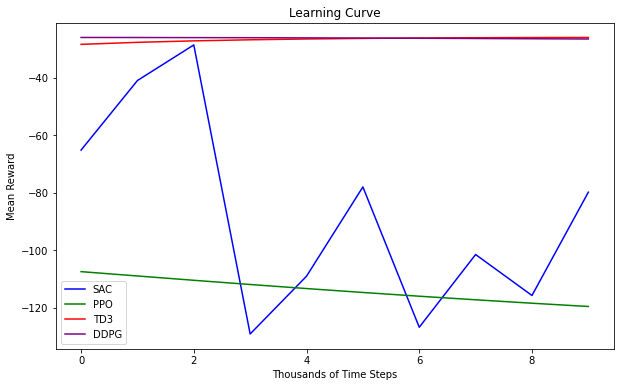

In [84]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
from stable_baselines3 import SAC, PPO, TD3, A2C, DDPG


# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 1000
    
    
        power_balance_penalty = np.abs(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 1000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*1000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*1000
    
        end_soc_penalty_weight = 1000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

import matplotlib.pyplot as plt

# Instantiate the agent
sac_model = SAC("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, verbose=1, seed=seed_value)
ppo_model = PPO("MlpPolicy", env, learning_rate=0.00001, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, clip_range_vf=None, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=-1, target_kl=None, verbose=1, seed=seed_value)
td3_model = TD3("MlpPolicy", env, learning_rate=0.00001, buffer_size=1000000, learning_starts=1000, batch_size=100, tau=0.005, gamma=0.99, train_freq=1000, gradient_steps=-1, action_noise=None, optimize_memory_usage=False, policy_delay=2, target_policy_noise=0.2, target_noise_clip=0.5, verbose=1, seed=seed_value)
ddpg_model = DDPG("MlpPolicy", env, learning_rate=0.00001, buffer_size=1000000, learning_starts=1000, batch_size=100, tau=0.005, gamma=0.99, train_freq=1000, gradient_steps=-1, action_noise=None, optimize_memory_usage=False, verbose=1, seed=seed_value)

# Define the models and colors for plotting
models = [sac_model, ppo_model, td3_model, ddpg_model]
model_names = ["SAC", "PPO", "TD3", "DDPG"]
colors = ["blue", "green", "red", "purple"]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate over models
for model, model_name, color in zip(models, model_names, colors):
    # List to save results
    results = []

    # Train the agent
    for i in range(10):
        model.learn(total_timesteps=10000)
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
        results.append(mean_reward)

    # Plot results
    plt.plot(results, color=color, label=model_name)

# Finalize the plot
plt.title("Learning Curve")
plt.xlabel("Thousands of Time Steps")
plt.ylabel("Mean Reward")
plt.legend()
plt.show()



Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -84.9    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 190      |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | -95.1    |
|    critic_loss     | 2.02e+03 |
|    learning_rate   | 1e-05    |
|    n_updates       | 48       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -63.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 4        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | -74.5    |
|    critic_loss     | 544      |
|    learning_rate   | 1e-05    |
|    n_updates       | 240     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.7    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 50       |
|    time_elapsed    | 68       |
|    total_timesteps | 3456     |
| train/             |          |
|    actor_loss      | -41.2    |
|    critic_loss     | 10.2     |
|    learning_rate   | 1e-05    |
|    n_updates       | 3312     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -56.9    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 50       |
|    time_elapsed    | 71       |
|    total_timesteps | 3648     |
| train/             |          |
|    actor_loss      | -40.7    |
|    critic_loss     | 9.22     |
|    learning_rate   | 1e-05    |
|    n_updates       | 3504     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.6    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 52       |
|    time_elapsed    | 127      |
|    total_timesteps | 6720     |
| train/             |          |
|    actor_loss      | -22.8    |
|    critic_loss     | 12.7     |
|    learning_rate   | 1e-05    |
|    n_updates       | 6576     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -59.8    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 52       |
|    time_elapsed    | 131      |
|    total_timesteps | 6912     |
| train/             |          |
|    actor_loss      | -22.2    |
|    critic_loss     | 13.4     |
|    learning_rate   | 1e-05    |
|    n_updates       | 6768     |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61      |
| time/              |          |
|    episodes        | 208      |
|    fps             | 51       |
|    time_elapsed    | 195      |
|    total_timesteps | 9984     |
| train/             |          |
|    actor_loss      | -6.38    |
|    critic_loss     | 7.81     |
|    learning_rate   | 1e-05    |
|    n_updates       | 9840     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61      |
| time/              |          |
|    episodes        | 212      |
|    fps             | 51       |
|    time_elapsed    | 198      |
|    total_timesteps | 10176    |
| train/             |          |
|    actor_loss      | -5.73    |
|    critic_loss     | 7.14     |
|    learning_rate   | 1e-05    |
|    n_updates       | 10032    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 276      |
|    fps             | 51       |
|    time_elapsed    | 256      |
|    total_timesteps | 13248    |
| train/             |          |
|    actor_loss      | 8.02     |
|    critic_loss     | 2        |
|    learning_rate   | 1e-05    |
|    n_updates       | 13104    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.5    |
| time/              |          |
|    episodes        | 280      |
|    fps             | 51       |
|    time_elapsed    | 260      |
|    total_timesteps | 13440    |
| train/             |          |
|    actor_loss      | 8.95     |
|    critic_loss     | 2.12     |
|    learning_rate   | 1e-05    |
|    n_updates       | 13296    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 344      |
|    fps             | 51       |
|    time_elapsed    | 322      |
|    total_timesteps | 16512    |
| train/             |          |
|    actor_loss      | 18.8     |
|    critic_loss     | 20.9     |
|    learning_rate   | 1e-05    |
|    n_updates       | 16368    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.7    |
| time/              |          |
|    episodes        | 348      |
|    fps             | 51       |
|    time_elapsed    | 326      |
|    total_timesteps | 16704    |
| train/             |          |
|    actor_loss      | 19.5     |
|    critic_loss     | 22.9     |
|    learning_rate   | 1e-05    |
|    n_updates       | 16560    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 412      |
|    fps             | 51       |
|    time_elapsed    | 386      |
|    total_timesteps | 19776    |
| train/             |          |
|    actor_loss      | 26.5     |
|    critic_loss     | 33.1     |
|    learning_rate   | 1e-05    |
|    n_updates       | 19632    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -61.9    |
| time/              |          |
|    episodes        | 416      |
|    fps             | 51       |
|    time_elapsed    | 390      |
|    total_timesteps | 19968    |
| train/             |          |
|    actor_loss      | 26.7     |
|    critic_loss     | 33.8     |
|    learning_rate   | 1e-05    |
|    n_updates       | 19824    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62      |
| time/              |          |
|    episodes        | 480      |
|    fps             | 50       |
|    time_elapsed    | 451      |
|    total_timesteps | 23040    |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 27.5     |
|    learning_rate   | 1e-05    |
|    n_updates       | 22896    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62      |
| time/              |          |
|    episodes        | 484      |
|    fps             | 50       |
|    time_elapsed    | 455      |
|    total_timesteps | 23232    |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 24.7     |
|    learning_rate   | 1e-05    |
|    n_updates       | 23088    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 548      |
|    fps             | 51       |
|    time_elapsed    | 511      |
|    total_timesteps | 26304    |
| train/             |          |
|    actor_loss      | 35.6     |
|    critic_loss     | 17.8     |
|    learning_rate   | 1e-05    |
|    n_updates       | 26160    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 552      |
|    fps             | 51       |
|    time_elapsed    | 515      |
|    total_timesteps | 26496    |
| train/             |          |
|    actor_loss      | 35.5     |
|    critic_loss     | 18.1     |
|    learning_rate   | 1e-05    |
|    n_updates       | 26352    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 616      |
|    fps             | 50       |
|    time_elapsed    | 580      |
|    total_timesteps | 29568    |
| train/             |          |
|    actor_loss      | 37.6     |
|    critic_loss     | 15.6     |
|    learning_rate   | 1e-05    |
|    n_updates       | 29424    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.1    |
| time/              |          |
|    episodes        | 620      |
|    fps             | 50       |
|    time_elapsed    | 586      |
|    total_timesteps | 29760    |
| train/             |          |
|    actor_loss      | 37.9     |
|    critic_loss     | 14.5     |
|    learning_rate   | 1e-05    |
|    n_updates       | 29616    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 50       |
|    time_elapsed    | 645      |
|    total_timesteps | 32832    |
| train/             |          |
|    actor_loss      | 39.2     |
|    critic_loss     | 10.6     |
|    learning_rate   | 1e-05    |
|    n_updates       | 32688    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 688      |
|    fps             | 50       |
|    time_elapsed    | 649      |
|    total_timesteps | 33024    |
| train/             |          |
|    actor_loss      | 39.6     |
|    critic_loss     | 10.2     |
|    learning_rate   | 1e-05    |
|    n_updates       | 32880    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 752      |
|    fps             | 51       |
|    time_elapsed    | 707      |
|    total_timesteps | 36096    |
| train/             |          |
|    actor_loss      | 39.3     |
|    critic_loss     | 5.88     |
|    learning_rate   | 1e-05    |
|    n_updates       | 35952    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.2    |
| time/              |          |
|    episodes        | 756      |
|    fps             | 51       |
|    time_elapsed    | 710      |
|    total_timesteps | 36288    |
| train/             |          |
|    actor_loss      | 39.6     |
|    critic_loss     | 5.05     |
|    learning_rate   | 1e-05    |
|    n_updates       | 36144    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 820      |
|    fps             | 51       |
|    time_elapsed    | 770      |
|    total_timesteps | 39360    |
| train/             |          |
|    actor_loss      | 38.6     |
|    critic_loss     | 2.4      |
|    learning_rate   | 1e-05    |
|    n_updates       | 39216    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 824      |
|    fps             | 51       |
|    time_elapsed    | 775      |
|    total_timesteps | 39552    |
| train/             |          |
|    actor_loss      | 38.9     |
|    critic_loss     | 2.24     |
|    learning_rate   | 1e-05    |
|    n_updates       | 39408    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 51       |
|    time_elapsed    | 835      |
|    total_timesteps | 42624    |
| train/             |          |
|    actor_loss      | 37.8     |
|    critic_loss     | 0.74     |
|    learning_rate   | 1e-05    |
|    n_updates       | 42480    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 51       |
|    time_elapsed    | 838      |
|    total_timesteps | 42816    |
| train/             |          |
|    actor_loss      | 37.3     |
|    critic_loss     | 0.737    |
|    learning_rate   | 1e-05    |
|    n_updates       | 42672    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 956      |
|    fps             | 50       |
|    time_elapsed    | 902      |
|    total_timesteps | 45888    |
| train/             |          |
|    actor_loss      | 36.5     |
|    critic_loss     | 0.211    |
|    learning_rate   | 1e-05    |
|    n_updates       | 45744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 960      |
|    fps             | 50       |
|    time_elapsed    | 906      |
|    total_timesteps | 46080    |
| train/             |          |
|    actor_loss      | 36.3     |
|    critic_loss     | 0.259    |
|    learning_rate   | 1e-05    |
|    n_updates       | 45936    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 50       |
|    time_elapsed    | 970      |
|    total_timesteps | 49152    |
| train/             |          |
|    actor_loss      | 35.3     |
|    critic_loss     | 0.216    |
|    learning_rate   | 1e-05    |
|    n_updates       | 49008    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 50       |
|    time_elapsed    | 973      |
|    total_timesteps | 49344    |
| train/             |          |
|    actor_loss      | 35       |
|    critic_loss     | 0.473    |
|    learning_rate   | 1e-05    |
|    n_updates       | 49200    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 1092     |
|    fps             | 50       |
|    time_elapsed    | 1031     |
|    total_timesteps | 52416    |
| train/             |          |
|    actor_loss      | 34.3     |
|    critic_loss     | 0.103    |
|    learning_rate   | 1e-05    |
|    n_updates       | 52272    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.3    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 50       |
|    time_elapsed    | 1034     |
|    total_timesteps | 52608    |
| train/             |          |
|    actor_loss      | 34.9     |
|    critic_loss     | 0.107    |
|    learning_rate   | 1e-05    |
|    n_updates       | 52464    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1160     |
|    fps             | 50       |
|    time_elapsed    | 1098     |
|    total_timesteps | 55680    |
| train/             |          |
|    actor_loss      | 33.6     |
|    critic_loss     | 0.0563   |
|    learning_rate   | 1e-05    |
|    n_updates       | 55536    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1164     |
|    fps             | 50       |
|    time_elapsed    | 1105     |
|    total_timesteps | 55872    |
| train/             |          |
|    actor_loss      | 34       |
|    critic_loss     | 0.117    |
|    learning_rate   | 1e-05    |
|    n_updates       | 55728    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1228     |
|    fps             | 49       |
|    time_elapsed    | 1193     |
|    total_timesteps | 58944    |
| train/             |          |
|    actor_loss      | 33       |
|    critic_loss     | 0.0518   |
|    learning_rate   | 1e-05    |
|    n_updates       | 58800    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1232     |
|    fps             | 49       |
|    time_elapsed    | 1198     |
|    total_timesteps | 59136    |
| train/             |          |
|    actor_loss      | 33.3     |
|    critic_loss     | 0.148    |
|    learning_rate   | 1e-05    |
|    n_updates       | 58992    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 48       |
|    time_elapsed    | 1283     |
|    total_timesteps | 62208    |
| train/             |          |
|    actor_loss      | 32.8     |
|    critic_loss     | 0.133    |
|    learning_rate   | 1e-05    |
|    n_updates       | 62064    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 48       |
|    time_elapsed    | 1289     |
|    total_timesteps | 62400    |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0918   |
|    learning_rate   | 1e-05    |
|    n_updates       | 62256    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1364     |
|    fps             | 47       |
|    time_elapsed    | 1372     |
|    total_timesteps | 65472    |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 65328    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1368     |
|    fps             | 47       |
|    time_elapsed    | 1377     |
|    total_timesteps | 65664    |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.0942   |
|    learning_rate   | 1e-05    |
|    n_updates       | 65520    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1432     |
|    fps             | 47       |
|    time_elapsed    | 1456     |
|    total_timesteps | 68736    |
| train/             |          |
|    actor_loss      | 33       |
|    critic_loss     | 0.152    |
|    learning_rate   | 1e-05    |
|    n_updates       | 68592    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1436     |
|    fps             | 47       |
|    time_elapsed    | 1461     |
|    total_timesteps | 68928    |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 0.125    |
|    learning_rate   | 1e-05    |
|    n_updates       | 68784    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 46       |
|    time_elapsed    | 1542     |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.201    |
|    learning_rate   | 1e-05    |
|    n_updates       | 71856    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 46       |
|    time_elapsed    | 1546     |
|    total_timesteps | 72192    |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.195    |
|    learning_rate   | 1e-05    |
|    n_updates       | 72048    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 46       |
|    time_elapsed    | 1615     |
|    total_timesteps | 75264    |
| train/             |          |
|    actor_loss      | 32.9     |
|    critic_loss     | 0.204    |
|    learning_rate   | 1e-05    |
|    n_updates       | 75120    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1572     |
|    fps             | 46       |
|    time_elapsed    | 1618     |
|    total_timesteps | 75456    |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.167    |
|    learning_rate   | 1e-05    |
|    n_updates       | 75312    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1636     |
|    fps             | 46       |
|    time_elapsed    | 1676     |
|    total_timesteps | 78528    |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.0996   |
|    learning_rate   | 1e-05    |
|    n_updates       | 78384    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1640     |
|    fps             | 46       |
|    time_elapsed    | 1681     |
|    total_timesteps | 78720    |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.237    |
|    learning_rate   | 1e-05    |
|    n_updates       | 78576    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1704     |
|    fps             | 46       |
|    time_elapsed    | 1745     |
|    total_timesteps | 81792    |
| train/             |          |
|    actor_loss      | 32.8     |
|    critic_loss     | 0.14     |
|    learning_rate   | 1e-05    |
|    n_updates       | 81648    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1708     |
|    fps             | 46       |
|    time_elapsed    | 1748     |
|    total_timesteps | 81984    |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.211    |
|    learning_rate   | 1e-05    |
|    n_updates       | 81840    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 47       |
|    time_elapsed    | 1804     |
|    total_timesteps | 85056    |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.124    |
|    learning_rate   | 1e-05    |
|    n_updates       | 84912    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 47       |
|    time_elapsed    | 1809     |
|    total_timesteps | 85248    |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.051    |
|    learning_rate   | 1e-05    |
|    n_updates       | 85104    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1840     |
|    fps             | 46       |
|    time_elapsed    | 1890     |
|    total_timesteps | 88320    |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.151    |
|    learning_rate   | 1e-05    |
|    n_updates       | 88176    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.4    |
| time/              |          |
|    episodes        | 1844     |
|    fps             | 46       |
|    time_elapsed    | 1895     |
|    total_timesteps | 88512    |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0559   |
|    learning_rate   | 1e-05    |
|    n_updates       | 88368    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 1908     |
|    fps             | 46       |
|    time_elapsed    | 1978     |
|    total_timesteps | 91584    |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.166    |
|    learning_rate   | 1e-05    |
|    n_updates       | 91440    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 1912     |
|    fps             | 46       |
|    time_elapsed    | 1984     |
|    total_timesteps | 91776    |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0341   |
|    learning_rate   | 1e-05    |
|    n_updates       | 91632    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 1976     |
|    fps             | 45       |
|    time_elapsed    | 2066     |
|    total_timesteps | 94848    |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.228    |
|    learning_rate   | 1e-05    |
|    n_updates       | 94704    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 1980     |
|    fps             | 45       |
|    time_elapsed    | 2071     |
|    total_timesteps | 95040    |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0622   |
|    learning_rate   | 1e-05    |
|    n_updates       | 94896    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 45       |
|    time_elapsed    | 2147     |
|    total_timesteps | 98112    |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.698    |
|    learning_rate   | 1e-05    |
|    n_updates       | 97968    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 45       |
|    time_elapsed    | 2152     |
|    total_timesteps | 98304    |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0984   |
|    learning_rate   | 1e-05    |
|    n_updates       | 98160    |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2112     |
|    fps             | 45       |
|    time_elapsed    | 2233     |
|    total_timesteps | 101376   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 101232   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2116     |
|    fps             | 45       |
|    time_elapsed    | 2238     |
|    total_timesteps | 101568   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.198    |
|    learning_rate   | 1e-05    |
|    n_updates       | 101424   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2180     |
|    fps             | 45       |
|    time_elapsed    | 2314     |
|    total_timesteps | 104640   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.209    |
|    learning_rate   | 1e-05    |
|    n_updates       | 104496   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2184     |
|    fps             | 45       |
|    time_elapsed    | 2319     |
|    total_timesteps | 104832   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0436   |
|    learning_rate   | 1e-05    |
|    n_updates       | 104688   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2248     |
|    fps             | 44       |
|    time_elapsed    | 2409     |
|    total_timesteps | 107904   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.0387   |
|    learning_rate   | 1e-05    |
|    n_updates       | 107760   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2252     |
|    fps             | 44       |
|    time_elapsed    | 2416     |
|    total_timesteps | 108096   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.15     |
|    learning_rate   | 1e-05    |
|    n_updates       | 107952   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2316     |
|    fps             | 44       |
|    time_elapsed    | 2501     |
|    total_timesteps | 111168   |
| train/             |          |
|    actor_loss      | 31.6     |
|    critic_loss     | 0.0843   |
|    learning_rate   | 1e-05    |
|    n_updates       | 111024   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2320     |
|    fps             | 44       |
|    time_elapsed    | 2506     |
|    total_timesteps | 111360   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.172    |
|    learning_rate   | 1e-05    |
|    n_updates       | 111216   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2384     |
|    fps             | 44       |
|    time_elapsed    | 2589     |
|    total_timesteps | 114432   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.186    |
|    learning_rate   | 1e-05    |
|    n_updates       | 114288   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2388     |
|    fps             | 44       |
|    time_elapsed    | 2594     |
|    total_timesteps | 114624   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.0366   |
|    learning_rate   | 1e-05    |
|    n_updates       | 114480   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2452     |
|    fps             | 43       |
|    time_elapsed    | 2678     |
|    total_timesteps | 117696   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.136    |
|    learning_rate   | 1e-05    |
|    n_updates       | 117552   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2456     |
|    fps             | 43       |
|    time_elapsed    | 2683     |
|    total_timesteps | 117888   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0702   |
|    learning_rate   | 1e-05    |
|    n_updates       | 117744   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2520     |
|    fps             | 43       |
|    time_elapsed    | 2768     |
|    total_timesteps | 120960   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.184    |
|    learning_rate   | 1e-05    |
|    n_updates       | 120816   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 43       |
|    time_elapsed    | 2775     |
|    total_timesteps | 121152   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.14     |
|    learning_rate   | 1e-05    |
|    n_updates       | 121008   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2588     |
|    fps             | 43       |
|    time_elapsed    | 2858     |
|    total_timesteps | 124224   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0358   |
|    learning_rate   | 1e-05    |
|    n_updates       | 124080   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2592     |
|    fps             | 43       |
|    time_elapsed    | 2862     |
|    total_timesteps | 124416   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.329    |
|    learning_rate   | 1e-05    |
|    n_updates       | 124272   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2656     |
|    fps             | 43       |
|    time_elapsed    | 2947     |
|    total_timesteps | 127488   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.15     |
|    learning_rate   | 1e-05    |
|    n_updates       | 127344   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2660     |
|    fps             | 43       |
|    time_elapsed    | 2952     |
|    total_timesteps | 127680   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.331    |
|    learning_rate   | 1e-05    |
|    n_updates       | 127536   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2724     |
|    fps             | 43       |
|    time_elapsed    | 3039     |
|    total_timesteps | 130752   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.254    |
|    learning_rate   | 1e-05    |
|    n_updates       | 130608   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2728     |
|    fps             | 43       |
|    time_elapsed    | 3044     |
|    total_timesteps | 130944   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0222   |
|    learning_rate   | 1e-05    |
|    n_updates       | 130800   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2792     |
|    fps             | 42       |
|    time_elapsed    | 3128     |
|    total_timesteps | 134016   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 133872   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2796     |
|    fps             | 42       |
|    time_elapsed    | 3133     |
|    total_timesteps | 134208   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0559   |
|    learning_rate   | 1e-05    |
|    n_updates       | 134064   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2860     |
|    fps             | 42       |
|    time_elapsed    | 3219     |
|    total_timesteps | 137280   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0347   |
|    learning_rate   | 1e-05    |
|    n_updates       | 137136   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2864     |
|    fps             | 42       |
|    time_elapsed    | 3224     |
|    total_timesteps | 137472   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0724   |
|    learning_rate   | 1e-05    |
|    n_updates       | 137328   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2928     |
|    fps             | 42       |
|    time_elapsed    | 3307     |
|    total_timesteps | 140544   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0583   |
|    learning_rate   | 1e-05    |
|    n_updates       | 140400   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2932     |
|    fps             | 42       |
|    time_elapsed    | 3312     |
|    total_timesteps | 140736   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.155    |
|    learning_rate   | 1e-05    |
|    n_updates       | 140592   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 2996     |
|    fps             | 42       |
|    time_elapsed    | 3395     |
|    total_timesteps | 143808   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0352   |
|    learning_rate   | 1e-05    |
|    n_updates       | 143664   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3000     |
|    fps             | 42       |
|    time_elapsed    | 3400     |
|    total_timesteps | 144000   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0421   |
|    learning_rate   | 1e-05    |
|    n_updates       | 143856   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3064     |
|    fps             | 42       |
|    time_elapsed    | 3482     |
|    total_timesteps | 147072   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.169    |
|    learning_rate   | 1e-05    |
|    n_updates       | 146928   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3068     |
|    fps             | 42       |
|    time_elapsed    | 3487     |
|    total_timesteps | 147264   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.108    |
|    learning_rate   | 1e-05    |
|    n_updates       | 147120   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3132     |
|    fps             | 42       |
|    time_elapsed    | 3566     |
|    total_timesteps | 150336   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.111    |
|    learning_rate   | 1e-05    |
|    n_updates       | 150192   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3136     |
|    fps             | 42       |
|    time_elapsed    | 3570     |
|    total_timesteps | 150528   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.256    |
|    learning_rate   | 1e-05    |
|    n_updates       | 150384   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3200     |
|    fps             | 42       |
|    time_elapsed    | 3638     |
|    total_timesteps | 153600   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.0723   |
|    learning_rate   | 1e-05    |
|    n_updates       | 153456   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3204     |
|    fps             | 42       |
|    time_elapsed    | 3642     |
|    total_timesteps | 153792   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.0563   |
|    learning_rate   | 1e-05    |
|    n_updates       | 153648   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3268     |
|    fps             | 42       |
|    time_elapsed    | 3723     |
|    total_timesteps | 156864   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0501   |
|    learning_rate   | 1e-05    |
|    n_updates       | 156720   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3272     |
|    fps             | 42       |
|    time_elapsed    | 3728     |
|    total_timesteps | 157056   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.105    |
|    learning_rate   | 1e-05    |
|    n_updates       | 156912   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3336     |
|    fps             | 42       |
|    time_elapsed    | 3803     |
|    total_timesteps | 160128   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.246    |
|    learning_rate   | 1e-05    |
|    n_updates       | 159984   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3340     |
|    fps             | 42       |
|    time_elapsed    | 3808     |
|    total_timesteps | 160320   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.143    |
|    learning_rate   | 1e-05    |
|    n_updates       | 160176   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3404     |
|    fps             | 42       |
|    time_elapsed    | 3888     |
|    total_timesteps | 163392   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0852   |
|    learning_rate   | 1e-05    |
|    n_updates       | 163248   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3408     |
|    fps             | 42       |
|    time_elapsed    | 3893     |
|    total_timesteps | 163584   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0528   |
|    learning_rate   | 1e-05    |
|    n_updates       | 163440   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3472     |
|    fps             | 41       |
|    time_elapsed    | 3975     |
|    total_timesteps | 166656   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.15     |
|    learning_rate   | 1e-05    |
|    n_updates       | 166512   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3476     |
|    fps             | 41       |
|    time_elapsed    | 3980     |
|    total_timesteps | 166848   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0685   |
|    learning_rate   | 1e-05    |
|    n_updates       | 166704   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3540     |
|    fps             | 41       |
|    time_elapsed    | 4066     |
|    total_timesteps | 169920   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.134    |
|    learning_rate   | 1e-05    |
|    n_updates       | 169776   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3544     |
|    fps             | 41       |
|    time_elapsed    | 4071     |
|    total_timesteps | 170112   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.015    |
|    learning_rate   | 1e-05    |
|    n_updates       | 169968   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3608     |
|    fps             | 41       |
|    time_elapsed    | 4153     |
|    total_timesteps | 173184   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0526   |
|    learning_rate   | 1e-05    |
|    n_updates       | 173040   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3612     |
|    fps             | 41       |
|    time_elapsed    | 4159     |
|    total_timesteps | 173376   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.377    |
|    learning_rate   | 1e-05    |
|    n_updates       | 173232   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3676     |
|    fps             | 41       |
|    time_elapsed    | 4245     |
|    total_timesteps | 176448   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.0746   |
|    learning_rate   | 1e-05    |
|    n_updates       | 176304   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3680     |
|    fps             | 41       |
|    time_elapsed    | 4250     |
|    total_timesteps | 176640   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0919   |
|    learning_rate   | 1e-05    |
|    n_updates       | 176496   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3744     |
|    fps             | 41       |
|    time_elapsed    | 4331     |
|    total_timesteps | 179712   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.11     |
|    learning_rate   | 1e-05    |
|    n_updates       | 179568   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3748     |
|    fps             | 41       |
|    time_elapsed    | 4336     |
|    total_timesteps | 179904   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.096    |
|    learning_rate   | 1e-05    |
|    n_updates       | 179760   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3812     |
|    fps             | 41       |
|    time_elapsed    | 4426     |
|    total_timesteps | 182976   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.0247   |
|    learning_rate   | 1e-05    |
|    n_updates       | 182832   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3816     |
|    fps             | 41       |
|    time_elapsed    | 4431     |
|    total_timesteps | 183168   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.318    |
|    learning_rate   | 1e-05    |
|    n_updates       | 183024   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3880     |
|    fps             | 41       |
|    time_elapsed    | 4523     |
|    total_timesteps | 186240   |
| train/             |          |
|    actor_loss      | 31.6     |
|    critic_loss     | 0.48     |
|    learning_rate   | 1e-05    |
|    n_updates       | 186096   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3884     |
|    fps             | 41       |
|    time_elapsed    | 4528     |
|    total_timesteps | 186432   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.091    |
|    learning_rate   | 1e-05    |
|    n_updates       | 186288   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3948     |
|    fps             | 41       |
|    time_elapsed    | 4612     |
|    total_timesteps | 189504   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0662   |
|    learning_rate   | 1e-05    |
|    n_updates       | 189360   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 3952     |
|    fps             | 41       |
|    time_elapsed    | 4617     |
|    total_timesteps | 189696   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0402   |
|    learning_rate   | 1e-05    |
|    n_updates       | 189552   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4016     |
|    fps             | 40       |
|    time_elapsed    | 4701     |
|    total_timesteps | 192768   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.113    |
|    learning_rate   | 1e-05    |
|    n_updates       | 192624   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4020     |
|    fps             | 40       |
|    time_elapsed    | 4706     |
|    total_timesteps | 192960   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.21     |
|    learning_rate   | 1e-05    |
|    n_updates       | 192816   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4084     |
|    fps             | 40       |
|    time_elapsed    | 4789     |
|    total_timesteps | 196032   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0831   |
|    learning_rate   | 1e-05    |
|    n_updates       | 195888   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4088     |
|    fps             | 40       |
|    time_elapsed    | 4794     |
|    total_timesteps | 196224   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.0371   |
|    learning_rate   | 1e-05    |
|    n_updates       | 196080   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4152     |
|    fps             | 40       |
|    time_elapsed    | 4881     |
|    total_timesteps | 199296   |
| train/             |          |
|    actor_loss      | 32.8     |
|    critic_loss     | 0.298    |
|    learning_rate   | 1e-05    |
|    n_updates       | 199152   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4156     |
|    fps             | 40       |
|    time_elapsed    | 4885     |
|    total_timesteps | 199488   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.297    |
|    learning_rate   | 1e-05    |
|    n_updates       | 199344   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4220     |
|    fps             | 40       |
|    time_elapsed    | 4979     |
|    total_timesteps | 202560   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.0363   |
|    learning_rate   | 1e-05    |
|    n_updates       | 202416   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4224     |
|    fps             | 40       |
|    time_elapsed    | 4986     |
|    total_timesteps | 202752   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0356   |
|    learning_rate   | 1e-05    |
|    n_updates       | 202608   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4288     |
|    fps             | 40       |
|    time_elapsed    | 5069     |
|    total_timesteps | 205824   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0477   |
|    learning_rate   | 1e-05    |
|    n_updates       | 205680   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4292     |
|    fps             | 40       |
|    time_elapsed    | 5075     |
|    total_timesteps | 206016   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0413   |
|    learning_rate   | 1e-05    |
|    n_updates       | 205872   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4356     |
|    fps             | 40       |
|    time_elapsed    | 5157     |
|    total_timesteps | 209088   |
| train/             |          |
|    actor_loss      | 31.6     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 208944   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4360     |
|    fps             | 40       |
|    time_elapsed    | 5162     |
|    total_timesteps | 209280   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0113   |
|    learning_rate   | 1e-05    |
|    n_updates       | 209136   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4424     |
|    fps             | 40       |
|    time_elapsed    | 5243     |
|    total_timesteps | 212352   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0192   |
|    learning_rate   | 1e-05    |
|    n_updates       | 212208   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4428     |
|    fps             | 40       |
|    time_elapsed    | 5248     |
|    total_timesteps | 212544   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0559   |
|    learning_rate   | 1e-05    |
|    n_updates       | 212400   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4492     |
|    fps             | 40       |
|    time_elapsed    | 5329     |
|    total_timesteps | 215616   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0637   |
|    learning_rate   | 1e-05    |
|    n_updates       | 215472   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4496     |
|    fps             | 40       |
|    time_elapsed    | 5334     |
|    total_timesteps | 215808   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 215664   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4560     |
|    fps             | 40       |
|    time_elapsed    | 5417     |
|    total_timesteps | 218880   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.136    |
|    learning_rate   | 1e-05    |
|    n_updates       | 218736   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4564     |
|    fps             | 40       |
|    time_elapsed    | 5423     |
|    total_timesteps | 219072   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.173    |
|    learning_rate   | 1e-05    |
|    n_updates       | 218928   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4628     |
|    fps             | 40       |
|    time_elapsed    | 5504     |
|    total_timesteps | 222144   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.022    |
|    learning_rate   | 1e-05    |
|    n_updates       | 222000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4632     |
|    fps             | 40       |
|    time_elapsed    | 5509     |
|    total_timesteps | 222336   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.0648   |
|    learning_rate   | 1e-05    |
|    n_updates       | 222192   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4696     |
|    fps             | 40       |
|    time_elapsed    | 5586     |
|    total_timesteps | 225408   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.116    |
|    learning_rate   | 1e-05    |
|    n_updates       | 225264   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4700     |
|    fps             | 40       |
|    time_elapsed    | 5590     |
|    total_timesteps | 225600   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0332   |
|    learning_rate   | 1e-05    |
|    n_updates       | 225456   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4764     |
|    fps             | 40       |
|    time_elapsed    | 5649     |
|    total_timesteps | 228672   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.273    |
|    learning_rate   | 1e-05    |
|    n_updates       | 228528   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4768     |
|    fps             | 40       |
|    time_elapsed    | 5653     |
|    total_timesteps | 228864   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.108    |
|    learning_rate   | 1e-05    |
|    n_updates       | 228720   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4832     |
|    fps             | 40       |
|    time_elapsed    | 5710     |
|    total_timesteps | 231936   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.123    |
|    learning_rate   | 1e-05    |
|    n_updates       | 231792   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4836     |
|    fps             | 40       |
|    time_elapsed    | 5714     |
|    total_timesteps | 232128   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.022    |
|    learning_rate   | 1e-05    |
|    n_updates       | 231984   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4900     |
|    fps             | 40       |
|    time_elapsed    | 5775     |
|    total_timesteps | 235200   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.105    |
|    learning_rate   | 1e-05    |
|    n_updates       | 235056   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4904     |
|    fps             | 40       |
|    time_elapsed    | 5779     |
|    total_timesteps | 235392   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.234    |
|    learning_rate   | 1e-05    |
|    n_updates       | 235248   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4968     |
|    fps             | 40       |
|    time_elapsed    | 5838     |
|    total_timesteps | 238464   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.129    |
|    learning_rate   | 1e-05    |
|    n_updates       | 238320   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 4972     |
|    fps             | 40       |
|    time_elapsed    | 5842     |
|    total_timesteps | 238656   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.1      |
|    learning_rate   | 1e-05    |
|    n_updates       | 238512   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5036     |
|    fps             | 40       |
|    time_elapsed    | 5899     |
|    total_timesteps | 241728   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0924   |
|    learning_rate   | 1e-05    |
|    n_updates       | 241584   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5040     |
|    fps             | 40       |
|    time_elapsed    | 5903     |
|    total_timesteps | 241920   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.243    |
|    learning_rate   | 1e-05    |
|    n_updates       | 241776   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5104     |
|    fps             | 41       |
|    time_elapsed    | 5958     |
|    total_timesteps | 244992   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.164    |
|    learning_rate   | 1e-05    |
|    n_updates       | 244848   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5108     |
|    fps             | 41       |
|    time_elapsed    | 5962     |
|    total_timesteps | 245184   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.244    |
|    learning_rate   | 1e-05    |
|    n_updates       | 245040   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5172     |
|    fps             | 41       |
|    time_elapsed    | 6019     |
|    total_timesteps | 248256   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.203    |
|    learning_rate   | 1e-05    |
|    n_updates       | 248112   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5176     |
|    fps             | 41       |
|    time_elapsed    | 6023     |
|    total_timesteps | 248448   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.18     |
|    learning_rate   | 1e-05    |
|    n_updates       | 248304   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5240     |
|    fps             | 41       |
|    time_elapsed    | 6082     |
|    total_timesteps | 251520   |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 0.137    |
|    learning_rate   | 1e-05    |
|    n_updates       | 251376   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5244     |
|    fps             | 41       |
|    time_elapsed    | 6087     |
|    total_timesteps | 251712   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.177    |
|    learning_rate   | 1e-05    |
|    n_updates       | 251568   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5308     |
|    fps             | 41       |
|    time_elapsed    | 6156     |
|    total_timesteps | 254784   |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.145    |
|    learning_rate   | 1e-05    |
|    n_updates       | 254640   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5312     |
|    fps             | 41       |
|    time_elapsed    | 6162     |
|    total_timesteps | 254976   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.162    |
|    learning_rate   | 1e-05    |
|    n_updates       | 254832   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5376     |
|    fps             | 41       |
|    time_elapsed    | 6241     |
|    total_timesteps | 258048   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 257904   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5380     |
|    fps             | 41       |
|    time_elapsed    | 6244     |
|    total_timesteps | 258240   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.117    |
|    learning_rate   | 1e-05    |
|    n_updates       | 258096   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5444     |
|    fps             | 41       |
|    time_elapsed    | 6299     |
|    total_timesteps | 261312   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.138    |
|    learning_rate   | 1e-05    |
|    n_updates       | 261168   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5448     |
|    fps             | 41       |
|    time_elapsed    | 6303     |
|    total_timesteps | 261504   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0352   |
|    learning_rate   | 1e-05    |
|    n_updates       | 261360   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5512     |
|    fps             | 41       |
|    time_elapsed    | 6359     |
|    total_timesteps | 264576   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.19     |
|    learning_rate   | 1e-05    |
|    n_updates       | 264432   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5516     |
|    fps             | 41       |
|    time_elapsed    | 6362     |
|    total_timesteps | 264768   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0835   |
|    learning_rate   | 1e-05    |
|    n_updates       | 264624   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5580     |
|    fps             | 41       |
|    time_elapsed    | 6418     |
|    total_timesteps | 267840   |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.119    |
|    learning_rate   | 1e-05    |
|    n_updates       | 267696   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5584     |
|    fps             | 41       |
|    time_elapsed    | 6422     |
|    total_timesteps | 268032   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0843   |
|    learning_rate   | 1e-05    |
|    n_updates       | 267888   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5648     |
|    fps             | 41       |
|    time_elapsed    | 6480     |
|    total_timesteps | 271104   |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 0.0891   |
|    learning_rate   | 1e-05    |
|    n_updates       | 270960   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5652     |
|    fps             | 41       |
|    time_elapsed    | 6484     |
|    total_timesteps | 271296   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.146    |
|    learning_rate   | 1e-05    |
|    n_updates       | 271152   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5716     |
|    fps             | 41       |
|    time_elapsed    | 6542     |
|    total_timesteps | 274368   |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 0.191    |
|    learning_rate   | 1e-05    |
|    n_updates       | 274224   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5720     |
|    fps             | 41       |
|    time_elapsed    | 6546     |
|    total_timesteps | 274560   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0775   |
|    learning_rate   | 1e-05    |
|    n_updates       | 274416   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5784     |
|    fps             | 42       |
|    time_elapsed    | 6605     |
|    total_timesteps | 277632   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0733   |
|    learning_rate   | 1e-05    |
|    n_updates       | 277488   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5788     |
|    fps             | 42       |
|    time_elapsed    | 6609     |
|    total_timesteps | 277824   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.154    |
|    learning_rate   | 1e-05    |
|    n_updates       | 277680   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5852     |
|    fps             | 42       |
|    time_elapsed    | 6666     |
|    total_timesteps | 280896   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.104    |
|    learning_rate   | 1e-05    |
|    n_updates       | 280752   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5856     |
|    fps             | 42       |
|    time_elapsed    | 6670     |
|    total_timesteps | 281088   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0585   |
|    learning_rate   | 1e-05    |
|    n_updates       | 280944   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5920     |
|    fps             | 42       |
|    time_elapsed    | 6725     |
|    total_timesteps | 284160   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0504   |
|    learning_rate   | 1e-05    |
|    n_updates       | 284016   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.5    |
| time/              |          |
|    episodes        | 5924     |
|    fps             | 42       |
|    time_elapsed    | 6728     |
|    total_timesteps | 284352   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0579   |
|    learning_rate   | 1e-05    |
|    n_updates       | 284208   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 5988     |
|    fps             | 42       |
|    time_elapsed    | 6785     |
|    total_timesteps | 287424   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.0638   |
|    learning_rate   | 1e-05    |
|    n_updates       | 287280   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 5992     |
|    fps             | 42       |
|    time_elapsed    | 6789     |
|    total_timesteps | 287616   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0154   |
|    learning_rate   | 1e-05    |
|    n_updates       | 287472   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6056     |
|    fps             | 42       |
|    time_elapsed    | 6864     |
|    total_timesteps | 290688   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.203    |
|    learning_rate   | 1e-05    |
|    n_updates       | 290544   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6060     |
|    fps             | 42       |
|    time_elapsed    | 6869     |
|    total_timesteps | 290880   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.2      |
|    learning_rate   | 1e-05    |
|    n_updates       | 290736   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6124     |
|    fps             | 42       |
|    time_elapsed    | 6933     |
|    total_timesteps | 293952   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0124   |
|    learning_rate   | 1e-05    |
|    n_updates       | 293808   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6128     |
|    fps             | 42       |
|    time_elapsed    | 6938     |
|    total_timesteps | 294144   |
| train/             |          |
|    actor_loss      | 31.8     |
|    critic_loss     | 0.0564   |
|    learning_rate   | 1e-05    |
|    n_updates       | 294000   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6192     |
|    fps             | 42       |
|    time_elapsed    | 7020     |
|    total_timesteps | 297216   |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.256    |
|    learning_rate   | 1e-05    |
|    n_updates       | 297072   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6196     |
|    fps             | 42       |
|    time_elapsed    | 7025     |
|    total_timesteps | 297408   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.15     |
|    learning_rate   | 1e-05    |
|    n_updates       | 297264   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6260     |
|    fps             | 42       |
|    time_elapsed    | 7128     |
|    total_timesteps | 300480   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.00942  |
|    learning_rate   | 1e-05    |
|    n_updates       | 300336   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6264     |
|    fps             | 42       |
|    time_elapsed    | 7133     |
|    total_timesteps | 300672   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.241    |
|    learning_rate   | 1e-05    |
|    n_updates       | 300528   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6328     |
|    fps             | 42       |
|    time_elapsed    | 7217     |
|    total_timesteps | 303744   |
| train/             |          |
|    actor_loss      | 32       |
|    critic_loss     | 0.121    |
|    learning_rate   | 1e-05    |
|    n_updates       | 303600   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6332     |
|    fps             | 42       |
|    time_elapsed    | 7223     |
|    total_timesteps | 303936   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0208   |
|    learning_rate   | 1e-05    |
|    n_updates       | 303792   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6396     |
|    fps             | 42       |
|    time_elapsed    | 7305     |
|    total_timesteps | 307008   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.0155   |
|    learning_rate   | 1e-05    |
|    n_updates       | 306864   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6400     |
|    fps             | 42       |
|    time_elapsed    | 7310     |
|    total_timesteps | 307200   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0309   |
|    learning_rate   | 1e-05    |
|    n_updates       | 307056   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6464     |
|    fps             | 41       |
|    time_elapsed    | 7391     |
|    total_timesteps | 310272   |
| train/             |          |
|    actor_loss      | 31.6     |
|    critic_loss     | 0.294    |
|    learning_rate   | 1e-05    |
|    n_updates       | 310128   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6468     |
|    fps             | 41       |
|    time_elapsed    | 7396     |
|    total_timesteps | 310464   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.0468   |
|    learning_rate   | 1e-05    |
|    n_updates       | 310320   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6532     |
|    fps             | 41       |
|    time_elapsed    | 7480     |
|    total_timesteps | 313536   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0697   |
|    learning_rate   | 1e-05    |
|    n_updates       | 313392   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6536     |
|    fps             | 41       |
|    time_elapsed    | 7485     |
|    total_timesteps | 313728   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.442    |
|    learning_rate   | 1e-05    |
|    n_updates       | 313584   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6600     |
|    fps             | 41       |
|    time_elapsed    | 7573     |
|    total_timesteps | 316800   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.207    |
|    learning_rate   | 1e-05    |
|    n_updates       | 316656   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6604     |
|    fps             | 41       |
|    time_elapsed    | 7578     |
|    total_timesteps | 316992   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.169    |
|    learning_rate   | 1e-05    |
|    n_updates       | 316848   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6668     |
|    fps             | 41       |
|    time_elapsed    | 7665     |
|    total_timesteps | 320064   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.00572  |
|    learning_rate   | 1e-05    |
|    n_updates       | 319920   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6672     |
|    fps             | 41       |
|    time_elapsed    | 7668     |
|    total_timesteps | 320256   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0762   |
|    learning_rate   | 1e-05    |
|    n_updates       | 320112   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6736     |
|    fps             | 41       |
|    time_elapsed    | 7725     |
|    total_timesteps | 323328   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.105    |
|    learning_rate   | 1e-05    |
|    n_updates       | 323184   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6740     |
|    fps             | 41       |
|    time_elapsed    | 7728     |
|    total_timesteps | 323520   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.104    |
|    learning_rate   | 1e-05    |
|    n_updates       | 323376   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6804     |
|    fps             | 41       |
|    time_elapsed    | 7785     |
|    total_timesteps | 326592   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0987   |
|    learning_rate   | 1e-05    |
|    n_updates       | 326448   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6808     |
|    fps             | 41       |
|    time_elapsed    | 7789     |
|    total_timesteps | 326784   |
| train/             |          |
|    actor_loss      | 32.2     |
|    critic_loss     | 0.208    |
|    learning_rate   | 1e-05    |
|    n_updates       | 326640   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6872     |
|    fps             | 42       |
|    time_elapsed    | 7846     |
|    total_timesteps | 329856   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.213    |
|    learning_rate   | 1e-05    |
|    n_updates       | 329712   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6876     |
|    fps             | 42       |
|    time_elapsed    | 7849     |
|    total_timesteps | 330048   |
| train/             |          |
|    actor_loss      | 32.4     |
|    critic_loss     | 0.0162   |
|    learning_rate   | 1e-05    |
|    n_updates       | 329904   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6940     |
|    fps             | 42       |
|    time_elapsed    | 7905     |
|    total_timesteps | 333120   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.143    |
|    learning_rate   | 1e-05    |
|    n_updates       | 332976   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 6944     |
|    fps             | 42       |
|    time_elapsed    | 7908     |
|    total_timesteps | 333312   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.221    |
|    learning_rate   | 1e-05    |
|    n_updates       | 333168   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7008     |
|    fps             | 42       |
|    time_elapsed    | 7965     |
|    total_timesteps | 336384   |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 0.113    |
|    learning_rate   | 1e-05    |
|    n_updates       | 336240   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7012     |
|    fps             | 42       |
|    time_elapsed    | 7969     |
|    total_timesteps | 336576   |
| train/             |          |
|    actor_loss      | 31.7     |
|    critic_loss     | 0.172    |
|    learning_rate   | 1e-05    |
|    n_updates       | 336432   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7076     |
|    fps             | 42       |
|    time_elapsed    | 8034     |
|    total_timesteps | 339648   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.106    |
|    learning_rate   | 1e-05    |
|    n_updates       | 339504   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7080     |
|    fps             | 42       |
|    time_elapsed    | 8038     |
|    total_timesteps | 339840   |
| train/             |          |
|    actor_loss      | 32.5     |
|    critic_loss     | 0.0494   |
|    learning_rate   | 1e-05    |
|    n_updates       | 339696   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7144     |
|    fps             | 42       |
|    time_elapsed    | 8109     |
|    total_timesteps | 342912   |
| train/             |          |
|    actor_loss      | 31.4     |
|    critic_loss     | 0.334    |
|    learning_rate   | 1e-05    |
|    n_updates       | 342768   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7148     |
|    fps             | 42       |
|    time_elapsed    | 8114     |
|    total_timesteps | 343104   |
| train/             |          |
|    actor_loss      | 32.1     |
|    critic_loss     | 0.197    |
|    learning_rate   | 1e-05    |
|    n_updates       | 342960   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7212     |
|    fps             | 42       |
|    time_elapsed    | 8198     |
|    total_timesteps | 346176   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.00521  |
|    learning_rate   | 1e-05    |
|    n_updates       | 346032   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7216     |
|    fps             | 42       |
|    time_elapsed    | 8203     |
|    total_timesteps | 346368   |
| train/             |          |
|    actor_loss      | 32.3     |
|    critic_loss     | 0.0522   |
|    learning_rate   | 1e-05    |
|    n_updates       | 346224   |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7280     |
|    fps             | 42       |
|    time_elapsed    | 8290     |
|    total_timesteps | 349440   |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 0.0807   |
|    learning_rate   | 1e-05    |
|    n_updates       | 349296   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 7284     |
|    fps             | 42       |
|    time_elapsed    | 8295     |
|    total_timesteps | 349632   |
| train/             |          |
|    actor_loss      | 31.9     |
|    critic_loss     | 0.165    |
|    learning_rate   | 1e-05    |
|    n_updates       | 349488   |
--------------

IndexError: index 1 is out of bounds for axis 1 with size 1

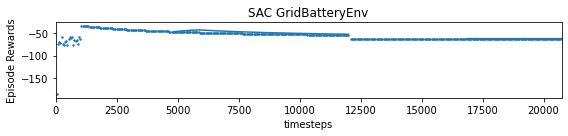

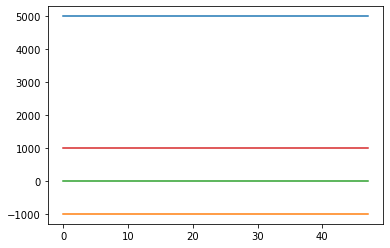

In [85]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=100, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=50, high=150, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action

    # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)

    
        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 1000
    
    
        power_balance_penalty = np.abs(self.P_d[t] - (Pg + Pb) - self.P_pv[t]) * 1000
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))*1000
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))*1000
    
        end_soc_penalty_weight = 1000  # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        reward = -(alpha_g_penalty + alpha_b_penalty + power_balance_penalty + alpha_b_penalty_soc + end_soc_penalty)
                # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t], self.P_pv[t], self.Cg_t[t], self.Cb_t[t]])

        # Check if done
        done = t >= 47

        return self.state, reward, done, {}

    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 0, 0, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)

# Instantiate the agent
model = TD3("MlpPolicy", env, learning_rate=0.00001, buffer_size=1024, batch_size=256, gamma=0.99, tau=0.005, verbose=1,seed=seed_value, policy_delay=2, target_policy_noise=0.2, target_noise_clip=0.5)  # Create a TD3 model

# Train the agent
model.learn(total_timesteps=350000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



In [172]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=15, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=500, high=1500, size=48)
Pg_max = 5000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)


        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    


    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action
        
            # Add Gaussian noise to the action
        noise = np.random.normal(loc=0, scale=0.05, size=4)  # Adjust scale for different noise levels
        Pg += noise[0]
        Pb += noise[1]
        alpha_g_action += noise[2]
        alpha_b_action += noise[3]

        # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)
        
        
        alpha_g_penalty_weight = 10  # Adjust this value to control the impact of the penalty term
        
        alpha_g_penalty_1 = alpha_g_penalty_weight * alpha_g_action * self.Cg_t[t]
    
    
    # Add a penalty term to enforce SOC at the end of the period to be above 0.8

        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]
                # Heavily penalize overcharging
        

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 10

        power_balance_penalty = self.P_d[t] - (Pg + Pb + self.P_pv[t])
        power_balance_penalty = np.clip(power_balance_penalty, 0, 1)
      
        
        
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))

        # Advanced reward shaping
        delta_Pg = Pg - self.Pg_max / 2
        delta_Pb = Pb - self.Pb_max / 2
        delta_alpha_g = alpha_g_action - self.alpha_g / 2
        delta_alpha_b = alpha_b_action - self.alpha_b / 2
        shaping_reward = - 0.01 * (delta_Pg**2 + delta_Pb**2 + delta_alpha_g**2 + delta_alpha_b**2)

        end_soc_penalty_weight = 10 # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))

        # Add weights to each term of the reward function
        power_balance_weight = 5 # adjust these weights as needed
        alpha_g_penalty_weight = 5
        alpha_b_penalty_weight = 5

        reward = -(power_balance_weight * power_balance_penalty + 
                    alpha_g_penalty_weight * alpha_g_penalty +
                    alpha_b_penalty_weight * alpha_b_penalty +
                    alpha_b_penalty_soc +
                    alpha_g_penalty_1 +
                    end_soc_penalty +
                    shaping_reward)  # Add shaping_reward to the total reward
  
            
            
            

        # Add an exploration bonus
        exploration_bonus = np.random.normal(0, 0.05)  # adjust the scale of the bonus as needed
        reward += exploration_bonus

        # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
           # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t+1] if t < 47 else 0, self.P_pv[t+1] if t < 47 else 0, self.Cg_t[t+1] if t < 47 else 0, self.Cb_t[t+1] if t < 47 else 0])
         # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise
        done = t >= 47

        return self.state, reward, done, {}



    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 4000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        
        
        # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.05, size=8)  # Adjust scale for different noise levels
        self.state += noise

        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)



# Create an evaluation environment
eval_env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Create the callback
eval_callback = EvalCallback(eval_env, best_model_save_path='./models/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)



from stable_baselines3.common.utils import get_linear_fn

#initial_lr = 0.0003
#final_lr = 0.00003
#lr_schedule = get_linear_fn(initial_lr, final_lr, 1000000)

#model = SAC("MlpPolicy", env, learning_rate=lr_schedule, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1, seed=seed_value)




#model = SAC("MlpPolicy", env, learning_rate=0.000001, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1,seed=seed_value)
    
from stable_baselines3.common.callbacks import BaseCallback

class LearningRateScheduler(BaseCallback):
    def __init__(self, initial_lr, total_timesteps, lr_schedule, verbose=0):
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_lr = initial_lr
        self.total_timesteps = total_timesteps
        self.lr_schedule = lr_schedule

    def _on_step(self):
        fraction_done = self.num_timesteps / self.total_timesteps
        new_lr = self.initial_lr * self.lr_schedule(fraction_done)
        self.model.learning_rate = new_lr
        return True

# You can define your scheduler function, for example, a linear decreasing schedule
def linear_schedule(fraction_done):
    return 1 - fraction_done

initial_learning_rate = 0.00001
total_timesteps = 500000
lr_scheduler = LearningRateScheduler(initial_learning_rate, total_timesteps, linear_schedule)

model = SAC("MlpPolicy", env, 
            learning_rate=initial_learning_rate,
            buffer_size=1000000,  
            batch_size=4096,
            gamma=0.99, 
            tau=0.005, 
            ent_coef='auto',  
            target_update_interval=1, 
            gradient_steps=1, 
            target_entropy='auto', 
            use_sde=False, 
            sde_sample_freq=-1, 
            verbose=1,
            seed=seed_value)

model.learn(total_timesteps=total_timesteps, callback=lr_scheduler)


    
    
    
    
from stable_baselines3 import A2C

#model = A2C("MlpPolicy", env, learning_rate=0.0001, buffer_size=1024, batch_size=512, 
           # gamma=0.99, use_sde=False, verbose=1, seed=seed_value)
            

model.learn(total_timesteps=500, callback=eval_callback)

# Train the agent
#model.learn(total_timesteps=9500)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
#results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
#plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class RewardLogger(BaseCallback):
    """
    A custom callback that derives from `BaseCallback`.

    This will record the cumulative reward for each training episode and save it into a list.
    """

    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.reward_log = []

    def _on_step(self) -> bool:
        """
        This method will be called by the model at each call to `model.step()`.
        """
        # We assume the environment uses the `Monitor` wrapper
        if self.locals.get("done"):
            latest_episode_reward = self.locals["episode"]["r"]
            self.reward_log.append(latest_episode_reward)

        # Continue training
        return True

# Create the callback
reward_logger = RewardLogger()

# Then you provide it to the learn function
model.learn(total_timesteps=total_timesteps, callback=[lr_scheduler, reward_logger])

# Now you can plot the cumulative rewards
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(reward_logger.reward_log))
plt.title("Cumulative Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()







plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



C:\Users\sesa512654\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -115     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4        |
|    time_elapsed    | 94       |
|    total_timesteps | 386      |
| train/             |          |
|    actor_loss      | 27.8     |
|    critic_loss     | 273      |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.0619  |
|    learning_rate   | 1e-05    |
|    n_updates       | 285      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -68      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 242      |
|    total_timesteps | 772      |
| train/             |          |
|    actor_loss      | 72.1     |
|    critic_loss     | 128     

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 64       |
|    fps             | 3        |
|    time_elapsed    | 1794     |
|    total_timesteps | 6026     |
| train/             |          |
|    actor_loss      | 582      |
|    critic_loss     | 2.56e+03 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 1e-05    |
|    n_updates       | 5925     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94       |
|    ep_rew_mean     | 15.5     |
| time/              |          |
|    episodes        | 68       |
|    fps             | 3        |
|    time_elapsed    | 1900     |
|    total_timesteps | 6389     |
| train/             |          |
|    actor_loss      | 604      |
|    critic_loss     | 3.43e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.5     |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    episodes        | 124      |
|    fps             | 3        |
|    time_elapsed    | 3404     |
|    total_timesteps | 11591    |
| train/             |          |
|    actor_loss      | 942      |
|    critic_loss     | 7.97e+03 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -2.27    |
|    learning_rate   | 1e-05    |
|    n_updates       | 11490    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.3     |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    episodes        | 128      |
|    fps             | 3        |
|    time_elapsed    | 3506     |
|    total_timesteps | 11948    |
| train/             |          |
|    actor_loss      | 967      |
|    critic_loss     | 8.42e+03 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.4     |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 3        |
|    time_elapsed    | 5233     |
|    total_timesteps | 17408    |
| train/             |          |
|    actor_loss      | 1.25e+03 |
|    critic_loss     | 1.21e+04 |
|    ent_coef        | 1.18     |
|    ent_coef_loss   | -3.45    |
|    learning_rate   | 1e-05    |
|    n_updates       | 17307    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.8     |
|    ep_rew_mean     | 33.5     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 3        |
|    time_elapsed    | 5351     |
|    total_timesteps | 17806    |
| train/             |          |
|    actor_loss      | 1.26e+03 |
|    critic_loss     | 1.45e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | 38.1     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 3        |
|    time_elapsed    | 7095     |
|    total_timesteps | 23094    |
| train/             |          |
|    actor_loss      | 1.47e+03 |
|    critic_loss     | 1.83e+04 |
|    ent_coef        | 1.25     |
|    ent_coef_loss   | -4.72    |
|    learning_rate   | 1e-05    |
|    n_updates       | 22993    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | 38.8     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 3        |
|    time_elapsed    | 7261     |
|    total_timesteps | 23497    |
| train/             |          |
|    actor_loss      | 1.48e+03 |
|    critic_loss     | 1.89e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 39.9     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 3        |
|    time_elapsed    | 8844     |
|    total_timesteps | 28813    |
| train/             |          |
|    actor_loss      | 1.63e+03 |
|    critic_loss     | 2.37e+04 |
|    ent_coef        | 1.33     |
|    ent_coef_loss   | -5.9     |
|    learning_rate   | 1e-05    |
|    n_updates       | 28712    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 40.1     |
| time/              |          |
|    episodes        | 308      |
|    fps             | 3        |
|    time_elapsed    | 8941     |
|    total_timesteps | 29152    |
| train/             |          |
|    actor_loss      | 1.64e+03 |
|    critic_loss     | 2.35e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.3     |
|    ep_rew_mean     | 42.7     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 3        |
|    time_elapsed    | 10655    |
|    total_timesteps | 34431    |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 2.44e+04 |
|    ent_coef        | 1.4      |
|    ent_coef_loss   | -7.18    |
|    learning_rate   | 1e-05    |
|    n_updates       | 34330    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 43.3     |
| time/              |          |
|    episodes        | 368      |
|    fps             | 3        |
|    time_elapsed    | 10794    |
|    total_timesteps | 34862    |
| train/             |          |
|    actor_loss      | 1.77e+03 |
|    critic_loss     | 2.49e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 45.7     |
| time/              |          |
|    episodes        | 424      |
|    fps             | 3        |
|    time_elapsed    | 12623    |
|    total_timesteps | 40121    |
| train/             |          |
|    actor_loss      | 1.9e+03  |
|    critic_loss     | 2.8e+04  |
|    ent_coef        | 1.49     |
|    ent_coef_loss   | -8.42    |
|    learning_rate   | 1e-05    |
|    n_updates       | 40020    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 46       |
| time/              |          |
|    episodes        | 428      |
|    fps             | 3        |
|    time_elapsed    | 12769    |
|    total_timesteps | 40508    |
| train/             |          |
|    actor_loss      | 1.9e+03  |
|    critic_loss     | 2.53e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.3     |
|    ep_rew_mean     | 46.6     |
| time/              |          |
|    episodes        | 484      |
|    fps             | 3        |
|    time_elapsed    | 14439    |
|    total_timesteps | 45949    |
| train/             |          |
|    actor_loss      | 2.01e+03 |
|    critic_loss     | 2.74e+04 |
|    ent_coef        | 1.57     |
|    ent_coef_loss   | -9.71    |
|    learning_rate   | 1e-05    |
|    n_updates       | 45848    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 46.8     |
| time/              |          |
|    episodes        | 488      |
|    fps             | 3        |
|    time_elapsed    | 14550    |
|    total_timesteps | 46352    |
| train/             |          |
|    actor_loss      | 2e+03    |
|    critic_loss     | 2.66e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.9     |
|    ep_rew_mean     | 44.5     |
| time/              |          |
|    episodes        | 544      |
|    fps             | 3        |
|    time_elapsed    | 16123    |
|    total_timesteps | 51821    |
| train/             |          |
|    actor_loss      | 2.06e+03 |
|    critic_loss     | 2.48e+04 |
|    ent_coef        | 1.67     |
|    ent_coef_loss   | -10.7    |
|    learning_rate   | 1e-05    |
|    n_updates       | 51720    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.4     |
|    ep_rew_mean     | 43.9     |
| time/              |          |
|    episodes        | 548      |
|    fps             | 3        |
|    time_elapsed    | 16265    |
|    total_timesteps | 52201    |
| train/             |          |
|    actor_loss      | 2.11e+03 |
|    critic_loss     | 2.59e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.7     |
|    ep_rew_mean     | 38.5     |
| time/              |          |
|    episodes        | 604      |
|    fps             | 3        |
|    time_elapsed    | 18283    |
|    total_timesteps | 57567    |
| train/             |          |
|    actor_loss      | 2.13e+03 |
|    critic_loss     | 2.48e+04 |
|    ent_coef        | 1.77     |
|    ent_coef_loss   | -11.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 57466    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.6     |
|    ep_rew_mean     | 38.2     |
| time/              |          |
|    episodes        | 608      |
|    fps             | 3        |
|    time_elapsed    | 18433    |
|    total_timesteps | 57959    |
| train/             |          |
|    actor_loss      | 2.14e+03 |
|    critic_loss     | 2.36e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    episodes        | 664      |
|    fps             | 3        |
|    time_elapsed    | 20203    |
|    total_timesteps | 63239    |
| train/             |          |
|    actor_loss      | 2.17e+03 |
|    critic_loss     | 2.47e+04 |
|    ent_coef        | 1.87     |
|    ent_coef_loss   | -13.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 63138    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.2     |
|    ep_rew_mean     | 33.5     |
| time/              |          |
|    episodes        | 668      |
|    fps             | 3        |
|    time_elapsed    | 20351    |
|    total_timesteps | 63613    |
| train/             |          |
|    actor_loss      | 2.17e+03 |
|    critic_loss     | 2.51e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.1     |
|    ep_rew_mean     | 30.3     |
| time/              |          |
|    episodes        | 724      |
|    fps             | 3        |
|    time_elapsed    | 22538    |
|    total_timesteps | 68968    |
| train/             |          |
|    actor_loss      | 2.19e+03 |
|    critic_loss     | 2.41e+04 |
|    ent_coef        | 1.98     |
|    ent_coef_loss   | -14.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 68867    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 30.3     |
| time/              |          |
|    episodes        | 728      |
|    fps             | 3        |
|    time_elapsed    | 22699    |
|    total_timesteps | 69368    |
| train/             |          |
|    actor_loss      | 2.21e+03 |
|    critic_loss     | 2.25e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 31       |
| time/              |          |
|    episodes        | 784      |
|    fps             | 3        |
|    time_elapsed    | 24843    |
|    total_timesteps | 74707    |
| train/             |          |
|    actor_loss      | 2.25e+03 |
|    critic_loss     | 2.18e+04 |
|    ent_coef        | 2.1      |
|    ent_coef_loss   | -15.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 74606    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.5     |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    episodes        | 788      |
|    fps             | 3        |
|    time_elapsed    | 24989    |
|    total_timesteps | 75072    |
| train/             |          |
|    actor_loss      | 2.24e+03 |
|    critic_loss     | 2.32e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.5     |
|    ep_rew_mean     | 31.1     |
| time/              |          |
|    episodes        | 844      |
|    fps             | 2        |
|    time_elapsed    | 27158    |
|    total_timesteps | 80436    |
| train/             |          |
|    actor_loss      | 2.3e+03  |
|    critic_loss     | 2.08e+04 |
|    ent_coef        | 2.22     |
|    ent_coef_loss   | -16.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 80335    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    episodes        | 848      |
|    fps             | 2        |
|    time_elapsed    | 27323    |
|    total_timesteps | 80848    |
| train/             |          |
|    actor_loss      | 2.28e+03 |
|    critic_loss     | 2.08e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    episodes        | 904      |
|    fps             | 2        |
|    time_elapsed    | 29409    |
|    total_timesteps | 86039    |
| train/             |          |
|    actor_loss      | 2.38e+03 |
|    critic_loss     | 2.18e+04 |
|    ent_coef        | 2.35     |
|    ent_coef_loss   | -17.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 85938    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    episodes        | 908      |
|    fps             | 2        |
|    time_elapsed    | 29569    |
|    total_timesteps | 86432    |
| train/             |          |
|    actor_loss      | 2.39e+03 |
|    critic_loss     | 2.29e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 32       |
| time/              |          |
|    episodes        | 964      |
|    fps             | 2        |
|    time_elapsed    | 31254    |
|    total_timesteps | 91781    |
| train/             |          |
|    actor_loss      | 2.46e+03 |
|    critic_loss     | 2.38e+04 |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | -19      |
|    learning_rate   | 1e-05    |
|    n_updates       | 91680    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    episodes        | 968      |
|    fps             | 2        |
|    time_elapsed    | 31367    |
|    total_timesteps | 92162    |
| train/             |          |
|    actor_loss      | 2.51e+03 |
|    critic_loss     | 2.2e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 2        |
|    time_elapsed    | 32933    |
|    total_timesteps | 97425    |
| train/             |          |
|    actor_loss      | 2.58e+03 |
|    critic_loss     | 2.61e+04 |
|    ent_coef        | 2.63     |
|    ent_coef_loss   | -20.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 97324    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 2        |
|    time_elapsed    | 33041    |
|    total_timesteps | 97784    |
| train/             |          |
|    actor_loss      | 2.56e+03 |
|    critic_loss     | 2.64e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.7     |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    episodes        | 1084     |
|    fps             | 2        |
|    time_elapsed    | 34656    |
|    total_timesteps | 103202   |
| train/             |          |
|    actor_loss      | 2.73e+03 |
|    critic_loss     | 2.71e+04 |
|    ent_coef        | 2.79     |
|    ent_coef_loss   | -21.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 103101   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.7     |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    episodes        | 1088     |
|    fps             | 2        |
|    time_elapsed    | 34767    |
|    total_timesteps | 103576   |
| train/             |          |
|    actor_loss      | 2.71e+03 |
|    critic_loss     | 2.81e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    episodes        | 1144     |
|    fps             | 2        |
|    time_elapsed    | 36356    |
|    total_timesteps | 108872   |
| train/             |          |
|    actor_loss      | 2.81e+03 |
|    critic_loss     | 2.78e+04 |
|    ent_coef        | 2.95     |
|    ent_coef_loss   | -22.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 108771   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.3     |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 2        |
|    time_elapsed    | 36473    |
|    total_timesteps | 109230   |
| train/             |          |
|    actor_loss      | 2.87e+03 |
|    critic_loss     | 2.93e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.2     |
|    ep_rew_mean     | 31       |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 3        |
|    time_elapsed    | 38032    |
|    total_timesteps | 114424   |
| train/             |          |
|    actor_loss      | 3e+03    |
|    critic_loss     | 3.1e+04  |
|    ent_coef        | 3.12     |
|    ent_coef_loss   | -24      |
|    learning_rate   | 1e-05    |
|    n_updates       | 114323   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.2     |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 3        |
|    time_elapsed    | 38139    |
|    total_timesteps | 114790   |
| train/             |          |
|    actor_loss      | 2.98e+03 |
|    critic_loss     | 3.18e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.2     |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    episodes        | 1264     |
|    fps             | 3        |
|    time_elapsed    | 39730    |
|    total_timesteps | 120102   |
| train/             |          |
|    actor_loss      | 3.16e+03 |
|    critic_loss     | 3.25e+04 |
|    ent_coef        | 3.31     |
|    ent_coef_loss   | -25      |
|    learning_rate   | 1e-05    |
|    n_updates       | 120001   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.4     |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    episodes        | 1268     |
|    fps             | 3        |
|    time_elapsed    | 39845    |
|    total_timesteps | 120487   |
| train/             |          |
|    actor_loss      | 3.17e+03 |
|    critic_loss     | 3.44e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    episodes        | 1324     |
|    fps             | 3        |
|    time_elapsed    | 41419    |
|    total_timesteps | 125742   |
| train/             |          |
|    actor_loss      | 3.31e+03 |
|    critic_loss     | 3.48e+04 |
|    ent_coef        | 3.5      |
|    ent_coef_loss   | -26.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 125641   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.1     |
|    ep_rew_mean     | 32       |
| time/              |          |
|    episodes        | 1328     |
|    fps             | 3        |
|    time_elapsed    | 41528    |
|    total_timesteps | 126108   |
| train/             |          |
|    actor_loss      | 3.36e+03 |
|    critic_loss     | 3.74e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 31.3     |
| time/              |          |
|    episodes        | 1384     |
|    fps             | 3        |
|    time_elapsed    | 43131    |
|    total_timesteps | 131475   |
| train/             |          |
|    actor_loss      | 3.51e+03 |
|    critic_loss     | 3.92e+04 |
|    ent_coef        | 3.71     |
|    ent_coef_loss   | -27.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 131374   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 3        |
|    time_elapsed    | 43242    |
|    total_timesteps | 131848   |
| train/             |          |
|    actor_loss      | 3.53e+03 |
|    critic_loss     | 4.06e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.7     |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 3        |
|    time_elapsed    | 44820    |
|    total_timesteps | 137116   |
| train/             |          |
|    actor_loss      | 3.7e+03  |
|    critic_loss     | 4.41e+04 |
|    ent_coef        | 3.92     |
|    ent_coef_loss   | -28.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 137015   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.4     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 1448     |
|    fps             | 3        |
|    time_elapsed    | 44934    |
|    total_timesteps | 137500   |
| train/             |          |
|    actor_loss      | 3.72e+03 |
|    critic_loss     | 4.53e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 3        |
|    time_elapsed    | 46548    |
|    total_timesteps | 142895   |
| train/             |          |
|    actor_loss      | 3.9e+03  |
|    critic_loss     | 4.91e+04 |
|    ent_coef        | 4.15     |
|    ent_coef_loss   | -30.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 142794   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    episodes        | 1508     |
|    fps             | 3        |
|    time_elapsed    | 46655    |
|    total_timesteps | 143253   |
| train/             |          |
|    actor_loss      | 3.97e+03 |
|    critic_loss     | 5e+04    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.5     |
|    ep_rew_mean     | 30       |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 3        |
|    time_elapsed    | 48223    |
|    total_timesteps | 148485   |
| train/             |          |
|    actor_loss      | 4.09e+03 |
|    critic_loss     | 5.27e+04 |
|    ent_coef        | 4.39     |
|    ent_coef_loss   | -31.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 148384   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.4     |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 3        |
|    time_elapsed    | 48337    |
|    total_timesteps | 148855   |
| train/             |          |
|    actor_loss      | 4.13e+03 |
|    critic_loss     | 5.48e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    episodes        | 1624     |
|    fps             | 3        |
|    time_elapsed    | 49967    |
|    total_timesteps | 154287   |
| train/             |          |
|    actor_loss      | 4.35e+03 |
|    critic_loss     | 5.58e+04 |
|    ent_coef        | 4.66     |
|    ent_coef_loss   | -33.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 154186   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.7     |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    episodes        | 1628     |
|    fps             | 3        |
|    time_elapsed    | 50076    |
|    total_timesteps | 154655   |
| train/             |          |
|    actor_loss      | 4.39e+03 |
|    critic_loss     | 5.81e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.2     |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    episodes        | 1684     |
|    fps             | 3        |
|    time_elapsed    | 51758    |
|    total_timesteps | 160023   |
| train/             |          |
|    actor_loss      | 4.63e+03 |
|    critic_loss     | 6.32e+04 |
|    ent_coef        | 4.93     |
|    ent_coef_loss   | -33.5    |
|    learning_rate   | 1e-05    |
|    n_updates       | 159922   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | 31.8     |
| time/              |          |
|    episodes        | 1688     |
|    fps             | 3        |
|    time_elapsed    | 51883    |
|    total_timesteps | 160400   |
| train/             |          |
|    actor_loss      | 4.64e+03 |
|    critic_loss     | 6.95e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.2     |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    episodes        | 1744     |
|    fps             | 3        |
|    time_elapsed    | 53357    |
|    total_timesteps | 165695   |
| train/             |          |
|    actor_loss      | 4.88e+03 |
|    critic_loss     | 6.43e+04 |
|    ent_coef        | 5.22     |
|    ent_coef_loss   | -34.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 165594   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.3     |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    episodes        | 1748     |
|    fps             | 3        |
|    time_elapsed    | 53434    |
|    total_timesteps | 166081   |
| train/             |          |
|    actor_loss      | 4.92e+03 |
|    critic_loss     | 7.29e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 31       |
| time/              |          |
|    episodes        | 1804     |
|    fps             | 3        |
|    time_elapsed    | 54451    |
|    total_timesteps | 171473   |
| train/             |          |
|    actor_loss      | 5.19e+03 |
|    critic_loss     | 6.77e+04 |
|    ent_coef        | 5.53     |
|    ent_coef_loss   | -36.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 171372   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.8     |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    episodes        | 1808     |
|    fps             | 3        |
|    time_elapsed    | 54518    |
|    total_timesteps | 171853   |
| train/             |          |
|    actor_loss      | 5.24e+03 |
|    critic_loss     | 7.4e+04  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.8     |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    episodes        | 1864     |
|    fps             | 3        |
|    time_elapsed    | 55475    |
|    total_timesteps | 177235   |
| train/             |          |
|    actor_loss      | 5.49e+03 |
|    critic_loss     | 8.25e+04 |
|    ent_coef        | 5.86     |
|    ent_coef_loss   | -37.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 177134   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.9     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 3        |
|    time_elapsed    | 55542    |
|    total_timesteps | 177625   |
| train/             |          |
|    actor_loss      | 5.49e+03 |
|    critic_loss     | 8.25e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    episodes        | 1924     |
|    fps             | 3        |
|    time_elapsed    | 56449    |
|    total_timesteps | 182916   |
| train/             |          |
|    actor_loss      | 5.78e+03 |
|    critic_loss     | 8.96e+04 |
|    ent_coef        | 6.2      |
|    ent_coef_loss   | -38.8    |
|    learning_rate   | 1e-05    |
|    n_updates       | 182815   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96       |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 3        |
|    time_elapsed    | 56520    |
|    total_timesteps | 183322   |
| train/             |          |
|    actor_loss      | 5.88e+03 |
|    critic_loss     | 9.71e+04 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.8     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 3        |
|    time_elapsed    | 57501    |
|    total_timesteps | 188704   |
| train/             |          |
|    actor_loss      | 6.2e+03  |
|    critic_loss     | 1.08e+05 |
|    ent_coef        | 6.57     |
|    ent_coef_loss   | -39.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 188603   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.9     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 1988     |
|    fps             | 3        |
|    time_elapsed    | 57574    |
|    total_timesteps | 189083   |
| train/             |          |
|    actor_loss      | 6.1e+03  |
|    critic_loss     | 1.12e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.1     |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 3        |
|    time_elapsed    | 59183    |
|    total_timesteps | 194423   |
| train/             |          |
|    actor_loss      | 6.58e+03 |
|    critic_loss     | 1.13e+05 |
|    ent_coef        | 6.96     |
|    ent_coef_loss   | -41.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 194322   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.1     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 3        |
|    time_elapsed    | 59274    |
|    total_timesteps | 194815   |
| train/             |          |
|    actor_loss      | 6.55e+03 |
|    critic_loss     | 1.18e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    episodes        | 2104     |
|    fps             | 3        |
|    time_elapsed    | 60769    |
|    total_timesteps | 200085   |
| train/             |          |
|    actor_loss      | 6.87e+03 |
|    critic_loss     | 1.28e+05 |
|    ent_coef        | 7.36     |
|    ent_coef_loss   | -43.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 199984   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.5     |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    episodes        | 2108     |
|    fps             | 3        |
|    time_elapsed    | 60893    |
|    total_timesteps | 200499   |
| train/             |          |
|    actor_loss      | 6.91e+03 |
|    critic_loss     | 1.3e+05  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.6     |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    episodes        | 2164     |
|    fps             | 3        |
|    time_elapsed    | 62455    |
|    total_timesteps | 205720   |
| train/             |          |
|    actor_loss      | 7.2e+03  |
|    critic_loss     | 1.42e+05 |
|    ent_coef        | 7.79     |
|    ent_coef_loss   | -44      |
|    learning_rate   | 1e-05    |
|    n_updates       | 205619   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.5     |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    episodes        | 2168     |
|    fps             | 3        |
|    time_elapsed    | 62558    |
|    total_timesteps | 206088   |
| train/             |          |
|    actor_loss      | 7.24e+03 |
|    critic_loss     | 1.44e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.9     |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    episodes        | 2224     |
|    fps             | 3        |
|    time_elapsed    | 64050    |
|    total_timesteps | 211415   |
| train/             |          |
|    actor_loss      | 7.7e+03  |
|    critic_loss     | 1.58e+05 |
|    ent_coef        | 8.25     |
|    ent_coef_loss   | -45.3    |
|    learning_rate   | 1e-05    |
|    n_updates       | 211314   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.3     |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    episodes        | 2228     |
|    fps             | 3        |
|    time_elapsed    | 64162    |
|    total_timesteps | 211818   |
| train/             |          |
|    actor_loss      | 7.8e+03  |
|    critic_loss     | 1.62e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.8     |
|    ep_rew_mean     | 29.5     |
| time/              |          |
|    episodes        | 2284     |
|    fps             | 3        |
|    time_elapsed    | 65662    |
|    total_timesteps | 217136   |
| train/             |          |
|    actor_loss      | 8.19e+03 |
|    critic_loss     | 1.72e+05 |
|    ent_coef        | 8.74     |
|    ent_coef_loss   | -46.1    |
|    learning_rate   | 1e-05    |
|    n_updates       | 217035   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.6     |
|    ep_rew_mean     | 29.4     |
| time/              |          |
|    episodes        | 2288     |
|    fps             | 3        |
|    time_elapsed    | 65769    |
|    total_timesteps | 217517   |
| train/             |          |
|    actor_loss      | 8.3e+03  |
|    critic_loss     | 1.81e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.9     |
|    ep_rew_mean     | 28.5     |
| time/              |          |
|    episodes        | 2344     |
|    fps             | 3        |
|    time_elapsed    | 66910    |
|    total_timesteps | 222744   |
| train/             |          |
|    actor_loss      | 8.66e+03 |
|    critic_loss     | 2.19e+05 |
|    ent_coef        | 9.24     |
|    ent_coef_loss   | -48.2    |
|    learning_rate   | 1e-05    |
|    n_updates       | 222643   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.6     |
|    ep_rew_mean     | 28.7     |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 3        |
|    time_elapsed    | 66970    |
|    total_timesteps | 223095   |
| train/             |          |
|    actor_loss      | 8.73e+03 |
|    critic_loss     | 1.99e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.8     |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    episodes        | 2404     |
|    fps             | 3        |
|    time_elapsed    | 67893    |
|    total_timesteps | 228414   |
| train/             |          |
|    actor_loss      | 9.09e+03 |
|    critic_loss     | 2.16e+05 |
|    ent_coef        | 9.78     |
|    ent_coef_loss   | -48.9    |
|    learning_rate   | 1e-05    |
|    n_updates       | 228313   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.8     |
|    ep_rew_mean     | 28.7     |
| time/              |          |
|    episodes        | 2408     |
|    fps             | 3        |
|    time_elapsed    | 67957    |
|    total_timesteps | 228790   |
| train/             |          |
|    actor_loss      | 9.15e+03 |
|    critic_loss     | 2.18e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.7     |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    episodes        | 2464     |
|    fps             | 3        |
|    time_elapsed    | 68879    |
|    total_timesteps | 234171   |
| train/             |          |
|    actor_loss      | 9.77e+03 |
|    critic_loss     | 2.37e+05 |
|    ent_coef        | 10.4     |
|    ent_coef_loss   | -50.6    |
|    learning_rate   | 1e-05    |
|    n_updates       | 234070   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.7     |
|    ep_rew_mean     | 29.4     |
| time/              |          |
|    episodes        | 2468     |
|    fps             | 3        |
|    time_elapsed    | 68941    |
|    total_timesteps | 234532   |
| train/             |          |
|    actor_loss      | 9.69e+03 |
|    critic_loss     | 2.51e+05 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.1     |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 3        |
|    time_elapsed    | 69886    |
|    total_timesteps | 239988   |
| train/             |          |
|    actor_loss      | 1.03e+04 |
|    critic_loss     | 2.66e+05 |
|    ent_coef        | 11       |
|    ent_coef_loss   | -51.4    |
|    learning_rate   | 1e-05    |
|    n_updates       | 239887   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.6     |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    episodes        | 2528     |
|    fps             | 3        |
|    time_elapsed    | 69956    |
|    total_timesteps | 240358   |
| train/             |          |
|    actor_loss      | 1.03e+04 |
|    critic_loss     | 2.51e+05 |
|    ent_coef 

KeyboardInterrupt: 

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -123     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5        |
|    time_elapsed    | 76       |
|    total_timesteps | 386      |
| train/             |          |
|    actor_loss      | -46.7    |
|    critic_loss     | 129      |
|    ent_coef        | 0.2      |
|    learning_rate   | 1e-05    |
|    n_updates       | 285      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.5     |
|    ep_rew_mean     | -98.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 4        |
|    time_elapsed    | 178      |
|    total_timesteps | 772      |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 81.1     |
|    ent_coef        | 0.2     

Action: [[5631.9717  -981.96844  950.5924   511.34595]]
Action: [[3921.0166  -773.7124   297.87366  663.8402 ]]
Action: [[3417.315  -556.8363  286.5163  737.7442]]
Action: [[5798.135    -349.93103   461.11328    22.236858]]
Action: [[4322.094   -802.8162   399.12558  542.5751 ]]
Action: [[5776.779    -416.80432   597.1235     21.121906]]
Action: [[2515.7085   370.34546  727.22955  572.9411 ]]
Action: [[3568.5103  -829.11194  266.06204  158.57622]]
Action: [[4890.964     366.82483    34.698055   11.819959]]
Action: [[5737.8965  416.563   594.5218  179.9853]]
Action: [[4334.763    632.2262   393.86493  244.18114]]
Action: [[5035.335    566.9988   589.0259   245.34668]]
Action: [[3945.1226   988.3373   310.16946  626.04474]]
Action: [[5426.102   615.4092  600.4498  263.576 ]]
Action: [[4898.8467   849.19434  440.2106   334.11716]]
Action: [[5334.413    349.94922  536.5384   377.34134]]
Action: [[2354.583    439.45618  211.7665   672.9112 ]]
Action: [[5620.2896   599.22644  624.094    351.

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.3     |
|    ep_rew_mean     | -38.9    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 3        |
|    time_elapsed    | 987      |
|    total_timesteps | 3773     |
| train/             |          |
|    actor_loss      | 127      |
|    critic_loss     | 113      |
|    ent_coef        | 0.2      |
|    learning_rate   | 1e-05    |
|    n_updates       | 8572     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.3     |
|    ep_rew_mean     | -38.5    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 3        |
|    time_elapsed    | 1086     |
|    total_timesteps | 4150     |
| train/             |          |
|    actor_loss      | 132      |
|    critic_loss     | 128      |
|    ent_coef        | 0.2      |
|    learning_

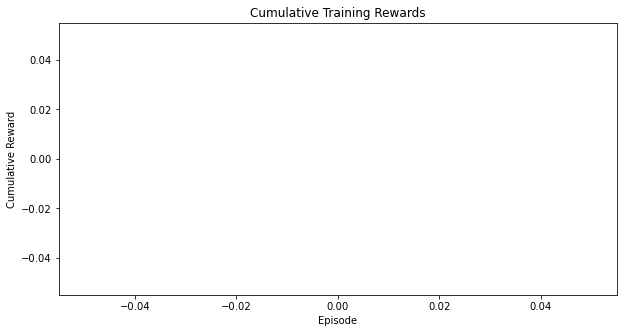

IndexError: index 1 is out of bounds for axis 1 with size 1

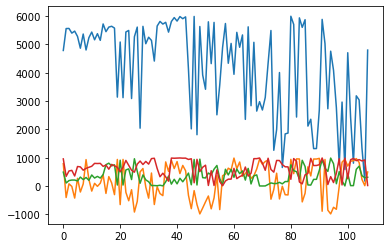

In [31]:
import torch
import random
import os
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Input data
P_pv = np.array([0,0,0,0,0,0,0,0,0,0,0,0.386,20.105,95.532,219.91,379.942,576.4,815.921,1080.177,1311.405,1487.084,1623.791,1759.657,1916.357,2063.169,2229.299,2328.958,2316.651,2295.714,2229.492,2127.257,2034.534,1868.014,1642.4,1444.187,1182.863,890.167,555.05,312.502,158.383,41.405,0.803,0,0,0,0,0,0])
P_d = np.array([4324,4181,4104,4029,3942,3926,3933,3950,4070,4146,4310,4431,4557,4592,4417,4225,4141,3997,3735,3696,3625,3590,3633,3657,3861,4063,4299,4472,4545,4700,4865,5116,5397,5550,5628,5625,5615,5507,5497,5523,5436,5284,5085,4909,4743,4660,4746,4742])
Cg_t = np.random.uniform(low=10, high=15, size=48)
Cb_t = np.random.uniform(low=1, high=2, size=48)
P_unc = np.random.uniform(low=500, high=1500, size=48)
Pg_max = 6000  # Define your Pg_max
Pb_max = 1000  # Define your Pb_max
alpha_g = 1  # Define your alpha_g
alpha_b = 1  # Define your alpha_b
alpha_T = 1000

seed_value = 42  # can be any integer

# Set python built-in generator's seed
random.seed(seed_value)

# Set Numpy's seed
np.random.seed(seed_value)

# Set Pytorch's seed
torch.manual_seed(seed_value)


class RunningMeanStd(object):
    # Utility class for computing mean and standard deviation online
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon


    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)  # Avoid division by zero
        self.count = tot_count



class GridBatteryEnv(gym.Env):
    def __init__(self, P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b):
        super(GridBatteryEnv, self).__init__()
        
        
        
        self.reward_rms = RunningMeanStd()

        # Constants
        self.P_pv = P_pv
        self.P_d = P_d
        self.Cg_t = Cg_t
        self.Cb_t = Cb_t
        self.P_unc = P_unc
        self.Pg_max = Pg_max
        self.Pb_max = Pb_max
        self.alpha_g = alpha_g
        self.alpha_b = alpha_b
        self.alpha_T = alpha_T
        self.seed(seed_value)
        
        self.violations = {'power_balance': [], 'SOC': []}



        # State: [current time step, SOC, Pg_last, Pb_last]
        self.state = np.array([0, 0.8, 5000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])

        # Action: [Pg, Pb]
        self.action_space = spaces.Box(low=np.array([0, -1000, 1, 1]), high=np.array([Pg_max, Pb_max, alpha_T, alpha_T]), dtype=np.float32)

        # State: [current time step, SOC, Pg_last, Pb_last, P_d[t], P_pv[t], Cg_t[t], Cb_t[t]]
        self.observation_space = spaces.Box(low=np.zeros(8), high=np.array([48, 1, Pg_max, Pb_max, np.max(P_d), np.max(P_pv), np.max(Cg_t), np.max(Cb_t)]), dtype=np.float32)
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    


    def step(self, action):
        # Extract action
        Pg, Pb, alpha_g_action, alpha_b_action = action
        
            # Add Gaussian noise to the action
        noise = np.random.normal(loc=0, scale=0.05, size=4)  # Adjust scale for different noise levels
        Pg += noise[0]
        Pb += noise[1]
        alpha_g_action += noise[2]
        alpha_b_action += noise[3]
        
        
         # Clip the action after adding noise
        Pg = np.clip(Pg, 0, self.Pg_max)
        Pb = np.clip(Pb, -self.Pb_max, self.Pb_max)
        alpha_g_action = np.clip(alpha_g_action, 0, self.alpha_g)
        alpha_b_action = np.clip(alpha_b_action, 0, self.alpha_b)
        
       
        # Extract state
        t, SOC, _, _, _, _, _, _ = self.state

        t = int(t)
       
        
        
        alpha_g_penalty_weight = 10  # Adjust this value to control the impact of the penalty term
        
        alpha_g_penalty_1 = alpha_g_penalty_weight * alpha_g_action * self.Cg_t[t]
    
    
    # Add a penalty term to enforce SOC at the end of the period to be above 0.8

        SOC_new = SOC - Pb / 20000
        SOC_new = np.clip(SOC_new, 0, 1)  # Clip SOC to be within [0, 1]
                # Heavily penalize overcharging
             # Prevent Pb from causing SOC to exceed its limits
        Pb = np.clip(Pb, 20000*SOC_new, 20000*(1-SOC_new))  # Pb cannot make SOC lower than 0 or higher than 1

        

        soc_violation_penalty = np.square(np.max([0.2 - SOC_new, 0])) + np.square(np.max([SOC_new - 0.8, 0]))
        alpha_b_penalty_soc = alpha_b_action * soc_violation_penalty * 10

     # Adjust Pg and Pb to maintain power balance
        #Pg += self.P_d[t] - (Pg + Pb + self.P_pv[t])
        #Pb += self.P_d[t] - (Pg + Pb + self.P_pv[t])
          # Calculate power difference
        power_difference = self.P_d[t] - (Pg + Pb + self.P_pv[t])

       # Correct Pg and Pb while maintaining their proportion
        #Pg_correction = Pg / (Pg + Pb) * power_difference
        #Pb_correction = Pb / (Pg + Pb) * power_difference
        #Pg += Pg_correction
        #Pb += Pb_correction
           # Calculate power to maintain balance
        P_balance = self.P_d[t] - self.P_pv[t]
        
        # Compute the power balance violation before correcting Pg and Pb
        power_balance_violation = abs(self.P_d[t] - (Pg + Pb + self.P_pv[t]))
        self.violations['power_balance'].append(power_balance_violation)

# If Pg and Pb are both zero, then distribute power based on some predefined ratio (for example, 0.5 for both)
        if Pg == 0 and Pb == 0:
            Pg_ratio = 0.5
            Pb_ratio = 0.5
        else:
            Pb_ratio = Pb / (Pg + Pb)
            Pg_ratio = Pg / (Pg + Pb)
    
        Pg = Pg_ratio * P_balance
        Pb = Pb_ratio * P_balance
        #Pg = np.clip(Pg, 0, self.Pg_max)
        #Pb = np.clip(Pb, -self.Pb_max, self.Pb_max)
             # Check if Pg > Pd, otherwise set Pb to a non-negative value
        if Pg <= self.P_d[t]:
            Pb = max(0, Pb)
            
        
   # Compute the SOC violation before enforcing constraints
        SOC_violation = max(0, SOC_new - 1, -SOC_new)
        self.violations['SOC'].append(SOC_violation)

        




    
        
        
           # Change the penalty calculation to be based on how much alpha_g_action and alpha_b_action deviate from zero
       # alpha_g_penalty_2 = alpha_g_action * np.square(np.max([alpha_g_action - 0, 0]))
       # alpha_b_penalty_2 = alpha_b_action * np.square(np.max([alpha_b_action - 0, 0]))
      
        
        
        alpha_g_penalty = alpha_g_action * np.square(np.max([Pg - self.Pg_max, 0]))
        alpha_b_penalty = alpha_b_action * np.square(np.max([Pb - self.Pb_max, 0]))

        # Advanced reward shaping
        delta_Pg = Pg - self.Pg_max / 2
        delta_Pb = Pb - self.Pb_max / 2
        delta_alpha_g = alpha_g_action - self.alpha_g / 2
        delta_alpha_b = alpha_b_action - self.alpha_b / 2
        shaping_reward = - 0.01 * (delta_Pg**2 + delta_Pb**2 + delta_alpha_g**2 + delta_alpha_b**2)

        end_soc_penalty_weight = 10 # Adjust this value to control the impact of the penalty term
        end_soc_penalty = end_soc_penalty_weight * np.square(np.max([0.8 - SOC_new, 0]))
        
        
        
        # Add a penalty term to enforce SOC at the end of the period to be above 0.2
       # if t == 47 and SOC_new < 0.2:  # This is the last time step
        #    end_soc_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
         #   end_soc_penalty = end_soc_penalty_weight * np.square(0.2 - SOC_new)
        #else:
         #   end_soc_penalty = 0

    # Add a penalty term to enforce average SOC over the whole period to be above 0.4
        #if t == 47:  # This is the last time step, calculate the average SOC
         #   avg_soc = self.total_SOC / 48  # Divide by the total number of time steps
          #  if avg_soc < 0.4:
           #     avg_soc_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
            #    avg_soc_penalty = avg_soc_penalty_weight * np.square(0.4 - avg_soc)
            #else:
             #   avg_soc_penalty = 0
        #else:
         #   avg_soc_penalty = 0

    # Update total_SOC
        #self.total_SOC += SOC_new

        # Add weights to each term of the reward function
        power_balance_weight = 5 # adjust these weights as needed
        alpha_g_penalty_weight = 10
        alpha_b_penalty_weight = 10

        reward = -(#power_balance_weight * power_balance_penalty + 
                    alpha_g_penalty_weight * alpha_g_penalty +
                    alpha_b_penalty_weight * alpha_b_penalty +
                    alpha_b_penalty_soc +
                    alpha_g_penalty_1 +
                    end_soc_penalty +
                   # avg_soc_penalty +
                    #alpha_g_penalty_2 + 
                    #alpha_b_penalty_2 +
                    shaping_reward)  # Add shaping_reward to the total reward
        
        if SOC_new > 0.8:
            reward -= 100

        # Heavily penalize undercharging
        if SOC_new < 0.2:
            reward -= 100

            
            
        if reward < 0:
             reward -= 100
            
            
            

        # Add an exploration bonus
        exploration_bonus = np.random.normal(0, 0.05)  # adjust the scale of the bonus as needed
        reward += exploration_bonus

        # Normalize reward
        self.reward_rms.update(np.array([reward]))
        reward /= np.sqrt(self.reward_rms.var + 1e-8)  # Small constant for numerical stability

        # Update state
           # Update state
        self.state = np.array([t+1, SOC_new, Pg, Pb, self.P_d[t+1] if t < 47 else 0, self.P_pv[t+1] if t < 47 else 0, self.Cg_t[t+1] if t < 47 else 0, self.Cb_t[t+1] if t < 47 else 0])
         # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.1, size=8)  # Adjust scale for different noise levels
        self.state += noise
        done = t >= 47
        
        self.violations['power_balance'].append(power_balance_violation)
        self.violations['SOC'].append(SOC_violation)


        return self.state, reward, done, {}



    def reset(self):
                # Reset to initial state
        self.state = np.array([0, 0.8, 5000, 1000, self.P_d[0], self.P_pv[0], self.Cg_t[0], self.Cb_t[0]])
        #self.total_SOC = self.state[1]  # Initialize total_SOC with the initial SOC
        self.violations = {'power_balance': [], 'SOC': []}


        
        
        # Add Gaussian noise to the state
        noise = np.random.normal(loc=0, scale=0.05, size=8)  # Adjust scale for different noise levels
        self.state += noise
        
        # Clip the state after adding noise
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high)


        return self.state

log_dir = "./tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Wrap it for monitoring
env = Monitor(env, log_dir)

# It's common practice to wrap your environment this way for vectorized environments
env = make_vec_env(lambda: env, n_envs=1)



# Create an evaluation environment
eval_env = GridBatteryEnv(P_pv, P_d, Cg_t, Cb_t, P_unc, Pg_max, Pb_max, alpha_g, alpha_b)

# Create the callback
eval_callback = EvalCallback(eval_env, best_model_save_path='./models/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)



from stable_baselines3.common.utils import get_linear_fn

#initial_lr = 0.0003
#final_lr = 0.00003
#lr_schedule = get_linear_fn(initial_lr, final_lr, 1000000)

#model = SAC("MlpPolicy", env, learning_rate=lr_schedule, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1, seed=seed_value)




#model = SAC("MlpPolicy", env, learning_rate=0.000001, buffer_size=1024, batch_size=256, 
 #           gamma=0.99, tau=0.005, ent_coef='auto', target_update_interval=1, 
  #          gradient_steps=1, target_entropy='auto', use_sde=False, sde_sample_freq=-1, 
   #         verbose=1,seed=seed_value)
    
from stable_baselines3.common.callbacks import BaseCallback

class LearningRateScheduler(BaseCallback):
    def __init__(self, initial_lr, total_timesteps, lr_schedule, verbose=0):
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_lr = initial_lr
        self.total_timesteps = total_timesteps
        self.lr_schedule = lr_schedule

    def _on_step(self):
        fraction_done = self.num_timesteps / self.total_timesteps
        new_lr = self.initial_lr * self.lr_schedule(fraction_done)
        self.model.learning_rate = new_lr
        return True

# You can define your scheduler function, for example, a linear decreasing schedule
def linear_schedule(fraction_done):
    return 1 - fraction_done

initial_learning_rate = 0.00001
total_timesteps = 5000
lr_scheduler = LearningRateScheduler(initial_learning_rate, total_timesteps, linear_schedule)

model = SAC("MlpPolicy", env, 
            learning_rate=initial_learning_rate,
            buffer_size=1000000,  
            batch_size=4096,
            gamma=0.99, 
            tau=0.005, 
            ent_coef=0.2,  
            target_update_interval=1, 
            gradient_steps=1, 
            target_entropy='auto', 
            use_sde=False, 
            sde_sample_freq=-1, 
            verbose=1,
            seed=seed_value)

model.learn(total_timesteps=total_timesteps, callback=lr_scheduler)


#ddpg_model = DDPG("MlpPolicy", env, learning_rate=0.00001, buffer_size=1000000, learning_starts=1000, batch_size=100, tau=0.005, gamma=0.99, train_freq=1000, gradient_steps=-1, action_noise=None, optimize_memory_usage=False, verbose=1, seed=seed_value)

    
    
    


# Train the agent
#model.learn(total_timesteps=9500)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Plotting the learning curve
#results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC GridBatteryEnv")
#plt.savefig('learning_curve2.pdf')


# Plotting decision variables and SOC
n_eval_episodes = 1
obs = env.reset()
decision_variables = []
SOCs = []
P_d_plot = []
P_pv_plot = []
power_balance_violations = []  # record power balance violations
SOC_violations = []  # record SOC violations
violations = {'power_balance': [], 'SOC': []}

for _ in range(n_eval_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        print(f"Action: {action}")
        obs, reward, done, info = env.step(action)
        decision_variables.append(action)
        SOCs.append(obs[0][1])
        P_d_plot.append(obs[0][4])
        P_pv_plot.append(obs[0][5])
       


decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)
P_d_plot = np.array(P_d_plot)
P_pv_plot = np.array(P_pv_plot)

import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class RewardLogger(BaseCallback):
    """
    A custom callback that derives from `BaseCallback`.

    This will record the cumulative reward for each training episode and save it into a list.
    """

    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.reward_log = []

    def _on_step(self) -> bool:
        """
        This method will be called by the model at each call to `model.step()`.
        """
        # We assume the environment uses the `Monitor` wrapper
        if self.locals.get("done"):
            latest_episode_reward = self.locals["episode"]["r"]
            self.reward_log.append(latest_episode_reward)

        # Continue training
        return True

# Create the callback
reward_logger = RewardLogger()

# Then you provide it to the learn function
model.learn(total_timesteps=total_timesteps, callback=[lr_scheduler, reward_logger])

# Now you can plot the cumulative rewards
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(reward_logger.reward_log))
plt.title("Cumulative Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()







plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.plot(P_d_plot, label="Pd")
plt.plot(P_pv_plot, label="Ppv")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.savefig('decision_variables_and_inputs.pdf')

decision_variables = np.array(decision_variables)
SOCs = np.array(SOCs)

plt.figure()
plt.plot(decision_variables[:, 0], label="Pg")
plt.plot(decision_variables[:, 1], label="Pb")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables1.pdf')

plt.figure()
plt.plot(decision_variables[:, 2], label="alpha_g_action")
plt.plot(decision_variables[:, 3], label="alpha_b_action")
plt.xlabel("Time")
plt.ylabel("Decision Variables")
plt.legend()
plt.savefig('decision_variables2.pdf')

plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')



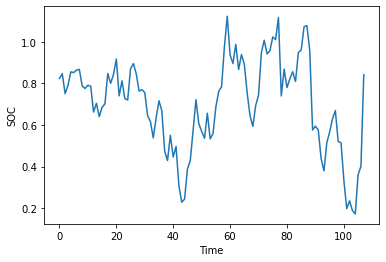

In [32]:
plt.figure()
plt.plot(SOCs)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')

In [25]:
plt.figure()
plt.plot(env.total_SOC)
plt.xlabel("Time")
plt.ylabel("SOC")
plt.savefig('SOCsDRL.pdf')

AttributeError: 'DummyVecEnv' object has no attribute 'total_SOC'

<Figure size 432x288 with 0 Axes>

AttributeError: 'DummyVecEnv' object has no attribute 'violations'

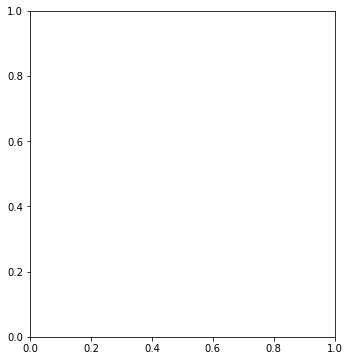

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot power balance violations
plt.subplot(1, 2, 1)
plt.plot(env.violations['power_balance'])
plt.title('Power Balance Violations')

# Plot SOC violations
plt.subplot(1, 2, 2)
plt.plot(env.violations['SOC'])
plt.title('SOC Violations')

plt.tight_layout()
plt.show()


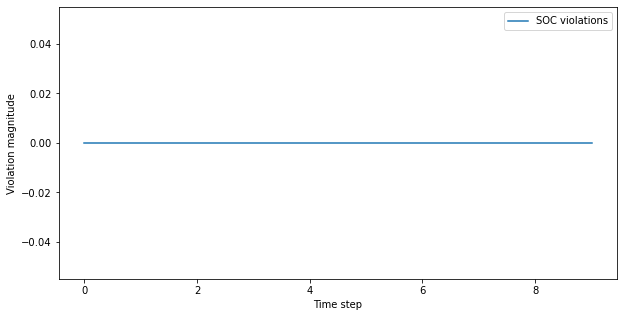

In [33]:
import matplotlib.pyplot as plt

# Access the violations from your environment
violations = env.get_attr('violations')[0]  # Assuming you have a single environment

# Extract SOC violations
soc_violations = violations['SOC']

# Filter out violations that are below 0.2 or above 1
filtered_violations = [v for v in soc_violations if v < 0.2 or v > 1]

# Plot violations
plt.figure(figsize=(10,5))
plt.plot(filtered_violations, label='SOC violations')
plt.ylabel('Violation magnitude')
plt.xlabel('Time step')
plt.legend()
plt.show()


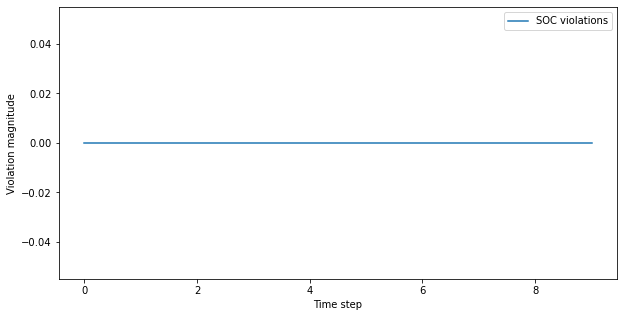

In [30]:
# Plot violations
plt.figure(figsize=(10,5))
plt.plot(soc_violations, label='SOC violations')
plt.ylabel('Violation magnitude')
plt.xlabel('Time step')
plt.legend()
plt.show()